In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

# Constants

In [5]:
INPUT_DIM = 50
BIAS = False

SEED = 42
N_TRAIN = 256
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(2e4)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 2000

EPS = 1.0e-7
ALPHA = 1.0
BETA = 1.0
LAMBDA = 0.02

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/prox_variants/')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

## Common functions

In [8]:
def forward(a, b, x):
    m = a.shape[1]
    if m == 0:
        return 0.
    return np.matmul(np.maximum(np.matmul(x, b.T), 0), a.T) #/ m #/ a.shape[1]

In [9]:
def compute_losses(a, b, x, y, penalized=True):
    y_hat = forward(a, b, x)
    loss_ = 0.5 * np.mean((y_hat - y)**2)
    if penalized:
        penalized_loss = loss_ + LAMBDA * np.sum(np.abs(a))
    else:
        penalized_loss = 0.
    return loss_, penalized_loss

In [10]:
def soft_thresholding(V, tau):
    return - np.sign(V) * np.maximum(0, np.abs(V) - tau)

In [11]:
def V_grad(a, b, x, y, new_b):
    y_hat = forward(a, b, x)
    if len(new_b.shape) < 2:
        new_b = new_b.reshape(1, -1)
    V_grad_ = np.mean((y_hat - y) * np.maximum(np.matmul(x, new_b.T), 0), axis=0)
    if len(V_grad_) == 1:
        return V_grad_[0]
    else:
        return V_grad_

In [12]:
def nabla_V_grad(a, b, x, y, factor=1.0):
    n = len(x)
    m = a.shape[1]
    y_hat = forward(a, b, x)
    # M = (y_hat - y) * np.heaviside(np.matmul(x, b.T * a), 0)
    M = (y_hat - y) * np.heaviside(np.matmul(x, b.T), 0) * factor
    return np.matmul(M.T, x) / n    

# Data

In [13]:
# Teacher Network
m_star = 50 # number of teacher neurons
eps = 3e-1

a_star = 2 * np.sign(np.random.uniform(size=(1, m_star)) - 0.5) / np.sqrt(m_star)
b_star = 2 * np.random.uniform(size=(m_star, INPUT_DIM)) - 1 - eps * np.random.normal(size=(m_star, INPUT_DIM))**2

In [14]:
# Data with inputs on the sphere
x_train = np.random.normal(size=(N_TRAIN, INPUT_DIM))
train_norms = np.linalg.norm(x_train, axis=1, ord=2, keepdims=True)
x_train = x_train / train_norms
y_train = forward(a_star, b_star, x_train)

x_val = np.random.normal(size=(N_VAL, INPUT_DIM))
val_norms = np.linalg.norm(x_val, axis=1, ord=2, keepdims=True)
x_val = x_val / val_norms
y_val = forward(a_star, b_star, x_val)

In [15]:
print(np.max(np.linalg.norm(x_train, axis=1, ord=2)))
print(np.max(np.linalg.norm(x_val, axis=1, ord=2)))

1.0
1.0000000000000002


We have
$$V[\mu](b) = \frac{1}{n} \sum_{i=1}^n (f(\mu;x_i) - y_i) \sigma(b^\top x_i).$$
In this setting, sampling the particles on the sphere yields
$$|V[\mu](b) - V[\nu](b)| \leq |\mu - \nu|_{TV},$$
and thus a Lipschitz constant for the gradient $V$ equal to $L=1$. 

## 1. Standard conic descent: gradient descent on the empirical loss

In [16]:
n_steps = N_STEPS
m = 500
ETA = 0.01

In [17]:
def conic_particle_update(a, b, x, y):
    m = a.shape[1]
    if m > 0:
        a = a - ETA * V_grad(a, b, x, y, b).reshape(1, -1) / m
        b = b - m * ETA * nabla_V_grad(a, b, x, y, factor=a)
    return a, b  

In [18]:
def train(m, n_steps, x_train, y_train, x_val, y_val, do_val=True):
    #a = np.zeros(shape=(1, m))
    a = np.random.normal(size=(1, m)) / m
    b = np.random.normal(size=(m, INPUT_DIM))
    b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    b = b / b_norms
    
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    ms = [m]

    for k in tqdm(range(n_steps)):
        a, b = conic_particle_update(a, b, x_train, y_train)
        ms.append(a.shape[1])
        
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [19]:
a, b, ms, train_losses, penalized_train_losses, val_losses, penalized_val_losses = \
    train(m, n_steps, x_train, y_train, x_val, y_val)

  0%|                                                        | 42/20000 [00:00<01:33, 214.34it/s]

m at step 0 : 500
Train loss at step 0 : 0.40126
Validation loss at step 0 : 0.36885


  1%|▎                                                      | 125/20000 [00:00<01:58, 168.27it/s]

m at step 100 : 500
Train loss at step 100 : 0.39680
Validation loss at step 100 : 0.36585


  1%|▋                                                      | 232/20000 [00:01<01:24, 234.06it/s]

m at step 200 : 500
Train loss at step 200 : 0.39241
Validation loss at step 200 : 0.36285


  2%|▉                                                      | 323/20000 [00:01<01:50, 178.32it/s]

m at step 300 : 500
Train loss at step 300 : 0.38799
Validation loss at step 300 : 0.35980


  2%|█▏                                                     | 453/20000 [00:02<01:20, 241.41it/s]

m at step 400 : 500
Train loss at step 400 : 0.38345
Validation loss at step 400 : 0.35660


  3%|█▍                                                     | 534/20000 [00:02<01:15, 258.30it/s]

m at step 500 : 500
Train loss at step 500 : 0.37871
Validation loss at step 500 : 0.35323


  3%|█▊                                                     | 644/20000 [00:03<01:15, 257.53it/s]

m at step 600 : 500
Train loss at step 600 : 0.37369
Validation loss at step 600 : 0.34966


  4%|██                                                     | 755/20000 [00:03<01:11, 269.52it/s]

m at step 700 : 500
Train loss at step 700 : 0.36829
Validation loss at step 700 : 0.34582


  4%|██▎                                                    | 838/20000 [00:03<01:21, 236.50it/s]

m at step 800 : 500
Train loss at step 800 : 0.36240
Validation loss at step 800 : 0.34163


  5%|██▌                                                    | 947/20000 [00:04<01:21, 233.93it/s]

m at step 900 : 500
Train loss at step 900 : 0.35600
Validation loss at step 900 : 0.33706


  5%|██▊                                                   | 1055/20000 [00:04<01:13, 257.47it/s]

m at step 1,000 : 500
Train loss at step 1,000 : 0.34903
Validation loss at step 1,000 : 0.33207


  6%|███                                                   | 1137/20000 [00:05<01:11, 265.35it/s]

m at step 1,100 : 500
Train loss at step 1,100 : 0.34145
Validation loss at step 1,100 : 0.32661


  6%|███▎                                                  | 1240/20000 [00:05<01:24, 220.86it/s]

m at step 1,200 : 500
Train loss at step 1,200 : 0.33320
Validation loss at step 1,200 : 0.32069


  7%|███▋                                                  | 1350/20000 [00:05<01:12, 258.51it/s]

m at step 1,300 : 500
Train loss at step 1,300 : 0.32425
Validation loss at step 1,300 : 0.31426


  7%|███▊                                                  | 1433/20000 [00:06<01:09, 267.38it/s]

m at step 1,400 : 500
Train loss at step 1,400 : 0.31459
Validation loss at step 1,400 : 0.30730


  8%|████▏                                                 | 1542/20000 [00:06<01:10, 261.83it/s]

m at step 1,500 : 500
Train loss at step 1,500 : 0.30423
Validation loss at step 1,500 : 0.29980


  8%|████▍                                                 | 1652/20000 [00:07<01:07, 270.00it/s]

m at step 1,600 : 500
Train loss at step 1,600 : 0.29322
Validation loss at step 1,600 : 0.29178


  9%|████▋                                                 | 1736/20000 [00:07<01:07, 271.07it/s]

m at step 1,700 : 500
Train loss at step 1,700 : 0.28163
Validation loss at step 1,700 : 0.28327


  9%|████▉                                                 | 1848/20000 [00:07<01:06, 272.39it/s]

m at step 1,800 : 500
Train loss at step 1,800 : 0.26956
Validation loss at step 1,800 : 0.27433


 10%|█████▏                                                | 1931/20000 [00:08<01:07, 265.84it/s]

m at step 1,900 : 500
Train loss at step 1,900 : 0.25713
Validation loss at step 1,900 : 0.26502


 10%|█████▌                                                | 2043/20000 [00:08<01:05, 273.58it/s]

m at step 2,000 : 500
Train loss at step 2,000 : 0.24449
Validation loss at step 2,000 : 0.25543


 11%|█████▋                                                | 2127/20000 [00:08<01:05, 274.75it/s]

m at step 2,100 : 500
Train loss at step 2,100 : 0.23177
Validation loss at step 2,100 : 0.24564


 11%|██████                                                | 2231/20000 [00:09<01:23, 213.24it/s]

m at step 2,200 : 500
Train loss at step 2,200 : 0.21915
Validation loss at step 2,200 : 0.23579


 12%|██████▎                                               | 2338/20000 [00:09<01:10, 249.79it/s]

m at step 2,300 : 500
Train loss at step 2,300 : 0.20679
Validation loss at step 2,300 : 0.22597


 12%|██████▌                                               | 2444/20000 [00:10<01:10, 249.31it/s]

m at step 2,400 : 500
Train loss at step 2,400 : 0.19484
Validation loss at step 2,400 : 0.21633


 13%|██████▊                                               | 2527/20000 [00:10<01:06, 263.95it/s]

m at step 2,500 : 500
Train loss at step 2,500 : 0.18343
Validation loss at step 2,500 : 0.20694


 13%|███████                                               | 2633/20000 [00:10<01:10, 246.25it/s]

m at step 2,600 : 500
Train loss at step 2,600 : 0.17265
Validation loss at step 2,600 : 0.19789


 14%|███████▍                                              | 2746/20000 [00:11<01:04, 269.42it/s]

m at step 2,700 : 500
Train loss at step 2,700 : 0.16257
Validation loss at step 2,700 : 0.18923


 14%|███████▋                                              | 2830/20000 [00:11<01:05, 262.69it/s]

m at step 2,800 : 500
Train loss at step 2,800 : 0.15321
Validation loss at step 2,800 : 0.18102


 15%|███████▉                                              | 2940/20000 [00:12<01:06, 258.25it/s]

m at step 2,900 : 500
Train loss at step 2,900 : 0.14460
Validation loss at step 2,900 : 0.17331


 15%|████████▏                                             | 3052/20000 [00:12<01:02, 271.49it/s]

m at step 3,000 : 500
Train loss at step 3,000 : 0.13672
Validation loss at step 3,000 : 0.16614


 16%|████████▍                                             | 3136/20000 [00:12<01:02, 271.96it/s]

m at step 3,100 : 500
Train loss at step 3,100 : 0.12954
Validation loss at step 3,100 : 0.15949


 16%|████████▊                                             | 3250/20000 [00:13<01:00, 275.94it/s]

m at step 3,200 : 500
Train loss at step 3,200 : 0.12300
Validation loss at step 3,200 : 0.15337


 17%|████████▉                                             | 3331/20000 [00:13<01:17, 213.96it/s]

m at step 3,300 : 500
Train loss at step 3,300 : 0.11707
Validation loss at step 3,300 : 0.14775


 17%|█████████▏                                            | 3423/20000 [00:14<02:01, 136.25it/s]

m at step 3,400 : 500
Train loss at step 3,400 : 0.11168
Validation loss at step 3,400 : 0.14262


 18%|█████████▌                                            | 3529/20000 [00:14<01:15, 218.99it/s]

m at step 3,500 : 500
Train loss at step 3,500 : 0.10677
Validation loss at step 3,500 : 0.13794


 18%|█████████▊                                            | 3634/20000 [00:15<01:07, 243.30it/s]

m at step 3,600 : 500
Train loss at step 3,600 : 0.10229
Validation loss at step 3,600 : 0.13367


 19%|██████████                                            | 3740/20000 [00:15<01:04, 251.64it/s]

m at step 3,700 : 500
Train loss at step 3,700 : 0.09819
Validation loss at step 3,700 : 0.12980


 19%|██████████▍                                           | 3851/20000 [00:16<01:00, 267.42it/s]

m at step 3,800 : 500
Train loss at step 3,800 : 0.09443
Validation loss at step 3,800 : 0.12628


 20%|██████████▌                                           | 3934/20000 [00:16<01:01, 263.18it/s]

m at step 3,900 : 500
Train loss at step 3,900 : 0.09096
Validation loss at step 3,900 : 0.12308


 20%|██████████▉                                           | 4043/20000 [00:16<00:59, 266.89it/s]

m at step 4,000 : 500
Train loss at step 4,000 : 0.08776
Validation loss at step 4,000 : 0.12017


 21%|███████████▏                                          | 4153/20000 [00:17<00:59, 268.08it/s]

m at step 4,100 : 500
Train loss at step 4,100 : 0.08477
Validation loss at step 4,100 : 0.11753


 21%|███████████▍                                          | 4236/20000 [00:17<00:59, 265.27it/s]

m at step 4,200 : 500
Train loss at step 4,200 : 0.08199
Validation loss at step 4,200 : 0.11514


 22%|███████████▋                                          | 4347/20000 [00:17<00:57, 270.92it/s]

m at step 4,300 : 500
Train loss at step 4,300 : 0.07937
Validation loss at step 4,300 : 0.11296


 22%|███████████▉                                          | 4430/20000 [00:18<00:58, 268.02it/s]

m at step 4,400 : 500
Train loss at step 4,400 : 0.07691
Validation loss at step 4,400 : 0.11097


 23%|████████████▎                                         | 4542/20000 [00:18<00:57, 267.17it/s]

m at step 4,500 : 500
Train loss at step 4,500 : 0.07459
Validation loss at step 4,500 : 0.10917


 23%|████████████▌                                         | 4653/20000 [00:19<00:56, 270.62it/s]

m at step 4,600 : 500
Train loss at step 4,600 : 0.07239
Validation loss at step 4,600 : 0.10753


 24%|████████████▊                                         | 4736/20000 [00:19<00:56, 270.02it/s]

m at step 4,700 : 500
Train loss at step 4,700 : 0.07032
Validation loss at step 4,700 : 0.10603


 24%|█████████████                                         | 4848/20000 [00:19<00:55, 271.43it/s]

m at step 4,800 : 500
Train loss at step 4,800 : 0.06835
Validation loss at step 4,800 : 0.10467


 25%|█████████████▎                                        | 4932/20000 [00:20<00:55, 271.83it/s]

m at step 4,900 : 500
Train loss at step 4,900 : 0.06649
Validation loss at step 4,900 : 0.10343


 25%|█████████████▌                                        | 5044/20000 [00:20<00:55, 271.25it/s]

m at step 5,000 : 500
Train loss at step 5,000 : 0.06471
Validation loss at step 5,000 : 0.10229


 26%|█████████████▉                                        | 5156/20000 [00:20<00:53, 275.67it/s]

m at step 5,100 : 500
Train loss at step 5,100 : 0.06302
Validation loss at step 5,100 : 0.10127


 26%|██████████████▏                                       | 5240/20000 [00:21<00:53, 274.06it/s]

m at step 5,200 : 500
Train loss at step 5,200 : 0.06140
Validation loss at step 5,200 : 0.10033


 27%|██████████████▍                                       | 5352/20000 [00:21<00:54, 270.77it/s]

m at step 5,300 : 500
Train loss at step 5,300 : 0.05985
Validation loss at step 5,300 : 0.09947


 27%|██████████████▋                                       | 5435/20000 [00:21<00:55, 262.74it/s]

m at step 5,400 : 500
Train loss at step 5,400 : 0.05838
Validation loss at step 5,400 : 0.09869


 28%|██████████████▉                                       | 5548/20000 [00:22<00:53, 271.68it/s]

m at step 5,500 : 500
Train loss at step 5,500 : 0.05696
Validation loss at step 5,500 : 0.09798


 28%|███████████████▏                                      | 5633/20000 [00:22<00:52, 271.79it/s]

m at step 5,600 : 500
Train loss at step 5,600 : 0.05561
Validation loss at step 5,600 : 0.09733


 29%|███████████████▌                                      | 5745/20000 [00:23<00:51, 276.42it/s]

m at step 5,700 : 500
Train loss at step 5,700 : 0.05432
Validation loss at step 5,700 : 0.09674


 29%|███████████████▋                                      | 5829/20000 [00:23<00:51, 275.18it/s]

m at step 5,800 : 500
Train loss at step 5,800 : 0.05309
Validation loss at step 5,800 : 0.09621


 30%|████████████████                                      | 5942/20000 [00:23<00:51, 273.02it/s]

m at step 5,900 : 500
Train loss at step 5,900 : 0.05190
Validation loss at step 5,900 : 0.09574


 30%|████████████████▎                                     | 6056/20000 [00:24<00:50, 275.27it/s]

m at step 6,000 : 500
Train loss at step 6,000 : 0.05077
Validation loss at step 6,000 : 0.09530


 31%|████████████████▌                                     | 6135/20000 [00:24<01:04, 216.03it/s]

m at step 6,100 : 500
Train loss at step 6,100 : 0.04968
Validation loss at step 6,100 : 0.09491


 31%|████████████████▊                                     | 6244/20000 [00:25<00:53, 255.79it/s]

m at step 6,200 : 500
Train loss at step 6,200 : 0.04863
Validation loss at step 6,200 : 0.09456


 32%|█████████████████▏                                    | 6353/20000 [00:25<00:51, 262.88it/s]

m at step 6,300 : 500
Train loss at step 6,300 : 0.04763
Validation loss at step 6,300 : 0.09426


 32%|█████████████████▍                                    | 6436/20000 [00:26<01:24, 160.76it/s]

m at step 6,400 : 500
Train loss at step 6,400 : 0.04667
Validation loss at step 6,400 : 0.09399


 33%|█████████████████▋                                    | 6543/20000 [00:26<00:58, 230.12it/s]

m at step 6,500 : 500
Train loss at step 6,500 : 0.04574
Validation loss at step 6,500 : 0.09375


 33%|█████████████████▉                                    | 6653/20000 [00:26<00:51, 257.21it/s]

m at step 6,600 : 500
Train loss at step 6,600 : 0.04486
Validation loss at step 6,600 : 0.09353


 34%|██████████████████▏                                   | 6737/20000 [00:27<00:49, 270.40it/s]

m at step 6,700 : 500
Train loss at step 6,700 : 0.04400
Validation loss at step 6,700 : 0.09334


 34%|██████████████████▍                                   | 6850/20000 [00:27<00:47, 274.44it/s]

m at step 6,800 : 500
Train loss at step 6,800 : 0.04318
Validation loss at step 6,800 : 0.09317


 35%|██████████████████▋                                   | 6934/20000 [00:27<00:48, 272.05it/s]

m at step 6,900 : 500
Train loss at step 6,900 : 0.04238
Validation loss at step 6,900 : 0.09302


 35%|███████████████████                                   | 7046/20000 [00:28<00:47, 271.55it/s]

m at step 7,000 : 500
Train loss at step 7,000 : 0.04162
Validation loss at step 7,000 : 0.09289


 36%|███████████████████▎                                  | 7130/20000 [00:28<00:47, 273.27it/s]

m at step 7,100 : 500
Train loss at step 7,100 : 0.04088
Validation loss at step 7,100 : 0.09278


 36%|███████████████████▌                                  | 7242/20000 [00:29<00:46, 274.08it/s]

m at step 7,200 : 500
Train loss at step 7,200 : 0.04017
Validation loss at step 7,200 : 0.09268


 37%|███████████████████▊                                  | 7354/20000 [00:29<00:47, 266.04it/s]

m at step 7,300 : 500
Train loss at step 7,300 : 0.03949
Validation loss at step 7,300 : 0.09260


 37%|████████████████████                                  | 7439/20000 [00:29<00:45, 274.88it/s]

m at step 7,400 : 500
Train loss at step 7,400 : 0.03882
Validation loss at step 7,400 : 0.09253


 38%|████████████████████▍                                 | 7552/20000 [00:30<00:45, 276.08it/s]

m at step 7,500 : 500
Train loss at step 7,500 : 0.03818
Validation loss at step 7,500 : 0.09246


 38%|████████████████████▌                                 | 7636/20000 [00:30<00:45, 274.41it/s]

m at step 7,600 : 500
Train loss at step 7,600 : 0.03756
Validation loss at step 7,600 : 0.09241


 39%|████████████████████▉                                 | 7750/20000 [00:30<00:44, 277.86it/s]

m at step 7,700 : 500
Train loss at step 7,700 : 0.03696
Validation loss at step 7,700 : 0.09236


 39%|█████████████████████▏                                | 7835/20000 [00:31<00:43, 278.80it/s]

m at step 7,800 : 500
Train loss at step 7,800 : 0.03637
Validation loss at step 7,800 : 0.09232


 40%|█████████████████████▍                                | 7948/20000 [00:31<00:44, 272.46it/s]

m at step 7,900 : 500
Train loss at step 7,900 : 0.03581
Validation loss at step 7,900 : 0.09228


 40%|█████████████████████▋                                | 8032/20000 [00:32<00:43, 272.31it/s]

m at step 8,000 : 500
Train loss at step 8,000 : 0.03526
Validation loss at step 8,000 : 0.09224


 41%|█████████████████████▉                                | 8144/20000 [00:32<00:42, 276.11it/s]

m at step 8,100 : 500
Train loss at step 8,100 : 0.03472
Validation loss at step 8,100 : 0.09222


 41%|██████████████████████▏                               | 8229/20000 [00:32<00:42, 274.50it/s]

m at step 8,200 : 500
Train loss at step 8,200 : 0.03421
Validation loss at step 8,200 : 0.09220


 42%|██████████████████████▌                               | 8343/20000 [00:33<00:41, 277.68it/s]

m at step 8,300 : 500
Train loss at step 8,300 : 0.03370
Validation loss at step 8,300 : 0.09218


 42%|██████████████████████▊                               | 8427/20000 [00:33<00:41, 277.92it/s]

m at step 8,400 : 500
Train loss at step 8,400 : 0.03321
Validation loss at step 8,400 : 0.09217


 43%|███████████████████████                               | 8539/20000 [00:33<00:41, 272.93it/s]

m at step 8,500 : 500
Train loss at step 8,500 : 0.03273
Validation loss at step 8,500 : 0.09216


 43%|███████████████████████▎                              | 8652/20000 [00:34<00:41, 276.68it/s]

m at step 8,600 : 500
Train loss at step 8,600 : 0.03226
Validation loss at step 8,600 : 0.09217


 44%|███████████████████████▌                              | 8708/20000 [00:34<00:43, 262.50it/s]

m at step 8,700 : 500
Train loss at step 8,700 : 0.03180
Validation loss at step 8,700 : 0.09217


 44%|███████████████████████▉                              | 8846/20000 [00:35<00:45, 243.14it/s]

m at step 8,800 : 500
Train loss at step 8,800 : 0.03136
Validation loss at step 8,800 : 0.09217


 45%|████████████████████████                              | 8931/20000 [00:35<00:41, 265.74it/s]

m at step 8,900 : 500
Train loss at step 8,900 : 0.03092
Validation loss at step 8,900 : 0.09218


 45%|████████████████████████▍                             | 9043/20000 [00:35<00:40, 271.52it/s]

m at step 9,000 : 500
Train loss at step 9,000 : 0.03050
Validation loss at step 9,000 : 0.09219


 46%|████████████████████████▋                             | 9155/20000 [00:36<00:39, 276.04it/s]

m at step 9,100 : 500
Train loss at step 9,100 : 0.03008
Validation loss at step 9,100 : 0.09220


 46%|████████████████████████▉                             | 9239/20000 [00:36<00:38, 276.52it/s]

m at step 9,200 : 500
Train loss at step 9,200 : 0.02967
Validation loss at step 9,200 : 0.09222


 47%|█████████████████████████▎                            | 9352/20000 [00:36<00:38, 274.39it/s]

m at step 9,300 : 500
Train loss at step 9,300 : 0.02927
Validation loss at step 9,300 : 0.09223


 47%|█████████████████████████▍                            | 9437/20000 [00:37<00:38, 277.64it/s]

m at step 9,400 : 500
Train loss at step 9,400 : 0.02889
Validation loss at step 9,400 : 0.09225


 48%|█████████████████████████▊                            | 9549/20000 [00:37<00:38, 271.38it/s]

m at step 9,500 : 500
Train loss at step 9,500 : 0.02851
Validation loss at step 9,500 : 0.09226


 48%|██████████████████████████                            | 9634/20000 [00:38<00:37, 276.45it/s]

m at step 9,600 : 500
Train loss at step 9,600 : 0.02814
Validation loss at step 9,600 : 0.09228


 49%|██████████████████████████▎                           | 9748/20000 [00:38<00:36, 277.14it/s]

m at step 9,700 : 500
Train loss at step 9,700 : 0.02777
Validation loss at step 9,700 : 0.09230


 49%|██████████████████████████▌                           | 9832/20000 [00:38<00:36, 275.23it/s]

m at step 9,800 : 500
Train loss at step 9,800 : 0.02742
Validation loss at step 9,800 : 0.09232


 50%|██████████████████████████▊                           | 9944/20000 [00:39<00:38, 262.17it/s]

m at step 9,900 : 500
Train loss at step 9,900 : 0.02707
Validation loss at step 9,900 : 0.09234


 50%|██████████████████████████▋                          | 10056/20000 [00:39<00:36, 272.93it/s]

m at step 10,000 : 500
Train loss at step 10,000 : 0.02673
Validation loss at step 10,000 : 0.09237


 51%|██████████████████████████▊                          | 10141/20000 [00:39<00:35, 275.89it/s]

m at step 10,100 : 500
Train loss at step 10,100 : 0.02639
Validation loss at step 10,100 : 0.09240


 51%|███████████████████████████▏                         | 10253/20000 [00:40<00:35, 273.81it/s]

m at step 10,200 : 500
Train loss at step 10,200 : 0.02606
Validation loss at step 10,200 : 0.09242


 52%|███████████████████████████▍                         | 10337/20000 [00:40<00:35, 269.97it/s]

m at step 10,300 : 500
Train loss at step 10,300 : 0.02574
Validation loss at step 10,300 : 0.09245


 52%|███████████████████████████▋                         | 10447/20000 [00:41<00:36, 259.04it/s]

m at step 10,400 : 500
Train loss at step 10,400 : 0.02542
Validation loss at step 10,400 : 0.09247


 53%|███████████████████████████▉                         | 10532/20000 [00:41<00:34, 271.22it/s]

m at step 10,500 : 500
Train loss at step 10,500 : 0.02511
Validation loss at step 10,500 : 0.09250


 53%|████████████████████████████▏                        | 10645/20000 [00:41<00:34, 269.61it/s]

m at step 10,600 : 500
Train loss at step 10,600 : 0.02480
Validation loss at step 10,600 : 0.09253


 54%|████████████████████████████▍                        | 10729/20000 [00:42<00:33, 272.72it/s]

m at step 10,700 : 500
Train loss at step 10,700 : 0.02450
Validation loss at step 10,700 : 0.09256


 54%|████████████████████████████▋                        | 10841/20000 [00:42<00:33, 275.74it/s]

m at step 10,800 : 500
Train loss at step 10,800 : 0.02420
Validation loss at step 10,800 : 0.09259


 55%|█████████████████████████████                        | 10955/20000 [00:42<00:32, 278.33it/s]

m at step 10,900 : 500
Train loss at step 10,900 : 0.02391
Validation loss at step 10,900 : 0.09263


 55%|█████████████████████████████▎                       | 11039/20000 [00:43<00:32, 276.51it/s]

m at step 11,000 : 500
Train loss at step 11,000 : 0.02363
Validation loss at step 11,000 : 0.09266


 56%|█████████████████████████████▌                       | 11152/20000 [00:43<00:32, 275.94it/s]

m at step 11,100 : 500
Train loss at step 11,100 : 0.02335
Validation loss at step 11,100 : 0.09269


 56%|█████████████████████████████▊                       | 11237/20000 [00:43<00:31, 277.52it/s]

m at step 11,200 : 500
Train loss at step 11,200 : 0.02307
Validation loss at step 11,200 : 0.09272


 57%|██████████████████████████████                       | 11350/20000 [00:44<00:31, 278.69it/s]

m at step 11,300 : 500
Train loss at step 11,300 : 0.02280
Validation loss at step 11,300 : 0.09276


 57%|██████████████████████████████▎                      | 11434/20000 [00:44<00:30, 278.43it/s]

m at step 11,400 : 500
Train loss at step 11,400 : 0.02253
Validation loss at step 11,400 : 0.09279


 58%|██████████████████████████████▌                      | 11542/20000 [00:45<00:38, 220.61it/s]

m at step 11,500 : 500
Train loss at step 11,500 : 0.02226
Validation loss at step 11,500 : 0.09283


 58%|██████████████████████████████▉                      | 11653/20000 [00:45<00:32, 254.47it/s]

m at step 11,600 : 500
Train loss at step 11,600 : 0.02200
Validation loss at step 11,600 : 0.09286


 59%|███████████████████████████████                      | 11736/20000 [00:45<00:30, 268.04it/s]

m at step 11,700 : 500
Train loss at step 11,700 : 0.02175
Validation loss at step 11,700 : 0.09290


 59%|███████████████████████████████▍                     | 11849/20000 [00:46<00:29, 274.70it/s]

m at step 11,800 : 500
Train loss at step 11,800 : 0.02150
Validation loss at step 11,800 : 0.09293


 60%|███████████████████████████████▌                     | 11932/20000 [00:46<00:31, 257.81it/s]

m at step 11,900 : 500
Train loss at step 11,900 : 0.02125
Validation loss at step 11,900 : 0.09296


 60%|███████████████████████████████▉                     | 12044/20000 [00:47<00:29, 272.41it/s]

m at step 12,000 : 500
Train loss at step 12,000 : 0.02100
Validation loss at step 12,000 : 0.09300


 61%|████████████████████████████████▏                    | 12129/20000 [00:47<00:28, 272.95it/s]

m at step 12,100 : 500
Train loss at step 12,100 : 0.02076
Validation loss at step 12,100 : 0.09303


 61%|████████████████████████████████▍                    | 12242/20000 [00:47<00:28, 275.85it/s]

m at step 12,200 : 500
Train loss at step 12,200 : 0.02052
Validation loss at step 12,200 : 0.09306


 62%|████████████████████████████████▋                    | 12354/20000 [00:48<00:28, 272.73it/s]

m at step 12,300 : 500
Train loss at step 12,300 : 0.02028
Validation loss at step 12,300 : 0.09309


 62%|████████████████████████████████▉                    | 12438/20000 [00:48<00:27, 274.88it/s]

m at step 12,400 : 500
Train loss at step 12,400 : 0.02004
Validation loss at step 12,400 : 0.09312


 63%|█████████████████████████████████▎                   | 12551/20000 [00:48<00:26, 277.71it/s]

m at step 12,500 : 500
Train loss at step 12,500 : 0.01981
Validation loss at step 12,500 : 0.09316


 63%|█████████████████████████████████▍                   | 12636/20000 [00:49<00:26, 274.43it/s]

m at step 12,600 : 500
Train loss at step 12,600 : 0.01958
Validation loss at step 12,600 : 0.09319


 64%|█████████████████████████████████▊                   | 12748/20000 [00:49<00:26, 273.07it/s]

m at step 12,700 : 500
Train loss at step 12,700 : 0.01936
Validation loss at step 12,700 : 0.09322


 64%|██████████████████████████████████                   | 12833/20000 [00:49<00:26, 272.72it/s]

m at step 12,800 : 500
Train loss at step 12,800 : 0.01913
Validation loss at step 12,800 : 0.09325


 65%|██████████████████████████████████▎                  | 12944/20000 [00:50<00:26, 270.54it/s]

m at step 12,900 : 500
Train loss at step 12,900 : 0.01891
Validation loss at step 12,900 : 0.09329


 65%|██████████████████████████████████▌                  | 13057/20000 [00:50<00:25, 275.20it/s]

m at step 13,000 : 500
Train loss at step 13,000 : 0.01869
Validation loss at step 13,000 : 0.09333


 66%|██████████████████████████████████▊                  | 13142/20000 [00:51<00:24, 277.93it/s]

m at step 13,100 : 500
Train loss at step 13,100 : 0.01848
Validation loss at step 13,100 : 0.09336


 66%|███████████████████████████████████▏                 | 13256/20000 [00:51<00:24, 278.78it/s]

m at step 13,200 : 500
Train loss at step 13,200 : 0.01827
Validation loss at step 13,200 : 0.09339


 67%|███████████████████████████████████▎                 | 13340/20000 [00:51<00:24, 272.58it/s]

m at step 13,300 : 500
Train loss at step 13,300 : 0.01806
Validation loss at step 13,300 : 0.09342


 67%|███████████████████████████████████▋                 | 13453/20000 [00:52<00:24, 269.65it/s]

m at step 13,400 : 500
Train loss at step 13,400 : 0.01785
Validation loss at step 13,400 : 0.09346


 68%|███████████████████████████████████▊                 | 13535/20000 [00:52<00:24, 269.01it/s]

m at step 13,500 : 500
Train loss at step 13,500 : 0.01765
Validation loss at step 13,500 : 0.09349


 68%|████████████████████████████████████▏                | 13648/20000 [00:52<00:22, 276.33it/s]

m at step 13,600 : 500
Train loss at step 13,600 : 0.01744
Validation loss at step 13,600 : 0.09352


 69%|████████████████████████████████████▍                | 13733/20000 [00:53<00:22, 277.37it/s]

m at step 13,700 : 500
Train loss at step 13,700 : 0.01724
Validation loss at step 13,700 : 0.09354


 69%|████████████████████████████████████▋                | 13846/20000 [00:53<00:22, 278.76it/s]

m at step 13,800 : 500
Train loss at step 13,800 : 0.01705
Validation loss at step 13,800 : 0.09357


 70%|████████████████████████████████████▉                | 13930/20000 [00:53<00:22, 271.82it/s]

m at step 13,900 : 500
Train loss at step 13,900 : 0.01685
Validation loss at step 13,900 : 0.09360


 70%|█████████████████████████████████████▏               | 14042/20000 [00:54<00:21, 276.24it/s]

m at step 14,000 : 500
Train loss at step 14,000 : 0.01666
Validation loss at step 14,000 : 0.09363


 71%|█████████████████████████████████████▌               | 14154/20000 [00:54<00:21, 274.35it/s]

m at step 14,100 : 500
Train loss at step 14,100 : 0.01647
Validation loss at step 14,100 : 0.09366


 71%|█████████████████████████████████████▋               | 14210/20000 [00:54<00:21, 275.19it/s]

m at step 14,200 : 500
Train loss at step 14,200 : 0.01628
Validation loss at step 14,200 : 0.09369


 72%|██████████████████████████████████████               | 14345/20000 [00:55<00:23, 240.38it/s]

m at step 14,300 : 500
Train loss at step 14,300 : 0.01610
Validation loss at step 14,300 : 0.09372


 72%|██████████████████████████████████████▏              | 14430/20000 [00:55<00:21, 264.68it/s]

m at step 14,400 : 500
Train loss at step 14,400 : 0.01591
Validation loss at step 14,400 : 0.09374


 73%|██████████████████████████████████████▌              | 14543/20000 [00:56<00:19, 273.97it/s]

m at step 14,500 : 500
Train loss at step 14,500 : 0.01573
Validation loss at step 14,500 : 0.09377


 73%|██████████████████████████████████████▊              | 14657/20000 [00:56<00:19, 278.08it/s]

m at step 14,600 : 500
Train loss at step 14,600 : 0.01555
Validation loss at step 14,600 : 0.09380


 74%|███████████████████████████████████████              | 14741/20000 [00:57<00:18, 277.35it/s]

m at step 14,700 : 500
Train loss at step 14,700 : 0.01537
Validation loss at step 14,700 : 0.09383


 74%|███████████████████████████████████████▎             | 14853/20000 [00:57<00:18, 275.27it/s]

m at step 14,800 : 500
Train loss at step 14,800 : 0.01520
Validation loss at step 14,800 : 0.09386


 75%|███████████████████████████████████████▌             | 14937/20000 [00:57<00:18, 267.17it/s]

m at step 14,900 : 500
Train loss at step 14,900 : 0.01502
Validation loss at step 14,900 : 0.09388


 75%|███████████████████████████████████████▉             | 15051/20000 [00:58<00:18, 274.21it/s]

m at step 15,000 : 500
Train loss at step 15,000 : 0.01485
Validation loss at step 15,000 : 0.09391


 76%|████████████████████████████████████████             | 15135/20000 [00:58<00:17, 275.67it/s]

m at step 15,100 : 500
Train loss at step 15,100 : 0.01468
Validation loss at step 15,100 : 0.09393


 76%|████████████████████████████████████████▍            | 15250/20000 [00:58<00:17, 278.12it/s]

m at step 15,200 : 500
Train loss at step 15,200 : 0.01451
Validation loss at step 15,200 : 0.09396


 77%|████████████████████████████████████████▋            | 15334/20000 [00:59<00:16, 275.63it/s]

m at step 15,300 : 500
Train loss at step 15,300 : 0.01435
Validation loss at step 15,300 : 0.09398


 77%|████████████████████████████████████████▉            | 15446/20000 [00:59<00:16, 276.72it/s]

m at step 15,400 : 500
Train loss at step 15,400 : 0.01419
Validation loss at step 15,400 : 0.09401


 78%|█████████████████████████████████████████▏           | 15530/20000 [00:59<00:16, 277.82it/s]

m at step 15,500 : 500
Train loss at step 15,500 : 0.01402
Validation loss at step 15,500 : 0.09403


 78%|█████████████████████████████████████████▍           | 15642/20000 [01:00<00:15, 277.82it/s]

m at step 15,600 : 500
Train loss at step 15,600 : 0.01386
Validation loss at step 15,600 : 0.09405


 79%|█████████████████████████████████████████▊           | 15756/20000 [01:00<00:15, 278.93it/s]

m at step 15,700 : 500
Train loss at step 15,700 : 0.01370
Validation loss at step 15,700 : 0.09408


 79%|█████████████████████████████████████████▉           | 15841/20000 [01:01<00:14, 277.72it/s]

m at step 15,800 : 500
Train loss at step 15,800 : 0.01355
Validation loss at step 15,800 : 0.09411


 80%|██████████████████████████████████████████▎          | 15953/20000 [01:01<00:16, 252.14it/s]

m at step 15,900 : 500
Train loss at step 15,900 : 0.01339
Validation loss at step 15,900 : 0.09413


 80%|██████████████████████████████████████████▍          | 16035/20000 [01:01<00:15, 257.23it/s]

m at step 16,000 : 500
Train loss at step 16,000 : 0.01324
Validation loss at step 16,000 : 0.09416


 81%|██████████████████████████████████████████▊          | 16149/20000 [01:02<00:14, 273.87it/s]

m at step 16,100 : 500
Train loss at step 16,100 : 0.01309
Validation loss at step 16,100 : 0.09419


 81%|███████████████████████████████████████████          | 16233/20000 [01:02<00:13, 274.03it/s]

m at step 16,200 : 500
Train loss at step 16,200 : 0.01294
Validation loss at step 16,200 : 0.09421


 82%|███████████████████████████████████████████▎         | 16336/20000 [01:03<00:17, 212.54it/s]

m at step 16,300 : 500
Train loss at step 16,300 : 0.01279
Validation loss at step 16,300 : 0.09424


 82%|███████████████████████████████████████████▌         | 16445/20000 [01:03<00:13, 255.13it/s]

m at step 16,400 : 500
Train loss at step 16,400 : 0.01264
Validation loss at step 16,400 : 0.09427


 83%|███████████████████████████████████████████▊         | 16529/20000 [01:03<00:12, 268.01it/s]

m at step 16,500 : 500
Train loss at step 16,500 : 0.01250
Validation loss at step 16,500 : 0.09430


 83%|████████████████████████████████████████████         | 16641/20000 [01:04<00:12, 274.70it/s]

m at step 16,600 : 500
Train loss at step 16,600 : 0.01235
Validation loss at step 16,600 : 0.09433


 84%|████████████████████████████████████████████▍        | 16754/20000 [01:04<00:12, 270.28it/s]

m at step 16,700 : 500
Train loss at step 16,700 : 0.01221
Validation loss at step 16,700 : 0.09435


 84%|████████████████████████████████████████████▌        | 16837/20000 [01:05<00:11, 267.45it/s]

m at step 16,800 : 500
Train loss at step 16,800 : 0.01207
Validation loss at step 16,800 : 0.09438


 85%|████████████████████████████████████████████▉        | 16945/20000 [01:05<00:15, 202.53it/s]

m at step 16,900 : 500
Train loss at step 16,900 : 0.01193
Validation loss at step 16,900 : 0.09440


 85%|█████████████████████████████████████████████        | 17027/20000 [01:05<00:13, 227.59it/s]

m at step 17,000 : 500
Train loss at step 17,000 : 0.01179
Validation loss at step 17,000 : 0.09443


 86%|█████████████████████████████████████████████▍       | 17136/20000 [01:06<00:11, 251.44it/s]

m at step 17,100 : 500
Train loss at step 17,100 : 0.01166
Validation loss at step 17,100 : 0.09445


 86%|█████████████████████████████████████████████▋       | 17248/20000 [01:06<00:10, 268.40it/s]

m at step 17,200 : 500
Train loss at step 17,200 : 0.01152
Validation loss at step 17,200 : 0.09447


 87%|█████████████████████████████████████████████▉       | 17333/20000 [01:07<00:09, 274.22it/s]

m at step 17,300 : 500
Train loss at step 17,300 : 0.01139
Validation loss at step 17,300 : 0.09449


 87%|██████████████████████████████████████████████▏      | 17445/20000 [01:07<00:09, 275.00it/s]

m at step 17,400 : 500
Train loss at step 17,400 : 0.01126
Validation loss at step 17,400 : 0.09451


 88%|██████████████████████████████████████████████▍      | 17530/20000 [01:07<00:08, 276.77it/s]

m at step 17,500 : 500
Train loss at step 17,500 : 0.01113
Validation loss at step 17,500 : 0.09453


 88%|██████████████████████████████████████████████▊      | 17644/20000 [01:08<00:08, 275.15it/s]

m at step 17,600 : 500
Train loss at step 17,600 : 0.01100
Validation loss at step 17,600 : 0.09455


 89%|██████████████████████████████████████████████▉      | 17730/20000 [01:08<00:08, 277.73it/s]

m at step 17,700 : 500
Train loss at step 17,700 : 0.01087
Validation loss at step 17,700 : 0.09457


 89%|███████████████████████████████████████████████▏     | 17814/20000 [01:08<00:07, 277.03it/s]

m at step 17,800 : 500
Train loss at step 17,800 : 0.01075
Validation loss at step 17,800 : 0.09459


 90%|███████████████████████████████████████████████▌     | 17950/20000 [01:09<00:10, 193.94it/s]

m at step 17,900 : 500
Train loss at step 17,900 : 0.01062
Validation loss at step 17,900 : 0.09460


 90%|███████████████████████████████████████████████▊     | 18029/20000 [01:10<00:08, 228.63it/s]

m at step 18,000 : 500
Train loss at step 18,000 : 0.01050
Validation loss at step 18,000 : 0.09462


 91%|████████████████████████████████████████████████     | 18139/20000 [01:10<00:07, 258.72it/s]

m at step 18,100 : 500
Train loss at step 18,100 : 0.01038
Validation loss at step 18,100 : 0.09463


 91%|████████████████████████████████████████████████▎    | 18248/20000 [01:11<00:06, 251.39it/s]

m at step 18,200 : 500
Train loss at step 18,200 : 0.01026
Validation loss at step 18,200 : 0.09465


 92%|████████████████████████████████████████████████▌    | 18331/20000 [01:11<00:06, 266.06it/s]

m at step 18,300 : 500
Train loss at step 18,300 : 0.01014
Validation loss at step 18,300 : 0.09466


 92%|████████████████████████████████████████████████▊    | 18443/20000 [01:11<00:05, 274.32it/s]

m at step 18,400 : 500
Train loss at step 18,400 : 0.01002
Validation loss at step 18,400 : 0.09468


 93%|█████████████████████████████████████████████████▏   | 18556/20000 [01:12<00:05, 274.97it/s]

m at step 18,500 : 500
Train loss at step 18,500 : 0.00991
Validation loss at step 18,500 : 0.09469


 93%|█████████████████████████████████████████████████▍   | 18640/20000 [01:12<00:04, 274.79it/s]

m at step 18,600 : 500
Train loss at step 18,600 : 0.00979
Validation loss at step 18,600 : 0.09471


 94%|█████████████████████████████████████████████████▋   | 18752/20000 [01:12<00:04, 270.61it/s]

m at step 18,700 : 500
Train loss at step 18,700 : 0.00968
Validation loss at step 18,700 : 0.09472


 94%|█████████████████████████████████████████████████▉   | 18837/20000 [01:13<00:04, 274.38it/s]

m at step 18,800 : 500
Train loss at step 18,800 : 0.00957
Validation loss at step 18,800 : 0.09473


 95%|██████████████████████████████████████████████████▏  | 18949/20000 [01:13<00:03, 272.02it/s]

m at step 18,900 : 500
Train loss at step 18,900 : 0.00946
Validation loss at step 18,900 : 0.09474


 95%|██████████████████████████████████████████████████▍  | 19033/20000 [01:13<00:03, 265.43it/s]

m at step 19,000 : 500
Train loss at step 19,000 : 0.00935
Validation loss at step 19,000 : 0.09476


 96%|██████████████████████████████████████████████████▋  | 19145/20000 [01:14<00:03, 272.24it/s]

m at step 19,100 : 500
Train loss at step 19,100 : 0.00924
Validation loss at step 19,100 : 0.09477


 96%|██████████████████████████████████████████████████▉  | 19229/20000 [01:14<00:02, 273.52it/s]

m at step 19,200 : 500
Train loss at step 19,200 : 0.00913
Validation loss at step 19,200 : 0.09478


 97%|███████████████████████████████████████████████████▎ | 19341/20000 [01:15<00:02, 272.20it/s]

m at step 19,300 : 500
Train loss at step 19,300 : 0.00903
Validation loss at step 19,300 : 0.09479


 97%|███████████████████████████████████████████████████▌ | 19453/20000 [01:15<00:01, 274.54it/s]

m at step 19,400 : 500
Train loss at step 19,400 : 0.00892
Validation loss at step 19,400 : 0.09480


 98%|███████████████████████████████████████████████████▋ | 19508/20000 [01:15<00:02, 219.30it/s]

m at step 19,500 : 500
Train loss at step 19,500 : 0.00882
Validation loss at step 19,500 : 0.09481


 98%|████████████████████████████████████████████████████ | 19644/20000 [01:16<00:01, 245.90it/s]

m at step 19,600 : 500
Train loss at step 19,600 : 0.00872
Validation loss at step 19,600 : 0.09482


 99%|████████████████████████████████████████████████████▎| 19755/20000 [01:16<00:00, 266.45it/s]

m at step 19,700 : 500
Train loss at step 19,700 : 0.00862
Validation loss at step 19,700 : 0.09483


 99%|████████████████████████████████████████████████████▌| 19837/20000 [01:17<00:00, 258.67it/s]

m at step 19,800 : 500
Train loss at step 19,800 : 0.00852
Validation loss at step 19,800 : 0.09484


100%|████████████████████████████████████████████████████▊| 19950/20000 [01:17<00:00, 273.10it/s]

m at step 19,900 : 500
Train loss at step 19,900 : 0.00842
Validation loss at step 19,900 : 0.09485


100%|█████████████████████████████████████████████████████| 20000/20000 [01:17<00:00, 256.71it/s]


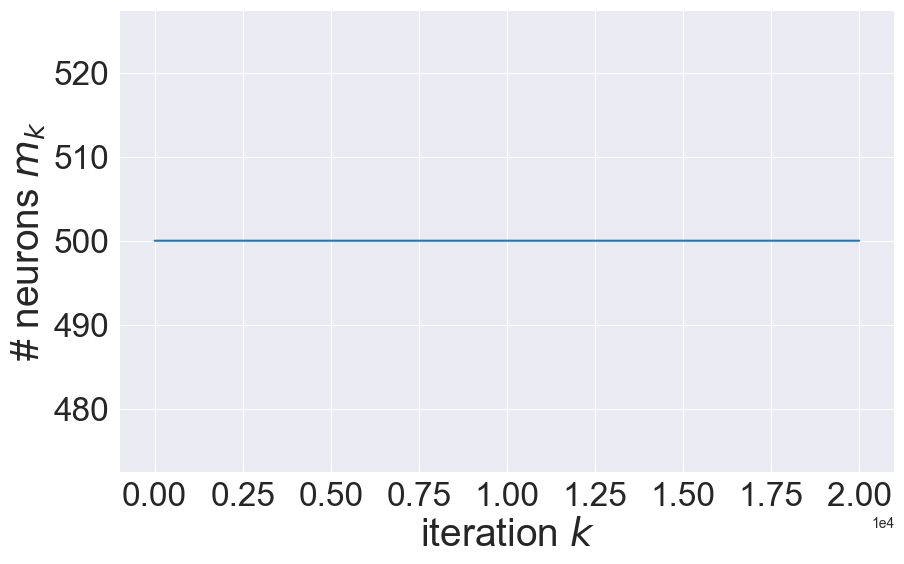

In [20]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

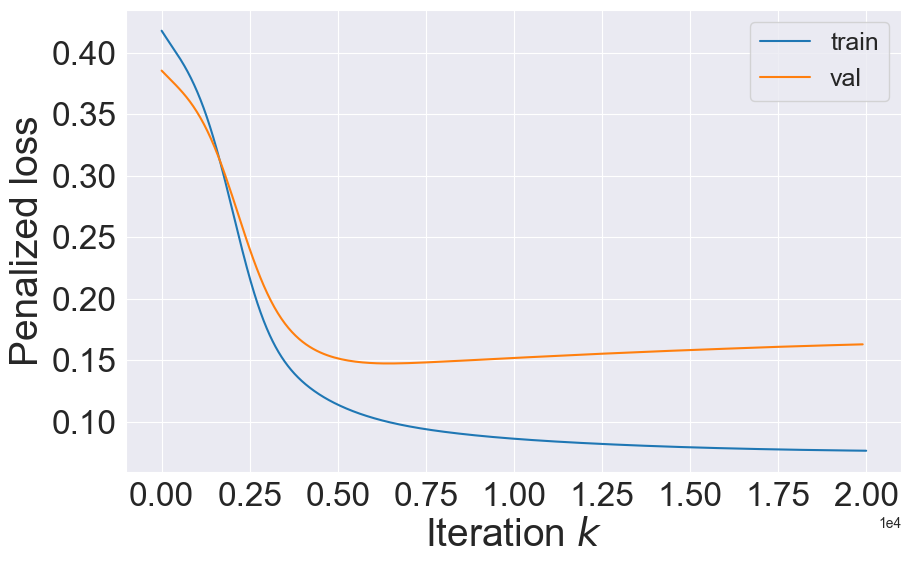

In [21]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses)), penalized_train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

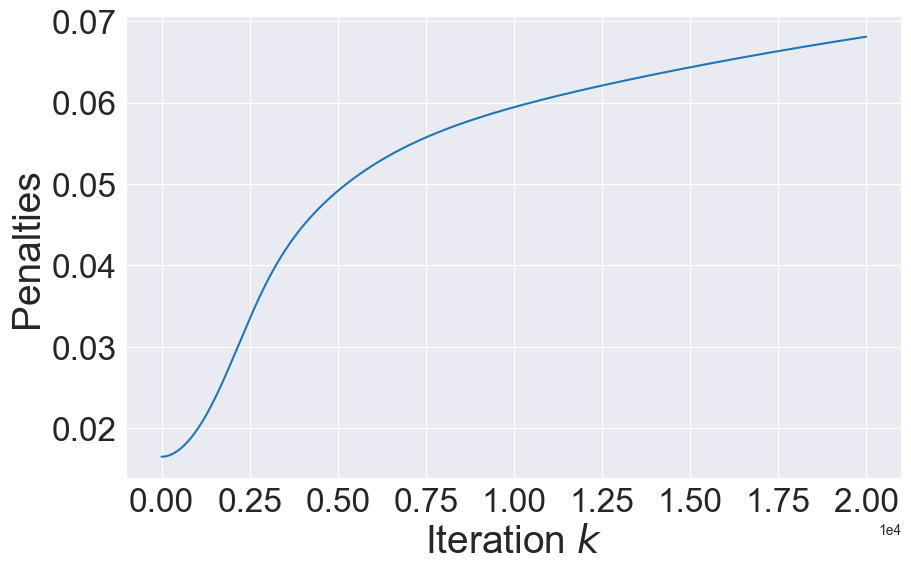

In [22]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses - train_losses

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

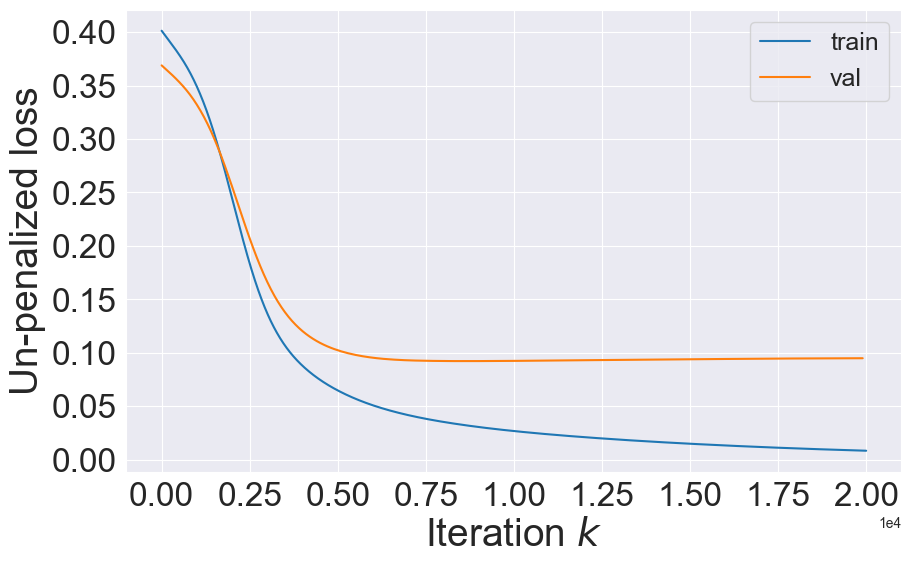

In [23]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 2. Projected conic descent v1

In [24]:
n_steps = int(1.0e5)
m = 500
ETA = 0.01

In [25]:
def projected_conic_particle_update(a, b, x, y):
    m = a.shape[1]
    if m > 0:
        a = a - ETA * V_grad(a, b, x, y, b).reshape(1, -1) / m
        b = b - m * ETA * nabla_V_grad(a, b, x, y, factor=a)
        
        b_norms = np.linalg.norm(b, ord=2, axis=1, keepdims=True)
        # a = a * b_norms.T
        b = b / b_norms
    return a, b  

In [26]:
def train(m, n_steps, x_train, y_train, x_val, y_val, do_val=True):
    #a = np.zeros(shape=(1, m))
    a = np.random.normal(size=(1, m)) / m
    b = np.random.normal(size=(m, INPUT_DIM))
    b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    b = b / b_norms
    
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    ms = [m]

    for k in tqdm(range(n_steps)):
        a, b = projected_conic_particle_update(a, b, x_train, y_train)
        ms.append(a.shape[1])
        
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [27]:
a, b, ms, train_losses, penalized_train_losses, val_losses, penalized_val_losses = \
    train(m, n_steps, x_train, y_train, x_val, y_val)

  0%|                                                       | 54/100000 [00:00<06:15, 266.27it/s]

m at step 0 : 500
Train loss at step 0 : 0.40105
Validation loss at step 0 : 0.36934


  0%|                                                      | 135/100000 [00:00<06:16, 265.12it/s]

m at step 100 : 500
Train loss at step 100 : 0.39741
Validation loss at step 100 : 0.36716


  0%|▏                                                     | 243/100000 [00:00<06:36, 251.69it/s]

m at step 200 : 500
Train loss at step 200 : 0.39394
Validation loss at step 200 : 0.36505


  0%|▏                                                     | 348/100000 [00:01<06:42, 247.70it/s]

m at step 300 : 500
Train loss at step 300 : 0.39061
Validation loss at step 300 : 0.36300


  0%|▏                                                     | 428/100000 [00:01<06:26, 257.86it/s]

m at step 400 : 500
Train loss at step 400 : 0.38739
Validation loss at step 400 : 0.36098


  1%|▎                                                     | 536/100000 [00:02<06:33, 252.92it/s]

m at step 500 : 500
Train loss at step 500 : 0.38426
Validation loss at step 500 : 0.35900


  1%|▎                                                     | 641/100000 [00:02<06:24, 258.47it/s]

m at step 600 : 500
Train loss at step 600 : 0.38119
Validation loss at step 600 : 0.35706


  1%|▍                                                     | 748/100000 [00:02<06:21, 259.93it/s]

m at step 700 : 500
Train loss at step 700 : 0.37816
Validation loss at step 700 : 0.35512


  1%|▍                                                     | 829/100000 [00:03<06:18, 262.23it/s]

m at step 800 : 500
Train loss at step 800 : 0.37516
Validation loss at step 800 : 0.35321


  1%|▌                                                     | 937/100000 [00:03<06:16, 263.31it/s]

m at step 900 : 500
Train loss at step 900 : 0.37218
Validation loss at step 900 : 0.35131


  1%|▌                                                    | 1045/100000 [00:04<06:13, 264.62it/s]

m at step 1,000 : 500
Train loss at step 1,000 : 0.36922
Validation loss at step 1,000 : 0.34942


  1%|▌                                                    | 1153/100000 [00:04<06:14, 263.81it/s]

m at step 1,100 : 500
Train loss at step 1,100 : 0.36627
Validation loss at step 1,100 : 0.34754


  1%|▋                                                    | 1235/100000 [00:04<06:12, 265.32it/s]

m at step 1,200 : 500
Train loss at step 1,200 : 0.36334
Validation loss at step 1,200 : 0.34567


  1%|▋                                                    | 1343/100000 [00:05<06:11, 265.24it/s]

m at step 1,300 : 500
Train loss at step 1,300 : 0.36040
Validation loss at step 1,300 : 0.34381


  1%|▊                                                    | 1451/100000 [00:05<06:13, 263.83it/s]

m at step 1,400 : 500
Train loss at step 1,400 : 0.35747
Validation loss at step 1,400 : 0.34195


  2%|▊                                                    | 1532/100000 [00:05<06:15, 262.26it/s]

m at step 1,500 : 500
Train loss at step 1,500 : 0.35454
Validation loss at step 1,500 : 0.34008


  2%|▊                                                    | 1612/100000 [00:06<09:53, 165.83it/s]

m at step 1,600 : 500
Train loss at step 1,600 : 0.35162
Validation loss at step 1,600 : 0.33821


  2%|▉                                                    | 1741/100000 [00:06<06:56, 235.77it/s]

m at step 1,700 : 500
Train loss at step 1,700 : 0.34870
Validation loss at step 1,700 : 0.33633


  2%|▉                                                    | 1847/100000 [00:07<06:24, 255.35it/s]

m at step 1,800 : 500
Train loss at step 1,800 : 0.34578
Validation loss at step 1,800 : 0.33445


  2%|█                                                    | 1954/100000 [00:07<06:13, 262.85it/s]

m at step 1,900 : 500
Train loss at step 1,900 : 0.34287
Validation loss at step 1,900 : 0.33257


  2%|█                                                    | 2035/100000 [00:08<06:08, 265.72it/s]

m at step 2,000 : 500
Train loss at step 2,000 : 0.33997
Validation loss at step 2,000 : 0.33070


  2%|█▏                                                   | 2145/100000 [00:08<06:08, 265.24it/s]

m at step 2,100 : 500
Train loss at step 2,100 : 0.33708
Validation loss at step 2,100 : 0.32883


  2%|█▏                                                   | 2253/100000 [00:08<06:06, 266.42it/s]

m at step 2,200 : 500
Train loss at step 2,200 : 0.33421
Validation loss at step 2,200 : 0.32697


  2%|█▏                                                   | 2334/100000 [00:09<06:11, 262.60it/s]

m at step 2,300 : 500
Train loss at step 2,300 : 0.33135
Validation loss at step 2,300 : 0.32510


  2%|█▎                                                   | 2441/100000 [00:09<06:16, 258.82it/s]

m at step 2,400 : 500
Train loss at step 2,400 : 0.32851
Validation loss at step 2,400 : 0.32325


  3%|█▎                                                   | 2550/100000 [00:09<06:06, 266.10it/s]

m at step 2,500 : 500
Train loss at step 2,500 : 0.32568
Validation loss at step 2,500 : 0.32140


  3%|█▍                                                   | 2631/100000 [00:10<06:17, 258.10it/s]

m at step 2,600 : 500
Train loss at step 2,600 : 0.32287
Validation loss at step 2,600 : 0.31956


  3%|█▍                                                   | 2739/100000 [00:10<06:09, 263.06it/s]

m at step 2,700 : 500
Train loss at step 2,700 : 0.32007
Validation loss at step 2,700 : 0.31772


  3%|█▌                                                   | 2847/100000 [00:11<06:06, 265.02it/s]

m at step 2,800 : 500
Train loss at step 2,800 : 0.31730
Validation loss at step 2,800 : 0.31588


  3%|█▌                                                   | 2928/100000 [00:11<06:06, 265.03it/s]

m at step 2,900 : 500
Train loss at step 2,900 : 0.31454
Validation loss at step 2,900 : 0.31405


  3%|█▌                                                   | 3035/100000 [00:11<06:19, 255.29it/s]

m at step 3,000 : 500
Train loss at step 3,000 : 0.31180
Validation loss at step 3,000 : 0.31222


  3%|█▋                                                   | 3144/100000 [00:12<06:08, 263.06it/s]

m at step 3,100 : 500
Train loss at step 3,100 : 0.30909
Validation loss at step 3,100 : 0.31040


  3%|█▋                                                   | 3252/100000 [00:12<06:09, 262.19it/s]

m at step 3,200 : 500
Train loss at step 3,200 : 0.30640
Validation loss at step 3,200 : 0.30860


  3%|█▊                                                   | 3332/100000 [00:12<06:13, 259.14it/s]

m at step 3,300 : 500
Train loss at step 3,300 : 0.30374
Validation loss at step 3,300 : 0.30681


  3%|█▊                                                   | 3439/100000 [00:13<06:08, 261.89it/s]

m at step 3,400 : 500
Train loss at step 3,400 : 0.30111
Validation loss at step 3,400 : 0.30504


  4%|█▉                                                   | 3548/100000 [00:13<06:02, 266.16it/s]

m at step 3,500 : 500
Train loss at step 3,500 : 0.29850
Validation loss at step 3,500 : 0.30327


  4%|█▉                                                   | 3630/100000 [00:14<05:59, 267.87it/s]

m at step 3,600 : 500
Train loss at step 3,600 : 0.29592
Validation loss at step 3,600 : 0.30152


  4%|█▉                                                   | 3739/100000 [00:14<06:02, 265.56it/s]

m at step 3,700 : 500
Train loss at step 3,700 : 0.29337
Validation loss at step 3,700 : 0.29978


  4%|██                                                   | 3847/100000 [00:14<06:13, 257.42it/s]

m at step 3,800 : 500
Train loss at step 3,800 : 0.29084
Validation loss at step 3,800 : 0.29805


  4%|██                                                   | 3929/100000 [00:15<06:05, 263.20it/s]

m at step 3,900 : 500
Train loss at step 3,900 : 0.28833
Validation loss at step 3,900 : 0.29632


  4%|██▏                                                  | 4037/100000 [00:15<06:17, 254.44it/s]

m at step 4,000 : 500
Train loss at step 4,000 : 0.28585
Validation loss at step 4,000 : 0.29461


  4%|██▏                                                  | 4144/100000 [00:16<06:06, 261.19it/s]

m at step 4,100 : 500
Train loss at step 4,100 : 0.28340
Validation loss at step 4,100 : 0.29291


  4%|██▏                                                  | 4225/100000 [00:16<06:35, 242.27it/s]

m at step 4,200 : 500
Train loss at step 4,200 : 0.28099
Validation loss at step 4,200 : 0.29123


  4%|██▎                                                  | 4351/100000 [00:17<06:57, 229.15it/s]

m at step 4,300 : 500
Train loss at step 4,300 : 0.27859
Validation loss at step 4,300 : 0.28956


  4%|██▎                                                  | 4431/100000 [00:17<06:18, 252.43it/s]

m at step 4,400 : 500
Train loss at step 4,400 : 0.27623
Validation loss at step 4,400 : 0.28790


  5%|██▍                                                  | 4540/100000 [00:17<06:00, 264.52it/s]

m at step 4,500 : 500
Train loss at step 4,500 : 0.27390
Validation loss at step 4,500 : 0.28626


  5%|██▍                                                  | 4649/100000 [00:18<05:56, 267.21it/s]

m at step 4,600 : 500
Train loss at step 4,600 : 0.27160
Validation loss at step 4,600 : 0.28463


  5%|██▌                                                  | 4730/100000 [00:18<06:06, 259.84it/s]

m at step 4,700 : 500
Train loss at step 4,700 : 0.26933
Validation loss at step 4,700 : 0.28301


  5%|██▌                                                  | 4838/100000 [00:18<06:06, 259.87it/s]

m at step 4,800 : 500
Train loss at step 4,800 : 0.26708
Validation loss at step 4,800 : 0.28141


  5%|██▌                                                  | 4943/100000 [00:19<06:30, 243.60it/s]

m at step 4,900 : 500
Train loss at step 4,900 : 0.26486
Validation loss at step 4,900 : 0.27981


  5%|██▋                                                  | 5048/100000 [00:19<06:14, 253.35it/s]

m at step 5,000 : 500
Train loss at step 5,000 : 0.26267
Validation loss at step 5,000 : 0.27822


  5%|██▋                                                  | 5128/100000 [00:20<06:05, 259.72it/s]

m at step 5,100 : 500
Train loss at step 5,100 : 0.26050
Validation loss at step 5,100 : 0.27665


  5%|██▊                                                  | 5236/100000 [00:20<06:02, 261.54it/s]

m at step 5,200 : 500
Train loss at step 5,200 : 0.25837
Validation loss at step 5,200 : 0.27509


  5%|██▊                                                  | 5344/100000 [00:20<06:11, 254.64it/s]

m at step 5,300 : 500
Train loss at step 5,300 : 0.25625
Validation loss at step 5,300 : 0.27354


  5%|██▉                                                  | 5452/100000 [00:21<06:06, 257.91it/s]

m at step 5,400 : 500
Train loss at step 5,400 : 0.25417
Validation loss at step 5,400 : 0.27201


  6%|██▉                                                  | 5533/100000 [00:21<06:03, 260.00it/s]

m at step 5,500 : 500
Train loss at step 5,500 : 0.25211
Validation loss at step 5,500 : 0.27049


  6%|██▉                                                  | 5640/100000 [00:22<06:02, 260.39it/s]

m at step 5,600 : 500
Train loss at step 5,600 : 0.25008
Validation loss at step 5,600 : 0.26898


  6%|███                                                  | 5746/100000 [00:22<06:09, 254.93it/s]

m at step 5,700 : 500
Train loss at step 5,700 : 0.24807
Validation loss at step 5,700 : 0.26749


  6%|███                                                  | 5853/100000 [00:22<06:02, 259.99it/s]

m at step 5,800 : 500
Train loss at step 5,800 : 0.24609
Validation loss at step 5,800 : 0.26601


  6%|███▏                                                 | 5933/100000 [00:23<06:00, 260.72it/s]

m at step 5,900 : 500
Train loss at step 5,900 : 0.24413
Validation loss at step 5,900 : 0.26456


  6%|███▏                                                 | 6041/100000 [00:23<05:54, 264.72it/s]

m at step 6,000 : 500
Train loss at step 6,000 : 0.24220
Validation loss at step 6,000 : 0.26312


  6%|███▎                                                 | 6151/100000 [00:24<05:50, 267.40it/s]

m at step 6,100 : 500
Train loss at step 6,100 : 0.24028
Validation loss at step 6,100 : 0.26169


  6%|███▎                                                 | 6233/100000 [00:24<05:50, 267.32it/s]

m at step 6,200 : 500
Train loss at step 6,200 : 0.23839
Validation loss at step 6,200 : 0.26027


  6%|███▎                                                 | 6341/100000 [00:24<05:52, 265.96it/s]

m at step 6,300 : 500
Train loss at step 6,300 : 0.23651
Validation loss at step 6,300 : 0.25886


  6%|███▍                                                 | 6450/100000 [00:25<05:50, 266.69it/s]

m at step 6,400 : 500
Train loss at step 6,400 : 0.23467
Validation loss at step 6,400 : 0.25746


  7%|███▍                                                 | 6531/100000 [00:25<05:53, 264.72it/s]

m at step 6,500 : 500
Train loss at step 6,500 : 0.23284
Validation loss at step 6,500 : 0.25608


  7%|███▌                                                 | 6639/100000 [00:25<05:54, 263.01it/s]

m at step 6,600 : 500
Train loss at step 6,600 : 0.23103
Validation loss at step 6,600 : 0.25471


  7%|███▌                                                 | 6747/100000 [00:26<05:55, 262.39it/s]

m at step 6,700 : 500
Train loss at step 6,700 : 0.22925
Validation loss at step 6,700 : 0.25335


  7%|███▌                                                 | 6828/100000 [00:26<06:03, 256.61it/s]

m at step 6,800 : 500
Train loss at step 6,800 : 0.22749
Validation loss at step 6,800 : 0.25201


  7%|███▋                                                 | 6952/100000 [00:27<06:57, 222.85it/s]

m at step 6,900 : 500
Train loss at step 6,900 : 0.22574
Validation loss at step 6,900 : 0.25067


  7%|███▋                                                 | 7030/100000 [00:27<06:30, 238.21it/s]

m at step 7,000 : 500
Train loss at step 7,000 : 0.22402
Validation loss at step 7,000 : 0.24934


  7%|███▊                                                 | 7134/100000 [00:27<06:08, 251.94it/s]

m at step 7,100 : 500
Train loss at step 7,100 : 0.22231
Validation loss at step 7,100 : 0.24803


  7%|███▊                                                 | 7241/100000 [00:28<05:56, 259.89it/s]

m at step 7,200 : 500
Train loss at step 7,200 : 0.22062
Validation loss at step 7,200 : 0.24673


  7%|███▉                                                 | 7349/100000 [00:28<06:05, 253.37it/s]

m at step 7,300 : 500
Train loss at step 7,300 : 0.21895
Validation loss at step 7,300 : 0.24544


  7%|███▉                                                 | 7430/100000 [00:29<06:21, 242.41it/s]

m at step 7,400 : 500
Train loss at step 7,400 : 0.21731
Validation loss at step 7,400 : 0.24415


  8%|███▉                                                 | 7538/100000 [00:29<05:55, 259.77it/s]

m at step 7,500 : 500
Train loss at step 7,500 : 0.21568
Validation loss at step 7,500 : 0.24288


  8%|████                                                 | 7646/100000 [00:29<05:52, 261.72it/s]

m at step 7,600 : 500
Train loss at step 7,600 : 0.21406
Validation loss at step 7,600 : 0.24163


  8%|████                                                 | 7726/100000 [00:30<06:01, 254.96it/s]

m at step 7,700 : 500
Train loss at step 7,700 : 0.21247
Validation loss at step 7,700 : 0.24038


  8%|████▏                                                | 7834/100000 [00:30<05:52, 261.45it/s]

m at step 7,800 : 500
Train loss at step 7,800 : 0.21089
Validation loss at step 7,800 : 0.23914


  8%|████▏                                                | 7944/100000 [00:31<05:45, 266.28it/s]

m at step 7,900 : 500
Train loss at step 7,900 : 0.20934
Validation loss at step 7,900 : 0.23792


  8%|████▎                                                | 8053/100000 [00:31<05:46, 265.19it/s]

m at step 8,000 : 500
Train loss at step 8,000 : 0.20780
Validation loss at step 8,000 : 0.23670


  8%|████▎                                                | 8134/100000 [00:31<05:48, 263.73it/s]

m at step 8,100 : 500
Train loss at step 8,100 : 0.20628
Validation loss at step 8,100 : 0.23550


  8%|████▎                                                | 8242/100000 [00:32<05:48, 263.37it/s]

m at step 8,200 : 500
Train loss at step 8,200 : 0.20478
Validation loss at step 8,200 : 0.23430


  8%|████▍                                                | 8351/100000 [00:32<05:43, 266.71it/s]

m at step 8,300 : 500
Train loss at step 8,300 : 0.20329
Validation loss at step 8,300 : 0.23311


  8%|████▍                                                | 8432/100000 [00:32<05:43, 266.35it/s]

m at step 8,400 : 500
Train loss at step 8,400 : 0.20182
Validation loss at step 8,400 : 0.23194


  9%|████▌                                                | 8541/100000 [00:33<05:41, 267.46it/s]

m at step 8,500 : 500
Train loss at step 8,500 : 0.20037
Validation loss at step 8,500 : 0.23079


  9%|████▌                                                | 8649/100000 [00:33<05:42, 266.98it/s]

m at step 8,600 : 500
Train loss at step 8,600 : 0.19893
Validation loss at step 8,600 : 0.22964


  9%|████▋                                                | 8730/100000 [00:34<05:47, 262.29it/s]

m at step 8,700 : 500
Train loss at step 8,700 : 0.19751
Validation loss at step 8,700 : 0.22851


  9%|████▋                                                | 8838/100000 [00:34<05:54, 257.00it/s]

m at step 8,800 : 500
Train loss at step 8,800 : 0.19611
Validation loss at step 8,800 : 0.22739


  9%|████▋                                                | 8946/100000 [00:34<05:46, 263.01it/s]

m at step 8,900 : 500
Train loss at step 8,900 : 0.19472
Validation loss at step 8,900 : 0.22628


  9%|████▊                                                | 9028/100000 [00:35<05:43, 264.92it/s]

m at step 9,000 : 500
Train loss at step 9,000 : 0.19335
Validation loss at step 9,000 : 0.22519


  9%|████▊                                                | 9136/100000 [00:35<05:44, 264.10it/s]

m at step 9,100 : 500
Train loss at step 9,100 : 0.19200
Validation loss at step 9,100 : 0.22410


  9%|████▉                                                | 9245/100000 [00:36<05:39, 267.30it/s]

m at step 9,200 : 500
Train loss at step 9,200 : 0.19066
Validation loss at step 9,200 : 0.22303


  9%|████▉                                                | 9353/100000 [00:36<05:39, 267.10it/s]

m at step 9,300 : 500
Train loss at step 9,300 : 0.18933
Validation loss at step 9,300 : 0.22197


  9%|█████                                                | 9434/100000 [00:36<05:39, 266.43it/s]

m at step 9,400 : 500
Train loss at step 9,400 : 0.18802
Validation loss at step 9,400 : 0.22091


 10%|█████                                                | 9538/100000 [00:37<07:47, 193.62it/s]

m at step 9,500 : 500
Train loss at step 9,500 : 0.18672
Validation loss at step 9,500 : 0.21987


 10%|█████                                                | 9646/100000 [00:37<06:08, 245.01it/s]

m at step 9,600 : 500
Train loss at step 9,600 : 0.18544
Validation loss at step 9,600 : 0.21884


 10%|█████▏                                               | 9755/100000 [00:38<05:43, 262.53it/s]

m at step 9,700 : 500
Train loss at step 9,700 : 0.18417
Validation loss at step 9,700 : 0.21782


 10%|█████▏                                               | 9836/100000 [00:38<05:53, 255.28it/s]

m at step 9,800 : 500
Train loss at step 9,800 : 0.18292
Validation loss at step 9,800 : 0.21681


 10%|█████▎                                               | 9944/100000 [00:38<05:43, 262.15it/s]

m at step 9,900 : 500
Train loss at step 9,900 : 0.18168
Validation loss at step 9,900 : 0.21580


 10%|█████▏                                              | 10054/100000 [00:39<05:37, 266.82it/s]

m at step 10,000 : 500
Train loss at step 10,000 : 0.18046
Validation loss at step 10,000 : 0.21480


 10%|█████▎                                              | 10135/100000 [00:39<05:40, 263.68it/s]

m at step 10,100 : 500
Train loss at step 10,100 : 0.17924
Validation loss at step 10,100 : 0.21381


 10%|█████▎                                              | 10243/100000 [00:40<05:37, 266.00it/s]

m at step 10,200 : 500
Train loss at step 10,200 : 0.17805
Validation loss at step 10,200 : 0.21283


 10%|█████▍                                              | 10353/100000 [00:40<05:36, 266.10it/s]

m at step 10,300 : 500
Train loss at step 10,300 : 0.17686
Validation loss at step 10,300 : 0.21186


 10%|█████▍                                              | 10434/100000 [00:40<05:37, 265.30it/s]

m at step 10,400 : 500
Train loss at step 10,400 : 0.17569
Validation loss at step 10,400 : 0.21090


 11%|█████▍                                              | 10544/100000 [00:41<05:34, 267.61it/s]

m at step 10,500 : 500
Train loss at step 10,500 : 0.17452
Validation loss at step 10,500 : 0.20995


 11%|█████▌                                              | 10652/100000 [00:41<05:33, 267.66it/s]

m at step 10,600 : 500
Train loss at step 10,600 : 0.17338
Validation loss at step 10,600 : 0.20901


 11%|█████▌                                              | 10733/100000 [00:41<05:34, 266.52it/s]

m at step 10,700 : 500
Train loss at step 10,700 : 0.17224
Validation loss at step 10,700 : 0.20807


 11%|█████▋                                              | 10841/100000 [00:42<05:39, 262.31it/s]

m at step 10,800 : 500
Train loss at step 10,800 : 0.17112
Validation loss at step 10,800 : 0.20714


 11%|█████▋                                              | 10950/100000 [00:42<05:42, 259.85it/s]

m at step 10,900 : 500
Train loss at step 10,900 : 0.17001
Validation loss at step 10,900 : 0.20622


 11%|█████▋                                              | 11031/100000 [00:42<05:38, 263.13it/s]

m at step 11,000 : 500
Train loss at step 11,000 : 0.16891
Validation loss at step 11,000 : 0.20531


 11%|█████▊                                              | 11140/100000 [00:43<05:34, 265.69it/s]

m at step 11,100 : 500
Train loss at step 11,100 : 0.16782
Validation loss at step 11,100 : 0.20440


 11%|█████▊                                              | 11249/100000 [00:43<05:33, 266.24it/s]

m at step 11,200 : 500
Train loss at step 11,200 : 0.16674
Validation loss at step 11,200 : 0.20350


 11%|█████▉                                              | 11330/100000 [00:44<05:35, 263.93it/s]

m at step 11,300 : 500
Train loss at step 11,300 : 0.16568
Validation loss at step 11,300 : 0.20261


 11%|█████▉                                              | 11439/100000 [00:44<05:33, 265.92it/s]

m at step 11,400 : 500
Train loss at step 11,400 : 0.16462
Validation loss at step 11,400 : 0.20173


 12%|██████                                              | 11546/100000 [00:44<05:40, 260.02it/s]

m at step 11,500 : 500
Train loss at step 11,500 : 0.16358
Validation loss at step 11,500 : 0.20086


 12%|██████                                              | 11628/100000 [00:45<05:34, 264.49it/s]

m at step 11,600 : 500
Train loss at step 11,600 : 0.16255
Validation loss at step 11,600 : 0.20000


 12%|██████                                              | 11736/100000 [00:45<05:32, 265.70it/s]

m at step 11,700 : 500
Train loss at step 11,700 : 0.16153
Validation loss at step 11,700 : 0.19915


 12%|██████▏                                             | 11843/100000 [00:46<05:45, 255.47it/s]

m at step 11,800 : 500
Train loss at step 11,800 : 0.16052
Validation loss at step 11,800 : 0.19830


 12%|██████▏                                             | 11948/100000 [00:46<05:48, 252.64it/s]

m at step 11,900 : 500
Train loss at step 11,900 : 0.15952
Validation loss at step 11,900 : 0.19747


 12%|██████▎                                             | 12028/100000 [00:46<05:43, 256.06it/s]

m at step 12,000 : 500
Train loss at step 12,000 : 0.15852
Validation loss at step 12,000 : 0.19663


 12%|██████▎                                             | 12136/100000 [00:47<05:53, 248.75it/s]

m at step 12,100 : 500
Train loss at step 12,100 : 0.15754
Validation loss at step 12,100 : 0.19580


 12%|██████▎                                             | 12243/100000 [00:47<06:34, 222.28it/s]

m at step 12,200 : 500
Train loss at step 12,200 : 0.15656
Validation loss at step 12,200 : 0.19498


 12%|██████▍                                             | 12351/100000 [00:48<05:43, 254.98it/s]

m at step 12,300 : 500
Train loss at step 12,300 : 0.15560
Validation loss at step 12,300 : 0.19417


 12%|██████▍                                             | 12433/100000 [00:48<05:34, 261.49it/s]

m at step 12,400 : 500
Train loss at step 12,400 : 0.15464
Validation loss at step 12,400 : 0.19336


 13%|██████▌                                             | 12541/100000 [00:48<05:28, 266.33it/s]

m at step 12,500 : 500
Train loss at step 12,500 : 0.15370
Validation loss at step 12,500 : 0.19256


 13%|██████▌                                             | 12644/100000 [00:49<06:30, 223.92it/s]

m at step 12,600 : 500
Train loss at step 12,600 : 0.15276
Validation loss at step 12,600 : 0.19176


 13%|██████▋                                             | 12750/100000 [00:49<05:47, 251.30it/s]

m at step 12,700 : 500
Train loss at step 12,700 : 0.15184
Validation loss at step 12,700 : 0.19097


 13%|██████▋                                             | 12830/100000 [00:50<05:35, 259.70it/s]

m at step 12,800 : 500
Train loss at step 12,800 : 0.15092
Validation loss at step 12,800 : 0.19019


 13%|██████▋                                             | 12938/100000 [00:50<05:31, 262.97it/s]

m at step 12,900 : 500
Train loss at step 12,900 : 0.15001
Validation loss at step 12,900 : 0.18942


 13%|██████▊                                             | 13046/100000 [00:51<06:01, 240.75it/s]

m at step 13,000 : 500
Train loss at step 13,000 : 0.14911
Validation loss at step 13,000 : 0.18866


 13%|██████▊                                             | 13152/100000 [00:51<05:41, 254.31it/s]

m at step 13,100 : 500
Train loss at step 13,100 : 0.14822
Validation loss at step 13,100 : 0.18791


 13%|██████▉                                             | 13233/100000 [00:51<05:30, 262.30it/s]

m at step 13,200 : 500
Train loss at step 13,200 : 0.14734
Validation loss at step 13,200 : 0.18716


 13%|██████▉                                             | 13341/100000 [00:52<05:33, 259.66it/s]

m at step 13,300 : 500
Train loss at step 13,300 : 0.14647
Validation loss at step 13,300 : 0.18641


 13%|██████▉                                             | 13448/100000 [00:52<05:30, 261.55it/s]

m at step 13,400 : 500
Train loss at step 13,400 : 0.14560
Validation loss at step 13,400 : 0.18567


 14%|███████                                             | 13529/100000 [00:52<05:26, 264.68it/s]

m at step 13,500 : 500
Train loss at step 13,500 : 0.14475
Validation loss at step 13,500 : 0.18494


 14%|███████                                             | 13637/100000 [00:53<05:25, 265.02it/s]

m at step 13,600 : 500
Train loss at step 13,600 : 0.14390
Validation loss at step 13,600 : 0.18421


 14%|███████▏                                            | 13746/100000 [00:53<05:22, 267.43it/s]

m at step 13,700 : 500
Train loss at step 13,700 : 0.14305
Validation loss at step 13,700 : 0.18349


 14%|███████▏                                            | 13855/100000 [00:54<05:21, 267.85it/s]

m at step 13,800 : 500
Train loss at step 13,800 : 0.14222
Validation loss at step 13,800 : 0.18278


 14%|███████▏                                            | 13936/100000 [00:54<05:23, 265.98it/s]

m at step 13,900 : 500
Train loss at step 13,900 : 0.14140
Validation loss at step 13,900 : 0.18208


 14%|███████▎                                            | 14045/100000 [00:54<05:29, 261.24it/s]

m at step 14,000 : 500
Train loss at step 14,000 : 0.14058
Validation loss at step 14,000 : 0.18138


 14%|███████▎                                            | 14153/100000 [00:55<05:26, 262.99it/s]

m at step 14,100 : 500
Train loss at step 14,100 : 0.13977
Validation loss at step 14,100 : 0.18069


 14%|███████▍                                            | 14234/100000 [00:55<05:24, 264.19it/s]

m at step 14,200 : 500
Train loss at step 14,200 : 0.13897
Validation loss at step 14,200 : 0.18000


 14%|███████▍                                            | 14340/100000 [00:55<05:34, 255.78it/s]

m at step 14,300 : 500
Train loss at step 14,300 : 0.13817
Validation loss at step 14,300 : 0.17932


 14%|███████▌                                            | 14449/100000 [00:56<05:22, 265.38it/s]

m at step 14,400 : 500
Train loss at step 14,400 : 0.13738
Validation loss at step 14,400 : 0.17864


 15%|███████▌                                            | 14530/100000 [00:56<05:23, 264.38it/s]

m at step 14,500 : 500
Train loss at step 14,500 : 0.13660
Validation loss at step 14,500 : 0.17797


 15%|███████▌                                            | 14639/100000 [00:57<05:19, 267.01it/s]

m at step 14,600 : 500
Train loss at step 14,600 : 0.13583
Validation loss at step 14,600 : 0.17731


 15%|███████▋                                            | 14747/100000 [00:57<05:22, 264.71it/s]

m at step 14,700 : 500
Train loss at step 14,700 : 0.13507
Validation loss at step 14,700 : 0.17666


 15%|███████▋                                            | 14828/100000 [00:57<05:56, 238.97it/s]

m at step 14,800 : 500
Train loss at step 14,800 : 0.13431
Validation loss at step 14,800 : 0.17600


 15%|███████▊                                            | 14928/100000 [00:58<06:34, 215.91it/s]

m at step 14,900 : 500
Train loss at step 14,900 : 0.13355
Validation loss at step 14,900 : 0.17534


 15%|███████▊                                            | 15035/100000 [00:58<05:42, 247.83it/s]

m at step 15,000 : 500
Train loss at step 15,000 : 0.13280
Validation loss at step 15,000 : 0.17469


 15%|███████▊                                            | 15142/100000 [00:59<05:57, 237.56it/s]

m at step 15,100 : 500
Train loss at step 15,100 : 0.13206
Validation loss at step 15,100 : 0.17404


 15%|███████▉                                            | 15251/100000 [00:59<05:27, 259.14it/s]

m at step 15,200 : 500
Train loss at step 15,200 : 0.13132
Validation loss at step 15,200 : 0.17340


 15%|███████▉                                            | 15333/100000 [00:59<05:20, 264.39it/s]

m at step 15,300 : 500
Train loss at step 15,300 : 0.13059
Validation loss at step 15,300 : 0.17277


 15%|████████                                            | 15444/100000 [01:00<05:11, 271.27it/s]

m at step 15,400 : 500
Train loss at step 15,400 : 0.12987
Validation loss at step 15,400 : 0.17215


 16%|████████                                            | 15556/100000 [01:00<05:12, 270.57it/s]

m at step 15,500 : 500
Train loss at step 15,500 : 0.12915
Validation loss at step 15,500 : 0.17153


 16%|████████▏                                           | 15639/100000 [01:01<05:17, 266.01it/s]

m at step 15,600 : 500
Train loss at step 15,600 : 0.12844
Validation loss at step 15,600 : 0.17091


 16%|████████▏                                           | 15749/100000 [01:01<05:12, 269.50it/s]

m at step 15,700 : 500
Train loss at step 15,700 : 0.12774
Validation loss at step 15,700 : 0.17030


 16%|████████▏                                           | 15832/100000 [01:01<05:11, 269.80it/s]

m at step 15,800 : 500
Train loss at step 15,800 : 0.12704
Validation loss at step 15,800 : 0.16970


 16%|████████▎                                           | 15943/100000 [01:02<05:08, 272.15it/s]

m at step 15,900 : 500
Train loss at step 15,900 : 0.12635
Validation loss at step 15,900 : 0.16911


 16%|████████▎                                           | 16054/100000 [01:02<05:12, 268.62it/s]

m at step 16,000 : 500
Train loss at step 16,000 : 0.12567
Validation loss at step 16,000 : 0.16853


 16%|████████▍                                           | 16136/100000 [01:02<05:16, 265.10it/s]

m at step 16,100 : 500
Train loss at step 16,100 : 0.12499
Validation loss at step 16,100 : 0.16795


 16%|████████▍                                           | 16246/100000 [01:03<05:11, 269.06it/s]

m at step 16,200 : 500
Train loss at step 16,200 : 0.12432
Validation loss at step 16,200 : 0.16737


 16%|████████▍                                           | 16329/100000 [01:03<05:10, 269.20it/s]

m at step 16,300 : 500
Train loss at step 16,300 : 0.12365
Validation loss at step 16,300 : 0.16681


 16%|████████▌                                           | 16440/100000 [01:04<05:07, 272.16it/s]

m at step 16,400 : 500
Train loss at step 16,400 : 0.12299
Validation loss at step 16,400 : 0.16624


 17%|████████▌                                           | 16552/100000 [01:04<05:08, 270.58it/s]

m at step 16,500 : 500
Train loss at step 16,500 : 0.12233
Validation loss at step 16,500 : 0.16567


 17%|████████▋                                           | 16635/100000 [01:04<05:08, 269.95it/s]

m at step 16,600 : 500
Train loss at step 16,600 : 0.12168
Validation loss at step 16,600 : 0.16511


 17%|████████▋                                           | 16744/100000 [01:05<05:08, 269.52it/s]

m at step 16,700 : 500
Train loss at step 16,700 : 0.12104
Validation loss at step 16,700 : 0.16455


 17%|████████▊                                           | 16852/100000 [01:05<05:10, 267.44it/s]

m at step 16,800 : 500
Train loss at step 16,800 : 0.12040
Validation loss at step 16,800 : 0.16400


 17%|████████▊                                           | 16934/100000 [01:05<05:10, 267.57it/s]

m at step 16,900 : 500
Train loss at step 16,900 : 0.11976
Validation loss at step 16,900 : 0.16345


 17%|████████▊                                           | 17044/100000 [01:06<05:07, 269.98it/s]

m at step 17,000 : 500
Train loss at step 17,000 : 0.11913
Validation loss at step 17,000 : 0.16291


 17%|████████▉                                           | 17154/100000 [01:06<05:07, 269.12it/s]

m at step 17,100 : 500
Train loss at step 17,100 : 0.11851
Validation loss at step 17,100 : 0.16237


 17%|████████▉                                           | 17236/100000 [01:07<05:11, 265.76it/s]

m at step 17,200 : 500
Train loss at step 17,200 : 0.11789
Validation loss at step 17,200 : 0.16183


 17%|█████████                                           | 17345/100000 [01:07<05:12, 264.76it/s]

m at step 17,300 : 500
Train loss at step 17,300 : 0.11727
Validation loss at step 17,300 : 0.16130


 17%|█████████                                           | 17454/100000 [01:07<05:09, 266.61it/s]

m at step 17,400 : 500
Train loss at step 17,400 : 0.11666
Validation loss at step 17,400 : 0.16078


 18%|█████████                                           | 17535/100000 [01:08<05:12, 264.29it/s]

m at step 17,500 : 500
Train loss at step 17,500 : 0.11606
Validation loss at step 17,500 : 0.16027


 18%|█████████▏                                          | 17640/100000 [01:08<06:31, 210.45it/s]

m at step 17,600 : 500
Train loss at step 17,600 : 0.11546
Validation loss at step 17,600 : 0.15976


 18%|█████████▏                                          | 17750/100000 [01:09<05:22, 254.75it/s]

m at step 17,700 : 500
Train loss at step 17,700 : 0.11487
Validation loss at step 17,700 : 0.15926


 18%|█████████▎                                          | 17832/100000 [01:09<05:12, 263.10it/s]

m at step 17,800 : 500
Train loss at step 17,800 : 0.11428
Validation loss at step 17,800 : 0.15876


 18%|█████████▎                                          | 17942/100000 [01:09<05:05, 268.45it/s]

m at step 17,900 : 500
Train loss at step 17,900 : 0.11369
Validation loss at step 17,900 : 0.15826


 18%|█████████▍                                          | 18053/100000 [01:10<05:01, 271.47it/s]

m at step 18,000 : 500
Train loss at step 18,000 : 0.11312
Validation loss at step 18,000 : 0.15777


 18%|█████████▍                                          | 18137/100000 [01:10<05:02, 271.00it/s]

m at step 18,100 : 500
Train loss at step 18,100 : 0.11255
Validation loss at step 18,100 : 0.15730


 18%|█████████▍                                          | 18247/100000 [01:11<05:10, 263.50it/s]

m at step 18,200 : 500
Train loss at step 18,200 : 0.11199
Validation loss at step 18,200 : 0.15682


 18%|█████████▌                                          | 18330/100000 [01:11<05:06, 266.82it/s]

m at step 18,300 : 500
Train loss at step 18,300 : 0.11143
Validation loss at step 18,300 : 0.15634


 18%|█████████▌                                          | 18440/100000 [01:11<05:06, 265.91it/s]

m at step 18,400 : 500
Train loss at step 18,400 : 0.11087
Validation loss at step 18,400 : 0.15587


 19%|█████████▋                                          | 18549/100000 [01:12<05:03, 268.41it/s]

m at step 18,500 : 500
Train loss at step 18,500 : 0.11032
Validation loss at step 18,500 : 0.15540


 19%|█████████▋                                          | 18631/100000 [01:12<05:02, 268.67it/s]

m at step 18,600 : 500
Train loss at step 18,600 : 0.10977
Validation loss at step 18,600 : 0.15493


 19%|█████████▋                                          | 18740/100000 [01:12<05:04, 267.24it/s]

m at step 18,700 : 500
Train loss at step 18,700 : 0.10923
Validation loss at step 18,700 : 0.15447


 19%|█████████▊                                          | 18850/100000 [01:13<05:04, 266.10it/s]

m at step 18,800 : 500
Train loss at step 18,800 : 0.10870
Validation loss at step 18,800 : 0.15402


 19%|█████████▊                                          | 18932/100000 [01:13<05:06, 264.68it/s]

m at step 18,900 : 500
Train loss at step 18,900 : 0.10816
Validation loss at step 18,900 : 0.15356


 19%|█████████▉                                          | 19041/100000 [01:13<04:59, 269.99it/s]

m at step 19,000 : 500
Train loss at step 19,000 : 0.10763
Validation loss at step 19,000 : 0.15311


 19%|█████████▉                                          | 19152/100000 [01:14<05:02, 267.22it/s]

m at step 19,100 : 500
Train loss at step 19,100 : 0.10710
Validation loss at step 19,100 : 0.15267


 19%|██████████                                          | 19233/100000 [01:14<05:02, 267.41it/s]

m at step 19,200 : 500
Train loss at step 19,200 : 0.10658
Validation loss at step 19,200 : 0.15222


 19%|██████████                                          | 19342/100000 [01:15<05:05, 263.71it/s]

m at step 19,300 : 500
Train loss at step 19,300 : 0.10606
Validation loss at step 19,300 : 0.15177


 19%|██████████                                          | 19452/100000 [01:15<05:00, 267.95it/s]

m at step 19,400 : 500
Train loss at step 19,400 : 0.10555
Validation loss at step 19,400 : 0.15134


 20%|██████████▏                                         | 19535/100000 [01:15<04:57, 270.16it/s]

m at step 19,500 : 500
Train loss at step 19,500 : 0.10504
Validation loss at step 19,500 : 0.15091


 20%|██████████▏                                         | 19645/100000 [01:16<05:00, 267.72it/s]

m at step 19,600 : 500
Train loss at step 19,600 : 0.10453
Validation loss at step 19,600 : 0.15047


 20%|██████████▎                                         | 19754/100000 [01:16<05:00, 267.15it/s]

m at step 19,700 : 500
Train loss at step 19,700 : 0.10403
Validation loss at step 19,700 : 0.15005


 20%|██████████▎                                         | 19836/100000 [01:16<04:58, 268.40it/s]

m at step 19,800 : 500
Train loss at step 19,800 : 0.10353
Validation loss at step 19,800 : 0.14963


 20%|██████████▎                                         | 19947/100000 [01:17<04:54, 271.56it/s]

m at step 19,900 : 500
Train loss at step 19,900 : 0.10303
Validation loss at step 19,900 : 0.14922


 20%|██████████▍                                         | 20030/100000 [01:17<04:56, 269.66it/s]

m at step 20,000 : 500
Train loss at step 20,000 : 0.10254
Validation loss at step 20,000 : 0.14881


 20%|██████████▍                                         | 20141/100000 [01:18<04:55, 270.38it/s]

m at step 20,100 : 500
Train loss at step 20,100 : 0.10205
Validation loss at step 20,100 : 0.14842


 20%|██████████▌                                         | 20253/100000 [01:18<04:56, 269.22it/s]

m at step 20,200 : 500
Train loss at step 20,200 : 0.10157
Validation loss at step 20,200 : 0.14802


 20%|██████████▌                                         | 20306/100000 [01:18<06:07, 216.69it/s]

m at step 20,300 : 500
Train loss at step 20,300 : 0.10109
Validation loss at step 20,300 : 0.14762


 20%|██████████▋                                         | 20435/100000 [01:19<05:42, 232.62it/s]

m at step 20,400 : 500
Train loss at step 20,400 : 0.10062
Validation loss at step 20,400 : 0.14723


 21%|██████████▋                                         | 20544/100000 [01:19<05:05, 260.47it/s]

m at step 20,500 : 500
Train loss at step 20,500 : 0.10015
Validation loss at step 20,500 : 0.14684


 21%|██████████▋                                         | 20654/100000 [01:20<04:58, 266.12it/s]

m at step 20,600 : 500
Train loss at step 20,600 : 0.09968
Validation loss at step 20,600 : 0.14645


 21%|██████████▊                                         | 20736/100000 [01:20<04:55, 268.44it/s]

m at step 20,700 : 500
Train loss at step 20,700 : 0.09921
Validation loss at step 20,700 : 0.14606


 21%|██████████▊                                         | 20845/100000 [01:20<05:23, 244.59it/s]

m at step 20,800 : 500
Train loss at step 20,800 : 0.09875
Validation loss at step 20,800 : 0.14567


 21%|██████████▉                                         | 20929/100000 [01:21<05:00, 263.30it/s]

m at step 20,900 : 500
Train loss at step 20,900 : 0.09830
Validation loss at step 20,900 : 0.14528


 21%|██████████▉                                         | 21037/100000 [01:21<04:59, 263.85it/s]

m at step 21,000 : 500
Train loss at step 21,000 : 0.09785
Validation loss at step 21,000 : 0.14490


 21%|██████████▉                                         | 21147/100000 [01:22<04:53, 268.27it/s]

m at step 21,100 : 500
Train loss at step 21,100 : 0.09740
Validation loss at step 21,100 : 0.14453


 21%|███████████                                         | 21230/100000 [01:22<04:51, 270.07it/s]

m at step 21,200 : 500
Train loss at step 21,200 : 0.09695
Validation loss at step 21,200 : 0.14416


 21%|███████████                                         | 21342/100000 [01:22<04:50, 270.36it/s]

m at step 21,300 : 500
Train loss at step 21,300 : 0.09650
Validation loss at step 21,300 : 0.14379


 21%|███████████▏                                        | 21452/100000 [01:23<04:56, 264.55it/s]

m at step 21,400 : 500
Train loss at step 21,400 : 0.09606
Validation loss at step 21,400 : 0.14343


 22%|███████████▏                                        | 21535/100000 [01:23<04:52, 268.64it/s]

m at step 21,500 : 500
Train loss at step 21,500 : 0.09562
Validation loss at step 21,500 : 0.14308


 22%|███████████▎                                        | 21644/100000 [01:23<04:48, 271.54it/s]

m at step 21,600 : 500
Train loss at step 21,600 : 0.09519
Validation loss at step 21,600 : 0.14272


 22%|███████████▎                                        | 21756/100000 [01:24<04:47, 272.23it/s]

m at step 21,700 : 500
Train loss at step 21,700 : 0.09476
Validation loss at step 21,700 : 0.14237


 22%|███████████▎                                        | 21840/100000 [01:24<04:47, 271.92it/s]

m at step 21,800 : 500
Train loss at step 21,800 : 0.09433
Validation loss at step 21,800 : 0.14202


 22%|███████████▍                                        | 21952/100000 [01:25<04:47, 271.84it/s]

m at step 21,900 : 500
Train loss at step 21,900 : 0.09390
Validation loss at step 21,900 : 0.14166


 22%|███████████▍                                        | 22036/100000 [01:25<04:47, 271.00it/s]

m at step 22,000 : 500
Train loss at step 22,000 : 0.09348
Validation loss at step 22,000 : 0.14131


 22%|███████████▌                                        | 22148/100000 [01:25<04:46, 271.57it/s]

m at step 22,100 : 500
Train loss at step 22,100 : 0.09306
Validation loss at step 22,100 : 0.14097


 22%|███████████▌                                        | 22232/100000 [01:26<04:48, 269.42it/s]

m at step 22,200 : 500
Train loss at step 22,200 : 0.09264
Validation loss at step 22,200 : 0.14062


 22%|███████████▌                                        | 22343/100000 [01:26<04:46, 270.75it/s]

m at step 22,300 : 500
Train loss at step 22,300 : 0.09223
Validation loss at step 22,300 : 0.14028


 22%|███████████▋                                        | 22427/100000 [01:26<04:46, 271.14it/s]

m at step 22,400 : 500
Train loss at step 22,400 : 0.09182
Validation loss at step 22,400 : 0.13994


 23%|███████████▋                                        | 22537/100000 [01:27<04:53, 263.65it/s]

m at step 22,500 : 500
Train loss at step 22,500 : 0.09141
Validation loss at step 22,500 : 0.13960


 23%|███████████▊                                        | 22647/100000 [01:27<04:47, 268.98it/s]

m at step 22,600 : 500
Train loss at step 22,600 : 0.09101
Validation loss at step 22,600 : 0.13927


 23%|███████████▊                                        | 22728/100000 [01:27<04:51, 265.12it/s]

m at step 22,700 : 500
Train loss at step 22,700 : 0.09061
Validation loss at step 22,700 : 0.13893


 23%|███████████▉                                        | 22839/100000 [01:28<04:47, 268.55it/s]

m at step 22,800 : 500
Train loss at step 22,800 : 0.09021
Validation loss at step 22,800 : 0.13860


 23%|███████████▉                                        | 22945/100000 [01:28<05:13, 245.79it/s]

m at step 22,900 : 500
Train loss at step 22,900 : 0.08982
Validation loss at step 22,900 : 0.13827


 23%|███████████▉                                        | 23037/100000 [01:29<07:00, 183.09it/s]

m at step 23,000 : 500
Train loss at step 23,000 : 0.08943
Validation loss at step 23,000 : 0.13795


 23%|████████████                                        | 23139/100000 [01:29<05:34, 230.07it/s]

m at step 23,100 : 500
Train loss at step 23,100 : 0.08904
Validation loss at step 23,100 : 0.13763


 23%|████████████                                        | 23237/100000 [01:30<05:22, 238.08it/s]

m at step 23,200 : 500
Train loss at step 23,200 : 0.08866
Validation loss at step 23,200 : 0.13732


 23%|████████████▏                                       | 23337/100000 [01:30<05:16, 242.42it/s]

m at step 23,300 : 500
Train loss at step 23,300 : 0.08828
Validation loss at step 23,300 : 0.13700


 23%|████████████▏                                       | 23441/100000 [01:31<05:15, 242.37it/s]

m at step 23,400 : 500
Train loss at step 23,400 : 0.08790
Validation loss at step 23,400 : 0.13669


 24%|████████████▏                                       | 23541/100000 [01:31<05:17, 241.01it/s]

m at step 23,500 : 500
Train loss at step 23,500 : 0.08753
Validation loss at step 23,500 : 0.13638


 24%|████████████▎                                       | 23641/100000 [01:31<05:13, 243.24it/s]

m at step 23,600 : 500
Train loss at step 23,600 : 0.08715
Validation loss at step 23,600 : 0.13608


 24%|████████████▎                                       | 23743/100000 [01:32<05:09, 246.42it/s]

m at step 23,700 : 500
Train loss at step 23,700 : 0.08678
Validation loss at step 23,700 : 0.13577


 24%|████████████▍                                       | 23843/100000 [01:32<05:13, 242.65it/s]

m at step 23,800 : 500
Train loss at step 23,800 : 0.08642
Validation loss at step 23,800 : 0.13547


 24%|████████████▍                                       | 23943/100000 [01:33<05:16, 240.39it/s]

m at step 23,900 : 500
Train loss at step 23,900 : 0.08605
Validation loss at step 23,900 : 0.13516


 24%|████████████▌                                       | 24043/100000 [01:33<05:13, 242.18it/s]

m at step 24,000 : 500
Train loss at step 24,000 : 0.08569
Validation loss at step 24,000 : 0.13486


 24%|████████████▌                                       | 24143/100000 [01:33<05:11, 243.82it/s]

m at step 24,100 : 500
Train loss at step 24,100 : 0.08534
Validation loss at step 24,100 : 0.13455


 24%|████████████▌                                       | 24243/100000 [01:34<05:11, 243.59it/s]

m at step 24,200 : 500
Train loss at step 24,200 : 0.08498
Validation loss at step 24,200 : 0.13426


 24%|████████████▋                                       | 24344/100000 [01:34<05:08, 245.35it/s]

m at step 24,300 : 500
Train loss at step 24,300 : 0.08463
Validation loss at step 24,300 : 0.13396


 24%|████████████▋                                       | 24443/100000 [01:35<05:18, 237.20it/s]

m at step 24,400 : 500
Train loss at step 24,400 : 0.08428
Validation loss at step 24,400 : 0.13367


 25%|████████████▊                                       | 24539/100000 [01:35<05:18, 236.77it/s]

m at step 24,500 : 500
Train loss at step 24,500 : 0.08393
Validation loss at step 24,500 : 0.13339


 25%|████████████▊                                       | 24638/100000 [01:36<05:12, 240.86it/s]

m at step 24,600 : 500
Train loss at step 24,600 : 0.08359
Validation loss at step 24,600 : 0.13311


 25%|████████████▊                                       | 24742/100000 [01:36<04:56, 253.43it/s]

m at step 24,700 : 500
Train loss at step 24,700 : 0.08324
Validation loss at step 24,700 : 0.13282


 25%|████████████▉                                       | 24850/100000 [01:36<04:44, 264.12it/s]

m at step 24,800 : 500
Train loss at step 24,800 : 0.08290
Validation loss at step 24,800 : 0.13254


 25%|████████████▉                                       | 24931/100000 [01:37<04:47, 261.41it/s]

m at step 24,900 : 500
Train loss at step 24,900 : 0.08256
Validation loss at step 24,900 : 0.13226


 25%|█████████████                                       | 25040/100000 [01:37<04:42, 265.68it/s]

m at step 25,000 : 500
Train loss at step 25,000 : 0.08223
Validation loss at step 25,000 : 0.13198


 25%|█████████████                                       | 25149/100000 [01:37<04:39, 267.51it/s]

m at step 25,100 : 500
Train loss at step 25,100 : 0.08190
Validation loss at step 25,100 : 0.13171


 25%|█████████████                                       | 25230/100000 [01:38<04:43, 264.02it/s]

m at step 25,200 : 500
Train loss at step 25,200 : 0.08157
Validation loss at step 25,200 : 0.13144


 25%|█████████████▏                                      | 25339/100000 [01:38<04:41, 265.59it/s]

m at step 25,300 : 500
Train loss at step 25,300 : 0.08124
Validation loss at step 25,300 : 0.13118


 25%|█████████████▏                                      | 25447/100000 [01:39<04:48, 258.38it/s]

m at step 25,400 : 500
Train loss at step 25,400 : 0.08091
Validation loss at step 25,400 : 0.13092


 26%|█████████████▎                                      | 25552/100000 [01:39<05:57, 208.32it/s]

m at step 25,500 : 500
Train loss at step 25,500 : 0.08059
Validation loss at step 25,500 : 0.13065


 26%|█████████████▎                                      | 25634/100000 [01:40<05:04, 243.85it/s]

m at step 25,600 : 500
Train loss at step 25,600 : 0.08027
Validation loss at step 25,600 : 0.13039


 26%|█████████████▍                                      | 25742/100000 [01:40<04:46, 259.40it/s]

m at step 25,700 : 500
Train loss at step 25,700 : 0.07994
Validation loss at step 25,700 : 0.13014


 26%|█████████████▍                                      | 25850/100000 [01:40<04:39, 264.88it/s]

m at step 25,800 : 500
Train loss at step 25,800 : 0.07962
Validation loss at step 25,800 : 0.12989


 26%|█████████████▍                                      | 25932/100000 [01:41<04:36, 267.44it/s]

m at step 25,900 : 500
Train loss at step 25,900 : 0.07930
Validation loss at step 25,900 : 0.12964


 26%|█████████████▌                                      | 26041/100000 [01:41<04:36, 267.13it/s]

m at step 26,000 : 500
Train loss at step 26,000 : 0.07897
Validation loss at step 26,000 : 0.12940


 26%|█████████████▌                                      | 26149/100000 [01:41<04:41, 262.02it/s]

m at step 26,100 : 500
Train loss at step 26,100 : 0.07866
Validation loss at step 26,100 : 0.12915


 26%|█████████████▋                                      | 26230/100000 [01:42<04:40, 263.13it/s]

m at step 26,200 : 500
Train loss at step 26,200 : 0.07834
Validation loss at step 26,200 : 0.12890


 26%|█████████████▋                                      | 26338/100000 [01:42<04:37, 265.79it/s]

m at step 26,300 : 500
Train loss at step 26,300 : 0.07803
Validation loss at step 26,300 : 0.12865


 26%|█████████████▊                                      | 26446/100000 [01:43<04:35, 266.51it/s]

m at step 26,400 : 500
Train loss at step 26,400 : 0.07771
Validation loss at step 26,400 : 0.12839


 27%|█████████████▊                                      | 26553/100000 [01:43<04:42, 260.34it/s]

m at step 26,500 : 500
Train loss at step 26,500 : 0.07740
Validation loss at step 26,500 : 0.12813


 27%|█████████████▊                                      | 26634/100000 [01:43<04:39, 262.68it/s]

m at step 26,600 : 500
Train loss at step 26,600 : 0.07709
Validation loss at step 26,600 : 0.12789


 27%|█████████████▉                                      | 26744/100000 [01:44<04:33, 267.47it/s]

m at step 26,700 : 500
Train loss at step 26,700 : 0.07678
Validation loss at step 26,700 : 0.12765


 27%|█████████████▉                                      | 26852/100000 [01:44<04:35, 265.48it/s]

m at step 26,800 : 500
Train loss at step 26,800 : 0.07648
Validation loss at step 26,800 : 0.12741


 27%|██████████████                                      | 26933/100000 [01:44<04:39, 261.55it/s]

m at step 26,900 : 500
Train loss at step 26,900 : 0.07618
Validation loss at step 26,900 : 0.12718


 27%|██████████████                                      | 27042/100000 [01:45<04:34, 265.42it/s]

m at step 27,000 : 500
Train loss at step 27,000 : 0.07589
Validation loss at step 27,000 : 0.12695


 27%|██████████████                                      | 27151/100000 [01:45<04:32, 267.43it/s]

m at step 27,100 : 500
Train loss at step 27,100 : 0.07559
Validation loss at step 27,100 : 0.12672


 27%|██████████████▏                                     | 27232/100000 [01:46<04:35, 263.86it/s]

m at step 27,200 : 500
Train loss at step 27,200 : 0.07530
Validation loss at step 27,200 : 0.12649


 27%|██████████████▏                                     | 27337/100000 [01:46<05:00, 241.80it/s]

m at step 27,300 : 500
Train loss at step 27,300 : 0.07500
Validation loss at step 27,300 : 0.12626


 27%|██████████████▎                                     | 27446/100000 [01:46<04:38, 260.25it/s]

m at step 27,400 : 500
Train loss at step 27,400 : 0.07472
Validation loss at step 27,400 : 0.12603


 28%|██████████████▎                                     | 27554/100000 [01:47<04:38, 260.29it/s]

m at step 27,500 : 500
Train loss at step 27,500 : 0.07443
Validation loss at step 27,500 : 0.12580


 28%|██████████████▎                                     | 27635/100000 [01:47<04:35, 263.12it/s]

m at step 27,600 : 500
Train loss at step 27,600 : 0.07415
Validation loss at step 27,600 : 0.12557


 28%|██████████████▍                                     | 27743/100000 [01:48<04:36, 261.11it/s]

m at step 27,700 : 500
Train loss at step 27,700 : 0.07386
Validation loss at step 27,700 : 0.12534


 28%|██████████████▍                                     | 27851/100000 [01:48<04:35, 262.29it/s]

m at step 27,800 : 500
Train loss at step 27,800 : 0.07358
Validation loss at step 27,800 : 0.12511


 28%|██████████████▌                                     | 27932/100000 [01:48<04:34, 262.68it/s]

m at step 27,900 : 500
Train loss at step 27,900 : 0.07330
Validation loss at step 27,900 : 0.12488


 28%|██████████████▌                                     | 28039/100000 [01:49<04:41, 255.77it/s]

m at step 28,000 : 500
Train loss at step 28,000 : 0.07302
Validation loss at step 28,000 : 0.12465


 28%|██████████████▋                                     | 28141/100000 [01:49<05:09, 232.19it/s]

m at step 28,100 : 500
Train loss at step 28,100 : 0.07275
Validation loss at step 28,100 : 0.12443


 28%|██████████████▋                                     | 28232/100000 [01:50<06:23, 187.07it/s]

m at step 28,200 : 500
Train loss at step 28,200 : 0.07247
Validation loss at step 28,200 : 0.12420


 28%|██████████████▋                                     | 28338/100000 [01:50<04:57, 241.07it/s]

m at step 28,300 : 500
Train loss at step 28,300 : 0.07220
Validation loss at step 28,300 : 0.12398


 28%|██████████████▊                                     | 28442/100000 [01:51<05:12, 229.24it/s]

m at step 28,400 : 500
Train loss at step 28,400 : 0.07193
Validation loss at step 28,400 : 0.12376


 29%|██████████████▊                                     | 28546/100000 [01:51<04:48, 247.63it/s]

m at step 28,500 : 500
Train loss at step 28,500 : 0.07166
Validation loss at step 28,500 : 0.12355


 29%|██████████████▉                                     | 28654/100000 [01:51<04:31, 262.38it/s]

m at step 28,600 : 500
Train loss at step 28,600 : 0.07139
Validation loss at step 28,600 : 0.12335


 29%|██████████████▉                                     | 28735/100000 [01:52<04:34, 260.04it/s]

m at step 28,700 : 500
Train loss at step 28,700 : 0.07112
Validation loss at step 28,700 : 0.12314


 29%|██████████████▉                                     | 28843/100000 [01:52<04:31, 262.16it/s]

m at step 28,800 : 500
Train loss at step 28,800 : 0.07086
Validation loss at step 28,800 : 0.12293


 29%|███████████████                                     | 28952/100000 [01:53<04:26, 266.42it/s]

m at step 28,900 : 500
Train loss at step 28,900 : 0.07059
Validation loss at step 28,900 : 0.12272


 29%|███████████████                                     | 29034/100000 [01:53<04:25, 267.21it/s]

m at step 29,000 : 500
Train loss at step 29,000 : 0.07033
Validation loss at step 29,000 : 0.12252


 29%|███████████████▏                                    | 29142/100000 [01:53<04:40, 252.38it/s]

m at step 29,100 : 500
Train loss at step 29,100 : 0.07007
Validation loss at step 29,100 : 0.12233


 29%|███████████████▏                                    | 29252/100000 [01:54<04:27, 264.84it/s]

m at step 29,200 : 500
Train loss at step 29,200 : 0.06981
Validation loss at step 29,200 : 0.12214


 29%|███████████████▎                                    | 29334/100000 [01:54<04:24, 266.76it/s]

m at step 29,300 : 500
Train loss at step 29,300 : 0.06956
Validation loss at step 29,300 : 0.12196


 29%|███████████████▎                                    | 29442/100000 [01:54<04:25, 265.50it/s]

m at step 29,400 : 500
Train loss at step 29,400 : 0.06930
Validation loss at step 29,400 : 0.12178


 30%|███████████████▎                                    | 29524/100000 [01:55<04:36, 254.85it/s]

m at step 29,500 : 500
Train loss at step 29,500 : 0.06905
Validation loss at step 29,500 : 0.12159


 30%|███████████████▍                                    | 29633/100000 [01:55<04:34, 256.06it/s]

m at step 29,600 : 500
Train loss at step 29,600 : 0.06879
Validation loss at step 29,600 : 0.12140


 30%|███████████████▍                                    | 29742/100000 [01:56<04:28, 262.10it/s]

m at step 29,700 : 500
Train loss at step 29,700 : 0.06854
Validation loss at step 29,700 : 0.12121


 30%|███████████████▌                                    | 29850/100000 [01:56<04:29, 259.82it/s]

m at step 29,800 : 500
Train loss at step 29,800 : 0.06829
Validation loss at step 29,800 : 0.12102


 30%|███████████████▌                                    | 29931/100000 [01:56<04:25, 264.10it/s]

m at step 29,900 : 500
Train loss at step 29,900 : 0.06804
Validation loss at step 29,900 : 0.12083


 30%|███████████████▌                                    | 30040/100000 [01:57<04:22, 266.31it/s]

m at step 30,000 : 500
Train loss at step 30,000 : 0.06780
Validation loss at step 30,000 : 0.12065


 30%|███████████████▋                                    | 30149/100000 [01:57<04:22, 266.15it/s]

m at step 30,100 : 500
Train loss at step 30,100 : 0.06755
Validation loss at step 30,100 : 0.12046


 30%|███████████████▋                                    | 30231/100000 [01:57<04:21, 266.76it/s]

m at step 30,200 : 500
Train loss at step 30,200 : 0.06731
Validation loss at step 30,200 : 0.12026


 30%|███████████████▊                                    | 30339/100000 [01:58<04:28, 259.47it/s]

m at step 30,300 : 500
Train loss at step 30,300 : 0.06706
Validation loss at step 30,300 : 0.12007


 30%|███████████████▊                                    | 30447/100000 [01:58<04:23, 264.38it/s]

m at step 30,400 : 500
Train loss at step 30,400 : 0.06681
Validation loss at step 30,400 : 0.11989


 31%|███████████████▊                                    | 30528/100000 [01:59<04:21, 266.17it/s]

m at step 30,500 : 500
Train loss at step 30,500 : 0.06657
Validation loss at step 30,500 : 0.11970


 31%|███████████████▉                                    | 30637/100000 [01:59<04:27, 259.50it/s]

m at step 30,600 : 500
Train loss at step 30,600 : 0.06633
Validation loss at step 30,600 : 0.11951


 31%|███████████████▉                                    | 30745/100000 [01:59<04:24, 262.01it/s]

m at step 30,700 : 500
Train loss at step 30,700 : 0.06610
Validation loss at step 30,700 : 0.11934


 31%|████████████████                                    | 30825/100000 [02:00<04:51, 237.51it/s]

m at step 30,800 : 500
Train loss at step 30,800 : 0.06586
Validation loss at step 30,800 : 0.11916


 31%|████████████████                                    | 30930/100000 [02:00<05:06, 225.62it/s]

m at step 30,900 : 500
Train loss at step 30,900 : 0.06563
Validation loss at step 30,900 : 0.11898


 31%|████████████████▏                                   | 31038/100000 [02:01<04:28, 256.42it/s]

m at step 31,000 : 500
Train loss at step 31,000 : 0.06540
Validation loss at step 31,000 : 0.11881


 31%|████████████████▏                                   | 31146/100000 [02:01<04:23, 261.79it/s]

m at step 31,100 : 500
Train loss at step 31,100 : 0.06517
Validation loss at step 31,100 : 0.11864


 31%|████████████████▎                                   | 31254/100000 [02:02<04:18, 265.72it/s]

m at step 31,200 : 500
Train loss at step 31,200 : 0.06494
Validation loss at step 31,200 : 0.11847


 31%|████████████████▎                                   | 31336/100000 [02:02<04:16, 267.96it/s]

m at step 31,300 : 500
Train loss at step 31,300 : 0.06471
Validation loss at step 31,300 : 0.11831


 31%|████████████████▎                                   | 31444/100000 [02:02<04:18, 265.02it/s]

m at step 31,400 : 500
Train loss at step 31,400 : 0.06448
Validation loss at step 31,400 : 0.11815


 32%|████████████████▍                                   | 31553/100000 [02:03<04:19, 263.86it/s]

m at step 31,500 : 500
Train loss at step 31,500 : 0.06424
Validation loss at step 31,500 : 0.11800


 32%|████████████████▍                                   | 31634/100000 [02:03<04:25, 257.03it/s]

m at step 31,600 : 500
Train loss at step 31,600 : 0.06401
Validation loss at step 31,600 : 0.11784


 32%|████████████████▌                                   | 31742/100000 [02:03<04:18, 263.86it/s]

m at step 31,700 : 500
Train loss at step 31,700 : 0.06379
Validation loss at step 31,700 : 0.11767


 32%|████████████████▌                                   | 31851/100000 [02:04<04:15, 266.65it/s]

m at step 31,800 : 500
Train loss at step 31,800 : 0.06356
Validation loss at step 31,800 : 0.11751


 32%|████████████████▌                                   | 31932/100000 [02:04<04:16, 265.80it/s]

m at step 31,900 : 500
Train loss at step 31,900 : 0.06333
Validation loss at step 31,900 : 0.11734


 32%|████████████████▋                                   | 32040/100000 [02:05<04:15, 266.08it/s]

m at step 32,000 : 500
Train loss at step 32,000 : 0.06311
Validation loss at step 32,000 : 0.11718


 32%|████████████████▋                                   | 32148/100000 [02:05<04:20, 260.48it/s]

m at step 32,100 : 500
Train loss at step 32,100 : 0.06289
Validation loss at step 32,100 : 0.11703


 32%|████████████████▊                                   | 32229/100000 [02:05<04:16, 264.36it/s]

m at step 32,200 : 500
Train loss at step 32,200 : 0.06267
Validation loss at step 32,200 : 0.11686


 32%|████████████████▊                                   | 32337/100000 [02:06<04:16, 264.18it/s]

m at step 32,300 : 500
Train loss at step 32,300 : 0.06245
Validation loss at step 32,300 : 0.11670


 32%|████████████████▊                                   | 32445/100000 [02:06<04:18, 261.39it/s]

m at step 32,400 : 500
Train loss at step 32,400 : 0.06223
Validation loss at step 32,400 : 0.11654


 33%|████████████████▉                                   | 32553/100000 [02:06<04:13, 265.60it/s]

m at step 32,500 : 500
Train loss at step 32,500 : 0.06202
Validation loss at step 32,500 : 0.11638


 33%|████████████████▉                                   | 32634/100000 [02:07<04:12, 266.50it/s]

m at step 32,600 : 500
Train loss at step 32,600 : 0.06181
Validation loss at step 32,600 : 0.11623


 33%|█████████████████                                   | 32742/100000 [02:07<04:18, 260.65it/s]

m at step 32,700 : 500
Train loss at step 32,700 : 0.06160
Validation loss at step 32,700 : 0.11607


 33%|█████████████████                                   | 32852/100000 [02:08<04:11, 266.74it/s]

m at step 32,800 : 500
Train loss at step 32,800 : 0.06139
Validation loss at step 32,800 : 0.11592


 33%|█████████████████                                   | 32932/100000 [02:08<04:19, 258.25it/s]

m at step 32,900 : 500
Train loss at step 32,900 : 0.06118
Validation loss at step 32,900 : 0.11577


 33%|█████████████████▏                                  | 33038/100000 [02:08<04:15, 262.23it/s]

m at step 33,000 : 500
Train loss at step 33,000 : 0.06097
Validation loss at step 33,000 : 0.11561


 33%|█████████████████▏                                  | 33147/100000 [02:09<04:09, 267.41it/s]

m at step 33,100 : 500
Train loss at step 33,100 : 0.06075
Validation loss at step 33,100 : 0.11545


 33%|█████████████████▎                                  | 33228/100000 [02:09<04:12, 264.05it/s]

m at step 33,200 : 500
Train loss at step 33,200 : 0.06054
Validation loss at step 33,200 : 0.11529


 33%|█████████████████▎                                  | 33337/100000 [02:09<04:09, 267.42it/s]

m at step 33,300 : 500
Train loss at step 33,300 : 0.06034
Validation loss at step 33,300 : 0.11514


 33%|█████████████████▍                                  | 33445/100000 [02:10<04:10, 265.40it/s]

m at step 33,400 : 500
Train loss at step 33,400 : 0.06013
Validation loss at step 33,400 : 0.11499


 34%|█████████████████▍                                  | 33526/100000 [02:10<05:00, 221.12it/s]

m at step 33,500 : 500
Train loss at step 33,500 : 0.05993
Validation loss at step 33,500 : 0.11484


 34%|█████████████████▍                                  | 33650/100000 [02:11<04:49, 229.52it/s]

m at step 33,600 : 500
Train loss at step 33,600 : 0.05972
Validation loss at step 33,600 : 0.11470


 34%|█████████████████▌                                  | 33751/100000 [02:11<04:30, 245.02it/s]

m at step 33,700 : 500
Train loss at step 33,700 : 0.05952
Validation loss at step 33,700 : 0.11455


 34%|█████████████████▌                                  | 33830/100000 [02:12<04:21, 253.00it/s]

m at step 33,800 : 500
Train loss at step 33,800 : 0.05932
Validation loss at step 33,800 : 0.11441


 34%|█████████████████▋                                  | 33938/100000 [02:12<04:10, 263.89it/s]

m at step 33,900 : 500
Train loss at step 33,900 : 0.05913
Validation loss at step 33,900 : 0.11426


 34%|█████████████████▋                                  | 34046/100000 [02:12<04:08, 265.78it/s]

m at step 34,000 : 500
Train loss at step 34,000 : 0.05893
Validation loss at step 34,000 : 0.11411


 34%|█████████████████▊                                  | 34154/100000 [02:13<04:06, 267.28it/s]

m at step 34,100 : 500
Train loss at step 34,100 : 0.05874
Validation loss at step 34,100 : 0.11396


 34%|█████████████████▊                                  | 34235/100000 [02:13<04:07, 266.10it/s]

m at step 34,200 : 500
Train loss at step 34,200 : 0.05854
Validation loss at step 34,200 : 0.11382


 34%|█████████████████▊                                  | 34343/100000 [02:14<04:16, 255.81it/s]

m at step 34,300 : 500
Train loss at step 34,300 : 0.05835
Validation loss at step 34,300 : 0.11367


 34%|█████████████████▉                                  | 34445/100000 [02:14<04:25, 246.51it/s]

m at step 34,400 : 500
Train loss at step 34,400 : 0.05816
Validation loss at step 34,400 : 0.11352


 35%|█████████████████▉                                  | 34551/100000 [02:14<04:12, 259.46it/s]

m at step 34,500 : 500
Train loss at step 34,500 : 0.05797
Validation loss at step 34,500 : 0.11338


 35%|██████████████████                                  | 34632/100000 [02:15<04:07, 264.22it/s]

m at step 34,600 : 500
Train loss at step 34,600 : 0.05778
Validation loss at step 34,600 : 0.11324


 35%|██████████████████                                  | 34741/100000 [02:15<04:12, 258.17it/s]

m at step 34,700 : 500
Train loss at step 34,700 : 0.05760
Validation loss at step 34,700 : 0.11310


 35%|██████████████████                                  | 34848/100000 [02:15<04:07, 262.93it/s]

m at step 34,800 : 500
Train loss at step 34,800 : 0.05741
Validation loss at step 34,800 : 0.11296


 35%|██████████████████▏                                 | 34927/100000 [02:16<04:17, 252.47it/s]

m at step 34,900 : 500
Train loss at step 34,900 : 0.05723
Validation loss at step 34,900 : 0.11282


 35%|██████████████████▏                                 | 35035/100000 [02:16<04:07, 262.02it/s]

m at step 35,000 : 500
Train loss at step 35,000 : 0.05704
Validation loss at step 35,000 : 0.11269


 35%|██████████████████▎                                 | 35145/100000 [02:17<04:04, 264.77it/s]

m at step 35,100 : 500
Train loss at step 35,100 : 0.05686
Validation loss at step 35,100 : 0.11256


 35%|██████████████████▎                                 | 35254/100000 [02:17<04:02, 266.75it/s]

m at step 35,200 : 500
Train loss at step 35,200 : 0.05668
Validation loss at step 35,200 : 0.11243


 35%|██████████████████▎                                 | 35335/100000 [02:17<04:03, 265.92it/s]

m at step 35,300 : 500
Train loss at step 35,300 : 0.05650
Validation loss at step 35,300 : 0.11230


 35%|██████████████████▍                                 | 35443/100000 [02:18<04:01, 267.06it/s]

m at step 35,400 : 500
Train loss at step 35,400 : 0.05633
Validation loss at step 35,400 : 0.11218


 36%|██████████████████▍                                 | 35551/100000 [02:18<04:02, 266.06it/s]

m at step 35,500 : 500
Train loss at step 35,500 : 0.05615
Validation loss at step 35,500 : 0.11207


 36%|██████████████████▌                                 | 35632/100000 [02:18<04:02, 265.09it/s]

m at step 35,600 : 500
Train loss at step 35,600 : 0.05597
Validation loss at step 35,600 : 0.11195


 36%|██████████████████▌                                 | 35741/100000 [02:19<04:00, 266.98it/s]

m at step 35,700 : 500
Train loss at step 35,700 : 0.05579
Validation loss at step 35,700 : 0.11183


 36%|██████████████████▋                                 | 35848/100000 [02:19<04:11, 255.23it/s]

m at step 35,800 : 500
Train loss at step 35,800 : 0.05562
Validation loss at step 35,800 : 0.11170


 36%|██████████████████▋                                 | 35929/100000 [02:20<04:04, 262.37it/s]

m at step 35,900 : 500
Train loss at step 35,900 : 0.05544
Validation loss at step 35,900 : 0.11159


 36%|██████████████████▋                                 | 36038/100000 [02:20<04:01, 264.64it/s]

m at step 36,000 : 500
Train loss at step 36,000 : 0.05526
Validation loss at step 36,000 : 0.11146


 36%|██████████████████▊                                 | 36117/100000 [02:20<04:43, 225.18it/s]

m at step 36,100 : 500
Train loss at step 36,100 : 0.05509
Validation loss at step 36,100 : 0.11134


 36%|██████████████████▊                                 | 36242/100000 [02:21<04:44, 224.44it/s]

m at step 36,200 : 500
Train loss at step 36,200 : 0.05492
Validation loss at step 36,200 : 0.11122


 36%|██████████████████▉                                 | 36350/100000 [02:21<04:11, 253.44it/s]

m at step 36,300 : 500
Train loss at step 36,300 : 0.05475
Validation loss at step 36,300 : 0.11109


 36%|██████████████████▉                                 | 36431/100000 [02:22<04:02, 262.36it/s]

m at step 36,400 : 500
Train loss at step 36,400 : 0.05458
Validation loss at step 36,400 : 0.11096


 37%|██████████████████▉                                 | 36538/100000 [02:22<04:06, 257.12it/s]

m at step 36,500 : 500
Train loss at step 36,500 : 0.05441
Validation loss at step 36,500 : 0.11084


 37%|███████████████████                                 | 36645/100000 [02:23<03:59, 264.06it/s]

m at step 36,600 : 500
Train loss at step 36,600 : 0.05425
Validation loss at step 36,600 : 0.11072


 37%|███████████████████                                 | 36727/100000 [02:23<03:59, 263.65it/s]

m at step 36,700 : 500
Train loss at step 36,700 : 0.05408
Validation loss at step 36,700 : 0.11060


 37%|███████████████████▏                                | 36835/100000 [02:23<04:01, 261.41it/s]

m at step 36,800 : 500
Train loss at step 36,800 : 0.05392
Validation loss at step 36,800 : 0.11048


 37%|███████████████████▏                                | 36943/100000 [02:24<03:57, 264.95it/s]

m at step 36,900 : 500
Train loss at step 36,900 : 0.05375
Validation loss at step 36,900 : 0.11036


 37%|███████████████████▎                                | 37051/100000 [02:24<03:56, 266.64it/s]

m at step 37,000 : 500
Train loss at step 37,000 : 0.05359
Validation loss at step 37,000 : 0.11024


 37%|███████████████████▎                                | 37132/100000 [02:24<03:58, 263.60it/s]

m at step 37,100 : 500
Train loss at step 37,100 : 0.05342
Validation loss at step 37,100 : 0.11012


 37%|███████████████████▎                                | 37241/100000 [02:25<03:57, 264.49it/s]

m at step 37,200 : 500
Train loss at step 37,200 : 0.05326
Validation loss at step 37,200 : 0.11001


 37%|███████████████████▍                                | 37349/100000 [02:25<04:02, 258.69it/s]

m at step 37,300 : 500
Train loss at step 37,300 : 0.05310
Validation loss at step 37,300 : 0.10990


 37%|███████████████████▍                                | 37429/100000 [02:26<03:58, 262.04it/s]

m at step 37,400 : 500
Train loss at step 37,400 : 0.05293
Validation loss at step 37,400 : 0.10980


 38%|███████████████████▌                                | 37538/100000 [02:26<03:58, 262.01it/s]

m at step 37,500 : 500
Train loss at step 37,500 : 0.05277
Validation loss at step 37,500 : 0.10970


 38%|███████████████████▌                                | 37646/100000 [02:26<04:00, 258.84it/s]

m at step 37,600 : 500
Train loss at step 37,600 : 0.05261
Validation loss at step 37,600 : 0.10960


 38%|███████████████████▌                                | 37697/100000 [02:27<04:17, 241.68it/s]

m at step 37,700 : 500
Train loss at step 37,700 : 0.05246
Validation loss at step 37,700 : 0.10950


 38%|███████████████████▋                                | 37852/100000 [02:28<04:48, 215.73it/s]

m at step 37,800 : 500
Train loss at step 37,800 : 0.05230
Validation loss at step 37,800 : 0.10940


 38%|███████████████████▋                                | 37932/100000 [02:28<04:13, 244.55it/s]

m at step 37,900 : 500
Train loss at step 37,900 : 0.05214
Validation loss at step 37,900 : 0.10931


 38%|███████████████████▊                                | 38039/100000 [02:28<03:59, 259.19it/s]

m at step 38,000 : 500
Train loss at step 38,000 : 0.05198
Validation loss at step 38,000 : 0.10921


 38%|███████████████████▊                                | 38149/100000 [02:29<03:52, 266.21it/s]

m at step 38,100 : 500
Train loss at step 38,100 : 0.05183
Validation loss at step 38,100 : 0.10911


 38%|███████████████████▉                                | 38230/100000 [02:29<03:51, 266.59it/s]

m at step 38,200 : 500
Train loss at step 38,200 : 0.05167
Validation loss at step 38,200 : 0.10900


 38%|███████████████████▉                                | 38339/100000 [02:29<03:51, 266.15it/s]

m at step 38,300 : 500
Train loss at step 38,300 : 0.05151
Validation loss at step 38,300 : 0.10890


 38%|███████████████████▉                                | 38448/100000 [02:30<03:50, 267.23it/s]

m at step 38,400 : 500
Train loss at step 38,400 : 0.05136
Validation loss at step 38,400 : 0.10881


 39%|████████████████████                                | 38529/100000 [02:30<03:50, 266.41it/s]

m at step 38,500 : 500
Train loss at step 38,500 : 0.05120
Validation loss at step 38,500 : 0.10871


 39%|████████████████████                                | 38637/100000 [02:31<03:49, 267.75it/s]

m at step 38,600 : 500
Train loss at step 38,600 : 0.05104
Validation loss at step 38,600 : 0.10861


 39%|████████████████████                                | 38691/100000 [02:31<04:01, 253.51it/s]

m at step 38,700 : 500
Train loss at step 38,700 : 0.05089
Validation loss at step 38,700 : 0.10852


 39%|████████████████████▏                               | 38846/100000 [02:32<04:23, 232.47it/s]

m at step 38,800 : 500
Train loss at step 38,800 : 0.05074
Validation loss at step 38,800 : 0.10842


 39%|████████████████████▎                               | 38955/100000 [02:32<03:56, 258.42it/s]

m at step 38,900 : 500
Train loss at step 38,900 : 0.05059
Validation loss at step 38,900 : 0.10832


 39%|████████████████████▎                               | 39037/100000 [02:32<03:56, 257.62it/s]

m at step 39,000 : 500
Train loss at step 39,000 : 0.05044
Validation loss at step 39,000 : 0.10822


 39%|████████████████████▎                               | 39146/100000 [02:33<03:53, 260.27it/s]

m at step 39,100 : 500
Train loss at step 39,100 : 0.05028
Validation loss at step 39,100 : 0.10811


 39%|████████████████████▍                               | 39254/100000 [02:33<03:49, 264.96it/s]

m at step 39,200 : 500
Train loss at step 39,200 : 0.05013
Validation loss at step 39,200 : 0.10801


 39%|████████████████████▍                               | 39336/100000 [02:33<03:48, 265.08it/s]

m at step 39,300 : 500
Train loss at step 39,300 : 0.04998
Validation loss at step 39,300 : 0.10791


 39%|████████████████████▌                               | 39445/100000 [02:34<03:48, 265.52it/s]

m at step 39,400 : 500
Train loss at step 39,400 : 0.04984
Validation loss at step 39,400 : 0.10781


 40%|████████████████████▌                               | 39553/100000 [02:34<03:47, 265.67it/s]

m at step 39,500 : 500
Train loss at step 39,500 : 0.04969
Validation loss at step 39,500 : 0.10771


 40%|████████████████████▌                               | 39634/100000 [02:35<03:48, 264.28it/s]

m at step 39,600 : 500
Train loss at step 39,600 : 0.04955
Validation loss at step 39,600 : 0.10761


 40%|████████████████████▋                               | 39742/100000 [02:35<03:51, 259.91it/s]

m at step 39,700 : 500
Train loss at step 39,700 : 0.04940
Validation loss at step 39,700 : 0.10751


 40%|████████████████████▋                               | 39848/100000 [02:35<03:58, 252.65it/s]

m at step 39,800 : 500
Train loss at step 39,800 : 0.04926
Validation loss at step 39,800 : 0.10741


 40%|████████████████████▊                               | 39955/100000 [02:36<03:49, 262.00it/s]

m at step 39,900 : 500
Train loss at step 39,900 : 0.04912
Validation loss at step 39,900 : 0.10732


 40%|████████████████████▊                               | 40036/100000 [02:36<03:45, 265.60it/s]

m at step 40,000 : 500
Train loss at step 40,000 : 0.04897
Validation loss at step 40,000 : 0.10722


 40%|████████████████████▊                               | 40144/100000 [02:37<03:45, 265.13it/s]

m at step 40,100 : 500
Train loss at step 40,100 : 0.04883
Validation loss at step 40,100 : 0.10712


 40%|████████████████████▉                               | 40252/100000 [02:37<03:47, 263.07it/s]

m at step 40,200 : 500
Train loss at step 40,200 : 0.04869
Validation loss at step 40,200 : 0.10702


 40%|████████████████████▉                               | 40333/100000 [02:37<03:45, 264.41it/s]

m at step 40,300 : 500
Train loss at step 40,300 : 0.04855
Validation loss at step 40,300 : 0.10692


 40%|█████████████████████                               | 40442/100000 [02:38<03:42, 267.24it/s]

m at step 40,400 : 500
Train loss at step 40,400 : 0.04841
Validation loss at step 40,400 : 0.10682


 41%|█████████████████████                               | 40550/100000 [02:38<03:49, 259.17it/s]

m at step 40,500 : 500
Train loss at step 40,500 : 0.04827
Validation loss at step 40,500 : 0.10673


 41%|█████████████████████▏                              | 40631/100000 [02:38<03:46, 262.64it/s]

m at step 40,600 : 500
Train loss at step 40,600 : 0.04813
Validation loss at step 40,600 : 0.10664


 41%|█████████████████████▏                              | 40740/100000 [02:39<03:42, 266.60it/s]

m at step 40,700 : 500
Train loss at step 40,700 : 0.04799
Validation loss at step 40,700 : 0.10655


 41%|█████████████████████▏                              | 40848/100000 [02:39<03:50, 256.51it/s]

m at step 40,800 : 500
Train loss at step 40,800 : 0.04786
Validation loss at step 40,800 : 0.10646


 41%|█████████████████████▎                              | 40929/100000 [02:40<03:44, 263.40it/s]

m at step 40,900 : 500
Train loss at step 40,900 : 0.04772
Validation loss at step 40,900 : 0.10637


 41%|█████████████████████▎                              | 41037/100000 [02:40<03:41, 266.14it/s]

m at step 41,000 : 500
Train loss at step 41,000 : 0.04758
Validation loss at step 41,000 : 0.10627


 41%|█████████████████████▍                              | 41145/100000 [02:40<03:41, 265.83it/s]

m at step 41,100 : 500
Train loss at step 41,100 : 0.04745
Validation loss at step 41,100 : 0.10618


 41%|█████████████████████▍                              | 41254/100000 [02:41<03:40, 266.92it/s]

m at step 41,200 : 500
Train loss at step 41,200 : 0.04731
Validation loss at step 41,200 : 0.10609


 41%|█████████████████████▍                              | 41336/100000 [02:41<03:39, 267.66it/s]

m at step 41,300 : 500
Train loss at step 41,300 : 0.04717
Validation loss at step 41,300 : 0.10599


 41%|█████████████████████▌                              | 41417/100000 [02:41<04:25, 220.45it/s]

m at step 41,400 : 500
Train loss at step 41,400 : 0.04704
Validation loss at step 41,400 : 0.10591


 42%|█████████████████████▌                              | 41542/100000 [02:42<04:13, 230.76it/s]

m at step 41,500 : 500
Train loss at step 41,500 : 0.04691
Validation loss at step 41,500 : 0.10583


 42%|█████████████████████▋                              | 41648/100000 [02:42<03:50, 252.67it/s]

m at step 41,600 : 500
Train loss at step 41,600 : 0.04678
Validation loss at step 41,600 : 0.10574


 42%|█████████████████████▋                              | 41729/100000 [02:43<03:42, 262.21it/s]

m at step 41,700 : 500
Train loss at step 41,700 : 0.04665
Validation loss at step 41,700 : 0.10565


 42%|█████████████████████▊                              | 41837/100000 [02:43<03:40, 263.81it/s]

m at step 41,800 : 500
Train loss at step 41,800 : 0.04652
Validation loss at step 41,800 : 0.10558


 42%|█████████████████████▊                              | 41945/100000 [02:44<03:41, 261.55it/s]

m at step 41,900 : 500
Train loss at step 41,900 : 0.04639
Validation loss at step 41,900 : 0.10550


 42%|█████████████████████▊                              | 42053/100000 [02:44<03:38, 265.75it/s]

m at step 42,000 : 500
Train loss at step 42,000 : 0.04626
Validation loss at step 42,000 : 0.10542


 42%|█████████████████████▉                              | 42134/100000 [02:44<03:42, 260.01it/s]

m at step 42,100 : 500
Train loss at step 42,100 : 0.04613
Validation loss at step 42,100 : 0.10535


 42%|█████████████████████▉                              | 42243/100000 [02:45<03:37, 265.03it/s]

m at step 42,200 : 500
Train loss at step 42,200 : 0.04600
Validation loss at step 42,200 : 0.10527


 42%|██████████████████████                              | 42351/100000 [02:45<03:36, 266.50it/s]

m at step 42,300 : 500
Train loss at step 42,300 : 0.04587
Validation loss at step 42,300 : 0.10519


 42%|██████████████████████                              | 42432/100000 [02:45<03:36, 265.98it/s]

m at step 42,400 : 500
Train loss at step 42,400 : 0.04575
Validation loss at step 42,400 : 0.10511


 43%|██████████████████████                              | 42540/100000 [02:46<03:36, 265.85it/s]

m at step 42,500 : 500
Train loss at step 42,500 : 0.04562
Validation loss at step 42,500 : 0.10503


 43%|██████████████████████▏                             | 42649/100000 [02:46<03:35, 266.00it/s]

m at step 42,600 : 500
Train loss at step 42,600 : 0.04549
Validation loss at step 42,600 : 0.10495


 43%|██████████████████████▏                             | 42730/100000 [02:47<03:35, 265.58it/s]

m at step 42,700 : 500
Train loss at step 42,700 : 0.04537
Validation loss at step 42,700 : 0.10487


 43%|██████████████████████▎                             | 42838/100000 [02:47<03:38, 261.64it/s]

m at step 42,800 : 500
Train loss at step 42,800 : 0.04524
Validation loss at step 42,800 : 0.10479


 43%|██████████████████████▎                             | 42945/100000 [02:47<03:43, 255.25it/s]

m at step 42,900 : 500
Train loss at step 42,900 : 0.04511
Validation loss at step 42,900 : 0.10471


 43%|██████████████████████▍                             | 43054/100000 [02:48<03:35, 264.48it/s]

m at step 43,000 : 500
Train loss at step 43,000 : 0.04499
Validation loss at step 43,000 : 0.10463


 43%|██████████████████████▍                             | 43135/100000 [02:48<03:35, 263.48it/s]

m at step 43,100 : 500
Train loss at step 43,100 : 0.04486
Validation loss at step 43,100 : 0.10455


 43%|██████████████████████▍                             | 43243/100000 [02:48<03:33, 265.53it/s]

m at step 43,200 : 500
Train loss at step 43,200 : 0.04474
Validation loss at step 43,200 : 0.10447


 43%|██████████████████████▌                             | 43340/100000 [02:49<04:43, 200.18it/s]

m at step 43,300 : 500
Train loss at step 43,300 : 0.04462
Validation loss at step 43,300 : 0.10439


 43%|██████████████████████▌                             | 43436/100000 [02:49<04:06, 229.40it/s]

m at step 43,400 : 500
Train loss at step 43,400 : 0.04449
Validation loss at step 43,400 : 0.10432


 44%|██████████████████████▋                             | 43543/100000 [02:50<03:41, 255.06it/s]

m at step 43,500 : 500
Train loss at step 43,500 : 0.04437
Validation loss at step 43,500 : 0.10425


 44%|██████████████████████▋                             | 43651/100000 [02:50<03:33, 264.01it/s]

m at step 43,600 : 500
Train loss at step 43,600 : 0.04425
Validation loss at step 43,600 : 0.10418


 44%|██████████████████████▋                             | 43732/100000 [02:51<03:50, 244.29it/s]

m at step 43,700 : 500
Train loss at step 43,700 : 0.04413
Validation loss at step 43,700 : 0.10410


 44%|██████████████████████▊                             | 43840/100000 [02:51<03:39, 255.33it/s]

m at step 43,800 : 500
Train loss at step 43,800 : 0.04401
Validation loss at step 43,800 : 0.10403


 44%|██████████████████████▊                             | 43947/100000 [02:51<03:40, 253.85it/s]

m at step 43,900 : 500
Train loss at step 43,900 : 0.04388
Validation loss at step 43,900 : 0.10396


 44%|██████████████████████▉                             | 44024/100000 [02:52<04:08, 225.22it/s]

m at step 44,000 : 500
Train loss at step 44,000 : 0.04376
Validation loss at step 44,000 : 0.10389


 44%|██████████████████████▉                             | 44154/100000 [02:52<04:02, 230.02it/s]

m at step 44,100 : 500
Train loss at step 44,100 : 0.04364
Validation loss at step 44,100 : 0.10382


 44%|███████████████████████                             | 44236/100000 [02:53<03:39, 253.70it/s]

m at step 44,200 : 500
Train loss at step 44,200 : 0.04352
Validation loss at step 44,200 : 0.10376


 44%|███████████████████████                             | 44344/100000 [02:53<03:30, 264.23it/s]

m at step 44,300 : 500
Train loss at step 44,300 : 0.04340
Validation loss at step 44,300 : 0.10370


 44%|███████████████████████                             | 44453/100000 [02:54<03:28, 266.55it/s]

m at step 44,400 : 500
Train loss at step 44,400 : 0.04328
Validation loss at step 44,400 : 0.10363


 45%|███████████████████████▏                            | 44535/100000 [02:54<03:27, 267.71it/s]

m at step 44,500 : 500
Train loss at step 44,500 : 0.04317
Validation loss at step 44,500 : 0.10356


 45%|███████████████████████▏                            | 44645/100000 [02:54<03:26, 268.42it/s]

m at step 44,600 : 500
Train loss at step 44,600 : 0.04305
Validation loss at step 44,600 : 0.10348


 45%|███████████████████████▎                            | 44754/100000 [02:55<03:26, 267.45it/s]

m at step 44,700 : 500
Train loss at step 44,700 : 0.04293
Validation loss at step 44,700 : 0.10341


 45%|███████████████████████▎                            | 44835/100000 [02:55<03:27, 266.39it/s]

m at step 44,800 : 500
Train loss at step 44,800 : 0.04281
Validation loss at step 44,800 : 0.10335


 45%|███████████████████████▎                            | 44941/100000 [02:55<03:42, 247.55it/s]

m at step 44,900 : 500
Train loss at step 44,900 : 0.04269
Validation loss at step 44,900 : 0.10328


 45%|███████████████████████▍                            | 45048/100000 [02:56<03:30, 260.62it/s]

m at step 45,000 : 500
Train loss at step 45,000 : 0.04257
Validation loss at step 45,000 : 0.10321


 45%|███████████████████████▍                            | 45129/100000 [02:56<03:30, 260.44it/s]

m at step 45,100 : 500
Train loss at step 45,100 : 0.04245
Validation loss at step 45,100 : 0.10315


 45%|███████████████████████▌                            | 45237/100000 [02:57<03:28, 262.96it/s]

m at step 45,200 : 500
Train loss at step 45,200 : 0.04234
Validation loss at step 45,200 : 0.10309


 45%|███████████████████████▌                            | 45345/100000 [02:57<03:29, 260.91it/s]

m at step 45,300 : 500
Train loss at step 45,300 : 0.04222
Validation loss at step 45,300 : 0.10304


 45%|███████████████████████▋                            | 45454/100000 [02:57<03:27, 262.36it/s]

m at step 45,400 : 500
Train loss at step 45,400 : 0.04211
Validation loss at step 45,400 : 0.10298


 46%|███████████████████████▋                            | 45535/100000 [02:58<03:25, 265.57it/s]

m at step 45,500 : 500
Train loss at step 45,500 : 0.04200
Validation loss at step 45,500 : 0.10291


 46%|███████████████████████▋                            | 45645/100000 [02:58<03:24, 266.14it/s]

m at step 45,600 : 500
Train loss at step 45,600 : 0.04188
Validation loss at step 45,600 : 0.10285


 46%|███████████████████████▊                            | 45753/100000 [02:59<03:23, 266.10it/s]

m at step 45,700 : 500
Train loss at step 45,700 : 0.04177
Validation loss at step 45,700 : 0.10278


 46%|███████████████████████▊                            | 45834/100000 [02:59<03:23, 266.55it/s]

m at step 45,800 : 500
Train loss at step 45,800 : 0.04166
Validation loss at step 45,800 : 0.10273


 46%|███████████████████████▉                            | 45942/100000 [02:59<03:23, 266.15it/s]

m at step 45,900 : 500
Train loss at step 45,900 : 0.04154
Validation loss at step 45,900 : 0.10267


 46%|███████████████████████▉                            | 46051/100000 [03:00<03:26, 261.85it/s]

m at step 46,000 : 500
Train loss at step 46,000 : 0.04143
Validation loss at step 46,000 : 0.10261


 46%|███████████████████████▉                            | 46133/100000 [03:00<03:22, 265.49it/s]

m at step 46,100 : 500
Train loss at step 46,100 : 0.04132
Validation loss at step 46,100 : 0.10255


 46%|████████████████████████                            | 46241/100000 [03:00<03:21, 266.68it/s]

m at step 46,200 : 500
Train loss at step 46,200 : 0.04121
Validation loss at step 46,200 : 0.10248


 46%|████████████████████████                            | 46350/100000 [03:01<03:19, 268.54it/s]

m at step 46,300 : 500
Train loss at step 46,300 : 0.04110
Validation loss at step 46,300 : 0.10242


 46%|████████████████████████▏                           | 46431/100000 [03:01<03:20, 266.89it/s]

m at step 46,400 : 500
Train loss at step 46,400 : 0.04098
Validation loss at step 46,400 : 0.10235


 47%|████████████████████████▏                           | 46540/100000 [03:01<03:20, 266.80it/s]

m at step 46,500 : 500
Train loss at step 46,500 : 0.04087
Validation loss at step 46,500 : 0.10229


 47%|████████████████████████▎                           | 46648/100000 [03:02<03:22, 263.58it/s]

m at step 46,600 : 500
Train loss at step 46,600 : 0.04076
Validation loss at step 46,600 : 0.10223


 47%|████████████████████████▎                           | 46728/100000 [03:02<04:20, 204.50it/s]

m at step 46,700 : 500
Train loss at step 46,700 : 0.04065
Validation loss at step 46,700 : 0.10217


 47%|████████████████████████▎                           | 46832/100000 [03:03<03:48, 232.50it/s]

m at step 46,800 : 500
Train loss at step 46,800 : 0.04054
Validation loss at step 46,800 : 0.10212


 47%|████████████████████████▍                           | 46939/100000 [03:03<03:27, 255.42it/s]

m at step 46,900 : 500
Train loss at step 46,900 : 0.04043
Validation loss at step 46,900 : 0.10206


 47%|████████████████████████▍                           | 47044/100000 [03:04<03:29, 253.31it/s]

m at step 47,000 : 500
Train loss at step 47,000 : 0.04032
Validation loss at step 47,000 : 0.10201


 47%|████████████████████████▌                           | 47151/100000 [03:04<03:21, 262.68it/s]

m at step 47,100 : 500
Train loss at step 47,100 : 0.04022
Validation loss at step 47,100 : 0.10195


 47%|████████████████████████▌                           | 47231/100000 [03:04<03:22, 260.16it/s]

m at step 47,200 : 500
Train loss at step 47,200 : 0.04011
Validation loss at step 47,200 : 0.10190


 47%|████████████████████████▌                           | 47338/100000 [03:05<03:21, 261.77it/s]

m at step 47,300 : 500
Train loss at step 47,300 : 0.04000
Validation loss at step 47,300 : 0.10185


 47%|████████████████████████▋                           | 47445/100000 [03:05<03:18, 264.16it/s]

m at step 47,400 : 500
Train loss at step 47,400 : 0.03990
Validation loss at step 47,400 : 0.10180


 48%|████████████████████████▋                           | 47553/100000 [03:06<03:20, 262.18it/s]

m at step 47,500 : 500
Train loss at step 47,500 : 0.03979
Validation loss at step 47,500 : 0.10175


 48%|████████████████████████▊                           | 47635/100000 [03:06<03:16, 266.17it/s]

m at step 47,600 : 500
Train loss at step 47,600 : 0.03969
Validation loss at step 47,600 : 0.10169


 48%|████████████████████████▊                           | 47743/100000 [03:06<03:20, 261.17it/s]

m at step 47,700 : 500
Train loss at step 47,700 : 0.03959
Validation loss at step 47,700 : 0.10163


 48%|████████████████████████▉                           | 47852/100000 [03:07<03:17, 264.27it/s]

m at step 47,800 : 500
Train loss at step 47,800 : 0.03948
Validation loss at step 47,800 : 0.10158


 48%|████████████████████████▉                           | 47933/100000 [03:07<03:20, 260.18it/s]

m at step 47,900 : 500
Train loss at step 47,900 : 0.03938
Validation loss at step 47,900 : 0.10152


 48%|████████████████████████▉                           | 48041/100000 [03:07<03:19, 260.98it/s]

m at step 48,000 : 500
Train loss at step 48,000 : 0.03928
Validation loss at step 48,000 : 0.10147


 48%|█████████████████████████                           | 48121/100000 [03:08<03:41, 234.51it/s]

m at step 48,100 : 500
Train loss at step 48,100 : 0.03918
Validation loss at step 48,100 : 0.10141


 48%|█████████████████████████                           | 48254/100000 [03:08<03:20, 257.96it/s]

m at step 48,200 : 500
Train loss at step 48,200 : 0.03908
Validation loss at step 48,200 : 0.10136


 48%|█████████████████████████▏                          | 48334/100000 [03:09<03:17, 261.24it/s]

m at step 48,300 : 500
Train loss at step 48,300 : 0.03899
Validation loss at step 48,300 : 0.10131


 48%|█████████████████████████▏                          | 48442/100000 [03:09<03:15, 263.28it/s]

m at step 48,400 : 500
Train loss at step 48,400 : 0.03889
Validation loss at step 48,400 : 0.10125


 49%|█████████████████████████▏                          | 48551/100000 [03:09<03:13, 265.52it/s]

m at step 48,500 : 500
Train loss at step 48,500 : 0.03879
Validation loss at step 48,500 : 0.10120


 49%|█████████████████████████▎                          | 48632/100000 [03:10<03:15, 263.04it/s]

m at step 48,600 : 500
Train loss at step 48,600 : 0.03870
Validation loss at step 48,600 : 0.10114


 49%|█████████████████████████▎                          | 48740/100000 [03:10<03:14, 263.81it/s]

m at step 48,700 : 500
Train loss at step 48,700 : 0.03860
Validation loss at step 48,700 : 0.10109


 49%|█████████████████████████▍                          | 48848/100000 [03:11<03:11, 266.57it/s]

m at step 48,800 : 500
Train loss at step 48,800 : 0.03851
Validation loss at step 48,800 : 0.10104


 49%|█████████████████████████▍                          | 48929/100000 [03:11<03:11, 266.99it/s]

m at step 48,900 : 500
Train loss at step 48,900 : 0.03841
Validation loss at step 48,900 : 0.10099


 49%|█████████████████████████▍                          | 49037/100000 [03:11<03:12, 264.60it/s]

m at step 49,000 : 500
Train loss at step 49,000 : 0.03831
Validation loss at step 49,000 : 0.10094


 49%|█████████████████████████▌                          | 49146/100000 [03:12<03:18, 255.61it/s]

m at step 49,100 : 500
Train loss at step 49,100 : 0.03822
Validation loss at step 49,100 : 0.10089


 49%|█████████████████████████▌                          | 49250/100000 [03:12<03:19, 254.07it/s]

m at step 49,200 : 500
Train loss at step 49,200 : 0.03813
Validation loss at step 49,200 : 0.10084


 49%|█████████████████████████▋                          | 49329/100000 [03:12<03:37, 233.36it/s]

m at step 49,300 : 500
Train loss at step 49,300 : 0.03803
Validation loss at step 49,300 : 0.10079


 49%|█████████████████████████▋                          | 49434/100000 [03:13<03:41, 228.01it/s]

m at step 49,400 : 500
Train loss at step 49,400 : 0.03794
Validation loss at step 49,400 : 0.10075


 50%|█████████████████████████▊                          | 49542/100000 [03:13<03:17, 256.01it/s]

m at step 49,500 : 500
Train loss at step 49,500 : 0.03785
Validation loss at step 49,500 : 0.10070


 50%|█████████████████████████▊                          | 49650/100000 [03:14<03:10, 263.76it/s]

m at step 49,600 : 500
Train loss at step 49,600 : 0.03775
Validation loss at step 49,600 : 0.10066


 50%|█████████████████████████▊                          | 49731/100000 [03:14<03:09, 265.96it/s]

m at step 49,700 : 500
Train loss at step 49,700 : 0.03766
Validation loss at step 49,700 : 0.10062


 50%|█████████████████████████▉                          | 49840/100000 [03:14<03:09, 265.38it/s]

m at step 49,800 : 500
Train loss at step 49,800 : 0.03757
Validation loss at step 49,800 : 0.10057


 50%|█████████████████████████▉                          | 49949/100000 [03:15<03:07, 267.23it/s]

m at step 49,900 : 500
Train loss at step 49,900 : 0.03748
Validation loss at step 49,900 : 0.10053


 50%|██████████████████████████                          | 50030/100000 [03:15<03:08, 265.13it/s]

m at step 50,000 : 500
Train loss at step 50,000 : 0.03739
Validation loss at step 50,000 : 0.10048


 50%|██████████████████████████                          | 50138/100000 [03:16<03:13, 257.51it/s]

m at step 50,100 : 500
Train loss at step 50,100 : 0.03730
Validation loss at step 50,100 : 0.10043


 50%|██████████████████████████▏                         | 50246/100000 [03:16<03:09, 262.27it/s]

m at step 50,200 : 500
Train loss at step 50,200 : 0.03721
Validation loss at step 50,200 : 0.10038


 50%|██████████████████████████▏                         | 50355/100000 [03:16<03:08, 263.22it/s]

m at step 50,300 : 500
Train loss at step 50,300 : 0.03712
Validation loss at step 50,300 : 0.10033


 50%|██████████████████████████▏                         | 50436/100000 [03:17<03:07, 264.68it/s]

m at step 50,400 : 500
Train loss at step 50,400 : 0.03703
Validation loss at step 50,400 : 0.10028


 51%|██████████████████████████▎                         | 50544/100000 [03:17<03:09, 260.93it/s]

m at step 50,500 : 500
Train loss at step 50,500 : 0.03694
Validation loss at step 50,500 : 0.10023


 51%|██████████████████████████▎                         | 50653/100000 [03:18<03:05, 265.54it/s]

m at step 50,600 : 500
Train loss at step 50,600 : 0.03685
Validation loss at step 50,600 : 0.10018


 51%|██████████████████████████▍                         | 50735/100000 [03:18<03:04, 266.52it/s]

m at step 50,700 : 500
Train loss at step 50,700 : 0.03676
Validation loss at step 50,700 : 0.10013


 51%|██████████████████████████▍                         | 50843/100000 [03:18<03:06, 264.04it/s]

m at step 50,800 : 500
Train loss at step 50,800 : 0.03668
Validation loss at step 50,800 : 0.10008


 51%|██████████████████████████▍                         | 50949/100000 [03:19<03:11, 255.75it/s]

m at step 50,900 : 500
Train loss at step 50,900 : 0.03659
Validation loss at step 50,900 : 0.10003


 51%|██████████████████████████▌                         | 51029/100000 [03:19<03:11, 256.25it/s]

m at step 51,000 : 500
Train loss at step 51,000 : 0.03650
Validation loss at step 51,000 : 0.09997


 51%|██████████████████████████▌                         | 51136/100000 [03:19<03:06, 261.61it/s]

m at step 51,100 : 500
Train loss at step 51,100 : 0.03641
Validation loss at step 51,100 : 0.09991


 51%|██████████████████████████▋                         | 51244/100000 [03:20<03:08, 259.05it/s]

m at step 51,200 : 500
Train loss at step 51,200 : 0.03632
Validation loss at step 51,200 : 0.09985


 51%|██████████████████████████▋                         | 51351/100000 [03:20<03:03, 265.16it/s]

m at step 51,300 : 500
Train loss at step 51,300 : 0.03623
Validation loss at step 51,300 : 0.09980


 51%|██████████████████████████▋                         | 51431/100000 [03:21<03:17, 246.41it/s]

m at step 51,400 : 500
Train loss at step 51,400 : 0.03615
Validation loss at step 51,400 : 0.09976


 52%|██████████████████████████▊                         | 51540/100000 [03:21<03:04, 263.14it/s]

m at step 51,500 : 500
Train loss at step 51,500 : 0.03606
Validation loss at step 51,500 : 0.09971


 52%|██████████████████████████▊                         | 51648/100000 [03:21<03:02, 265.44it/s]

m at step 51,600 : 500
Train loss at step 51,600 : 0.03597
Validation loss at step 51,600 : 0.09966


 52%|██████████████████████████▉                         | 51729/100000 [03:22<03:01, 266.16it/s]

m at step 51,700 : 500
Train loss at step 51,700 : 0.03588
Validation loss at step 51,700 : 0.09961


 52%|██████████████████████████▉                         | 51837/100000 [03:22<03:00, 266.13it/s]

m at step 51,800 : 500
Train loss at step 51,800 : 0.03580
Validation loss at step 51,800 : 0.09956


 52%|███████████████████████████                         | 51945/100000 [03:23<03:01, 264.16it/s]

m at step 51,900 : 500
Train loss at step 51,900 : 0.03571
Validation loss at step 51,900 : 0.09951


 52%|███████████████████████████                         | 52047/100000 [03:23<03:56, 202.44it/s]

m at step 52,000 : 500
Train loss at step 52,000 : 0.03563
Validation loss at step 52,000 : 0.09946


 52%|███████████████████████████                         | 52152/100000 [03:24<03:17, 242.44it/s]

m at step 52,100 : 500
Train loss at step 52,100 : 0.03555
Validation loss at step 52,100 : 0.09941


 52%|███████████████████████████▏                        | 52230/100000 [03:24<03:09, 251.88it/s]

m at step 52,200 : 500
Train loss at step 52,200 : 0.03546
Validation loss at step 52,200 : 0.09936


 52%|███████████████████████████▏                        | 52339/100000 [03:24<03:00, 263.93it/s]

m at step 52,300 : 500
Train loss at step 52,300 : 0.03538
Validation loss at step 52,300 : 0.09932


 52%|███████████████████████████▎                        | 52447/100000 [03:25<02:59, 264.99it/s]

m at step 52,400 : 500
Train loss at step 52,400 : 0.03530
Validation loss at step 52,400 : 0.09927


 53%|███████████████████████████▎                        | 52529/100000 [03:25<02:58, 266.01it/s]

m at step 52,500 : 500
Train loss at step 52,500 : 0.03522
Validation loss at step 52,500 : 0.09922


 53%|███████████████████████████▎                        | 52637/100000 [03:25<02:58, 265.19it/s]

m at step 52,600 : 500
Train loss at step 52,600 : 0.03513
Validation loss at step 52,600 : 0.09917


 53%|███████████████████████████▍                        | 52746/100000 [03:26<02:57, 266.94it/s]

m at step 52,700 : 500
Train loss at step 52,700 : 0.03505
Validation loss at step 52,700 : 0.09912


 53%|███████████████████████████▍                        | 52854/100000 [03:26<02:57, 265.84it/s]

m at step 52,800 : 500
Train loss at step 52,800 : 0.03497
Validation loss at step 52,800 : 0.09908


 53%|███████████████████████████▌                        | 52935/100000 [03:26<02:59, 262.11it/s]

m at step 52,900 : 500
Train loss at step 52,900 : 0.03489
Validation loss at step 52,900 : 0.09904


 53%|███████████████████████████▌                        | 53043/100000 [03:27<02:57, 264.70it/s]

m at step 53,000 : 500
Train loss at step 53,000 : 0.03481
Validation loss at step 53,000 : 0.09900


 53%|███████████████████████████▋                        | 53151/100000 [03:27<02:57, 264.11it/s]

m at step 53,100 : 500
Train loss at step 53,100 : 0.03473
Validation loss at step 53,100 : 0.09896


 53%|███████████████████████████▋                        | 53232/100000 [03:28<02:59, 260.89it/s]

m at step 53,200 : 500
Train loss at step 53,200 : 0.03465
Validation loss at step 53,200 : 0.09892


 53%|███████████████████████████▋                        | 53340/100000 [03:28<03:00, 258.51it/s]

m at step 53,300 : 500
Train loss at step 53,300 : 0.03457
Validation loss at step 53,300 : 0.09887


 53%|███████████████████████████▊                        | 53447/100000 [03:28<02:56, 263.19it/s]

m at step 53,400 : 500
Train loss at step 53,400 : 0.03449
Validation loss at step 53,400 : 0.09883


 54%|███████████████████████████▊                        | 53529/100000 [03:29<02:54, 266.16it/s]

m at step 53,500 : 500
Train loss at step 53,500 : 0.03441
Validation loss at step 53,500 : 0.09880


 54%|███████████████████████████▉                        | 53638/100000 [03:29<02:53, 267.09it/s]

m at step 53,600 : 500
Train loss at step 53,600 : 0.03433
Validation loss at step 53,600 : 0.09876


 54%|███████████████████████████▉                        | 53747/100000 [03:30<02:53, 266.26it/s]

m at step 53,700 : 500
Train loss at step 53,700 : 0.03425
Validation loss at step 53,700 : 0.09872


 54%|███████████████████████████▉                        | 53828/100000 [03:30<02:54, 264.92it/s]

m at step 53,800 : 500
Train loss at step 53,800 : 0.03417
Validation loss at step 53,800 : 0.09869


 54%|████████████████████████████                        | 53936/100000 [03:30<02:52, 266.67it/s]

m at step 53,900 : 500
Train loss at step 53,900 : 0.03409
Validation loss at step 53,900 : 0.09866


 54%|████████████████████████████                        | 54046/100000 [03:31<02:51, 268.70it/s]

m at step 54,000 : 500
Train loss at step 54,000 : 0.03401
Validation loss at step 54,000 : 0.09862


 54%|████████████████████████████▏                       | 54128/100000 [03:31<02:51, 267.88it/s]

m at step 54,100 : 500
Train loss at step 54,100 : 0.03393
Validation loss at step 54,100 : 0.09859


 54%|████████████████████████████▏                       | 54237/100000 [03:31<02:54, 262.71it/s]

m at step 54,200 : 500
Train loss at step 54,200 : 0.03385
Validation loss at step 54,200 : 0.09856


 54%|████████████████████████████▎                       | 54346/100000 [03:32<02:55, 259.82it/s]

m at step 54,300 : 500
Train loss at step 54,300 : 0.03377
Validation loss at step 54,300 : 0.09852


 54%|████████████████████████████▎                       | 54427/100000 [03:32<03:05, 245.41it/s]

m at step 54,400 : 500
Train loss at step 54,400 : 0.03369
Validation loss at step 54,400 : 0.09848


 55%|████████████████████████████▎                       | 54532/100000 [03:33<03:15, 233.10it/s]

m at step 54,500 : 500
Train loss at step 54,500 : 0.03362
Validation loss at step 54,500 : 0.09844


 55%|████████████████████████████▍                       | 54640/100000 [03:33<02:55, 257.97it/s]

m at step 54,600 : 500
Train loss at step 54,600 : 0.03354
Validation loss at step 54,600 : 0.09840


 55%|████████████████████████████▍                       | 54720/100000 [03:33<03:47, 198.82it/s]

m at step 54,700 : 500
Train loss at step 54,700 : 0.03346
Validation loss at step 54,700 : 0.09837


 55%|████████████████████████████▌                       | 54851/100000 [03:34<03:06, 241.65it/s]

m at step 54,800 : 500
Train loss at step 54,800 : 0.03338
Validation loss at step 54,800 : 0.09834


 55%|████████████████████████████▌                       | 54931/100000 [03:34<02:56, 255.49it/s]

m at step 54,900 : 500
Train loss at step 54,900 : 0.03331
Validation loss at step 54,900 : 0.09831


 55%|████████████████████████████▌                       | 55038/100000 [03:35<02:50, 263.16it/s]

m at step 55,000 : 500
Train loss at step 55,000 : 0.03323
Validation loss at step 55,000 : 0.09827


 55%|████████████████████████████▋                       | 55146/100000 [03:35<02:50, 263.42it/s]

m at step 55,100 : 500
Train loss at step 55,100 : 0.03316
Validation loss at step 55,100 : 0.09823


 55%|████████████████████████████▋                       | 55254/100000 [03:36<02:51, 260.68it/s]

m at step 55,200 : 500
Train loss at step 55,200 : 0.03308
Validation loss at step 55,200 : 0.09819


 55%|████████████████████████████▊                       | 55335/100000 [03:36<02:52, 258.23it/s]

m at step 55,300 : 500
Train loss at step 55,300 : 0.03300
Validation loss at step 55,300 : 0.09815


 55%|████████████████████████████▊                       | 55444/100000 [03:36<02:47, 266.26it/s]

m at step 55,400 : 500
Train loss at step 55,400 : 0.03293
Validation loss at step 55,400 : 0.09811


 56%|████████████████████████████▉                       | 55553/100000 [03:37<02:46, 266.79it/s]

m at step 55,500 : 500
Train loss at step 55,500 : 0.03286
Validation loss at step 55,500 : 0.09807


 56%|████████████████████████████▉                       | 55634/100000 [03:37<02:46, 267.09it/s]

m at step 55,600 : 500
Train loss at step 55,600 : 0.03278
Validation loss at step 55,600 : 0.09804


 56%|████████████████████████████▉                       | 55743/100000 [03:37<02:46, 265.44it/s]

m at step 55,700 : 500
Train loss at step 55,700 : 0.03271
Validation loss at step 55,700 : 0.09800


 56%|█████████████████████████████                       | 55851/100000 [03:38<02:47, 263.24it/s]

m at step 55,800 : 500
Train loss at step 55,800 : 0.03264
Validation loss at step 55,800 : 0.09797


 56%|█████████████████████████████                       | 55932/100000 [03:38<02:47, 263.28it/s]

m at step 55,900 : 500
Train loss at step 55,900 : 0.03256
Validation loss at step 55,900 : 0.09793


 56%|█████████████████████████████▏                      | 56040/100000 [03:39<02:45, 265.33it/s]

m at step 56,000 : 500
Train loss at step 56,000 : 0.03249
Validation loss at step 56,000 : 0.09789


 56%|█████████████████████████████▏                      | 56148/100000 [03:39<02:47, 262.14it/s]

m at step 56,100 : 500
Train loss at step 56,100 : 0.03242
Validation loss at step 56,100 : 0.09786


 56%|█████████████████████████████▏                      | 56229/100000 [03:39<02:46, 262.77it/s]

m at step 56,200 : 500
Train loss at step 56,200 : 0.03234
Validation loss at step 56,200 : 0.09783


 56%|█████████████████████████████▎                      | 56338/100000 [03:40<02:43, 266.29it/s]

m at step 56,300 : 500
Train loss at step 56,300 : 0.03227
Validation loss at step 56,300 : 0.09780


 56%|█████████████████████████████▎                      | 56446/100000 [03:40<02:45, 263.68it/s]

m at step 56,400 : 500
Train loss at step 56,400 : 0.03220
Validation loss at step 56,400 : 0.09776


 57%|█████████████████████████████▍                      | 56554/100000 [03:40<02:43, 265.45it/s]

m at step 56,500 : 500
Train loss at step 56,500 : 0.03213
Validation loss at step 56,500 : 0.09774


 57%|█████████████████████████████▍                      | 56635/100000 [03:41<02:42, 266.26it/s]

m at step 56,600 : 500
Train loss at step 56,600 : 0.03206
Validation loss at step 56,600 : 0.09771


 57%|█████████████████████████████▌                      | 56743/100000 [03:41<02:43, 265.28it/s]

m at step 56,700 : 500
Train loss at step 56,700 : 0.03199
Validation loss at step 56,700 : 0.09768


 57%|█████████████████████████████▌                      | 56851/100000 [03:42<02:46, 259.60it/s]

m at step 56,800 : 500
Train loss at step 56,800 : 0.03192
Validation loss at step 56,800 : 0.09765


 57%|█████████████████████████████▌                      | 56931/100000 [03:42<02:44, 262.17it/s]

m at step 56,900 : 500
Train loss at step 56,900 : 0.03185
Validation loss at step 56,900 : 0.09762


 57%|█████████████████████████████▋                      | 57039/100000 [03:42<02:45, 259.97it/s]

m at step 57,000 : 500
Train loss at step 57,000 : 0.03178
Validation loss at step 57,000 : 0.09759


 57%|█████████████████████████████▋                      | 57147/100000 [03:43<02:43, 262.78it/s]

m at step 57,100 : 500
Train loss at step 57,100 : 0.03171
Validation loss at step 57,100 : 0.09755


 57%|█████████████████████████████▊                      | 57228/100000 [03:43<02:41, 265.28it/s]

m at step 57,200 : 500
Train loss at step 57,200 : 0.03164
Validation loss at step 57,200 : 0.09752


 57%|█████████████████████████████▊                      | 57336/100000 [03:43<02:42, 263.23it/s]

m at step 57,300 : 500
Train loss at step 57,300 : 0.03157
Validation loss at step 57,300 : 0.09749


 57%|█████████████████████████████▊                      | 57390/100000 [03:44<02:45, 257.65it/s]

m at step 57,400 : 500
Train loss at step 57,400 : 0.03150
Validation loss at step 57,400 : 0.09745


 58%|█████████████████████████████▉                      | 57547/100000 [03:44<02:58, 237.95it/s]

m at step 57,500 : 500
Train loss at step 57,500 : 0.03143
Validation loss at step 57,500 : 0.09741


 58%|█████████████████████████████▉                      | 57628/100000 [03:45<02:45, 255.67it/s]

m at step 57,600 : 500
Train loss at step 57,600 : 0.03136
Validation loss at step 57,600 : 0.09738


 58%|██████████████████████████████                      | 57736/100000 [03:45<02:42, 260.34it/s]

m at step 57,700 : 500
Train loss at step 57,700 : 0.03129
Validation loss at step 57,700 : 0.09734


 58%|██████████████████████████████                      | 57844/100000 [03:46<02:39, 264.88it/s]

m at step 57,800 : 500
Train loss at step 57,800 : 0.03122
Validation loss at step 57,800 : 0.09731


 58%|██████████████████████████████▏                     | 57953/100000 [03:46<02:37, 267.44it/s]

m at step 57,900 : 500
Train loss at step 57,900 : 0.03116
Validation loss at step 57,900 : 0.09727


 58%|██████████████████████████████▏                     | 58034/100000 [03:46<02:38, 265.20it/s]

m at step 58,000 : 500
Train loss at step 58,000 : 0.03109
Validation loss at step 58,000 : 0.09724


 58%|██████████████████████████████▏                     | 58144/100000 [03:47<02:36, 267.70it/s]

m at step 58,100 : 500
Train loss at step 58,100 : 0.03102
Validation loss at step 58,100 : 0.09721


 58%|██████████████████████████████▎                     | 58252/100000 [03:47<02:36, 267.39it/s]

m at step 58,200 : 500
Train loss at step 58,200 : 0.03095
Validation loss at step 58,200 : 0.09718


 58%|██████████████████████████████▎                     | 58333/100000 [03:47<02:37, 264.27it/s]

m at step 58,300 : 500
Train loss at step 58,300 : 0.03089
Validation loss at step 58,300 : 0.09715


 58%|██████████████████████████████▍                     | 58441/100000 [03:48<02:36, 264.71it/s]

m at step 58,400 : 500
Train loss at step 58,400 : 0.03082
Validation loss at step 58,400 : 0.09712


 59%|██████████████████████████████▍                     | 58549/100000 [03:48<02:37, 263.12it/s]

m at step 58,500 : 500
Train loss at step 58,500 : 0.03075
Validation loss at step 58,500 : 0.09708


 59%|██████████████████████████████▍                     | 58630/100000 [03:49<02:53, 238.48it/s]

m at step 58,600 : 500
Train loss at step 58,600 : 0.03069
Validation loss at step 58,600 : 0.09704


 59%|██████████████████████████████▌                     | 58726/100000 [03:49<03:24, 201.61it/s]

m at step 58,700 : 500
Train loss at step 58,700 : 0.03062
Validation loss at step 58,700 : 0.09701


 59%|██████████████████████████████▌                     | 58833/100000 [03:50<02:48, 245.01it/s]

m at step 58,800 : 500
Train loss at step 58,800 : 0.03056
Validation loss at step 58,800 : 0.09697


 59%|██████████████████████████████▋                     | 58939/100000 [03:50<02:42, 252.90it/s]

m at step 58,900 : 500
Train loss at step 58,900 : 0.03050
Validation loss at step 58,900 : 0.09693


 59%|██████████████████████████████▋                     | 59044/100000 [03:50<02:45, 247.34it/s]

m at step 59,000 : 500
Train loss at step 59,000 : 0.03043
Validation loss at step 59,000 : 0.09689


 59%|██████████████████████████████▊                     | 59151/100000 [03:51<02:40, 254.49it/s]

m at step 59,100 : 500
Train loss at step 59,100 : 0.03037
Validation loss at step 59,100 : 0.09685


 59%|██████████████████████████████▊                     | 59232/100000 [03:51<02:35, 262.53it/s]

m at step 59,200 : 500
Train loss at step 59,200 : 0.03030
Validation loss at step 59,200 : 0.09681


 59%|██████████████████████████████▊                     | 59340/100000 [03:52<02:38, 256.36it/s]

m at step 59,300 : 500
Train loss at step 59,300 : 0.03024
Validation loss at step 59,300 : 0.09678


 59%|██████████████████████████████▉                     | 59448/100000 [03:52<02:38, 255.15it/s]

m at step 59,400 : 500
Train loss at step 59,400 : 0.03017
Validation loss at step 59,400 : 0.09674


 60%|██████████████████████████████▉                     | 59529/100000 [03:52<02:34, 261.28it/s]

m at step 59,500 : 500
Train loss at step 59,500 : 0.03011
Validation loss at step 59,500 : 0.09670


 60%|███████████████████████████████                     | 59637/100000 [03:53<02:40, 250.97it/s]

m at step 59,600 : 500
Train loss at step 59,600 : 0.03004
Validation loss at step 59,600 : 0.09666


 60%|███████████████████████████████                     | 59745/100000 [03:53<02:34, 261.19it/s]

m at step 59,700 : 500
Train loss at step 59,700 : 0.02998
Validation loss at step 59,700 : 0.09663


 60%|███████████████████████████████                     | 59853/100000 [03:54<02:30, 266.05it/s]

m at step 59,800 : 500
Train loss at step 59,800 : 0.02991
Validation loss at step 59,800 : 0.09660


 60%|███████████████████████████████▏                    | 59934/100000 [03:54<02:32, 263.12it/s]

m at step 59,900 : 500
Train loss at step 59,900 : 0.02985
Validation loss at step 59,900 : 0.09656


 60%|███████████████████████████████▏                    | 60015/100000 [03:54<02:56, 226.33it/s]

m at step 60,000 : 500
Train loss at step 60,000 : 0.02978
Validation loss at step 60,000 : 0.09653


 60%|███████████████████████████████▎                    | 60140/100000 [03:55<02:50, 233.58it/s]

m at step 60,100 : 500
Train loss at step 60,100 : 0.02972
Validation loss at step 60,100 : 0.09650


 60%|███████████████████████████████▎                    | 60246/100000 [03:55<02:36, 254.80it/s]

m at step 60,200 : 500
Train loss at step 60,200 : 0.02965
Validation loss at step 60,200 : 0.09647


 60%|███████████████████████████████▍                    | 60353/100000 [03:56<02:32, 260.23it/s]

m at step 60,300 : 500
Train loss at step 60,300 : 0.02958
Validation loss at step 60,300 : 0.09644


 60%|███████████████████████████████▍                    | 60434/100000 [03:56<02:33, 258.16it/s]

m at step 60,400 : 500
Train loss at step 60,400 : 0.02952
Validation loss at step 60,400 : 0.09640


 61%|███████████████████████████████▍                    | 60542/100000 [03:56<02:30, 262.31it/s]

m at step 60,500 : 500
Train loss at step 60,500 : 0.02945
Validation loss at step 60,500 : 0.09637


 61%|███████████████████████████████▌                    | 60650/100000 [03:57<02:29, 262.79it/s]

m at step 60,600 : 500
Train loss at step 60,600 : 0.02939
Validation loss at step 60,600 : 0.09634


 61%|███████████████████████████████▌                    | 60731/100000 [03:57<02:28, 263.60it/s]

m at step 60,700 : 500
Train loss at step 60,700 : 0.02933
Validation loss at step 60,700 : 0.09631


 61%|███████████████████████████████▋                    | 60840/100000 [03:58<02:27, 265.47it/s]

m at step 60,800 : 500
Train loss at step 60,800 : 0.02927
Validation loss at step 60,800 : 0.09628


 61%|███████████████████████████████▋                    | 60948/100000 [03:58<02:26, 266.94it/s]

m at step 60,900 : 500
Train loss at step 60,900 : 0.02920
Validation loss at step 60,900 : 0.09625


 61%|███████████████████████████████▋                    | 61029/100000 [03:58<02:28, 263.14it/s]

m at step 61,000 : 500
Train loss at step 61,000 : 0.02914
Validation loss at step 61,000 : 0.09622


 61%|███████████████████████████████▊                    | 61138/100000 [03:59<02:26, 265.96it/s]

m at step 61,100 : 500
Train loss at step 61,100 : 0.02908
Validation loss at step 61,100 : 0.09619


 61%|███████████████████████████████▊                    | 61246/100000 [03:59<02:42, 238.83it/s]

m at step 61,200 : 500
Train loss at step 61,200 : 0.02902
Validation loss at step 61,200 : 0.09616


 61%|███████████████████████████████▉                    | 61352/100000 [03:59<02:30, 256.27it/s]

m at step 61,300 : 500
Train loss at step 61,300 : 0.02896
Validation loss at step 61,300 : 0.09613


 61%|███████████████████████████████▉                    | 61432/100000 [04:00<02:31, 253.85it/s]

m at step 61,400 : 500
Train loss at step 61,400 : 0.02891
Validation loss at step 61,400 : 0.09611


 62%|███████████████████████████████▉                    | 61538/100000 [04:00<02:30, 255.91it/s]

m at step 61,500 : 500
Train loss at step 61,500 : 0.02885
Validation loss at step 61,500 : 0.09608


 62%|████████████████████████████████                    | 61647/100000 [04:01<02:24, 264.91it/s]

m at step 61,600 : 500
Train loss at step 61,600 : 0.02879
Validation loss at step 61,600 : 0.09605


 62%|████████████████████████████████                    | 61728/100000 [04:01<02:24, 264.13it/s]

m at step 61,700 : 500
Train loss at step 61,700 : 0.02873
Validation loss at step 61,700 : 0.09603


 62%|████████████████████████████████▏                   | 61831/100000 [04:02<03:13, 196.96it/s]

m at step 61,800 : 500
Train loss at step 61,800 : 0.02866
Validation loss at step 61,800 : 0.09600


 62%|████████████████████████████████▏                   | 61940/100000 [04:02<02:33, 247.58it/s]

m at step 61,900 : 500
Train loss at step 61,900 : 0.02860
Validation loss at step 61,900 : 0.09597


 62%|████████████████████████████████▎                   | 62046/100000 [04:02<02:26, 258.69it/s]

m at step 62,000 : 500
Train loss at step 62,000 : 0.02854
Validation loss at step 62,000 : 0.09595


 62%|████████████████████████████████▎                   | 62154/100000 [04:03<02:23, 264.18it/s]

m at step 62,100 : 500
Train loss at step 62,100 : 0.02848
Validation loss at step 62,100 : 0.09593


 62%|████████████████████████████████▎                   | 62235/100000 [04:03<02:22, 264.39it/s]

m at step 62,200 : 500
Train loss at step 62,200 : 0.02841
Validation loss at step 62,200 : 0.09591


 62%|████████████████████████████████▍                   | 62345/100000 [04:03<02:21, 265.29it/s]

m at step 62,300 : 500
Train loss at step 62,300 : 0.02835
Validation loss at step 62,300 : 0.09588


 62%|████████████████████████████████▍                   | 62453/100000 [04:04<02:20, 266.38it/s]

m at step 62,400 : 500
Train loss at step 62,400 : 0.02829
Validation loss at step 62,400 : 0.09586


 63%|████████████████████████████████▌                   | 62534/100000 [04:04<02:25, 257.56it/s]

m at step 62,500 : 500
Train loss at step 62,500 : 0.02823
Validation loss at step 62,500 : 0.09583


 63%|████████████████████████████████▌                   | 62640/100000 [04:05<02:22, 261.80it/s]

m at step 62,600 : 500
Train loss at step 62,600 : 0.02817
Validation loss at step 62,600 : 0.09581


 63%|████████████████████████████████▋                   | 62748/100000 [04:05<02:22, 261.89it/s]

m at step 62,700 : 500
Train loss at step 62,700 : 0.02812
Validation loss at step 62,700 : 0.09578


 63%|████████████████████████████████▋                   | 62829/100000 [04:05<02:19, 265.63it/s]

m at step 62,800 : 500
Train loss at step 62,800 : 0.02806
Validation loss at step 62,800 : 0.09576


 63%|████████████████████████████████▋                   | 62938/100000 [04:06<02:18, 267.89it/s]

m at step 62,900 : 500
Train loss at step 62,900 : 0.02800
Validation loss at step 62,900 : 0.09574


 63%|████████████████████████████████▊                   | 63046/100000 [04:06<02:19, 264.48it/s]

m at step 63,000 : 500
Train loss at step 63,000 : 0.02794
Validation loss at step 63,000 : 0.09571


 63%|████████████████████████████████▊                   | 63127/100000 [04:06<02:21, 260.05it/s]

m at step 63,100 : 500
Train loss at step 63,100 : 0.02788
Validation loss at step 63,100 : 0.09569


 63%|████████████████████████████████▉                   | 63235/100000 [04:07<02:19, 264.04it/s]

m at step 63,200 : 500
Train loss at step 63,200 : 0.02783
Validation loss at step 63,200 : 0.09567


 63%|████████████████████████████████▉                   | 63344/100000 [04:07<02:17, 267.08it/s]

m at step 63,300 : 500
Train loss at step 63,300 : 0.02777
Validation loss at step 63,300 : 0.09565


 63%|████████████████████████████████▉                   | 63454/100000 [04:08<02:17, 266.08it/s]

m at step 63,400 : 500
Train loss at step 63,400 : 0.02771
Validation loss at step 63,400 : 0.09563


 64%|█████████████████████████████████                   | 63536/100000 [04:08<02:16, 267.68it/s]

m at step 63,500 : 500
Train loss at step 63,500 : 0.02765
Validation loss at step 63,500 : 0.09561


 64%|█████████████████████████████████                   | 63644/100000 [04:08<02:18, 261.69it/s]

m at step 63,600 : 500
Train loss at step 63,600 : 0.02759
Validation loss at step 63,600 : 0.09559


 64%|█████████████████████████████████▏                  | 63752/100000 [04:09<02:17, 263.37it/s]

m at step 63,700 : 500
Train loss at step 63,700 : 0.02754
Validation loss at step 63,700 : 0.09557


 64%|█████████████████████████████████▏                  | 63833/100000 [04:09<02:19, 259.32it/s]

m at step 63,800 : 500
Train loss at step 63,800 : 0.02748
Validation loss at step 63,800 : 0.09555


 64%|█████████████████████████████████▏                  | 63941/100000 [04:10<02:16, 264.99it/s]

m at step 63,900 : 500
Train loss at step 63,900 : 0.02742
Validation loss at step 63,900 : 0.09552


 64%|█████████████████████████████████▎                  | 64050/100000 [04:10<02:14, 267.62it/s]

m at step 64,000 : 500
Train loss at step 64,000 : 0.02737
Validation loss at step 64,000 : 0.09550


 64%|█████████████████████████████████▎                  | 64132/100000 [04:10<02:15, 265.62it/s]

m at step 64,100 : 500
Train loss at step 64,100 : 0.02731
Validation loss at step 64,100 : 0.09548


 64%|█████████████████████████████████▍                  | 64241/100000 [04:11<02:14, 265.10it/s]

m at step 64,200 : 500
Train loss at step 64,200 : 0.02726
Validation loss at step 64,200 : 0.09546


 64%|█████████████████████████████████▍                  | 64349/100000 [04:11<02:14, 265.63it/s]

m at step 64,300 : 500
Train loss at step 64,300 : 0.02720
Validation loss at step 64,300 : 0.09544


 64%|█████████████████████████████████▍                  | 64403/100000 [04:11<02:37, 226.02it/s]

m at step 64,400 : 500
Train loss at step 64,400 : 0.02714
Validation loss at step 64,400 : 0.09541


 65%|█████████████████████████████████▌                  | 64535/100000 [04:12<02:29, 237.19it/s]

m at step 64,500 : 500
Train loss at step 64,500 : 0.02709
Validation loss at step 64,500 : 0.09539


 65%|█████████████████████████████████▌                  | 64642/100000 [04:12<02:17, 256.80it/s]

m at step 64,600 : 500
Train loss at step 64,600 : 0.02703
Validation loss at step 64,600 : 0.09537


 65%|█████████████████████████████████▋                  | 64750/100000 [04:13<02:15, 259.33it/s]

m at step 64,700 : 500
Train loss at step 64,700 : 0.02698
Validation loss at step 64,700 : 0.09535


 65%|█████████████████████████████████▋                  | 64831/100000 [04:13<02:13, 262.49it/s]

m at step 64,800 : 500
Train loss at step 64,800 : 0.02693
Validation loss at step 64,800 : 0.09533


 65%|█████████████████████████████████▊                  | 64939/100000 [04:14<02:12, 265.05it/s]

m at step 64,900 : 500
Train loss at step 64,900 : 0.02687
Validation loss at step 64,900 : 0.09531


 65%|█████████████████████████████████▊                  | 65048/100000 [04:14<02:10, 268.53it/s]

m at step 65,000 : 500
Train loss at step 65,000 : 0.02682
Validation loss at step 65,000 : 0.09529


 65%|█████████████████████████████████▊                  | 65129/100000 [04:14<02:13, 261.05it/s]

m at step 65,100 : 500
Train loss at step 65,100 : 0.02676
Validation loss at step 65,100 : 0.09527


 65%|█████████████████████████████████▉                  | 65238/100000 [04:15<02:10, 265.46it/s]

m at step 65,200 : 500
Train loss at step 65,200 : 0.02671
Validation loss at step 65,200 : 0.09525


 65%|█████████████████████████████████▉                  | 65348/100000 [04:15<02:10, 266.53it/s]

m at step 65,300 : 500
Train loss at step 65,300 : 0.02665
Validation loss at step 65,300 : 0.09522


 65%|██████████████████████████████████                  | 65429/100000 [04:15<02:11, 262.16it/s]

m at step 65,400 : 500
Train loss at step 65,400 : 0.02660
Validation loss at step 65,400 : 0.09519


 66%|██████████████████████████████████                  | 65537/100000 [04:16<02:11, 262.39it/s]

m at step 65,500 : 500
Train loss at step 65,500 : 0.02655
Validation loss at step 65,500 : 0.09517


 66%|██████████████████████████████████                  | 65618/100000 [04:16<02:11, 261.15it/s]

m at step 65,600 : 500
Train loss at step 65,600 : 0.02650
Validation loss at step 65,600 : 0.09514


 66%|██████████████████████████████████▏                 | 65727/100000 [04:17<03:23, 168.40it/s]

m at step 65,700 : 500
Train loss at step 65,700 : 0.02645
Validation loss at step 65,700 : 0.09512


 66%|██████████████████████████████████▏                 | 65798/100000 [04:17<04:32, 125.35it/s]

m at step 65,800 : 500
Train loss at step 65,800 : 0.02639
Validation loss at step 65,800 : 0.09510


 66%|██████████████████████████████████▎                 | 65934/100000 [04:18<03:14, 174.80it/s]

m at step 65,900 : 500
Train loss at step 65,900 : 0.02634
Validation loss at step 65,900 : 0.09508


 66%|██████████████████████████████████▎                 | 66025/100000 [04:19<04:39, 121.44it/s]

m at step 66,000 : 500
Train loss at step 66,000 : 0.02629
Validation loss at step 66,000 : 0.09506


 66%|██████████████████████████████████▍                 | 66126/100000 [04:20<03:03, 184.66it/s]

m at step 66,100 : 500
Train loss at step 66,100 : 0.02624
Validation loss at step 66,100 : 0.09503


 66%|██████████████████████████████████▍                 | 66235/100000 [04:20<02:51, 196.88it/s]

m at step 66,200 : 500
Train loss at step 66,200 : 0.02619
Validation loss at step 66,200 : 0.09501


 66%|██████████████████████████████████▍                 | 66318/100000 [04:21<03:39, 153.63it/s]

m at step 66,300 : 500
Train loss at step 66,300 : 0.02615
Validation loss at step 66,300 : 0.09499


 66%|██████████████████████████████████▌                 | 66425/100000 [04:22<03:43, 150.12it/s]

m at step 66,400 : 500
Train loss at step 66,400 : 0.02610
Validation loss at step 66,400 : 0.09497


 67%|██████████████████████████████████▌                 | 66526/100000 [04:22<03:47, 146.83it/s]

m at step 66,500 : 500
Train loss at step 66,500 : 0.02604
Validation loss at step 66,500 : 0.09496


 67%|██████████████████████████████████▋                 | 66626/100000 [04:23<04:05, 135.88it/s]

m at step 66,600 : 500
Train loss at step 66,600 : 0.02599
Validation loss at step 66,600 : 0.09493


 67%|██████████████████████████████████▋                 | 66723/100000 [04:24<04:19, 128.22it/s]

m at step 66,700 : 500
Train loss at step 66,700 : 0.02594
Validation loss at step 66,700 : 0.09491


 67%|██████████████████████████████████▋                 | 66817/100000 [04:25<04:00, 137.77it/s]

m at step 66,800 : 500
Train loss at step 66,800 : 0.02589
Validation loss at step 66,800 : 0.09489


 67%|██████████████████████████████████▊                 | 66939/100000 [04:25<03:09, 174.23it/s]

m at step 66,900 : 500
Train loss at step 66,900 : 0.02584
Validation loss at step 66,900 : 0.09487


 67%|██████████████████████████████████▊                 | 67027/100000 [04:26<02:40, 205.19it/s]

m at step 67,000 : 500
Train loss at step 67,000 : 0.02579
Validation loss at step 67,000 : 0.09485


 67%|██████████████████████████████████▉                 | 67129/100000 [04:26<02:25, 225.26it/s]

m at step 67,100 : 500
Train loss at step 67,100 : 0.02574
Validation loss at step 67,100 : 0.09483


 67%|██████████████████████████████████▉                 | 67220/100000 [04:27<02:36, 209.48it/s]

m at step 67,200 : 500
Train loss at step 67,200 : 0.02569
Validation loss at step 67,200 : 0.09481


 67%|███████████████████████████████████                 | 67323/100000 [04:27<03:00, 181.12it/s]

m at step 67,300 : 500
Train loss at step 67,300 : 0.02564
Validation loss at step 67,300 : 0.09478


 67%|███████████████████████████████████                 | 67426/100000 [04:28<03:22, 160.88it/s]

m at step 67,400 : 500
Train loss at step 67,400 : 0.02559
Validation loss at step 67,400 : 0.09476


 68%|███████████████████████████████████                 | 67517/100000 [04:28<03:19, 162.73it/s]

m at step 67,500 : 500
Train loss at step 67,500 : 0.02554
Validation loss at step 67,500 : 0.09474


 68%|███████████████████████████████████▏                | 67622/100000 [04:29<02:51, 188.56it/s]

m at step 67,600 : 500
Train loss at step 67,600 : 0.02549
Validation loss at step 67,600 : 0.09471


 68%|███████████████████████████████████▏                | 67719/100000 [04:30<03:53, 138.51it/s]

m at step 67,700 : 500
Train loss at step 67,700 : 0.02544
Validation loss at step 67,700 : 0.09469


 68%|███████████████████████████████████▎                | 67833/100000 [04:30<02:43, 196.54it/s]

m at step 67,800 : 500
Train loss at step 67,800 : 0.02539
Validation loss at step 67,800 : 0.09467


 68%|███████████████████████████████████▎                | 67943/100000 [04:31<02:33, 208.98it/s]

m at step 67,900 : 500
Train loss at step 67,900 : 0.02534
Validation loss at step 67,900 : 0.09465


 68%|███████████████████████████████████▍                | 68038/100000 [04:31<02:30, 212.86it/s]

m at step 68,000 : 500
Train loss at step 68,000 : 0.02529
Validation loss at step 68,000 : 0.09463


 68%|███████████████████████████████████▍                | 68123/100000 [04:32<02:41, 197.03it/s]

m at step 68,100 : 500
Train loss at step 68,100 : 0.02524
Validation loss at step 68,100 : 0.09461


 68%|███████████████████████████████████▍                | 68228/100000 [04:32<02:40, 198.50it/s]

m at step 68,200 : 500
Train loss at step 68,200 : 0.02519
Validation loss at step 68,200 : 0.09459


 68%|███████████████████████████████████▌                | 68329/100000 [04:33<02:15, 233.64it/s]

m at step 68,300 : 500
Train loss at step 68,300 : 0.02514
Validation loss at step 68,300 : 0.09456


 68%|███████████████████████████████████▌                | 68427/100000 [04:33<03:45, 140.32it/s]

m at step 68,400 : 500
Train loss at step 68,400 : 0.02510
Validation loss at step 68,400 : 0.09454


 69%|███████████████████████████████████▋                | 68518/100000 [04:34<02:57, 177.43it/s]

m at step 68,500 : 500
Train loss at step 68,500 : 0.02505
Validation loss at step 68,500 : 0.09452


 69%|███████████████████████████████████▋                | 68642/100000 [04:35<02:51, 182.49it/s]

m at step 68,600 : 500
Train loss at step 68,600 : 0.02500
Validation loss at step 68,600 : 0.09449


 69%|███████████████████████████████████▋                | 68744/100000 [04:35<02:18, 225.39it/s]

m at step 68,700 : 500
Train loss at step 68,700 : 0.02495
Validation loss at step 68,700 : 0.09447


 69%|███████████████████████████████████▊                | 68814/100000 [04:35<02:31, 206.13it/s]

m at step 68,800 : 500
Train loss at step 68,800 : 0.02491
Validation loss at step 68,800 : 0.09445


 69%|███████████████████████████████████▊                | 68936/100000 [04:36<02:44, 188.50it/s]

m at step 68,900 : 500
Train loss at step 68,900 : 0.02486
Validation loss at step 68,900 : 0.09443


 69%|███████████████████████████████████▉                | 69020/100000 [04:37<05:00, 103.09it/s]

m at step 69,000 : 500
Train loss at step 69,000 : 0.02481
Validation loss at step 69,000 : 0.09441


 69%|███████████████████████████████████▉                | 69127/100000 [04:38<02:50, 181.14it/s]

m at step 69,100 : 500
Train loss at step 69,100 : 0.02476
Validation loss at step 69,100 : 0.09438


 69%|████████████████████████████████████                | 69247/100000 [04:38<02:14, 228.95it/s]

m at step 69,200 : 500
Train loss at step 69,200 : 0.02472
Validation loss at step 69,200 : 0.09436


 69%|████████████████████████████████████                | 69353/100000 [04:38<01:59, 256.05it/s]

m at step 69,300 : 500
Train loss at step 69,300 : 0.02467
Validation loss at step 69,300 : 0.09434


 69%|████████████████████████████████████                | 69433/100000 [04:39<01:56, 262.10it/s]

m at step 69,400 : 500
Train loss at step 69,400 : 0.02462
Validation loss at step 69,400 : 0.09432


 70%|████████████████████████████████████▊                | 69507/100000 [04:40<05:22, 94.55it/s]

m at step 69,500 : 500
Train loss at step 69,500 : 0.02458
Validation loss at step 69,500 : 0.09430


 70%|████████████████████████████████████▉                | 69613/100000 [04:41<07:51, 64.43it/s]

m at step 69,600 : 500
Train loss at step 69,600 : 0.02453
Validation loss at step 69,600 : 0.09428


 70%|████████████████████████████████████▉                | 69703/100000 [04:42<07:44, 65.20it/s]

m at step 69,700 : 500
Train loss at step 69,700 : 0.02448
Validation loss at step 69,700 : 0.09426


 70%|████████████████████████████████████▉                | 69811/100000 [04:44<06:46, 74.33it/s]

m at step 69,800 : 500
Train loss at step 69,800 : 0.02443
Validation loss at step 69,800 : 0.09424


 70%|████████████████████████████████████▎               | 69914/100000 [04:45<04:30, 111.21it/s]

m at step 69,900 : 500
Train loss at step 69,900 : 0.02439
Validation loss at step 69,900 : 0.09423


 70%|████████████████████████████████████▍               | 70018/100000 [04:46<04:01, 123.98it/s]

m at step 70,000 : 500
Train loss at step 70,000 : 0.02434
Validation loss at step 70,000 : 0.09421


 70%|████████████████████████████████████▍               | 70122/100000 [04:47<03:57, 125.93it/s]

m at step 70,100 : 500
Train loss at step 70,100 : 0.02429
Validation loss at step 70,100 : 0.09420


 70%|████████████████████████████████████▌               | 70213/100000 [04:47<03:57, 125.47it/s]

m at step 70,200 : 500
Train loss at step 70,200 : 0.02424
Validation loss at step 70,200 : 0.09418


 70%|████████████████████████████████████▌               | 70317/100000 [04:48<03:57, 124.81it/s]

m at step 70,300 : 500
Train loss at step 70,300 : 0.02419
Validation loss at step 70,300 : 0.09416


 70%|████████████████████████████████████▌               | 70416/100000 [04:49<04:41, 105.03it/s]

m at step 70,400 : 500
Train loss at step 70,400 : 0.02415
Validation loss at step 70,400 : 0.09415


 71%|████████████████████████████████████▋               | 70519/100000 [04:50<04:00, 122.41it/s]

m at step 70,500 : 500
Train loss at step 70,500 : 0.02410
Validation loss at step 70,500 : 0.09413


 71%|█████████████████████████████████████▍               | 70617/100000 [04:51<05:04, 96.47it/s]

m at step 70,600 : 500
Train loss at step 70,600 : 0.02405
Validation loss at step 70,600 : 0.09411


 71%|████████████████████████████████████▊               | 70720/100000 [04:52<04:05, 119.21it/s]

m at step 70,700 : 500
Train loss at step 70,700 : 0.02401
Validation loss at step 70,700 : 0.09409


 71%|████████████████████████████████████▊               | 70821/100000 [04:53<03:57, 122.68it/s]

m at step 70,800 : 500
Train loss at step 70,800 : 0.02396
Validation loss at step 70,800 : 0.09407


 71%|████████████████████████████████████▉               | 70925/100000 [04:54<03:54, 124.06it/s]

m at step 70,900 : 500
Train loss at step 70,900 : 0.02391
Validation loss at step 70,900 : 0.09405


 71%|████████████████████████████████████▉               | 71016/100000 [04:55<03:53, 124.28it/s]

m at step 71,000 : 500
Train loss at step 71,000 : 0.02387
Validation loss at step 71,000 : 0.09403


 71%|████████████████████████████████████▉               | 71120/100000 [04:55<03:53, 123.67it/s]

m at step 71,100 : 500
Train loss at step 71,100 : 0.02382
Validation loss at step 71,100 : 0.09401


 71%|█████████████████████████████████████               | 71224/100000 [04:56<03:50, 124.97it/s]

m at step 71,200 : 500
Train loss at step 71,200 : 0.02378
Validation loss at step 71,200 : 0.09399


 71%|█████████████████████████████████████               | 71315/100000 [04:57<04:00, 119.37it/s]

m at step 71,300 : 500
Train loss at step 71,300 : 0.02373
Validation loss at step 71,300 : 0.09396


 71%|█████████████████████████████████████▏              | 71419/100000 [04:58<03:46, 126.28it/s]

m at step 71,400 : 500
Train loss at step 71,400 : 0.02369
Validation loss at step 71,400 : 0.09394


 72%|█████████████████████████████████████▏              | 71521/100000 [04:59<03:57, 120.00it/s]

m at step 71,500 : 500
Train loss at step 71,500 : 0.02364
Validation loss at step 71,500 : 0.09392


 72%|█████████████████████████████████████▏              | 71625/100000 [05:00<03:49, 123.48it/s]

m at step 71,600 : 500
Train loss at step 71,600 : 0.02359
Validation loss at step 71,600 : 0.09389


 72%|█████████████████████████████████████▎              | 71716/100000 [05:00<03:44, 126.20it/s]

m at step 71,700 : 500
Train loss at step 71,700 : 0.02354
Validation loss at step 71,700 : 0.09388


 72%|█████████████████████████████████████▎              | 71820/100000 [05:01<03:45, 125.10it/s]

m at step 71,800 : 500
Train loss at step 71,800 : 0.02350
Validation loss at step 71,800 : 0.09387


 72%|█████████████████████████████████████▍              | 71921/100000 [05:02<04:01, 116.50it/s]

m at step 71,900 : 500
Train loss at step 71,900 : 0.02345
Validation loss at step 71,900 : 0.09386


 72%|█████████████████████████████████████▍              | 72026/100000 [05:03<03:43, 125.21it/s]

m at step 72,000 : 500
Train loss at step 72,000 : 0.02340
Validation loss at step 72,000 : 0.09385


 72%|█████████████████████████████████████▌              | 72117/100000 [05:04<03:38, 127.46it/s]

m at step 72,100 : 500
Train loss at step 72,100 : 0.02336
Validation loss at step 72,100 : 0.09383


 72%|█████████████████████████████████████▌              | 72222/100000 [05:05<03:39, 126.33it/s]

m at step 72,200 : 500
Train loss at step 72,200 : 0.02331
Validation loss at step 72,200 : 0.09382


 72%|█████████████████████████████████████▌              | 72314/100000 [05:05<03:40, 125.29it/s]

m at step 72,300 : 500
Train loss at step 72,300 : 0.02327
Validation loss at step 72,300 : 0.09380


 72%|█████████████████████████████████████▋              | 72419/100000 [05:06<03:35, 128.05it/s]

m at step 72,400 : 500
Train loss at step 72,400 : 0.02322
Validation loss at step 72,400 : 0.09379


 73%|█████████████████████████████████████▋              | 72523/100000 [05:07<03:37, 126.41it/s]

m at step 72,500 : 500
Train loss at step 72,500 : 0.02317
Validation loss at step 72,500 : 0.09378


 73%|█████████████████████████████████████▊              | 72614/100000 [05:08<03:40, 124.17it/s]

m at step 72,600 : 500
Train loss at step 72,600 : 0.02313
Validation loss at step 72,600 : 0.09376


 73%|█████████████████████████████████████▊              | 72718/100000 [05:08<03:39, 124.22it/s]

m at step 72,700 : 500
Train loss at step 72,700 : 0.02309
Validation loss at step 72,700 : 0.09374


 73%|█████████████████████████████████████▊              | 72823/100000 [05:09<03:35, 126.08it/s]

m at step 72,800 : 500
Train loss at step 72,800 : 0.02304
Validation loss at step 72,800 : 0.09373


 73%|█████████████████████████████████████▉              | 72915/100000 [05:10<03:32, 127.65it/s]

m at step 72,900 : 500
Train loss at step 72,900 : 0.02300
Validation loss at step 72,900 : 0.09371


 73%|█████████████████████████████████████▉              | 73019/100000 [05:11<03:33, 126.38it/s]

m at step 73,000 : 500
Train loss at step 73,000 : 0.02295
Validation loss at step 73,000 : 0.09370


 73%|██████████████████████████████████████              | 73124/100000 [05:12<03:39, 122.28it/s]

m at step 73,100 : 500
Train loss at step 73,100 : 0.02291
Validation loss at step 73,100 : 0.09368


 73%|██████████████████████████████████████              | 73214/100000 [05:13<03:51, 115.64it/s]

m at step 73,200 : 500
Train loss at step 73,200 : 0.02287
Validation loss at step 73,200 : 0.09367


 73%|██████████████████████████████████████▏             | 73319/100000 [05:13<03:35, 124.06it/s]

m at step 73,300 : 500
Train loss at step 73,300 : 0.02283
Validation loss at step 73,300 : 0.09366


 73%|██████████████████████████████████████▏             | 73423/100000 [05:14<03:28, 127.25it/s]

m at step 73,400 : 500
Train loss at step 73,400 : 0.02278
Validation loss at step 73,400 : 0.09365


 74%|██████████████████████████████████████▏             | 73515/100000 [05:15<03:29, 126.40it/s]

m at step 73,500 : 500
Train loss at step 73,500 : 0.02274
Validation loss at step 73,500 : 0.09364


 74%|██████████████████████████████████████▎             | 73620/100000 [05:16<03:26, 127.45it/s]

m at step 73,600 : 500
Train loss at step 73,600 : 0.02270
Validation loss at step 73,600 : 0.09363


 74%|██████████████████████████████████████▎             | 73724/100000 [05:17<03:31, 124.22it/s]

m at step 73,700 : 500
Train loss at step 73,700 : 0.02266
Validation loss at step 73,700 : 0.09362


 74%|██████████████████████████████████████▍             | 73815/100000 [05:17<03:30, 124.52it/s]

m at step 73,800 : 500
Train loss at step 73,800 : 0.02262
Validation loss at step 73,800 : 0.09360


 74%|██████████████████████████████████████▍             | 73919/100000 [05:18<03:31, 123.46it/s]

m at step 73,900 : 500
Train loss at step 73,900 : 0.02258
Validation loss at step 73,900 : 0.09359


 74%|██████████████████████████████████████▍             | 74023/100000 [05:19<03:29, 124.03it/s]

m at step 74,000 : 500
Train loss at step 74,000 : 0.02254
Validation loss at step 74,000 : 0.09358


 74%|██████████████████████████████████████▌             | 74114/100000 [05:20<03:26, 125.14it/s]

m at step 74,100 : 500
Train loss at step 74,100 : 0.02250
Validation loss at step 74,100 : 0.09356


 74%|██████████████████████████████████████▌             | 74219/100000 [05:21<03:34, 120.42it/s]

m at step 74,200 : 500
Train loss at step 74,200 : 0.02246
Validation loss at step 74,200 : 0.09355


 74%|██████████████████████████████████████▋             | 74323/100000 [05:22<03:27, 123.59it/s]

m at step 74,300 : 500
Train loss at step 74,300 : 0.02242
Validation loss at step 74,300 : 0.09354


 74%|██████████████████████████████████████▋             | 74413/100000 [05:22<03:56, 108.24it/s]

m at step 74,400 : 500
Train loss at step 74,400 : 0.02238
Validation loss at step 74,400 : 0.09353


 75%|██████████████████████████████████████▊             | 74526/100000 [05:23<03:24, 124.29it/s]

m at step 74,500 : 500
Train loss at step 74,500 : 0.02234
Validation loss at step 74,500 : 0.09351


 75%|██████████████████████████████████████▊             | 74617/100000 [05:24<03:21, 125.85it/s]

m at step 74,600 : 500
Train loss at step 74,600 : 0.02230
Validation loss at step 74,600 : 0.09350


 75%|██████████████████████████████████████▊             | 74721/100000 [05:25<03:18, 127.41it/s]

m at step 74,700 : 500
Train loss at step 74,700 : 0.02226
Validation loss at step 74,700 : 0.09349


 75%|██████████████████████████████████████▉             | 74826/100000 [05:26<03:20, 125.74it/s]

m at step 74,800 : 500
Train loss at step 74,800 : 0.02222
Validation loss at step 74,800 : 0.09347


 75%|██████████████████████████████████████▉             | 74917/100000 [05:26<03:19, 125.59it/s]

m at step 74,900 : 500
Train loss at step 74,900 : 0.02218
Validation loss at step 74,900 : 0.09346


 75%|███████████████████████████████████████             | 75021/100000 [05:27<03:29, 119.27it/s]

m at step 75,000 : 500
Train loss at step 75,000 : 0.02214
Validation loss at step 75,000 : 0.09345


 75%|███████████████████████████████████████▊             | 75117/100000 [05:28<04:36, 90.01it/s]

m at step 75,100 : 500
Train loss at step 75,100 : 0.02211
Validation loss at step 75,100 : 0.09343


 75%|███████████████████████████████████████             | 75224/100000 [05:29<03:25, 120.34it/s]

m at step 75,200 : 500
Train loss at step 75,200 : 0.02207
Validation loss at step 75,200 : 0.09342


 75%|███████████████████████████████████████▏            | 75315/100000 [05:30<03:17, 124.85it/s]

m at step 75,300 : 500
Train loss at step 75,300 : 0.02203
Validation loss at step 75,300 : 0.09340


 75%|███████████████████████████████████████▏            | 75417/100000 [05:31<03:34, 114.64it/s]

m at step 75,400 : 500
Train loss at step 75,400 : 0.02199
Validation loss at step 75,400 : 0.09338


 76%|███████████████████████████████████████▎            | 75521/100000 [05:32<03:15, 125.20it/s]

m at step 75,500 : 500
Train loss at step 75,500 : 0.02195
Validation loss at step 75,500 : 0.09337


 76%|███████████████████████████████████████▎            | 75612/100000 [05:33<03:57, 102.88it/s]

m at step 75,600 : 500
Train loss at step 75,600 : 0.02192
Validation loss at step 75,600 : 0.09335


 76%|███████████████████████████████████████▍            | 75726/100000 [05:34<03:17, 122.96it/s]

m at step 75,700 : 500
Train loss at step 75,700 : 0.02188
Validation loss at step 75,700 : 0.09333


 76%|███████████████████████████████████████▍            | 75816/100000 [05:34<03:18, 122.09it/s]

m at step 75,800 : 500
Train loss at step 75,800 : 0.02184
Validation loss at step 75,800 : 0.09332


 76%|███████████████████████████████████████▍            | 75920/100000 [05:35<03:17, 121.84it/s]

m at step 75,900 : 500
Train loss at step 75,900 : 0.02180
Validation loss at step 75,900 : 0.09330


 76%|███████████████████████████████████████▌            | 76025/100000 [05:36<03:08, 127.27it/s]

m at step 76,000 : 500
Train loss at step 76,000 : 0.02177
Validation loss at step 76,000 : 0.09328


 76%|███████████████████████████████████████▌            | 76116/100000 [05:37<03:08, 126.56it/s]

m at step 76,100 : 500
Train loss at step 76,100 : 0.02173
Validation loss at step 76,100 : 0.09326


 76%|███████████████████████████████████████▋            | 76221/100000 [05:38<03:07, 126.62it/s]

m at step 76,200 : 500
Train loss at step 76,200 : 0.02169
Validation loss at step 76,200 : 0.09324


 76%|███████████████████████████████████████▋            | 76326/100000 [05:38<03:06, 126.62it/s]

m at step 76,300 : 500
Train loss at step 76,300 : 0.02165
Validation loss at step 76,300 : 0.09322


 76%|███████████████████████████████████████▋            | 76417/100000 [05:39<03:08, 125.24it/s]

m at step 76,400 : 500
Train loss at step 76,400 : 0.02161
Validation loss at step 76,400 : 0.09321


 77%|███████████████████████████████████████▊            | 76521/100000 [05:40<03:07, 124.91it/s]

m at step 76,500 : 500
Train loss at step 76,500 : 0.02157
Validation loss at step 76,500 : 0.09320


 77%|███████████████████████████████████████▊            | 76626/100000 [05:41<03:03, 127.42it/s]

m at step 76,600 : 500
Train loss at step 76,600 : 0.02154
Validation loss at step 76,600 : 0.09319


 77%|███████████████████████████████████████▉            | 76717/100000 [05:42<03:04, 126.18it/s]

m at step 76,700 : 500
Train loss at step 76,700 : 0.02150
Validation loss at step 76,700 : 0.09318


 77%|███████████████████████████████████████▉            | 76821/100000 [05:42<03:03, 126.57it/s]

m at step 76,800 : 500
Train loss at step 76,800 : 0.02146
Validation loss at step 76,800 : 0.09317


 77%|████████████████████████████████████████            | 76925/100000 [05:43<03:30, 109.77it/s]

m at step 76,900 : 500
Train loss at step 76,900 : 0.02142
Validation loss at step 76,900 : 0.09315


 77%|████████████████████████████████████████            | 77016/100000 [05:44<03:06, 123.26it/s]

m at step 77,000 : 500
Train loss at step 77,000 : 0.02139
Validation loss at step 77,000 : 0.09314


 77%|████████████████████████████████████████            | 77121/100000 [05:45<03:07, 122.20it/s]

m at step 77,100 : 500
Train loss at step 77,100 : 0.02135
Validation loss at step 77,100 : 0.09313


 77%|████████████████████████████████████████▏           | 77226/100000 [05:46<03:01, 125.52it/s]

m at step 77,200 : 500
Train loss at step 77,200 : 0.02131
Validation loss at step 77,200 : 0.09312


 77%|████████████████████████████████████████▏           | 77318/100000 [05:47<03:01, 125.12it/s]

m at step 77,300 : 500
Train loss at step 77,300 : 0.02127
Validation loss at step 77,300 : 0.09311


 77%|████████████████████████████████████████▎           | 77422/100000 [05:47<02:56, 127.96it/s]

m at step 77,400 : 500
Train loss at step 77,400 : 0.02124
Validation loss at step 77,400 : 0.09310


 78%|████████████████████████████████████████▎           | 77514/100000 [05:48<02:59, 125.03it/s]

m at step 77,500 : 500
Train loss at step 77,500 : 0.02120
Validation loss at step 77,500 : 0.09310


 78%|█████████████████████████████████████████▏           | 77613/100000 [05:49<04:02, 92.40it/s]

m at step 77,600 : 500
Train loss at step 77,600 : 0.02116
Validation loss at step 77,600 : 0.09309


 78%|████████████████████████████████████████▍           | 77725/100000 [05:50<03:08, 117.98it/s]

m at step 77,700 : 500
Train loss at step 77,700 : 0.02113
Validation loss at step 77,700 : 0.09308


 78%|████████████████████████████████████████▍           | 77815/100000 [05:51<03:02, 121.29it/s]

m at step 77,800 : 500
Train loss at step 77,800 : 0.02109
Validation loss at step 77,800 : 0.09307


 78%|████████████████████████████████████████▌           | 77919/100000 [05:52<02:56, 125.36it/s]

m at step 77,900 : 500
Train loss at step 77,900 : 0.02105
Validation loss at step 77,900 : 0.09305


 78%|████████████████████████████████████████▌           | 78023/100000 [05:52<02:55, 125.54it/s]

m at step 78,000 : 500
Train loss at step 78,000 : 0.02101
Validation loss at step 78,000 : 0.09305


 78%|████████████████████████████████████████▌           | 78114/100000 [05:53<02:51, 127.33it/s]

m at step 78,100 : 500
Train loss at step 78,100 : 0.02098
Validation loss at step 78,100 : 0.09304


 78%|████████████████████████████████████████▋           | 78225/100000 [05:54<03:05, 117.27it/s]

m at step 78,200 : 500
Train loss at step 78,200 : 0.02094
Validation loss at step 78,200 : 0.09303


 78%|████████████████████████████████████████▋           | 78316/100000 [05:55<02:53, 125.15it/s]

m at step 78,300 : 500
Train loss at step 78,300 : 0.02090
Validation loss at step 78,300 : 0.09302


 78%|████████████████████████████████████████▊           | 78420/100000 [05:56<02:53, 124.67it/s]

m at step 78,400 : 500
Train loss at step 78,400 : 0.02086
Validation loss at step 78,400 : 0.09301


 79%|████████████████████████████████████████▊           | 78525/100000 [05:57<02:50, 125.88it/s]

m at step 78,500 : 500
Train loss at step 78,500 : 0.02083
Validation loss at step 78,500 : 0.09301


 79%|████████████████████████████████████████▉           | 78616/100000 [05:57<02:50, 125.16it/s]

m at step 78,600 : 500
Train loss at step 78,600 : 0.02079
Validation loss at step 78,600 : 0.09300


 79%|████████████████████████████████████████▉           | 78720/100000 [05:58<02:52, 123.70it/s]

m at step 78,700 : 500
Train loss at step 78,700 : 0.02075
Validation loss at step 78,700 : 0.09299


 79%|████████████████████████████████████████▉           | 78825/100000 [05:59<02:50, 124.39it/s]

m at step 78,800 : 500
Train loss at step 78,800 : 0.02071
Validation loss at step 78,800 : 0.09298


 79%|█████████████████████████████████████████▊           | 78913/100000 [06:00<03:44, 93.91it/s]

m at step 78,900 : 500
Train loss at step 78,900 : 0.02068
Validation loss at step 78,900 : 0.09297


 79%|█████████████████████████████████████████           | 79021/100000 [06:01<03:07, 111.60it/s]

m at step 79,000 : 500
Train loss at step 79,000 : 0.02064
Validation loss at step 79,000 : 0.09296


 79%|█████████████████████████████████████████▏          | 79117/100000 [06:02<03:11, 109.15it/s]

m at step 79,100 : 500
Train loss at step 79,100 : 0.02060
Validation loss at step 79,100 : 0.09295


 79%|█████████████████████████████████████████▏          | 79221/100000 [06:03<02:50, 122.11it/s]

m at step 79,200 : 500
Train loss at step 79,200 : 0.02057
Validation loss at step 79,200 : 0.09294


 79%|█████████████████████████████████████████▏          | 79322/100000 [06:04<03:03, 112.41it/s]

m at step 79,300 : 500
Train loss at step 79,300 : 0.02053
Validation loss at step 79,300 : 0.09292


 79%|█████████████████████████████████████████▎          | 79414/100000 [06:05<03:18, 103.75it/s]

m at step 79,400 : 500
Train loss at step 79,400 : 0.02049
Validation loss at step 79,400 : 0.09292


 80%|█████████████████████████████████████████▎          | 79514/100000 [06:05<02:48, 121.71it/s]

m at step 79,500 : 500
Train loss at step 79,500 : 0.02046
Validation loss at step 79,500 : 0.09291


 80%|█████████████████████████████████████████▍          | 79618/100000 [06:06<02:42, 125.36it/s]

m at step 79,600 : 500
Train loss at step 79,600 : 0.02042
Validation loss at step 79,600 : 0.09289


 80%|█████████████████████████████████████████▍          | 79722/100000 [06:07<02:41, 125.67it/s]

m at step 79,700 : 500
Train loss at step 79,700 : 0.02039
Validation loss at step 79,700 : 0.09288


 80%|█████████████████████████████████████████▌          | 79814/100000 [06:08<02:39, 126.21it/s]

m at step 79,800 : 500
Train loss at step 79,800 : 0.02035
Validation loss at step 79,800 : 0.09286


 80%|█████████████████████████████████████████▌          | 79905/100000 [06:09<02:48, 119.53it/s]

m at step 79,900 : 500
Train loss at step 79,900 : 0.02031
Validation loss at step 79,900 : 0.09285


 80%|█████████████████████████████████████████▌          | 80021/100000 [06:10<03:10, 104.96it/s]

m at step 80,000 : 500
Train loss at step 80,000 : 0.02028
Validation loss at step 80,000 : 0.09284


 80%|█████████████████████████████████████████▋          | 80125/100000 [06:11<02:40, 123.81it/s]

m at step 80,100 : 500
Train loss at step 80,100 : 0.02024
Validation loss at step 80,100 : 0.09283


 80%|█████████████████████████████████████████▋          | 80216/100000 [06:11<02:40, 122.99it/s]

m at step 80,200 : 500
Train loss at step 80,200 : 0.02021
Validation loss at step 80,200 : 0.09281


 80%|█████████████████████████████████████████▊          | 80321/100000 [06:12<02:39, 123.57it/s]

m at step 80,300 : 500
Train loss at step 80,300 : 0.02017
Validation loss at step 80,300 : 0.09280


 80%|█████████████████████████████████████████▊          | 80425/100000 [06:13<02:35, 125.61it/s]

m at step 80,400 : 500
Train loss at step 80,400 : 0.02014
Validation loss at step 80,400 : 0.09279


 81%|█████████████████████████████████████████▊          | 80516/100000 [06:14<02:34, 126.25it/s]

m at step 80,500 : 500
Train loss at step 80,500 : 0.02010
Validation loss at step 80,500 : 0.09278


 81%|██████████████████████████████████████████▋          | 80616/100000 [06:15<03:21, 96.10it/s]

m at step 80,600 : 500
Train loss at step 80,600 : 0.02007
Validation loss at step 80,600 : 0.09278


 81%|█████████████████████████████████████████▉          | 80719/100000 [06:16<02:37, 122.55it/s]

m at step 80,700 : 500
Train loss at step 80,700 : 0.02003
Validation loss at step 80,700 : 0.09277


 81%|██████████████████████████████████████████          | 80823/100000 [06:16<02:33, 124.98it/s]

m at step 80,800 : 500
Train loss at step 80,800 : 0.02000
Validation loss at step 80,800 : 0.09277


 81%|██████████████████████████████████████████          | 80914/100000 [06:17<02:30, 126.40it/s]

m at step 80,900 : 500
Train loss at step 80,900 : 0.01996
Validation loss at step 80,900 : 0.09276


 81%|██████████████████████████████████████████▏         | 81018/100000 [06:18<02:31, 125.46it/s]

m at step 81,000 : 500
Train loss at step 81,000 : 0.01993
Validation loss at step 81,000 : 0.09276


 81%|██████████████████████████████████████████▏         | 81122/100000 [06:19<02:33, 122.76it/s]

m at step 81,100 : 500
Train loss at step 81,100 : 0.01989
Validation loss at step 81,100 : 0.09275


 81%|██████████████████████████████████████████▏         | 81226/100000 [06:20<02:30, 124.65it/s]

m at step 81,200 : 500
Train loss at step 81,200 : 0.01986
Validation loss at step 81,200 : 0.09275


 81%|██████████████████████████████████████████▎         | 81317/100000 [06:20<02:28, 126.21it/s]

m at step 81,300 : 500
Train loss at step 81,300 : 0.01982
Validation loss at step 81,300 : 0.09274


 81%|██████████████████████████████████████████▎         | 81421/100000 [06:21<02:28, 124.78it/s]

m at step 81,400 : 500
Train loss at step 81,400 : 0.01979
Validation loss at step 81,400 : 0.09273


 82%|██████████████████████████████████████████▍         | 81525/100000 [06:22<02:30, 122.51it/s]

m at step 81,500 : 500
Train loss at step 81,500 : 0.01975
Validation loss at step 81,500 : 0.09272


 82%|██████████████████████████████████████████▍         | 81616/100000 [06:23<02:31, 121.51it/s]

m at step 81,600 : 500
Train loss at step 81,600 : 0.01972
Validation loss at step 81,600 : 0.09271


 82%|██████████████████████████████████████████▍         | 81721/100000 [06:24<02:24, 126.84it/s]

m at step 81,700 : 500
Train loss at step 81,700 : 0.01968
Validation loss at step 81,700 : 0.09270


 82%|██████████████████████████████████████████▌         | 81825/100000 [06:24<02:24, 126.15it/s]

m at step 81,800 : 500
Train loss at step 81,800 : 0.01965
Validation loss at step 81,800 : 0.09269


 82%|██████████████████████████████████████████▌         | 81915/100000 [06:25<02:58, 101.51it/s]

m at step 81,900 : 500
Train loss at step 81,900 : 0.01961
Validation loss at step 81,900 : 0.09268


 82%|██████████████████████████████████████████▋         | 82019/100000 [06:26<02:26, 122.99it/s]

m at step 82,000 : 500
Train loss at step 82,000 : 0.01958
Validation loss at step 82,000 : 0.09267


 82%|██████████████████████████████████████████▋         | 82123/100000 [06:27<02:23, 124.61it/s]

m at step 82,100 : 500
Train loss at step 82,100 : 0.01954
Validation loss at step 82,100 : 0.09266


 82%|██████████████████████████████████████████▊         | 82215/100000 [06:28<02:22, 124.78it/s]

m at step 82,200 : 500
Train loss at step 82,200 : 0.01951
Validation loss at step 82,200 : 0.09264


 82%|██████████████████████████████████████████▊         | 82319/100000 [06:29<02:21, 125.07it/s]

m at step 82,300 : 500
Train loss at step 82,300 : 0.01948
Validation loss at step 82,300 : 0.09263


 82%|██████████████████████████████████████████▊         | 82424/100000 [06:29<02:19, 125.83it/s]

m at step 82,400 : 500
Train loss at step 82,400 : 0.01944
Validation loss at step 82,400 : 0.09261


 83%|██████████████████████████████████████████▉         | 82515/100000 [06:30<02:20, 124.78it/s]

m at step 82,500 : 500
Train loss at step 82,500 : 0.01941
Validation loss at step 82,500 : 0.09260


 83%|██████████████████████████████████████████▉         | 82621/100000 [06:31<02:15, 128.47it/s]

m at step 82,600 : 500
Train loss at step 82,600 : 0.01937
Validation loss at step 82,600 : 0.09258


 83%|███████████████████████████████████████████         | 82727/100000 [06:32<02:21, 122.16it/s]

m at step 82,700 : 500
Train loss at step 82,700 : 0.01934
Validation loss at step 82,700 : 0.09257


 83%|███████████████████████████████████████████         | 82819/100000 [06:33<02:17, 125.08it/s]

m at step 82,800 : 500
Train loss at step 82,800 : 0.01931
Validation loss at step 82,800 : 0.09256


 83%|███████████████████████████████████████████         | 82924/100000 [06:33<02:13, 127.79it/s]

m at step 82,900 : 500
Train loss at step 82,900 : 0.01928
Validation loss at step 82,900 : 0.09254


 83%|███████████████████████████████████████████▏        | 83015/100000 [06:34<02:25, 116.97it/s]

m at step 83,000 : 500
Train loss at step 83,000 : 0.01925
Validation loss at step 83,000 : 0.09253


 83%|███████████████████████████████████████████▏        | 83118/100000 [06:35<02:26, 115.21it/s]

m at step 83,100 : 500
Train loss at step 83,100 : 0.01921
Validation loss at step 83,100 : 0.09251


 83%|███████████████████████████████████████████▎        | 83216/100000 [06:36<02:28, 112.99it/s]

m at step 83,200 : 500
Train loss at step 83,200 : 0.01918
Validation loss at step 83,200 : 0.09250


 83%|███████████████████████████████████████████▎        | 83320/100000 [06:37<02:13, 125.12it/s]

m at step 83,300 : 500
Train loss at step 83,300 : 0.01915
Validation loss at step 83,300 : 0.09249


 83%|███████████████████████████████████████████▍        | 83424/100000 [06:38<02:11, 126.50it/s]

m at step 83,400 : 500
Train loss at step 83,400 : 0.01912
Validation loss at step 83,400 : 0.09247


 84%|███████████████████████████████████████████▍        | 83515/100000 [06:38<02:12, 124.57it/s]

m at step 83,500 : 500
Train loss at step 83,500 : 0.01908
Validation loss at step 83,500 : 0.09246


 84%|███████████████████████████████████████████▍        | 83619/100000 [06:39<02:09, 126.59it/s]

m at step 83,600 : 500
Train loss at step 83,600 : 0.01905
Validation loss at step 83,600 : 0.09244


 84%|███████████████████████████████████████████▌        | 83724/100000 [06:40<02:11, 123.72it/s]

m at step 83,700 : 500
Train loss at step 83,700 : 0.01902
Validation loss at step 83,700 : 0.09242


 84%|███████████████████████████████████████████▌        | 83815/100000 [06:41<02:09, 125.23it/s]

m at step 83,800 : 500
Train loss at step 83,800 : 0.01899
Validation loss at step 83,800 : 0.09241


 84%|███████████████████████████████████████████▋        | 83919/100000 [06:42<02:09, 123.89it/s]

m at step 83,900 : 500
Train loss at step 83,900 : 0.01896
Validation loss at step 83,900 : 0.09239


 84%|███████████████████████████████████████████▋        | 84023/100000 [06:43<02:08, 124.28it/s]

m at step 84,000 : 500
Train loss at step 84,000 : 0.01893
Validation loss at step 84,000 : 0.09237


 84%|███████████████████████████████████████████▋        | 84115/100000 [06:43<02:04, 127.33it/s]

m at step 84,100 : 500
Train loss at step 84,100 : 0.01889
Validation loss at step 84,100 : 0.09236


 84%|███████████████████████████████████████████▊        | 84220/100000 [06:44<02:06, 125.02it/s]

m at step 84,200 : 500
Train loss at step 84,200 : 0.01886
Validation loss at step 84,200 : 0.09234


 84%|███████████████████████████████████████████▊        | 84325/100000 [06:45<02:04, 125.67it/s]

m at step 84,300 : 500
Train loss at step 84,300 : 0.01883
Validation loss at step 84,300 : 0.09232


 84%|███████████████████████████████████████████▉        | 84417/100000 [06:46<02:02, 126.78it/s]

m at step 84,400 : 500
Train loss at step 84,400 : 0.01880
Validation loss at step 84,400 : 0.09231


 85%|███████████████████████████████████████████▉        | 84518/100000 [06:47<02:10, 118.34it/s]

m at step 84,500 : 500
Train loss at step 84,500 : 0.01877
Validation loss at step 84,500 : 0.09230


 85%|████████████████████████████████████████████        | 84623/100000 [06:47<02:02, 125.13it/s]

m at step 84,600 : 500
Train loss at step 84,600 : 0.01873
Validation loss at step 84,600 : 0.09229


 85%|████████████████████████████████████████████        | 84715/100000 [06:48<02:17, 111.50it/s]

m at step 84,700 : 500
Train loss at step 84,700 : 0.01870
Validation loss at step 84,700 : 0.09228


 85%|████████████████████████████████████████████▉        | 84810/100000 [06:50<06:22, 39.67it/s]

m at step 84,800 : 500
Train loss at step 84,800 : 0.01867
Validation loss at step 84,800 : 0.09227


 85%|████████████████████████████████████████████▏       | 84919/100000 [06:51<02:18, 108.51it/s]

m at step 84,900 : 500
Train loss at step 84,900 : 0.01864
Validation loss at step 84,900 : 0.09226


 85%|████████████████████████████████████████████▏       | 85016/100000 [06:52<02:06, 118.43it/s]

m at step 85,000 : 500
Train loss at step 85,000 : 0.01861
Validation loss at step 85,000 : 0.09225


 85%|████████████████████████████████████████████▎       | 85120/100000 [06:53<01:59, 124.89it/s]

m at step 85,100 : 500
Train loss at step 85,100 : 0.01858
Validation loss at step 85,100 : 0.09224


 85%|████████████████████████████████████████████▎       | 85211/100000 [06:54<02:19, 106.08it/s]

m at step 85,200 : 500
Train loss at step 85,200 : 0.01855
Validation loss at step 85,200 : 0.09223


 85%|████████████████████████████████████████████▎       | 85323/100000 [06:55<02:00, 122.08it/s]

m at step 85,300 : 500
Train loss at step 85,300 : 0.01852
Validation loss at step 85,300 : 0.09222


 85%|████████████████████████████████████████████▍       | 85426/100000 [06:56<01:57, 123.52it/s]

m at step 85,400 : 500
Train loss at step 85,400 : 0.01849
Validation loss at step 85,400 : 0.09221


 86%|█████████████████████████████████████████████▎       | 85512/100000 [06:57<02:37, 91.79it/s]

m at step 85,500 : 500
Train loss at step 85,500 : 0.01846
Validation loss at step 85,500 : 0.09220


 86%|████████████████████████████████████████████▌       | 85625/100000 [06:58<02:13, 107.91it/s]

m at step 85,600 : 500
Train loss at step 85,600 : 0.01843
Validation loss at step 85,600 : 0.09218


 86%|████████████████████████████████████████████▌       | 85716/100000 [06:58<02:01, 117.13it/s]

m at step 85,700 : 500
Train loss at step 85,700 : 0.01840
Validation loss at step 85,700 : 0.09217


 86%|████████████████████████████████████████████▌       | 85816/100000 [06:59<02:07, 110.92it/s]

m at step 85,800 : 500
Train loss at step 85,800 : 0.01837
Validation loss at step 85,800 : 0.09215


 86%|████████████████████████████████████████████▋       | 85921/100000 [07:00<01:52, 125.07it/s]

m at step 85,900 : 500
Train loss at step 85,900 : 0.01834
Validation loss at step 85,900 : 0.09214


 86%|█████████████████████████████████████████████▌       | 86011/100000 [07:01<02:38, 88.02it/s]

m at step 86,000 : 500
Train loss at step 86,000 : 0.01830
Validation loss at step 86,000 : 0.09213


 86%|████████████████████████████████████████████▊       | 86119/100000 [07:02<02:15, 102.22it/s]

m at step 86,100 : 500
Train loss at step 86,100 : 0.01827
Validation loss at step 86,100 : 0.09213


 86%|█████████████████████████████████████████████▋       | 86214/100000 [07:03<02:24, 95.47it/s]

m at step 86,200 : 500
Train loss at step 86,200 : 0.01824
Validation loss at step 86,200 : 0.09212


 86%|█████████████████████████████████████████████▋       | 86317/100000 [07:04<02:35, 88.09it/s]

m at step 86,300 : 500
Train loss at step 86,300 : 0.01821
Validation loss at step 86,300 : 0.09212


 86%|█████████████████████████████████████████████▊       | 86421/100000 [07:05<02:21, 95.85it/s]

m at step 86,400 : 500
Train loss at step 86,400 : 0.01818
Validation loss at step 86,400 : 0.09211


 87%|████████████████████████████████████████████▉       | 86524/100000 [07:06<01:51, 121.34it/s]

m at step 86,500 : 500
Train loss at step 86,500 : 0.01815
Validation loss at step 86,500 : 0.09210


 87%|█████████████████████████████████████████████       | 86615/100000 [07:07<01:51, 120.26it/s]

m at step 86,600 : 500
Train loss at step 86,600 : 0.01812
Validation loss at step 86,600 : 0.09209


 87%|█████████████████████████████████████████████       | 86717/100000 [07:08<01:49, 121.60it/s]

m at step 86,700 : 500
Train loss at step 86,700 : 0.01809
Validation loss at step 86,700 : 0.09209


 87%|█████████████████████████████████████████████▏      | 86821/100000 [07:09<01:45, 125.47it/s]

m at step 86,800 : 500
Train loss at step 86,800 : 0.01806
Validation loss at step 86,800 : 0.09208


 87%|█████████████████████████████████████████████▏      | 86919/100000 [07:10<02:04, 104.69it/s]

m at step 86,900 : 500
Train loss at step 86,900 : 0.01802
Validation loss at step 86,900 : 0.09207


 87%|█████████████████████████████████████████████▏      | 87018/100000 [07:10<02:05, 103.39it/s]

m at step 87,000 : 500
Train loss at step 87,000 : 0.01799
Validation loss at step 87,000 : 0.09206


 87%|█████████████████████████████████████████████▎      | 87117/100000 [07:11<01:47, 120.30it/s]

m at step 87,100 : 500
Train loss at step 87,100 : 0.01796
Validation loss at step 87,100 : 0.09206


 87%|█████████████████████████████████████████████▎      | 87212/100000 [07:12<02:01, 105.63it/s]

m at step 87,200 : 500
Train loss at step 87,200 : 0.01793
Validation loss at step 87,200 : 0.09205


 87%|█████████████████████████████████████████████▍      | 87326/100000 [07:13<01:50, 114.48it/s]

m at step 87,300 : 500
Train loss at step 87,300 : 0.01790
Validation loss at step 87,300 : 0.09205


 87%|█████████████████████████████████████████████▍      | 87414/100000 [07:14<01:41, 123.71it/s]

m at step 87,400 : 500
Train loss at step 87,400 : 0.01787
Validation loss at step 87,400 : 0.09204


 88%|█████████████████████████████████████████████▌      | 87518/100000 [07:15<01:40, 124.60it/s]

m at step 87,500 : 500
Train loss at step 87,500 : 0.01784
Validation loss at step 87,500 : 0.09204


 88%|█████████████████████████████████████████████▌      | 87622/100000 [07:16<01:39, 124.54it/s]

m at step 87,600 : 500
Train loss at step 87,600 : 0.01781
Validation loss at step 87,600 : 0.09204


 88%|█████████████████████████████████████████████▌      | 87720/100000 [07:17<01:48, 113.00it/s]

m at step 87,700 : 500
Train loss at step 87,700 : 0.01777
Validation loss at step 87,700 : 0.09204


 88%|█████████████████████████████████████████████▋      | 87820/100000 [07:18<02:01, 100.19it/s]

m at step 87,800 : 500
Train loss at step 87,800 : 0.01774
Validation loss at step 87,800 : 0.09204


 88%|█████████████████████████████████████████████▋      | 87923/100000 [07:19<01:40, 120.24it/s]

m at step 87,900 : 500
Train loss at step 87,900 : 0.01771
Validation loss at step 87,900 : 0.09203


 88%|█████████████████████████████████████████████▊      | 88015/100000 [07:20<01:34, 126.72it/s]

m at step 88,000 : 500
Train loss at step 88,000 : 0.01768
Validation loss at step 88,000 : 0.09203


 88%|█████████████████████████████████████████████▊      | 88119/100000 [07:20<01:40, 117.84it/s]

m at step 88,100 : 500
Train loss at step 88,100 : 0.01765
Validation loss at step 88,100 : 0.09203


 88%|█████████████████████████████████████████████▉      | 88222/100000 [07:21<01:32, 126.83it/s]

m at step 88,200 : 500
Train loss at step 88,200 : 0.01762
Validation loss at step 88,200 : 0.09203


 88%|█████████████████████████████████████████████▉      | 88324/100000 [07:22<01:41, 115.54it/s]

m at step 88,300 : 500
Train loss at step 88,300 : 0.01759
Validation loss at step 88,300 : 0.09202


 88%|█████████████████████████████████████████████▉      | 88414/100000 [07:23<01:34, 123.06it/s]

m at step 88,400 : 500
Train loss at step 88,400 : 0.01756
Validation loss at step 88,400 : 0.09202


 89%|██████████████████████████████████████████████      | 88518/100000 [07:24<01:33, 122.30it/s]

m at step 88,500 : 500
Train loss at step 88,500 : 0.01753
Validation loss at step 88,500 : 0.09201


 89%|██████████████████████████████████████████████      | 88622/100000 [07:25<01:30, 125.75it/s]

m at step 88,600 : 500
Train loss at step 88,600 : 0.01750
Validation loss at step 88,600 : 0.09201


 89%|██████████████████████████████████████████████▏     | 88726/100000 [07:25<01:29, 125.38it/s]

m at step 88,700 : 500
Train loss at step 88,700 : 0.01747
Validation loss at step 88,700 : 0.09200


 89%|██████████████████████████████████████████████▏     | 88816/100000 [07:26<01:35, 116.54it/s]

m at step 88,800 : 500
Train loss at step 88,800 : 0.01745
Validation loss at step 88,800 : 0.09199


 89%|██████████████████████████████████████████████▏     | 88920/100000 [07:27<01:32, 119.86it/s]

m at step 88,900 : 500
Train loss at step 88,900 : 0.01742
Validation loss at step 88,900 : 0.09199


 89%|███████████████████████████████████████████████▏     | 89010/100000 [07:28<02:00, 90.92it/s]

m at step 89,000 : 500
Train loss at step 89,000 : 0.01739
Validation loss at step 89,000 : 0.09198


 89%|██████████████████████████████████████████████▎     | 89126/100000 [07:29<01:27, 124.00it/s]

m at step 89,100 : 500
Train loss at step 89,100 : 0.01736
Validation loss at step 89,100 : 0.09197


 89%|██████████████████████████████████████████████▍     | 89217/100000 [07:30<01:25, 126.57it/s]

m at step 89,200 : 500
Train loss at step 89,200 : 0.01733
Validation loss at step 89,200 : 0.09196


 89%|██████████████████████████████████████████████▍     | 89321/100000 [07:30<01:24, 126.53it/s]

m at step 89,300 : 500
Train loss at step 89,300 : 0.01730
Validation loss at step 89,300 : 0.09194


 89%|██████████████████████████████████████████████▌     | 89425/100000 [07:31<01:24, 125.24it/s]

m at step 89,400 : 500
Train loss at step 89,400 : 0.01728
Validation loss at step 89,400 : 0.09194


 90%|██████████████████████████████████████████████▌     | 89516/100000 [07:32<01:23, 126.29it/s]

m at step 89,500 : 500
Train loss at step 89,500 : 0.01725
Validation loss at step 89,500 : 0.09193


 90%|██████████████████████████████████████████████▌     | 89620/100000 [07:33<01:21, 127.17it/s]

m at step 89,600 : 500
Train loss at step 89,600 : 0.01722
Validation loss at step 89,600 : 0.09192


 90%|██████████████████████████████████████████████▋     | 89724/100000 [07:34<01:21, 126.20it/s]

m at step 89,700 : 500
Train loss at step 89,700 : 0.01719
Validation loss at step 89,700 : 0.09191


 90%|██████████████████████████████████████████████▋     | 89815/100000 [07:34<01:23, 121.84it/s]

m at step 89,800 : 500
Train loss at step 89,800 : 0.01716
Validation loss at step 89,800 : 0.09189


 90%|██████████████████████████████████████████████▊     | 89923/100000 [07:36<01:26, 115.94it/s]

m at step 89,900 : 500
Train loss at step 89,900 : 0.01714
Validation loss at step 89,900 : 0.09188


 90%|██████████████████████████████████████████████▊     | 90014/100000 [07:36<01:21, 122.13it/s]

m at step 90,000 : 500
Train loss at step 90,000 : 0.01711
Validation loss at step 90,000 : 0.09187


 90%|██████████████████████████████████████████████▊     | 90119/100000 [07:37<01:19, 124.15it/s]

m at step 90,100 : 500
Train loss at step 90,100 : 0.01708
Validation loss at step 90,100 : 0.09186


 90%|██████████████████████████████████████████████▉     | 90223/100000 [07:38<01:17, 126.07it/s]

m at step 90,200 : 500
Train loss at step 90,200 : 0.01705
Validation loss at step 90,200 : 0.09184


 90%|██████████████████████████████████████████████▉     | 90323/100000 [07:39<01:26, 112.20it/s]

m at step 90,300 : 500
Train loss at step 90,300 : 0.01703
Validation loss at step 90,300 : 0.09183


 90%|███████████████████████████████████████████████     | 90414/100000 [07:40<01:16, 124.95it/s]

m at step 90,400 : 500
Train loss at step 90,400 : 0.01700
Validation loss at step 90,400 : 0.09182


 91%|███████████████████████████████████████████████     | 90518/100000 [07:41<01:16, 124.54it/s]

m at step 90,500 : 500
Train loss at step 90,500 : 0.01697
Validation loss at step 90,500 : 0.09182


 91%|███████████████████████████████████████████████     | 90622/100000 [07:41<01:14, 125.93it/s]

m at step 90,600 : 500
Train loss at step 90,600 : 0.01694
Validation loss at step 90,600 : 0.09181


 91%|███████████████████████████████████████████████▏    | 90726/100000 [07:42<01:14, 124.47it/s]

m at step 90,700 : 500
Train loss at step 90,700 : 0.01692
Validation loss at step 90,700 : 0.09180


 91%|███████████████████████████████████████████████▏    | 90817/100000 [07:43<01:12, 126.31it/s]

m at step 90,800 : 500
Train loss at step 90,800 : 0.01689
Validation loss at step 90,800 : 0.09179


 91%|███████████████████████████████████████████████▎    | 90921/100000 [07:44<01:12, 125.10it/s]

m at step 90,900 : 500
Train loss at step 90,900 : 0.01686
Validation loss at step 90,900 : 0.09178


 91%|███████████████████████████████████████████████▎    | 91025/100000 [07:45<01:12, 124.15it/s]

m at step 91,000 : 500
Train loss at step 91,000 : 0.01683
Validation loss at step 91,000 : 0.09177


 91%|███████████████████████████████████████████████▍    | 91116/100000 [07:45<01:10, 126.01it/s]

m at step 91,100 : 500
Train loss at step 91,100 : 0.01680
Validation loss at step 91,100 : 0.09176


 91%|███████████████████████████████████████████████▍    | 91221/100000 [07:46<01:09, 126.39it/s]

m at step 91,200 : 500
Train loss at step 91,200 : 0.01678
Validation loss at step 91,200 : 0.09175


 91%|███████████████████████████████████████████████▍    | 91325/100000 [07:47<01:09, 124.88it/s]

m at step 91,300 : 500
Train loss at step 91,300 : 0.01675
Validation loss at step 91,300 : 0.09174


 91%|███████████████████████████████████████████████▌    | 91417/100000 [07:48<01:08, 125.74it/s]

m at step 91,400 : 500
Train loss at step 91,400 : 0.01672
Validation loss at step 91,400 : 0.09173


 92%|███████████████████████████████████████████████▌    | 91508/100000 [07:48<01:10, 120.78it/s]

m at step 91,500 : 500
Train loss at step 91,500 : 0.01669
Validation loss at step 91,500 : 0.09172


 92%|███████████████████████████████████████████████▋    | 91622/100000 [07:50<01:14, 111.92it/s]

m at step 91,600 : 500
Train loss at step 91,600 : 0.01667
Validation loss at step 91,600 : 0.09170


 92%|███████████████████████████████████████████████▋    | 91725/100000 [07:51<01:08, 121.26it/s]

m at step 91,700 : 500
Train loss at step 91,700 : 0.01664
Validation loss at step 91,700 : 0.09169


 92%|███████████████████████████████████████████████▋    | 91816/100000 [07:52<01:06, 123.67it/s]

m at step 91,800 : 500
Train loss at step 91,800 : 0.01661
Validation loss at step 91,800 : 0.09168


 92%|███████████████████████████████████████████████▊    | 91920/100000 [07:52<01:04, 125.91it/s]

m at step 91,900 : 500
Train loss at step 91,900 : 0.01659
Validation loss at step 91,900 : 0.09167


 92%|███████████████████████████████████████████████▊    | 92024/100000 [07:53<01:02, 126.88it/s]

m at step 92,000 : 500
Train loss at step 92,000 : 0.01656
Validation loss at step 92,000 : 0.09166


 92%|███████████████████████████████████████████████▉    | 92115/100000 [07:54<01:02, 125.56it/s]

m at step 92,100 : 500
Train loss at step 92,100 : 0.01653
Validation loss at step 92,100 : 0.09165


 92%|███████████████████████████████████████████████▉    | 92219/100000 [07:55<01:02, 125.47it/s]

m at step 92,200 : 500
Train loss at step 92,200 : 0.01650
Validation loss at step 92,200 : 0.09164


 92%|████████████████████████████████████████████████    | 92324/100000 [07:56<01:01, 125.70it/s]

m at step 92,300 : 500
Train loss at step 92,300 : 0.01648
Validation loss at step 92,300 : 0.09163


 92%|████████████████████████████████████████████████    | 92415/100000 [07:56<01:00, 126.06it/s]

m at step 92,400 : 500
Train loss at step 92,400 : 0.01645
Validation loss at step 92,400 : 0.09162


 93%|████████████████████████████████████████████████    | 92519/100000 [07:57<00:59, 125.56it/s]

m at step 92,500 : 500
Train loss at step 92,500 : 0.01642
Validation loss at step 92,500 : 0.09161


 93%|████████████████████████████████████████████████▏   | 92624/100000 [07:58<00:57, 127.99it/s]

m at step 92,600 : 500
Train loss at step 92,600 : 0.01639
Validation loss at step 92,600 : 0.09161


 93%|████████████████████████████████████████████████▏   | 92715/100000 [07:59<00:59, 121.48it/s]

m at step 92,700 : 500
Train loss at step 92,700 : 0.01637
Validation loss at step 92,700 : 0.09161


 93%|████████████████████████████████████████████████▎   | 92802/100000 [08:00<01:05, 110.70it/s]

m at step 92,800 : 500
Train loss at step 92,800 : 0.01634
Validation loss at step 92,800 : 0.09161


 93%|████████████████████████████████████████████████▎   | 92920/100000 [08:01<01:04, 110.46it/s]

m at step 92,900 : 500
Train loss at step 92,900 : 0.01631
Validation loss at step 92,900 : 0.09160


 93%|████████████████████████████████████████████████▎   | 93014/100000 [08:02<01:05, 105.88it/s]

m at step 93,000 : 500
Train loss at step 93,000 : 0.01629
Validation loss at step 93,000 : 0.09160


 93%|████████████████████████████████████████████████▍   | 93123/100000 [08:03<00:58, 117.29it/s]

m at step 93,100 : 500
Train loss at step 93,100 : 0.01626
Validation loss at step 93,100 : 0.09160


 93%|████████████████████████████████████████████████▍   | 93222/100000 [08:04<00:56, 120.00it/s]

m at step 93,200 : 500
Train loss at step 93,200 : 0.01623
Validation loss at step 93,200 : 0.09159


 93%|████████████████████████████████████████████████▌   | 93324/100000 [08:04<00:55, 120.69it/s]

m at step 93,300 : 500
Train loss at step 93,300 : 0.01621
Validation loss at step 93,300 : 0.09158


 93%|████████████████████████████████████████████████▌   | 93415/100000 [08:05<00:53, 123.25it/s]

m at step 93,400 : 500
Train loss at step 93,400 : 0.01618
Validation loss at step 93,400 : 0.09156


 94%|████████████████████████████████████████████████▋   | 93519/100000 [08:06<00:51, 126.81it/s]

m at step 93,500 : 500
Train loss at step 93,500 : 0.01616
Validation loss at step 93,500 : 0.09156


 94%|████████████████████████████████████████████████▋   | 93623/100000 [08:07<00:50, 126.38it/s]

m at step 93,600 : 500
Train loss at step 93,600 : 0.01613
Validation loss at step 93,600 : 0.09155


 94%|████████████████████████████████████████████████▋   | 93714/100000 [08:07<00:49, 125.80it/s]

m at step 93,700 : 500
Train loss at step 93,700 : 0.01610
Validation loss at step 93,700 : 0.09154


 94%|████████████████████████████████████████████████▊   | 93816/100000 [08:08<01:00, 102.98it/s]

m at step 93,800 : 500
Train loss at step 93,800 : 0.01608
Validation loss at step 93,800 : 0.09154


 94%|████████████████████████████████████████████████▊   | 93915/100000 [08:09<01:00, 100.72it/s]

m at step 93,900 : 500
Train loss at step 93,900 : 0.01605
Validation loss at step 93,900 : 0.09153


 94%|████████████████████████████████████████████████▉   | 94025/100000 [08:10<00:48, 122.31it/s]

m at step 94,000 : 500
Train loss at step 94,000 : 0.01603
Validation loss at step 94,000 : 0.09153


 94%|████████████████████████████████████████████████▉   | 94116/100000 [08:11<00:46, 126.31it/s]

m at step 94,100 : 500
Train loss at step 94,100 : 0.01600
Validation loss at step 94,100 : 0.09152


 94%|████████████████████████████████████████████████▉   | 94220/100000 [08:12<00:46, 124.89it/s]

m at step 94,200 : 500
Train loss at step 94,200 : 0.01598
Validation loss at step 94,200 : 0.09152


 94%|█████████████████████████████████████████████████   | 94325/100000 [08:13<00:44, 127.04it/s]

m at step 94,300 : 500
Train loss at step 94,300 : 0.01595
Validation loss at step 94,300 : 0.09151


 94%|█████████████████████████████████████████████████   | 94416/100000 [08:14<00:43, 127.00it/s]

m at step 94,400 : 500
Train loss at step 94,400 : 0.01593
Validation loss at step 94,400 : 0.09151


 95%|█████████████████████████████████████████████████▏  | 94520/100000 [08:14<00:44, 123.75it/s]

m at step 94,500 : 500
Train loss at step 94,500 : 0.01590
Validation loss at step 94,500 : 0.09151


 95%|█████████████████████████████████████████████████▏  | 94624/100000 [08:15<00:42, 125.75it/s]

m at step 94,600 : 500
Train loss at step 94,600 : 0.01588
Validation loss at step 94,600 : 0.09151


 95%|█████████████████████████████████████████████████▎  | 94715/100000 [08:16<00:41, 127.13it/s]

m at step 94,700 : 500
Train loss at step 94,700 : 0.01585
Validation loss at step 94,700 : 0.09151


 95%|█████████████████████████████████████████████████▎  | 94819/100000 [08:17<00:41, 123.41it/s]

m at step 94,800 : 500
Train loss at step 94,800 : 0.01583
Validation loss at step 94,800 : 0.09151


 95%|█████████████████████████████████████████████████▎  | 94923/100000 [08:18<00:40, 126.14it/s]

m at step 94,900 : 500
Train loss at step 94,900 : 0.01581
Validation loss at step 94,900 : 0.09151


 95%|█████████████████████████████████████████████████▍  | 95014/100000 [08:18<00:39, 126.72it/s]

m at step 95,000 : 500
Train loss at step 95,000 : 0.01578
Validation loss at step 95,000 : 0.09151


 95%|█████████████████████████████████████████████████▍  | 95118/100000 [08:19<00:39, 122.97it/s]

m at step 95,100 : 500
Train loss at step 95,100 : 0.01576
Validation loss at step 95,100 : 0.09150


 95%|██████████████████████████████████████████████████▍  | 95209/100000 [08:20<00:56, 85.36it/s]

m at step 95,200 : 500
Train loss at step 95,200 : 0.01573
Validation loss at step 95,200 : 0.09150


 95%|█████████████████████████████████████████████████▌  | 95322/100000 [08:21<00:38, 120.51it/s]

m at step 95,300 : 500
Train loss at step 95,300 : 0.01571
Validation loss at step 95,300 : 0.09150


 95%|█████████████████████████████████████████████████▌  | 95426/100000 [08:22<00:36, 124.83it/s]

m at step 95,400 : 500
Train loss at step 95,400 : 0.01569
Validation loss at step 95,400 : 0.09149


 96%|█████████████████████████████████████████████████▋  | 95517/100000 [08:23<00:35, 126.71it/s]

m at step 95,500 : 500
Train loss at step 95,500 : 0.01566
Validation loss at step 95,500 : 0.09148


 96%|█████████████████████████████████████████████████▋  | 95621/100000 [08:23<00:34, 125.39it/s]

m at step 95,600 : 500
Train loss at step 95,600 : 0.01564
Validation loss at step 95,600 : 0.09147


 96%|█████████████████████████████████████████████████▊  | 95725/100000 [08:24<00:33, 125.74it/s]

m at step 95,700 : 500
Train loss at step 95,700 : 0.01562
Validation loss at step 95,700 : 0.09147


 96%|█████████████████████████████████████████████████▊  | 95816/100000 [08:25<00:33, 124.83it/s]

m at step 95,800 : 500
Train loss at step 95,800 : 0.01559
Validation loss at step 95,800 : 0.09146


 96%|█████████████████████████████████████████████████▉  | 95920/100000 [08:26<00:32, 126.50it/s]

m at step 95,900 : 500
Train loss at step 95,900 : 0.01557
Validation loss at step 95,900 : 0.09146


 96%|█████████████████████████████████████████████████▉  | 96024/100000 [08:27<00:31, 126.20it/s]

m at step 96,000 : 500
Train loss at step 96,000 : 0.01555
Validation loss at step 96,000 : 0.09145


 96%|█████████████████████████████████████████████████▉  | 96115/100000 [08:27<00:30, 125.36it/s]

m at step 96,100 : 500
Train loss at step 96,100 : 0.01552
Validation loss at step 96,100 : 0.09144


 96%|██████████████████████████████████████████████████  | 96219/100000 [08:28<00:29, 126.26it/s]

m at step 96,200 : 500
Train loss at step 96,200 : 0.01550
Validation loss at step 96,200 : 0.09144


 96%|██████████████████████████████████████████████████  | 96323/100000 [08:29<00:29, 124.09it/s]

m at step 96,300 : 500
Train loss at step 96,300 : 0.01548
Validation loss at step 96,300 : 0.09143


 96%|██████████████████████████████████████████████████▏ | 96414/100000 [08:30<00:28, 123.74it/s]

m at step 96,400 : 500
Train loss at step 96,400 : 0.01546
Validation loss at step 96,400 : 0.09143


 97%|██████████████████████████████████████████████████▏ | 96526/100000 [08:31<00:31, 110.00it/s]

m at step 96,500 : 500
Train loss at step 96,500 : 0.01543
Validation loss at step 96,500 : 0.09143


 97%|██████████████████████████████████████████████████▏ | 96617/100000 [08:32<00:27, 121.78it/s]

m at step 96,600 : 500
Train loss at step 96,600 : 0.01541
Validation loss at step 96,600 : 0.09142


 97%|██████████████████████████████████████████████████▎ | 96721/100000 [08:32<00:26, 124.64it/s]

m at step 96,700 : 500
Train loss at step 96,700 : 0.01538
Validation loss at step 96,700 : 0.09142


 97%|██████████████████████████████████████████████████▎ | 96825/100000 [08:33<00:25, 123.50it/s]

m at step 96,800 : 500
Train loss at step 96,800 : 0.01536
Validation loss at step 96,800 : 0.09141


 97%|██████████████████████████████████████████████████▍ | 96916/100000 [08:34<00:24, 126.77it/s]

m at step 96,900 : 500
Train loss at step 96,900 : 0.01534
Validation loss at step 96,900 : 0.09140


 97%|██████████████████████████████████████████████████▍ | 97020/100000 [08:35<00:23, 126.49it/s]

m at step 97,000 : 500
Train loss at step 97,000 : 0.01531
Validation loss at step 97,000 : 0.09140


 97%|██████████████████████████████████████████████████▌ | 97125/100000 [08:36<00:23, 122.27it/s]

m at step 97,100 : 500
Train loss at step 97,100 : 0.01529
Validation loss at step 97,100 : 0.09139


 97%|██████████████████████████████████████████████████▌ | 97216/100000 [08:36<00:22, 124.97it/s]

m at step 97,200 : 500
Train loss at step 97,200 : 0.01527
Validation loss at step 97,200 : 0.09139


 97%|██████████████████████████████████████████████████▌ | 97321/100000 [08:37<00:21, 127.28it/s]

m at step 97,300 : 500
Train loss at step 97,300 : 0.01524
Validation loss at step 97,300 : 0.09138


 97%|██████████████████████████████████████████████████▋ | 97425/100000 [08:38<00:20, 127.07it/s]

m at step 97,400 : 500
Train loss at step 97,400 : 0.01522
Validation loss at step 97,400 : 0.09137


 98%|██████████████████████████████████████████████████▋ | 97516/100000 [08:39<00:19, 125.47it/s]

m at step 97,500 : 500
Train loss at step 97,500 : 0.01519
Validation loss at step 97,500 : 0.09137


 98%|██████████████████████████████████████████████████▊ | 97621/100000 [08:40<00:18, 125.75it/s]

m at step 97,600 : 500
Train loss at step 97,600 : 0.01517
Validation loss at step 97,600 : 0.09136


 98%|██████████████████████████████████████████████████▊ | 97725/100000 [08:40<00:18, 123.01it/s]

m at step 97,700 : 500
Train loss at step 97,700 : 0.01515
Validation loss at step 97,700 : 0.09136


 98%|██████████████████████████████████████████████████▊ | 97815/100000 [08:41<00:18, 116.33it/s]

m at step 97,800 : 500
Train loss at step 97,800 : 0.01512
Validation loss at step 97,800 : 0.09136


 98%|██████████████████████████████████████████████████▉ | 97920/100000 [08:42<00:16, 123.84it/s]

m at step 97,900 : 500
Train loss at step 97,900 : 0.01510
Validation loss at step 97,900 : 0.09135


 98%|██████████████████████████████████████████████████▉ | 98025/100000 [08:43<00:15, 126.02it/s]

m at step 98,000 : 500
Train loss at step 98,000 : 0.01508
Validation loss at step 98,000 : 0.09134


 98%|███████████████████████████████████████████████████ | 98116/100000 [08:44<00:15, 125.53it/s]

m at step 98,100 : 500
Train loss at step 98,100 : 0.01506
Validation loss at step 98,100 : 0.09134


 98%|███████████████████████████████████████████████████ | 98221/100000 [08:45<00:14, 124.18it/s]

m at step 98,200 : 500
Train loss at step 98,200 : 0.01503
Validation loss at step 98,200 : 0.09133


 98%|███████████████████████████████████████████████████▏| 98325/100000 [08:45<00:13, 125.88it/s]

m at step 98,300 : 500
Train loss at step 98,300 : 0.01501
Validation loss at step 98,300 : 0.09133


 98%|███████████████████████████████████████████████████▏| 98415/100000 [08:46<00:12, 122.26it/s]

m at step 98,400 : 500
Train loss at step 98,400 : 0.01498
Validation loss at step 98,400 : 0.09133


 99%|███████████████████████████████████████████████████▏| 98519/100000 [08:47<00:11, 125.51it/s]

m at step 98,500 : 500
Train loss at step 98,500 : 0.01496
Validation loss at step 98,500 : 0.09132


 99%|███████████████████████████████████████████████████▎| 98624/100000 [08:48<00:11, 124.68it/s]

m at step 98,600 : 500
Train loss at step 98,600 : 0.01494
Validation loss at step 98,600 : 0.09132


 99%|███████████████████████████████████████████████████▎| 98715/100000 [08:49<00:11, 114.08it/s]

m at step 98,700 : 500
Train loss at step 98,700 : 0.01491
Validation loss at step 98,700 : 0.09132


 99%|███████████████████████████████████████████████████▍| 98813/100000 [08:50<00:10, 110.06it/s]

m at step 98,800 : 500
Train loss at step 98,800 : 0.01489
Validation loss at step 98,800 : 0.09131


 99%|███████████████████████████████████████████████████▍| 98915/100000 [08:50<00:08, 124.02it/s]

m at step 98,900 : 500
Train loss at step 98,900 : 0.01487
Validation loss at step 98,900 : 0.09130


 99%|███████████████████████████████████████████████████▍| 99013/100000 [08:51<00:09, 104.82it/s]

m at step 99,000 : 500
Train loss at step 99,000 : 0.01485
Validation loss at step 99,000 : 0.09130


 99%|███████████████████████████████████████████████████▌| 99115/100000 [08:52<00:07, 121.71it/s]

m at step 99,100 : 500
Train loss at step 99,100 : 0.01482
Validation loss at step 99,100 : 0.09130


 99%|███████████████████████████████████████████████████▌| 99219/100000 [08:53<00:06, 125.54it/s]

m at step 99,200 : 500
Train loss at step 99,200 : 0.01480
Validation loss at step 99,200 : 0.09130


 99%|███████████████████████████████████████████████████▋| 99323/100000 [08:54<00:05, 126.15it/s]

m at step 99,300 : 500
Train loss at step 99,300 : 0.01478
Validation loss at step 99,300 : 0.09129


 99%|███████████████████████████████████████████████████▋| 99414/100000 [08:55<00:04, 125.16it/s]

m at step 99,400 : 500
Train loss at step 99,400 : 0.01476
Validation loss at step 99,400 : 0.09129


100%|███████████████████████████████████████████████████▋| 99518/100000 [08:55<00:03, 124.86it/s]

m at step 99,500 : 500
Train loss at step 99,500 : 0.01473
Validation loss at step 99,500 : 0.09128


100%|███████████████████████████████████████████████████▊| 99622/100000 [08:56<00:03, 124.84it/s]

m at step 99,600 : 500
Train loss at step 99,600 : 0.01471
Validation loss at step 99,600 : 0.09127


100%|███████████████████████████████████████████████████▊| 99714/100000 [08:57<00:02, 126.50it/s]

m at step 99,700 : 500
Train loss at step 99,700 : 0.01469
Validation loss at step 99,700 : 0.09127


100%|███████████████████████████████████████████████████▉| 99819/100000 [08:58<00:01, 125.62it/s]

m at step 99,800 : 500
Train loss at step 99,800 : 0.01467
Validation loss at step 99,800 : 0.09125


100%|███████████████████████████████████████████████████▉| 99923/100000 [08:59<00:00, 122.98it/s]

m at step 99,900 : 500
Train loss at step 99,900 : 0.01464
Validation loss at step 99,900 : 0.09124


100%|███████████████████████████████████████████████████| 100000/100000 [08:59<00:00, 185.27it/s]


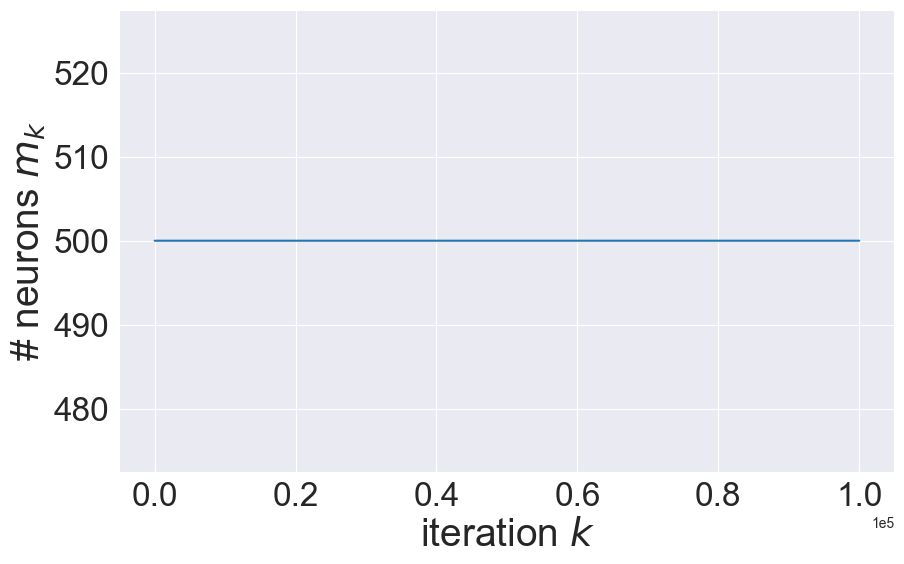

In [28]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

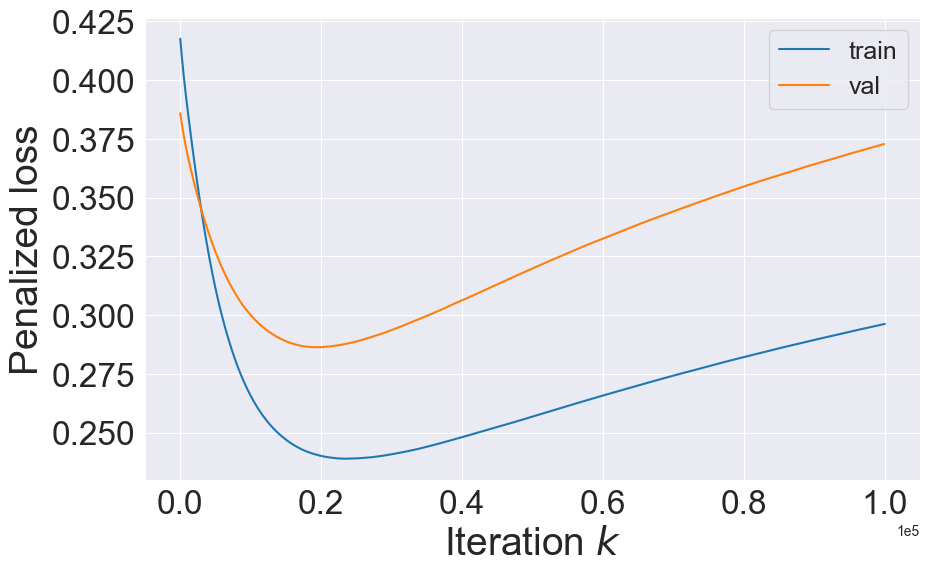

In [29]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses)), penalized_train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

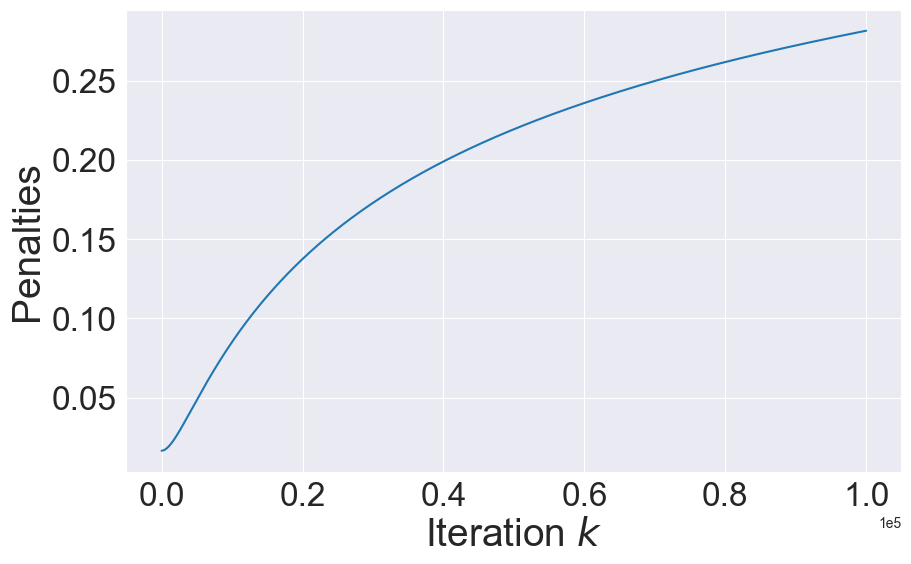

In [30]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses - train_losses

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

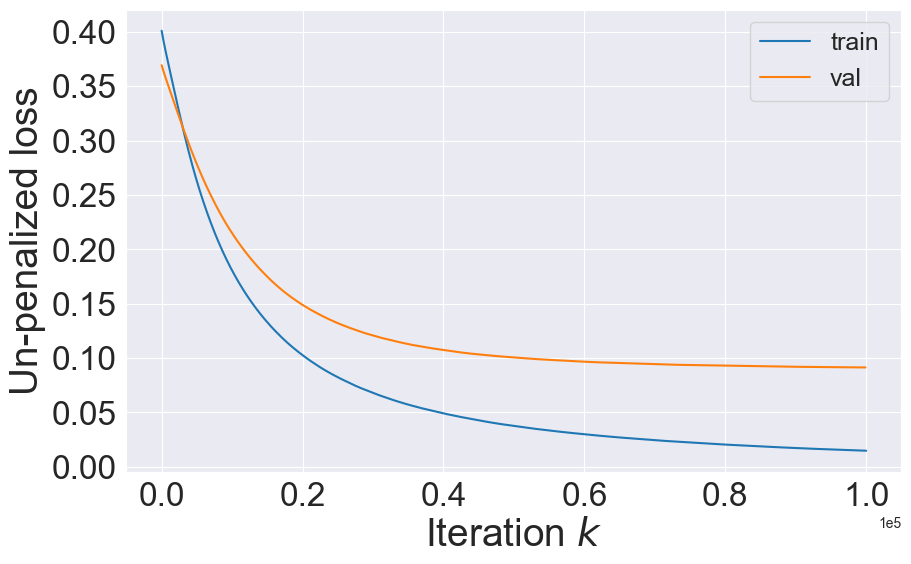

In [31]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 3. Projected penalized conic descent

In [32]:
n_steps = int(1.0e5)
m = 500
ETA = 0.01
penalized = True

In [33]:
def projected_conic_particle_update(a, b, x, y, penalized=False):
    m = a.shape[1]
    if m > 0:
        a = a - ETA * V_grad(a, b, x, y, b).reshape(1, -1) / m
        b = b - m * ETA * nabla_V_grad(a, b, x, y, factor=a)
        
        if penalized:
            a = a - ETA * LAMBDA * np.sign(a) / m
        
        b_norms = np.linalg.norm(b, ord=2, axis=1, keepdims=True)
        # a = a * b_norms.T
        b = b / b_norms
    return a, b  

In [34]:
def train(m, n_steps, x_train, y_train, x_val, y_val, do_val=True, penalized=False):
    #a = np.zeros(shape=(1, m))
    a = np.random.normal(size=(1, m)) / m
    b = np.random.normal(size=(m, INPUT_DIM))
    b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    b = b / b_norms
    
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    ms = [m]
    print('penalized =', penalized)

    for k in tqdm(range(n_steps)):
        a, b = projected_conic_particle_update(a, b, x_train, y_train, penalized=penalized)
        ms.append(a.shape[1])
        
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [35]:
a, b, ms, train_losses, penalized_train_losses, val_losses, penalized_val_losses = \
    train(m, n_steps, x_train, y_train, x_val, y_val, penalized=penalized)

penalized = True


  0%|                                                       | 12/100000 [00:00<14:28, 115.11it/s]

m at step 0 : 500
Train loss at step 0 : 0.40120
Validation loss at step 0 : 0.36859


  0%|                                                      | 125/100000 [00:01<13:45, 121.05it/s]

m at step 100 : 500
Train loss at step 100 : 0.39797
Validation loss at step 100 : 0.36667


  0%|                                                      | 214/100000 [00:01<14:40, 113.39it/s]

m at step 200 : 500
Train loss at step 200 : 0.39498
Validation loss at step 200 : 0.36487


  0%|▏                                                     | 324/100000 [00:02<14:28, 114.71it/s]

m at step 300 : 500
Train loss at step 300 : 0.39223
Validation loss at step 300 : 0.36316


  0%|▏                                                     | 425/100000 [00:03<13:51, 119.71it/s]

m at step 400 : 500
Train loss at step 400 : 0.38967
Validation loss at step 400 : 0.36154


  1%|▎                                                     | 524/100000 [00:04<13:50, 119.81it/s]

m at step 500 : 500
Train loss at step 500 : 0.38725
Validation loss at step 500 : 0.36001


  1%|▎                                                     | 625/100000 [00:05<13:41, 120.91it/s]

m at step 600 : 500
Train loss at step 600 : 0.38495
Validation loss at step 600 : 0.35855


  1%|▍                                                     | 713/100000 [00:06<14:02, 117.91it/s]

m at step 700 : 500
Train loss at step 700 : 0.38277
Validation loss at step 700 : 0.35718


  1%|▍                                                     | 825/100000 [00:06<13:51, 119.32it/s]

m at step 800 : 500
Train loss at step 800 : 0.38067
Validation loss at step 800 : 0.35585


  1%|▍                                                     | 914/100000 [00:07<13:35, 121.47it/s]

m at step 900 : 500
Train loss at step 900 : 0.37865
Validation loss at step 900 : 0.35456


  1%|▌                                                    | 1024/100000 [00:08<13:47, 119.66it/s]

m at step 1,000 : 500
Train loss at step 1,000 : 0.37669
Validation loss at step 1,000 : 0.35331


  1%|▌                                                    | 1114/100000 [00:09<13:41, 120.31it/s]

m at step 1,100 : 500
Train loss at step 1,100 : 0.37478
Validation loss at step 1,100 : 0.35208


  1%|▋                                                    | 1224/100000 [00:10<14:19, 114.91it/s]

m at step 1,200 : 500
Train loss at step 1,200 : 0.37290
Validation loss at step 1,200 : 0.35087


  1%|▋                                                    | 1324/100000 [00:11<14:08, 116.33it/s]

m at step 1,300 : 500
Train loss at step 1,300 : 0.37104
Validation loss at step 1,300 : 0.34968


  1%|▊                                                    | 1422/100000 [00:12<14:02, 116.97it/s]

m at step 1,400 : 500
Train loss at step 1,400 : 0.36919
Validation loss at step 1,400 : 0.34850


  2%|▊                                                    | 1525/100000 [00:13<13:29, 121.60it/s]

m at step 1,500 : 500
Train loss at step 1,500 : 0.36735
Validation loss at step 1,500 : 0.34733


  2%|▊                                                    | 1614/100000 [00:13<13:34, 120.75it/s]

m at step 1,600 : 500
Train loss at step 1,600 : 0.36552
Validation loss at step 1,600 : 0.34617


  2%|▉                                                    | 1718/100000 [00:14<13:34, 120.73it/s]

m at step 1,700 : 500
Train loss at step 1,700 : 0.36370
Validation loss at step 1,700 : 0.34501


  2%|▉                                                    | 1822/100000 [00:15<13:28, 121.42it/s]

m at step 1,800 : 500
Train loss at step 1,800 : 0.36189
Validation loss at step 1,800 : 0.34383


  2%|█                                                    | 1913/100000 [00:16<13:37, 120.05it/s]

m at step 1,900 : 500
Train loss at step 1,900 : 0.36010
Validation loss at step 1,900 : 0.34267


  2%|█                                                    | 2017/100000 [00:17<13:27, 121.30it/s]

m at step 2,000 : 500
Train loss at step 2,000 : 0.35831
Validation loss at step 2,000 : 0.34150


  2%|█                                                    | 2121/100000 [00:17<13:38, 119.62it/s]

m at step 2,100 : 500
Train loss at step 2,100 : 0.35653
Validation loss at step 2,100 : 0.34033


  2%|█▏                                                   | 2222/100000 [00:18<13:29, 120.79it/s]

m at step 2,200 : 500
Train loss at step 2,200 : 0.35476
Validation loss at step 2,200 : 0.33917


  2%|█▏                                                   | 2326/100000 [00:19<13:14, 122.95it/s]

m at step 2,300 : 500
Train loss at step 2,300 : 0.35299
Validation loss at step 2,300 : 0.33803


  2%|█▎                                                   | 2424/100000 [00:20<14:43, 110.50it/s]

m at step 2,400 : 500
Train loss at step 2,400 : 0.35123
Validation loss at step 2,400 : 0.33688


  3%|█▎                                                   | 2515/100000 [00:21<13:14, 122.72it/s]

m at step 2,500 : 500
Train loss at step 2,500 : 0.34948
Validation loss at step 2,500 : 0.33573


  3%|█▍                                                   | 2618/100000 [00:22<13:23, 121.13it/s]

m at step 2,600 : 500
Train loss at step 2,600 : 0.34773
Validation loss at step 2,600 : 0.33458


  3%|█▍                                                   | 2720/100000 [00:23<13:09, 123.25it/s]

m at step 2,700 : 500
Train loss at step 2,700 : 0.34599
Validation loss at step 2,700 : 0.33343


  3%|█▍                                                   | 2824/100000 [00:23<13:09, 123.12it/s]

m at step 2,800 : 500
Train loss at step 2,800 : 0.34426
Validation loss at step 2,800 : 0.33228


  3%|█▌                                                   | 2915/100000 [00:24<13:07, 123.26it/s]

m at step 2,900 : 500
Train loss at step 2,900 : 0.34253
Validation loss at step 2,900 : 0.33113


  3%|█▌                                                   | 3019/100000 [00:25<13:09, 122.89it/s]

m at step 3,000 : 500
Train loss at step 3,000 : 0.34081
Validation loss at step 3,000 : 0.32998


  3%|█▋                                                   | 3123/100000 [00:26<13:21, 120.92it/s]

m at step 3,100 : 500
Train loss at step 3,100 : 0.33909
Validation loss at step 3,100 : 0.32884


  3%|█▋                                                   | 3214/100000 [00:27<13:29, 119.52it/s]

m at step 3,200 : 500
Train loss at step 3,200 : 0.33739
Validation loss at step 3,200 : 0.32769


  3%|█▊                                                   | 3317/100000 [00:27<13:17, 121.26it/s]

m at step 3,300 : 500
Train loss at step 3,300 : 0.33569
Validation loss at step 3,300 : 0.32655


  3%|█▊                                                   | 3420/100000 [00:28<13:29, 119.34it/s]

m at step 3,400 : 500
Train loss at step 3,400 : 0.33400
Validation loss at step 3,400 : 0.32541


  4%|█▊                                                   | 3524/100000 [00:29<13:03, 123.13it/s]

m at step 3,500 : 500
Train loss at step 3,500 : 0.33231
Validation loss at step 3,500 : 0.32426


  4%|█▉                                                   | 3615/100000 [00:30<13:36, 118.10it/s]

m at step 3,600 : 500
Train loss at step 3,600 : 0.33063
Validation loss at step 3,600 : 0.32312


  4%|█▉                                                   | 3725/100000 [00:31<13:48, 116.21it/s]

m at step 3,700 : 500
Train loss at step 3,700 : 0.32896
Validation loss at step 3,700 : 0.32198


  4%|██                                                   | 3816/100000 [00:32<13:12, 121.37it/s]

m at step 3,800 : 500
Train loss at step 3,800 : 0.32730
Validation loss at step 3,800 : 0.32084


  4%|██                                                   | 3920/100000 [00:33<13:11, 121.45it/s]

m at step 3,900 : 500
Train loss at step 3,900 : 0.32565
Validation loss at step 3,900 : 0.31971


  4%|██▏                                                  | 4024/100000 [00:33<13:11, 121.27it/s]

m at step 4,000 : 500
Train loss at step 4,000 : 0.32401
Validation loss at step 4,000 : 0.31857


  4%|██▏                                                  | 4115/100000 [00:34<12:57, 123.30it/s]

m at step 4,100 : 500
Train loss at step 4,100 : 0.32238
Validation loss at step 4,100 : 0.31744


  4%|██▏                                                  | 4219/100000 [00:35<12:45, 125.19it/s]

m at step 4,200 : 500
Train loss at step 4,200 : 0.32076
Validation loss at step 4,200 : 0.31630


  4%|██▎                                                  | 4323/100000 [00:36<12:59, 122.75it/s]

m at step 4,300 : 500
Train loss at step 4,300 : 0.31914
Validation loss at step 4,300 : 0.31517


  4%|██▎                                                  | 4414/100000 [00:37<12:52, 123.66it/s]

m at step 4,400 : 500
Train loss at step 4,400 : 0.31754
Validation loss at step 4,400 : 0.31404


  5%|██▍                                                  | 4518/100000 [00:37<12:52, 123.65it/s]

m at step 4,500 : 500
Train loss at step 4,500 : 0.31595
Validation loss at step 4,500 : 0.31291


  5%|██▍                                                  | 4622/100000 [00:38<13:11, 120.55it/s]

m at step 4,600 : 500
Train loss at step 4,600 : 0.31436
Validation loss at step 4,600 : 0.31179


  5%|██▍                                                  | 4713/100000 [00:39<12:55, 122.81it/s]

m at step 4,700 : 500
Train loss at step 4,700 : 0.31279
Validation loss at step 4,700 : 0.31068


  5%|██▌                                                   | 4823/100000 [00:40<16:18, 97.32it/s]

m at step 4,800 : 500
Train loss at step 4,800 : 0.31122
Validation loss at step 4,800 : 0.30956


  5%|██▋                                                   | 4917/100000 [00:41<16:12, 97.77it/s]

m at step 4,900 : 500
Train loss at step 4,900 : 0.30967
Validation loss at step 4,900 : 0.30846


  5%|██▋                                                  | 5017/100000 [00:42<13:30, 117.23it/s]

m at step 5,000 : 500
Train loss at step 5,000 : 0.30813
Validation loss at step 5,000 : 0.30736


  5%|██▋                                                  | 5121/100000 [00:43<12:49, 123.23it/s]

m at step 5,100 : 500
Train loss at step 5,100 : 0.30660
Validation loss at step 5,100 : 0.30626


  5%|██▊                                                  | 5225/100000 [00:44<12:42, 124.29it/s]

m at step 5,200 : 500
Train loss at step 5,200 : 0.30508
Validation loss at step 5,200 : 0.30518


  5%|██▊                                                  | 5316/100000 [00:44<12:46, 123.52it/s]

m at step 5,300 : 500
Train loss at step 5,300 : 0.30357
Validation loss at step 5,300 : 0.30410


  5%|██▊                                                  | 5420/100000 [00:45<12:52, 122.50it/s]

m at step 5,400 : 500
Train loss at step 5,400 : 0.30207
Validation loss at step 5,400 : 0.30302


  6%|██▉                                                   | 5516/100000 [00:47<22:35, 69.72it/s]

m at step 5,500 : 500
Train loss at step 5,500 : 0.30058
Validation loss at step 5,500 : 0.30194


  6%|██▉                                                  | 5623/100000 [00:47<13:47, 113.99it/s]

m at step 5,600 : 500
Train loss at step 5,600 : 0.29911
Validation loss at step 5,600 : 0.30087


  6%|███                                                  | 5719/100000 [00:48<15:24, 101.95it/s]

m at step 5,700 : 500
Train loss at step 5,700 : 0.29765
Validation loss at step 5,700 : 0.29981


  6%|███                                                  | 5818/100000 [00:49<13:05, 119.89it/s]

m at step 5,800 : 500
Train loss at step 5,800 : 0.29619
Validation loss at step 5,800 : 0.29875


  6%|███▏                                                 | 5922/100000 [00:50<13:03, 120.06it/s]

m at step 5,900 : 500
Train loss at step 5,900 : 0.29475
Validation loss at step 5,900 : 0.29769


  6%|███▏                                                 | 6013/100000 [00:51<13:48, 113.50it/s]

m at step 6,000 : 500
Train loss at step 6,000 : 0.29333
Validation loss at step 6,000 : 0.29665


  6%|███▏                                                 | 6124/100000 [00:52<13:25, 116.48it/s]

m at step 6,100 : 500
Train loss at step 6,100 : 0.29192
Validation loss at step 6,100 : 0.29561


  6%|███▎                                                 | 6214/100000 [00:53<13:03, 119.75it/s]

m at step 6,200 : 500
Train loss at step 6,200 : 0.29051
Validation loss at step 6,200 : 0.29458


  6%|███▎                                                 | 6317/100000 [00:54<12:53, 121.08it/s]

m at step 6,300 : 500
Train loss at step 6,300 : 0.28912
Validation loss at step 6,300 : 0.29354


  6%|███▍                                                 | 6420/100000 [00:54<12:51, 121.29it/s]

m at step 6,400 : 500
Train loss at step 6,400 : 0.28773
Validation loss at step 6,400 : 0.29252


  7%|███▍                                                 | 6511/100000 [00:55<12:26, 125.24it/s]

m at step 6,500 : 500
Train loss at step 6,500 : 0.28636
Validation loss at step 6,500 : 0.29150


  7%|███▌                                                 | 6623/100000 [00:56<13:45, 113.14it/s]

m at step 6,600 : 500
Train loss at step 6,600 : 0.28500
Validation loss at step 6,600 : 0.29048


  7%|███▋                                                  | 6719/100000 [00:57<16:31, 94.10it/s]

m at step 6,700 : 500
Train loss at step 6,700 : 0.28365
Validation loss at step 6,700 : 0.28947


  7%|███▌                                                 | 6814/100000 [00:58<14:13, 109.15it/s]

m at step 6,800 : 500
Train loss at step 6,800 : 0.28232
Validation loss at step 6,800 : 0.28847


  7%|███▋                                                 | 6909/100000 [00:59<14:57, 103.71it/s]

m at step 6,900 : 500
Train loss at step 6,900 : 0.28099
Validation loss at step 6,900 : 0.28748


  7%|███▋                                                 | 7019/100000 [01:00<13:15, 116.94it/s]

m at step 7,000 : 500
Train loss at step 7,000 : 0.27967
Validation loss at step 7,000 : 0.28649


  7%|███▊                                                 | 7117/100000 [01:01<13:16, 116.64it/s]

m at step 7,100 : 500
Train loss at step 7,100 : 0.27837
Validation loss at step 7,100 : 0.28550


  7%|███▊                                                 | 7225/100000 [01:02<15:04, 102.58it/s]

m at step 7,200 : 500
Train loss at step 7,200 : 0.27708
Validation loss at step 7,200 : 0.28453


  7%|███▉                                                 | 7323/100000 [01:03<13:21, 115.58it/s]

m at step 7,300 : 500
Train loss at step 7,300 : 0.27580
Validation loss at step 7,300 : 0.28356


  7%|███▉                                                 | 7414/100000 [01:04<12:41, 121.56it/s]

m at step 7,400 : 500
Train loss at step 7,400 : 0.27454
Validation loss at step 7,400 : 0.28260


  8%|████                                                  | 7516/100000 [01:05<18:30, 83.30it/s]

m at step 7,500 : 500
Train loss at step 7,500 : 0.27329
Validation loss at step 7,500 : 0.28165


  8%|████                                                 | 7613/100000 [01:06<14:24, 106.81it/s]

m at step 7,600 : 500
Train loss at step 7,600 : 0.27205
Validation loss at step 7,600 : 0.28071


  8%|████                                                 | 7715/100000 [01:07<13:06, 117.31it/s]

m at step 7,700 : 500
Train loss at step 7,700 : 0.27082
Validation loss at step 7,700 : 0.27977


  8%|████▏                                                | 7819/100000 [01:08<12:31, 122.72it/s]

m at step 7,800 : 500
Train loss at step 7,800 : 0.26960
Validation loss at step 7,800 : 0.27884


  8%|████▏                                                | 7923/100000 [01:08<12:27, 123.20it/s]

m at step 7,900 : 500
Train loss at step 7,900 : 0.26840
Validation loss at step 7,900 : 0.27791


  8%|████▏                                                | 8014/100000 [01:09<12:35, 121.73it/s]

m at step 8,000 : 500
Train loss at step 8,000 : 0.26721
Validation loss at step 8,000 : 0.27699


  8%|████▎                                                | 8118/100000 [01:10<12:25, 123.26it/s]

m at step 8,100 : 500
Train loss at step 8,100 : 0.26603
Validation loss at step 8,100 : 0.27608


  8%|████▎                                                | 8222/100000 [01:11<12:25, 123.08it/s]

m at step 8,200 : 500
Train loss at step 8,200 : 0.26486
Validation loss at step 8,200 : 0.27517


  8%|████▍                                                | 8313/100000 [01:12<12:57, 117.86it/s]

m at step 8,300 : 500
Train loss at step 8,300 : 0.26370
Validation loss at step 8,300 : 0.27427


  8%|████▍                                                | 8417/100000 [01:13<15:02, 101.49it/s]

m at step 8,400 : 500
Train loss at step 8,400 : 0.26255
Validation loss at step 8,400 : 0.27338


  9%|████▌                                                | 8523/100000 [01:14<13:40, 111.43it/s]

m at step 8,500 : 500
Train loss at step 8,500 : 0.26142
Validation loss at step 8,500 : 0.27249


  9%|████▌                                                | 8617/100000 [01:15<14:45, 103.15it/s]

m at step 8,600 : 500
Train loss at step 8,600 : 0.26029
Validation loss at step 8,600 : 0.27161


  9%|████▌                                                | 8720/100000 [01:15<12:22, 122.94it/s]

m at step 8,700 : 500
Train loss at step 8,700 : 0.25917
Validation loss at step 8,700 : 0.27073


  9%|████▋                                                | 8819/100000 [01:16<13:35, 111.80it/s]

m at step 8,800 : 500
Train loss at step 8,800 : 0.25807
Validation loss at step 8,800 : 0.26986


  9%|████▋                                                | 8922/100000 [01:17<12:21, 122.89it/s]

m at step 8,900 : 500
Train loss at step 8,900 : 0.25697
Validation loss at step 8,900 : 0.26899


  9%|████▊                                                | 9024/100000 [01:18<12:55, 117.24it/s]

m at step 9,000 : 500
Train loss at step 9,000 : 0.25589
Validation loss at step 9,000 : 0.26813


  9%|████▊                                                | 9114/100000 [01:19<12:28, 121.44it/s]

m at step 9,100 : 500
Train loss at step 9,100 : 0.25481
Validation loss at step 9,100 : 0.26728


  9%|████▉                                                | 9218/100000 [01:20<12:14, 123.61it/s]

m at step 9,200 : 500
Train loss at step 9,200 : 0.25375
Validation loss at step 9,200 : 0.26644


  9%|████▉                                                | 9322/100000 [01:20<12:20, 122.54it/s]

m at step 9,300 : 500
Train loss at step 9,300 : 0.25270
Validation loss at step 9,300 : 0.26561


  9%|████▉                                                | 9426/100000 [01:21<12:09, 124.08it/s]

m at step 9,400 : 500
Train loss at step 9,400 : 0.25165
Validation loss at step 9,400 : 0.26479


 10%|█████                                                | 9517/100000 [01:22<12:13, 123.32it/s]

m at step 9,500 : 500
Train loss at step 9,500 : 0.25062
Validation loss at step 9,500 : 0.26397


 10%|█████                                                | 9616/100000 [01:23<14:49, 101.67it/s]

m at step 9,600 : 500
Train loss at step 9,600 : 0.24959
Validation loss at step 9,600 : 0.26315


 10%|█████▏                                               | 9718/100000 [01:24<12:19, 122.04it/s]

m at step 9,700 : 500
Train loss at step 9,700 : 0.24857
Validation loss at step 9,700 : 0.26234


 10%|█████▏                                               | 9822/100000 [01:25<12:07, 123.98it/s]

m at step 9,800 : 500
Train loss at step 9,800 : 0.24756
Validation loss at step 9,800 : 0.26154


 10%|█████▎                                               | 9913/100000 [01:26<12:34, 119.32it/s]

m at step 9,900 : 500
Train loss at step 9,900 : 0.24656
Validation loss at step 9,900 : 0.26074


 10%|█████▏                                              | 10017/100000 [01:26<12:31, 119.70it/s]

m at step 10,000 : 500
Train loss at step 10,000 : 0.24558
Validation loss at step 10,000 : 0.25994


 10%|█████▎                                              | 10121/100000 [01:27<12:10, 122.96it/s]

m at step 10,100 : 500
Train loss at step 10,100 : 0.24460
Validation loss at step 10,100 : 0.25916


 10%|█████▎                                              | 10225/100000 [01:28<12:07, 123.47it/s]

m at step 10,200 : 500
Train loss at step 10,200 : 0.24363
Validation loss at step 10,200 : 0.25837


 10%|█████▎                                              | 10316/100000 [01:29<12:06, 123.51it/s]

m at step 10,300 : 500
Train loss at step 10,300 : 0.24267
Validation loss at step 10,300 : 0.25760


 10%|█████▍                                              | 10420/100000 [01:30<12:03, 123.75it/s]

m at step 10,400 : 500
Train loss at step 10,400 : 0.24172
Validation loss at step 10,400 : 0.25683


 11%|█████▍                                              | 10524/100000 [01:31<12:14, 121.78it/s]

m at step 10,500 : 500
Train loss at step 10,500 : 0.24077
Validation loss at step 10,500 : 0.25606


 11%|█████▌                                              | 10615/100000 [01:31<12:23, 120.27it/s]

m at step 10,600 : 500
Train loss at step 10,600 : 0.23984
Validation loss at step 10,600 : 0.25530


 11%|█████▌                                              | 10719/100000 [01:32<12:10, 122.19it/s]

m at step 10,700 : 500
Train loss at step 10,700 : 0.23892
Validation loss at step 10,700 : 0.25455


 11%|█████▋                                              | 10823/100000 [01:33<12:23, 119.87it/s]

m at step 10,800 : 500
Train loss at step 10,800 : 0.23800
Validation loss at step 10,800 : 0.25381


 11%|█████▋                                              | 10922/100000 [01:34<12:38, 117.49it/s]

m at step 10,900 : 500
Train loss at step 10,900 : 0.23710
Validation loss at step 10,900 : 0.25307


 11%|█████▋                                              | 11026/100000 [01:35<12:12, 121.47it/s]

m at step 11,000 : 500
Train loss at step 11,000 : 0.23620
Validation loss at step 11,000 : 0.25234


 11%|█████▊                                              | 11117/100000 [01:36<11:58, 123.79it/s]

m at step 11,100 : 500
Train loss at step 11,100 : 0.23531
Validation loss at step 11,100 : 0.25161


 11%|█████▊                                              | 11221/100000 [01:36<11:59, 123.32it/s]

m at step 11,200 : 500
Train loss at step 11,200 : 0.23443
Validation loss at step 11,200 : 0.25089


 11%|█████▉                                              | 11325/100000 [01:37<11:53, 124.27it/s]

m at step 11,300 : 500
Train loss at step 11,300 : 0.23355
Validation loss at step 11,300 : 0.25017


 11%|█████▉                                              | 11416/100000 [01:38<11:57, 123.41it/s]

m at step 11,400 : 500
Train loss at step 11,400 : 0.23269
Validation loss at step 11,400 : 0.24945


 12%|█████▉                                              | 11520/100000 [01:39<12:09, 121.34it/s]

m at step 11,500 : 500
Train loss at step 11,500 : 0.23182
Validation loss at step 11,500 : 0.24874


 12%|██████                                              | 11624/100000 [01:40<12:00, 122.68it/s]

m at step 11,600 : 500
Train loss at step 11,600 : 0.23097
Validation loss at step 11,600 : 0.24802


 12%|██████                                              | 11715/100000 [01:40<11:54, 123.52it/s]

m at step 11,700 : 500
Train loss at step 11,700 : 0.23013
Validation loss at step 11,700 : 0.24732


 12%|██████▏                                             | 11819/100000 [01:41<12:05, 121.46it/s]

m at step 11,800 : 500
Train loss at step 11,800 : 0.22929
Validation loss at step 11,800 : 0.24662


 12%|██████▏                                             | 11922/100000 [01:42<12:00, 122.18it/s]

m at step 11,900 : 500
Train loss at step 11,900 : 0.22846
Validation loss at step 11,900 : 0.24593


 12%|██████▎                                             | 12025/100000 [01:43<12:08, 120.75it/s]

m at step 12,000 : 500
Train loss at step 12,000 : 0.22764
Validation loss at step 12,000 : 0.24525


 12%|██████▍                                              | 12123/100000 [01:44<14:45, 99.29it/s]

m at step 12,100 : 500
Train loss at step 12,100 : 0.22682
Validation loss at step 12,100 : 0.24457


 12%|██████▎                                             | 12226/100000 [01:45<12:00, 121.75it/s]

m at step 12,200 : 500
Train loss at step 12,200 : 0.22602
Validation loss at step 12,200 : 0.24390


 12%|██████▍                                             | 12317/100000 [01:45<11:47, 124.01it/s]

m at step 12,300 : 500
Train loss at step 12,300 : 0.22522
Validation loss at step 12,300 : 0.24323


 12%|██████▌                                              | 12414/100000 [01:46<14:41, 99.39it/s]

m at step 12,400 : 500
Train loss at step 12,400 : 0.22443
Validation loss at step 12,400 : 0.24256


 13%|██████▌                                             | 12523/100000 [01:47<12:28, 116.83it/s]

m at step 12,500 : 500
Train loss at step 12,500 : 0.22364
Validation loss at step 12,500 : 0.24190


 13%|██████▌                                             | 12621/100000 [01:48<13:21, 109.02it/s]

m at step 12,600 : 500
Train loss at step 12,600 : 0.22287
Validation loss at step 12,600 : 0.24124


 13%|██████▌                                             | 12723/100000 [01:49<11:50, 122.92it/s]

m at step 12,700 : 500
Train loss at step 12,700 : 0.22209
Validation loss at step 12,700 : 0.24059


 13%|██████▋                                             | 12814/100000 [01:50<11:59, 121.15it/s]

m at step 12,800 : 500
Train loss at step 12,800 : 0.22133
Validation loss at step 12,800 : 0.23994


 13%|██████▋                                             | 12918/100000 [01:51<12:07, 119.66it/s]

m at step 12,900 : 500
Train loss at step 12,900 : 0.22057
Validation loss at step 12,900 : 0.23929


 13%|██████▊                                             | 13021/100000 [01:52<11:52, 122.13it/s]

m at step 13,000 : 500
Train loss at step 13,000 : 0.21982
Validation loss at step 13,000 : 0.23865


 13%|██████▊                                             | 13125/100000 [01:52<11:58, 120.92it/s]

m at step 13,100 : 500
Train loss at step 13,100 : 0.21908
Validation loss at step 13,100 : 0.23802


 13%|██████▊                                             | 13216/100000 [01:53<11:38, 124.19it/s]

m at step 13,200 : 500
Train loss at step 13,200 : 0.21834
Validation loss at step 13,200 : 0.23739


 13%|██████▉                                             | 13320/100000 [01:54<12:11, 118.49it/s]

m at step 13,300 : 500
Train loss at step 13,300 : 0.21760
Validation loss at step 13,300 : 0.23678


 13%|██████▉                                             | 13421/100000 [01:55<12:08, 118.92it/s]

m at step 13,400 : 500
Train loss at step 13,400 : 0.21688
Validation loss at step 13,400 : 0.23616


 14%|███████                                             | 13525/100000 [01:56<11:41, 123.30it/s]

m at step 13,500 : 500
Train loss at step 13,500 : 0.21616
Validation loss at step 13,500 : 0.23555


 14%|███████                                             | 13614/100000 [01:57<12:05, 119.02it/s]

m at step 13,600 : 500
Train loss at step 13,600 : 0.21545
Validation loss at step 13,600 : 0.23495


 14%|███████▏                                            | 13717/100000 [01:57<11:43, 122.58it/s]

m at step 13,700 : 500
Train loss at step 13,700 : 0.21474
Validation loss at step 13,700 : 0.23435


 14%|███████▏                                            | 13821/100000 [01:58<11:45, 122.17it/s]

m at step 13,800 : 500
Train loss at step 13,800 : 0.21404
Validation loss at step 13,800 : 0.23375


 14%|███████▏                                            | 13925/100000 [01:59<11:40, 122.88it/s]

m at step 13,900 : 500
Train loss at step 13,900 : 0.21335
Validation loss at step 13,900 : 0.23315


 14%|███████▎                                            | 14016/100000 [02:00<11:32, 124.08it/s]

m at step 14,000 : 500
Train loss at step 14,000 : 0.21266
Validation loss at step 14,000 : 0.23256


 14%|███████▎                                            | 14120/100000 [02:01<11:24, 125.43it/s]

m at step 14,100 : 500
Train loss at step 14,100 : 0.21197
Validation loss at step 14,100 : 0.23197


 14%|███████▍                                            | 14224/100000 [02:02<11:42, 122.04it/s]

m at step 14,200 : 500
Train loss at step 14,200 : 0.21130
Validation loss at step 14,200 : 0.23139


 14%|███████▍                                            | 14315/100000 [02:02<11:40, 122.36it/s]

m at step 14,300 : 500
Train loss at step 14,300 : 0.21063
Validation loss at step 14,300 : 0.23081


 14%|███████▍                                            | 14418/100000 [02:03<12:06, 117.83it/s]

m at step 14,400 : 500
Train loss at step 14,400 : 0.20996
Validation loss at step 14,400 : 0.23024


 15%|███████▌                                            | 14522/100000 [02:04<11:52, 119.91it/s]

m at step 14,500 : 500
Train loss at step 14,500 : 0.20930
Validation loss at step 14,500 : 0.22968


 15%|███████▋                                             | 14610/100000 [02:05<16:18, 87.30it/s]

m at step 14,600 : 500
Train loss at step 14,600 : 0.20865
Validation loss at step 14,600 : 0.22912


 15%|███████▋                                            | 14723/100000 [02:06<11:57, 118.86it/s]

m at step 14,700 : 500
Train loss at step 14,700 : 0.20800
Validation loss at step 14,700 : 0.22856


 15%|███████▋                                            | 14813/100000 [02:07<11:34, 122.60it/s]

m at step 14,800 : 500
Train loss at step 14,800 : 0.20735
Validation loss at step 14,800 : 0.22801


 15%|███████▊                                            | 14917/100000 [02:07<11:38, 121.84it/s]

m at step 14,900 : 500
Train loss at step 14,900 : 0.20672
Validation loss at step 14,900 : 0.22746


 15%|███████▊                                            | 15021/100000 [02:08<11:28, 123.39it/s]

m at step 15,000 : 500
Train loss at step 15,000 : 0.20608
Validation loss at step 15,000 : 0.22691


 15%|███████▊                                            | 15112/100000 [02:09<11:43, 120.65it/s]

m at step 15,100 : 500
Train loss at step 15,100 : 0.20546
Validation loss at step 15,100 : 0.22636


 15%|███████▉                                            | 15216/100000 [02:10<11:26, 123.52it/s]

m at step 15,200 : 500
Train loss at step 15,200 : 0.20484
Validation loss at step 15,200 : 0.22582


 15%|███████▉                                            | 15320/100000 [02:11<11:31, 122.52it/s]

m at step 15,300 : 500
Train loss at step 15,300 : 0.20422
Validation loss at step 15,300 : 0.22528


 15%|████████                                            | 15424/100000 [02:12<11:25, 123.40it/s]

m at step 15,400 : 500
Train loss at step 15,400 : 0.20361
Validation loss at step 15,400 : 0.22474


 16%|████████                                            | 15515/100000 [02:12<11:25, 123.32it/s]

m at step 15,500 : 500
Train loss at step 15,500 : 0.20300
Validation loss at step 15,500 : 0.22420


 16%|████████                                            | 15619/100000 [02:13<11:21, 123.75it/s]

m at step 15,600 : 500
Train loss at step 15,600 : 0.20240
Validation loss at step 15,600 : 0.22367


 16%|████████▏                                           | 15723/100000 [02:14<11:22, 123.43it/s]

m at step 15,700 : 500
Train loss at step 15,700 : 0.20180
Validation loss at step 15,700 : 0.22314


 16%|████████▏                                           | 15814/100000 [02:15<11:29, 122.14it/s]

m at step 15,800 : 500
Train loss at step 15,800 : 0.20121
Validation loss at step 15,800 : 0.22262


 16%|████████▎                                           | 15915/100000 [02:16<12:21, 113.41it/s]

m at step 15,900 : 500
Train loss at step 15,900 : 0.20062
Validation loss at step 15,900 : 0.22210


 16%|████████▎                                           | 16018/100000 [02:17<11:30, 121.69it/s]

m at step 16,000 : 500
Train loss at step 16,000 : 0.20003
Validation loss at step 16,000 : 0.22158


 16%|████████▍                                           | 16122/100000 [02:17<11:37, 120.29it/s]

m at step 16,100 : 500
Train loss at step 16,100 : 0.19945
Validation loss at step 16,100 : 0.22107


 16%|████████▍                                           | 16223/100000 [02:18<11:27, 121.88it/s]

m at step 16,200 : 500
Train loss at step 16,200 : 0.19888
Validation loss at step 16,200 : 0.22056


 16%|████████▍                                           | 16314/100000 [02:19<11:23, 122.51it/s]

m at step 16,300 : 500
Train loss at step 16,300 : 0.19831
Validation loss at step 16,300 : 0.22006


 16%|████████▌                                           | 16418/100000 [02:20<11:12, 124.33it/s]

m at step 16,400 : 500
Train loss at step 16,400 : 0.19774
Validation loss at step 16,400 : 0.21956


 17%|████████▌                                           | 16522/100000 [02:21<11:08, 124.83it/s]

m at step 16,500 : 500
Train loss at step 16,500 : 0.19718
Validation loss at step 16,500 : 0.21906


 17%|████████▋                                           | 16626/100000 [02:22<11:07, 124.94it/s]

m at step 16,600 : 500
Train loss at step 16,600 : 0.19663
Validation loss at step 16,600 : 0.21857


 17%|████████▋                                           | 16714/100000 [02:22<11:46, 117.91it/s]

m at step 16,700 : 500
Train loss at step 16,700 : 0.19608
Validation loss at step 16,700 : 0.21809


 17%|████████▋                                           | 16818/100000 [02:23<11:33, 119.94it/s]

m at step 16,800 : 500
Train loss at step 16,800 : 0.19553
Validation loss at step 16,800 : 0.21760


 17%|████████▊                                           | 16922/100000 [02:24<11:39, 118.83it/s]

m at step 16,900 : 500
Train loss at step 16,900 : 0.19499
Validation loss at step 16,900 : 0.21713


 17%|████████▊                                           | 17024/100000 [02:25<11:11, 123.57it/s]

m at step 17,000 : 500
Train loss at step 17,000 : 0.19445
Validation loss at step 17,000 : 0.21665


 17%|█████████                                            | 17122/100000 [02:26<14:35, 94.72it/s]

m at step 17,100 : 500
Train loss at step 17,100 : 0.19392
Validation loss at step 17,100 : 0.21618


 17%|████████▉                                           | 17218/100000 [02:27<11:55, 115.73it/s]

m at step 17,200 : 500
Train loss at step 17,200 : 0.19339
Validation loss at step 17,200 : 0.21571


 17%|█████████                                           | 17314/100000 [02:28<11:48, 116.63it/s]

m at step 17,300 : 500
Train loss at step 17,300 : 0.19287
Validation loss at step 17,300 : 0.21525


 17%|█████████                                           | 17422/100000 [02:28<11:34, 118.91it/s]

m at step 17,400 : 500
Train loss at step 17,400 : 0.19235
Validation loss at step 17,400 : 0.21478


 18%|█████████                                           | 17520/100000 [02:29<11:38, 118.01it/s]

m at step 17,500 : 500
Train loss at step 17,500 : 0.19183
Validation loss at step 17,500 : 0.21432


 18%|█████████▏                                          | 17616/100000 [02:30<11:43, 117.13it/s]

m at step 17,600 : 500
Train loss at step 17,600 : 0.19132
Validation loss at step 17,600 : 0.21387


 18%|█████████▏                                          | 17724/100000 [02:31<11:41, 117.24it/s]

m at step 17,700 : 500
Train loss at step 17,700 : 0.19081
Validation loss at step 17,700 : 0.21342


 18%|█████████▎                                          | 17820/100000 [02:32<11:45, 116.51it/s]

m at step 17,800 : 500
Train loss at step 17,800 : 0.19030
Validation loss at step 17,800 : 0.21298


 18%|█████████▎                                          | 17916/100000 [02:33<11:50, 115.49it/s]

m at step 17,900 : 500
Train loss at step 17,900 : 0.18980
Validation loss at step 17,900 : 0.21253


 18%|█████████▎                                          | 18013/100000 [02:34<11:37, 117.53it/s]

m at step 18,000 : 500
Train loss at step 18,000 : 0.18931
Validation loss at step 18,000 : 0.21209


 18%|█████████▍                                          | 18121/100000 [02:34<11:44, 116.29it/s]

m at step 18,100 : 500
Train loss at step 18,100 : 0.18881
Validation loss at step 18,100 : 0.21165


 18%|█████████▍                                          | 18218/100000 [02:35<11:48, 115.36it/s]

m at step 18,200 : 500
Train loss at step 18,200 : 0.18832
Validation loss at step 18,200 : 0.21122


 18%|█████████▌                                          | 18303/100000 [02:36<12:07, 112.24it/s]

m at step 18,300 : 500
Train loss at step 18,300 : 0.18784
Validation loss at step 18,300 : 0.21079


 18%|█████████▌                                          | 18416/100000 [02:37<11:17, 120.39it/s]

m at step 18,400 : 500
Train loss at step 18,400 : 0.18735
Validation loss at step 18,400 : 0.21036


 19%|█████████▋                                          | 18519/100000 [02:38<11:01, 123.24it/s]

m at step 18,500 : 500
Train loss at step 18,500 : 0.18688
Validation loss at step 18,500 : 0.20993


 19%|█████████▋                                          | 18623/100000 [02:39<11:03, 122.70it/s]

m at step 18,600 : 500
Train loss at step 18,600 : 0.18640
Validation loss at step 18,600 : 0.20951


 19%|█████████▋                                          | 18726/100000 [02:40<11:04, 122.23it/s]

m at step 18,700 : 500
Train loss at step 18,700 : 0.18593
Validation loss at step 18,700 : 0.20908


 19%|█████████▊                                          | 18817/100000 [02:40<11:07, 121.68it/s]

m at step 18,800 : 500
Train loss at step 18,800 : 0.18546
Validation loss at step 18,800 : 0.20867


 19%|█████████▊                                          | 18921/100000 [02:41<10:50, 124.71it/s]

m at step 18,900 : 500
Train loss at step 18,900 : 0.18499
Validation loss at step 18,900 : 0.20825


 19%|█████████▉                                          | 19025/100000 [02:42<11:03, 121.97it/s]

m at step 19,000 : 500
Train loss at step 19,000 : 0.18453
Validation loss at step 19,000 : 0.20784


 19%|█████████▉                                          | 19116/100000 [02:43<10:54, 123.55it/s]

m at step 19,100 : 500
Train loss at step 19,100 : 0.18408
Validation loss at step 19,100 : 0.20743


 19%|█████████▉                                          | 19220/100000 [02:44<10:50, 124.17it/s]

m at step 19,200 : 500
Train loss at step 19,200 : 0.18362
Validation loss at step 19,200 : 0.20702


 19%|██████████                                          | 19324/100000 [02:45<10:54, 123.34it/s]

m at step 19,300 : 500
Train loss at step 19,300 : 0.18317
Validation loss at step 19,300 : 0.20660


 19%|██████████                                          | 19402/100000 [02:45<10:57, 122.62it/s]

m at step 19,400 : 500
Train loss at step 19,400 : 0.18272
Validation loss at step 19,400 : 0.20620


 20%|██████████▎                                          | 19520/100000 [02:46<13:47, 97.30it/s]

m at step 19,500 : 500
Train loss at step 19,500 : 0.18228
Validation loss at step 19,500 : 0.20580


 20%|██████████▏                                         | 19614/100000 [02:47<11:48, 113.52it/s]

m at step 19,600 : 500
Train loss at step 19,600 : 0.18184
Validation loss at step 19,600 : 0.20539


 20%|██████████▎                                         | 19723/100000 [02:48<12:30, 106.98it/s]

m at step 19,700 : 500
Train loss at step 19,700 : 0.18140
Validation loss at step 19,700 : 0.20499


 20%|██████████▎                                         | 19825/100000 [02:49<10:52, 122.83it/s]

m at step 19,800 : 500
Train loss at step 19,800 : 0.18096
Validation loss at step 19,800 : 0.20460


 20%|██████████▎                                         | 19915/100000 [02:50<11:15, 118.53it/s]

m at step 19,900 : 500
Train loss at step 19,900 : 0.18053
Validation loss at step 19,900 : 0.20419


 20%|██████████▍                                         | 20024/100000 [02:51<11:44, 113.55it/s]

m at step 20,000 : 500
Train loss at step 20,000 : 0.18010
Validation loss at step 20,000 : 0.20379


 20%|██████████▍                                         | 20123/100000 [02:52<11:46, 113.03it/s]

m at step 20,100 : 500
Train loss at step 20,100 : 0.17968
Validation loss at step 20,100 : 0.20340


 20%|██████████▌                                         | 20220/100000 [02:53<11:24, 116.48it/s]

m at step 20,200 : 500
Train loss at step 20,200 : 0.17925
Validation loss at step 20,200 : 0.20301


 20%|██████████▌                                         | 20320/100000 [02:54<11:13, 118.24it/s]

m at step 20,300 : 500
Train loss at step 20,300 : 0.17883
Validation loss at step 20,300 : 0.20263


 20%|██████████▌                                         | 20417/100000 [02:54<11:22, 116.69it/s]

m at step 20,400 : 500
Train loss at step 20,400 : 0.17842
Validation loss at step 20,400 : 0.20225


 21%|██████████▋                                         | 20515/100000 [02:55<11:32, 114.72it/s]

m at step 20,500 : 500
Train loss at step 20,500 : 0.17800
Validation loss at step 20,500 : 0.20187


 21%|██████████▉                                          | 20612/100000 [02:56<13:26, 98.42it/s]

m at step 20,600 : 500
Train loss at step 20,600 : 0.17759
Validation loss at step 20,600 : 0.20150


 21%|██████████▉                                          | 20714/100000 [02:58<16:55, 78.07it/s]

m at step 20,700 : 500
Train loss at step 20,700 : 0.17718
Validation loss at step 20,700 : 0.20113


 21%|██████████▊                                         | 20815/100000 [02:59<12:43, 103.74it/s]

m at step 20,800 : 500
Train loss at step 20,800 : 0.17678
Validation loss at step 20,800 : 0.20076


 21%|██████████▉                                         | 20920/100000 [03:00<11:43, 112.44it/s]

m at step 20,900 : 500
Train loss at step 20,900 : 0.17637
Validation loss at step 20,900 : 0.20040


 21%|██████████▉                                         | 21023/100000 [03:00<10:37, 123.89it/s]

m at step 21,000 : 500
Train loss at step 21,000 : 0.17597
Validation loss at step 21,000 : 0.20004


 21%|██████████▉                                         | 21124/100000 [03:01<11:04, 118.75it/s]

m at step 21,100 : 500
Train loss at step 21,100 : 0.17558
Validation loss at step 21,100 : 0.19968


 21%|███████████                                         | 21222/100000 [03:02<10:52, 120.67it/s]

m at step 21,200 : 500
Train loss at step 21,200 : 0.17519
Validation loss at step 21,200 : 0.19933


 21%|███████████                                         | 21313/100000 [03:03<10:43, 122.20it/s]

m at step 21,300 : 500
Train loss at step 21,300 : 0.17480
Validation loss at step 21,300 : 0.19898


 21%|███████████▏                                        | 21417/100000 [03:04<10:44, 122.02it/s]

m at step 21,400 : 500
Train loss at step 21,400 : 0.17441
Validation loss at step 21,400 : 0.19863


 22%|███████████▏                                        | 21521/100000 [03:04<10:36, 123.23it/s]

m at step 21,500 : 500
Train loss at step 21,500 : 0.17402
Validation loss at step 21,500 : 0.19829


 22%|███████████▏                                        | 21625/100000 [03:05<10:31, 124.11it/s]

m at step 21,600 : 500
Train loss at step 21,600 : 0.17364
Validation loss at step 21,600 : 0.19794


 22%|███████████▎                                        | 21702/100000 [03:06<11:06, 117.54it/s]

m at step 21,700 : 500
Train loss at step 21,700 : 0.17326
Validation loss at step 21,700 : 0.19760


 22%|███████████▎                                        | 21818/100000 [03:07<12:32, 103.85it/s]

m at step 21,800 : 500
Train loss at step 21,800 : 0.17288
Validation loss at step 21,800 : 0.19726


 22%|███████████▍                                        | 21914/100000 [03:08<11:57, 108.76it/s]

m at step 21,900 : 500
Train loss at step 21,900 : 0.17251
Validation loss at step 21,900 : 0.19693


 22%|███████████▍                                        | 22018/100000 [03:09<10:26, 124.43it/s]

m at step 22,000 : 500
Train loss at step 22,000 : 0.17214
Validation loss at step 22,000 : 0.19660


 22%|███████████▌                                        | 22122/100000 [03:10<10:37, 122.25it/s]

m at step 22,100 : 500
Train loss at step 22,100 : 0.17177
Validation loss at step 22,100 : 0.19627


 22%|███████████▌                                        | 22226/100000 [03:11<10:27, 123.98it/s]

m at step 22,200 : 500
Train loss at step 22,200 : 0.17140
Validation loss at step 22,200 : 0.19594


 22%|███████████▌                                        | 22317/100000 [03:11<10:25, 124.10it/s]

m at step 22,300 : 500
Train loss at step 22,300 : 0.17104
Validation loss at step 22,300 : 0.19561


 22%|███████████▋                                        | 22421/100000 [03:12<10:30, 123.05it/s]

m at step 22,400 : 500
Train loss at step 22,400 : 0.17068
Validation loss at step 22,400 : 0.19529


 23%|███████████▋                                        | 22525/100000 [03:13<10:28, 123.29it/s]

m at step 22,500 : 500
Train loss at step 22,500 : 0.17032
Validation loss at step 22,500 : 0.19496


 23%|███████████▊                                        | 22616/100000 [03:14<10:19, 124.88it/s]

m at step 22,600 : 500
Train loss at step 22,600 : 0.16996
Validation loss at step 22,600 : 0.19464


 23%|███████████▊                                        | 22720/100000 [03:15<10:19, 124.71it/s]

m at step 22,700 : 500
Train loss at step 22,700 : 0.16961
Validation loss at step 22,700 : 0.19432


 23%|███████████▊                                        | 22824/100000 [03:16<10:17, 125.07it/s]

m at step 22,800 : 500
Train loss at step 22,800 : 0.16926
Validation loss at step 22,800 : 0.19401


 23%|███████████▉                                        | 22926/100000 [03:16<10:36, 121.17it/s]

m at step 22,900 : 500
Train loss at step 22,900 : 0.16891
Validation loss at step 22,900 : 0.19370


 23%|███████████▉                                        | 23017/100000 [03:17<10:25, 123.07it/s]

m at step 23,000 : 500
Train loss at step 23,000 : 0.16856
Validation loss at step 23,000 : 0.19339


 23%|████████████                                        | 23118/100000 [03:18<10:58, 116.70it/s]

m at step 23,100 : 500
Train loss at step 23,100 : 0.16822
Validation loss at step 23,100 : 0.19308


 23%|████████████                                        | 23219/100000 [03:19<10:53, 117.50it/s]

m at step 23,200 : 500
Train loss at step 23,200 : 0.16788
Validation loss at step 23,200 : 0.19276


 23%|████████████▏                                       | 23323/100000 [03:20<10:25, 122.65it/s]

m at step 23,300 : 500
Train loss at step 23,300 : 0.16754
Validation loss at step 23,300 : 0.19245


 23%|████████████▏                                       | 23414/100000 [03:21<10:17, 124.11it/s]

m at step 23,400 : 500
Train loss at step 23,400 : 0.16720
Validation loss at step 23,400 : 0.19215


 24%|████████████▏                                       | 23518/100000 [03:21<10:21, 123.13it/s]

m at step 23,500 : 500
Train loss at step 23,500 : 0.16687
Validation loss at step 23,500 : 0.19184


 24%|████████████▎                                       | 23622/100000 [03:22<10:15, 124.02it/s]

m at step 23,600 : 500
Train loss at step 23,600 : 0.16653
Validation loss at step 23,600 : 0.19153


 24%|████████████▎                                       | 23726/100000 [03:23<10:20, 122.89it/s]

m at step 23,700 : 500
Train loss at step 23,700 : 0.16620
Validation loss at step 23,700 : 0.19122


 24%|████████████▍                                       | 23817/100000 [03:24<10:08, 125.13it/s]

m at step 23,800 : 500
Train loss at step 23,800 : 0.16587
Validation loss at step 23,800 : 0.19090


 24%|████████████▍                                       | 23921/100000 [03:25<10:10, 124.70it/s]

m at step 23,900 : 500
Train loss at step 23,900 : 0.16555
Validation loss at step 23,900 : 0.19059


 24%|████████████▍                                       | 24025/100000 [03:25<10:11, 124.34it/s]

m at step 24,000 : 500
Train loss at step 24,000 : 0.16522
Validation loss at step 24,000 : 0.19028


 24%|████████████▌                                       | 24114/100000 [03:26<10:28, 120.80it/s]

m at step 24,100 : 500
Train loss at step 24,100 : 0.16490
Validation loss at step 24,100 : 0.18998


 24%|████████████▌                                       | 24218/100000 [03:27<10:12, 123.78it/s]

m at step 24,200 : 500
Train loss at step 24,200 : 0.16457
Validation loss at step 24,200 : 0.18968


 24%|████████████▋                                       | 24322/100000 [03:28<10:03, 125.49it/s]

m at step 24,300 : 500
Train loss at step 24,300 : 0.16425
Validation loss at step 24,300 : 0.18938


 24%|████████████▉                                        | 24412/100000 [03:29<13:19, 94.60it/s]

m at step 24,400 : 500
Train loss at step 24,400 : 0.16393
Validation loss at step 24,400 : 0.18908


 25%|████████████▊                                       | 24526/100000 [03:30<10:21, 121.53it/s]

m at step 24,500 : 500
Train loss at step 24,500 : 0.16362
Validation loss at step 24,500 : 0.18878


 25%|████████████▊                                       | 24617/100000 [03:30<10:16, 122.22it/s]

m at step 24,600 : 500
Train loss at step 24,600 : 0.16330
Validation loss at step 24,600 : 0.18849


 25%|████████████▊                                       | 24721/100000 [03:31<10:09, 123.53it/s]

m at step 24,700 : 500
Train loss at step 24,700 : 0.16299
Validation loss at step 24,700 : 0.18819


 25%|████████████▉                                       | 24812/100000 [03:32<10:25, 120.19it/s]

m at step 24,800 : 500
Train loss at step 24,800 : 0.16268
Validation loss at step 24,800 : 0.18791


 25%|████████████▉                                       | 24915/100000 [03:33<10:10, 123.05it/s]

m at step 24,900 : 500
Train loss at step 24,900 : 0.16237
Validation loss at step 24,900 : 0.18762


 25%|█████████████                                       | 25019/100000 [03:34<10:03, 124.30it/s]

m at step 25,000 : 500
Train loss at step 25,000 : 0.16206
Validation loss at step 25,000 : 0.18734


 25%|█████████████                                       | 25123/100000 [03:35<10:22, 120.24it/s]

m at step 25,100 : 500
Train loss at step 25,100 : 0.16176
Validation loss at step 25,100 : 0.18706


 25%|█████████████                                       | 25220/100000 [03:35<10:41, 116.57it/s]

m at step 25,200 : 500
Train loss at step 25,200 : 0.16146
Validation loss at step 25,200 : 0.18678


 25%|█████████████▏                                      | 25316/100000 [03:36<11:16, 110.42it/s]

m at step 25,300 : 500
Train loss at step 25,300 : 0.16115
Validation loss at step 25,300 : 0.18650


 25%|█████████████▏                                      | 25414/100000 [03:37<10:39, 116.59it/s]

m at step 25,400 : 500
Train loss at step 25,400 : 0.16085
Validation loss at step 25,400 : 0.18622


 26%|█████████████▎                                      | 25522/100000 [03:38<10:35, 117.20it/s]

m at step 25,500 : 500
Train loss at step 25,500 : 0.16056
Validation loss at step 25,500 : 0.18594


 26%|█████████████▎                                      | 25618/100000 [03:39<11:12, 110.61it/s]

m at step 25,600 : 500
Train loss at step 25,600 : 0.16026
Validation loss at step 25,600 : 0.18568


 26%|█████████████▎                                      | 25714/100000 [03:40<11:09, 110.94it/s]

m at step 25,700 : 500
Train loss at step 25,700 : 0.15997
Validation loss at step 25,700 : 0.18541


 26%|█████████████▍                                      | 25822/100000 [03:41<10:40, 115.73it/s]

m at step 25,800 : 500
Train loss at step 25,800 : 0.15968
Validation loss at step 25,800 : 0.18515


 26%|█████████████▍                                      | 25918/100000 [03:42<10:47, 114.46it/s]

m at step 25,900 : 500
Train loss at step 25,900 : 0.15938
Validation loss at step 25,900 : 0.18488


 26%|█████████████▌                                      | 26017/100000 [03:43<10:08, 121.66it/s]

m at step 26,000 : 500
Train loss at step 26,000 : 0.15909
Validation loss at step 26,000 : 0.18462


 26%|█████████████▌                                      | 26121/100000 [03:43<09:59, 123.22it/s]

m at step 26,100 : 500
Train loss at step 26,100 : 0.15881
Validation loss at step 26,100 : 0.18436


 26%|█████████████▋                                      | 26212/100000 [03:44<09:55, 123.91it/s]

m at step 26,200 : 500
Train loss at step 26,200 : 0.15852
Validation loss at step 26,200 : 0.18410


 26%|█████████████▋                                      | 26316/100000 [03:45<09:55, 123.82it/s]

m at step 26,300 : 500
Train loss at step 26,300 : 0.15824
Validation loss at step 26,300 : 0.18384


 26%|█████████████▋                                      | 26407/100000 [03:46<11:08, 110.06it/s]

m at step 26,400 : 500
Train loss at step 26,400 : 0.15796
Validation loss at step 26,400 : 0.18358


 27%|█████████████▊                                      | 26516/100000 [03:47<10:21, 118.30it/s]

m at step 26,500 : 500
Train loss at step 26,500 : 0.15768
Validation loss at step 26,500 : 0.18332


 27%|█████████████▊                                      | 26619/100000 [03:48<10:23, 117.74it/s]

m at step 26,600 : 500
Train loss at step 26,600 : 0.15740
Validation loss at step 26,600 : 0.18306


 27%|█████████████▉                                      | 26720/100000 [03:48<10:13, 119.43it/s]

m at step 26,700 : 500
Train loss at step 26,700 : 0.15712
Validation loss at step 26,700 : 0.18280


 27%|█████████████▉                                      | 26822/100000 [03:49<10:51, 112.39it/s]

m at step 26,800 : 500
Train loss at step 26,800 : 0.15685
Validation loss at step 26,800 : 0.18255


 27%|██████████████                                      | 26924/100000 [03:50<10:17, 118.38it/s]

m at step 26,900 : 500
Train loss at step 26,900 : 0.15657
Validation loss at step 26,900 : 0.18229


 27%|██████████████                                      | 27013/100000 [03:51<10:08, 120.00it/s]

m at step 27,000 : 500
Train loss at step 27,000 : 0.15630
Validation loss at step 27,000 : 0.18203


 27%|██████████████                                      | 27117/100000 [03:52<09:55, 122.33it/s]

m at step 27,100 : 500
Train loss at step 27,100 : 0.15603
Validation loss at step 27,100 : 0.18177


 27%|██████████████▏                                     | 27221/100000 [03:53<09:55, 122.30it/s]

m at step 27,200 : 500
Train loss at step 27,200 : 0.15576
Validation loss at step 27,200 : 0.18152


 27%|██████████████▏                                     | 27325/100000 [03:54<09:51, 122.97it/s]

m at step 27,300 : 500
Train loss at step 27,300 : 0.15550
Validation loss at step 27,300 : 0.18127


 27%|██████████████▎                                     | 27416/100000 [03:54<09:47, 123.47it/s]

m at step 27,400 : 500
Train loss at step 27,400 : 0.15523
Validation loss at step 27,400 : 0.18102


 28%|██████████████▎                                     | 27520/100000 [03:55<09:43, 124.30it/s]

m at step 27,500 : 500
Train loss at step 27,500 : 0.15497
Validation loss at step 27,500 : 0.18078


 28%|██████████████▎                                     | 27624/100000 [03:56<09:41, 124.47it/s]

m at step 27,600 : 500
Train loss at step 27,600 : 0.15471
Validation loss at step 27,600 : 0.18053


 28%|██████████████▍                                     | 27715/100000 [03:57<10:06, 119.18it/s]

m at step 27,700 : 500
Train loss at step 27,700 : 0.15445
Validation loss at step 27,700 : 0.18029


 28%|██████████████▍                                     | 27816/100000 [03:58<09:43, 123.81it/s]

m at step 27,800 : 500
Train loss at step 27,800 : 0.15420
Validation loss at step 27,800 : 0.18005


 28%|██████████████▌                                     | 27920/100000 [03:58<09:44, 123.41it/s]

m at step 27,900 : 500
Train loss at step 27,900 : 0.15394
Validation loss at step 27,900 : 0.17982


 28%|██████████████▌                                     | 28024/100000 [03:59<09:40, 123.91it/s]

m at step 28,000 : 500
Train loss at step 28,000 : 0.15369
Validation loss at step 28,000 : 0.17958


 28%|██████████████▌                                     | 28109/100000 [04:00<10:55, 109.73it/s]

m at step 28,100 : 500
Train loss at step 28,100 : 0.15343
Validation loss at step 28,100 : 0.17934


 28%|██████████████▋                                     | 28224/100000 [04:01<09:49, 121.65it/s]

m at step 28,200 : 500
Train loss at step 28,200 : 0.15318
Validation loss at step 28,200 : 0.17911


 28%|██████████████▋                                     | 28315/100000 [04:02<09:35, 124.49it/s]

m at step 28,300 : 500
Train loss at step 28,300 : 0.15293
Validation loss at step 28,300 : 0.17887


 28%|██████████████▊                                     | 28419/100000 [04:03<09:45, 122.34it/s]

m at step 28,400 : 500
Train loss at step 28,400 : 0.15267
Validation loss at step 28,400 : 0.17863


 29%|██████████████▊                                     | 28523/100000 [04:04<09:43, 122.56it/s]

m at step 28,500 : 500
Train loss at step 28,500 : 0.15242
Validation loss at step 28,500 : 0.17840


 29%|██████████████▉                                     | 28614/100000 [04:04<09:45, 122.01it/s]

m at step 28,600 : 500
Train loss at step 28,600 : 0.15218
Validation loss at step 28,600 : 0.17817


 29%|██████████████▉                                     | 28716/100000 [04:05<09:48, 121.22it/s]

m at step 28,700 : 500
Train loss at step 28,700 : 0.15193
Validation loss at step 28,700 : 0.17794


 29%|██████████████▉                                     | 28820/100000 [04:06<09:43, 121.91it/s]

m at step 28,800 : 500
Train loss at step 28,800 : 0.15169
Validation loss at step 28,800 : 0.17772


 29%|███████████████                                     | 28924/100000 [04:07<09:31, 124.38it/s]

m at step 28,900 : 500
Train loss at step 28,900 : 0.15144
Validation loss at step 28,900 : 0.17750


 29%|███████████████                                     | 29015/100000 [04:08<09:36, 123.14it/s]

m at step 29,000 : 500
Train loss at step 29,000 : 0.15120
Validation loss at step 29,000 : 0.17729


 29%|███████████████▏                                    | 29119/100000 [04:08<09:28, 124.75it/s]

m at step 29,100 : 500
Train loss at step 29,100 : 0.15096
Validation loss at step 29,100 : 0.17707


 29%|███████████████▏                                    | 29223/100000 [04:09<09:32, 123.68it/s]

m at step 29,200 : 500
Train loss at step 29,200 : 0.15072
Validation loss at step 29,200 : 0.17685


 29%|███████████████▏                                    | 29314/100000 [04:10<09:31, 123.65it/s]

m at step 29,300 : 500
Train loss at step 29,300 : 0.15049
Validation loss at step 29,300 : 0.17663


 29%|███████████████▎                                    | 29418/100000 [04:11<09:27, 124.31it/s]

m at step 29,400 : 500
Train loss at step 29,400 : 0.15025
Validation loss at step 29,400 : 0.17641


 30%|███████████████▎                                    | 29522/100000 [04:12<09:31, 123.36it/s]

m at step 29,500 : 500
Train loss at step 29,500 : 0.15002
Validation loss at step 29,500 : 0.17619


 30%|███████████████▍                                    | 29613/100000 [04:12<09:30, 123.36it/s]

m at step 29,600 : 500
Train loss at step 29,600 : 0.14979
Validation loss at step 29,600 : 0.17598


 30%|███████████████▍                                    | 29717/100000 [04:13<09:30, 123.29it/s]

m at step 29,700 : 500
Train loss at step 29,700 : 0.14956
Validation loss at step 29,700 : 0.17576


 30%|███████████████▌                                    | 29821/100000 [04:14<09:34, 122.23it/s]

m at step 29,800 : 500
Train loss at step 29,800 : 0.14933
Validation loss at step 29,800 : 0.17555


 30%|███████████████▌                                    | 29925/100000 [04:15<09:28, 123.35it/s]

m at step 29,900 : 500
Train loss at step 29,900 : 0.14911
Validation loss at step 29,900 : 0.17533


 30%|███████████████▌                                    | 30016/100000 [04:16<09:34, 121.88it/s]

m at step 30,000 : 500
Train loss at step 30,000 : 0.14888
Validation loss at step 30,000 : 0.17512


 30%|███████████████▋                                    | 30120/100000 [04:17<09:32, 121.99it/s]

m at step 30,100 : 500
Train loss at step 30,100 : 0.14866
Validation loss at step 30,100 : 0.17491


 30%|███████████████▋                                    | 30224/100000 [04:17<09:43, 119.57it/s]

m at step 30,200 : 500
Train loss at step 30,200 : 0.14844
Validation loss at step 30,200 : 0.17471


 30%|███████████████▊                                    | 30314/100000 [04:18<09:38, 120.47it/s]

m at step 30,300 : 500
Train loss at step 30,300 : 0.14822
Validation loss at step 30,300 : 0.17450


 30%|███████████████▊                                    | 30418/100000 [04:19<09:27, 122.71it/s]

m at step 30,400 : 500
Train loss at step 30,400 : 0.14800
Validation loss at step 30,400 : 0.17429


 31%|███████████████▊                                    | 30522/100000 [04:20<09:48, 117.97it/s]

m at step 30,500 : 500
Train loss at step 30,500 : 0.14778
Validation loss at step 30,500 : 0.17409


 31%|███████████████▉                                    | 30622/100000 [04:21<09:58, 116.00it/s]

m at step 30,600 : 500
Train loss at step 30,600 : 0.14756
Validation loss at step 30,600 : 0.17389


 31%|███████████████▉                                    | 30713/100000 [04:22<09:20, 123.69it/s]

m at step 30,700 : 500
Train loss at step 30,700 : 0.14734
Validation loss at step 30,700 : 0.17369


 31%|████████████████                                    | 30817/100000 [04:23<09:25, 122.36it/s]

m at step 30,800 : 500
Train loss at step 30,800 : 0.14713
Validation loss at step 30,800 : 0.17349


 31%|████████████████                                    | 30921/100000 [04:23<09:20, 123.23it/s]

m at step 30,900 : 500
Train loss at step 30,900 : 0.14691
Validation loss at step 30,900 : 0.17329


 31%|████████████████▏                                   | 31025/100000 [04:24<09:28, 121.27it/s]

m at step 31,000 : 500
Train loss at step 31,000 : 0.14670
Validation loss at step 31,000 : 0.17308


 31%|████████████████▏                                   | 31116/100000 [04:25<09:42, 118.24it/s]

m at step 31,100 : 500
Train loss at step 31,100 : 0.14648
Validation loss at step 31,100 : 0.17288


 31%|████████████████▏                                   | 31219/100000 [04:26<09:16, 123.60it/s]

m at step 31,200 : 500
Train loss at step 31,200 : 0.14627
Validation loss at step 31,200 : 0.17269


 31%|████████████████▎                                   | 31310/100000 [04:27<10:01, 114.21it/s]

m at step 31,300 : 500
Train loss at step 31,300 : 0.14606
Validation loss at step 31,300 : 0.17249


 31%|████████████████▎                                   | 31413/100000 [04:27<09:20, 122.34it/s]

m at step 31,400 : 500
Train loss at step 31,400 : 0.14585
Validation loss at step 31,400 : 0.17229


 32%|████████████████▍                                   | 31517/100000 [04:28<09:18, 122.70it/s]

m at step 31,500 : 500
Train loss at step 31,500 : 0.14564
Validation loss at step 31,500 : 0.17210


 32%|████████████████▍                                   | 31621/100000 [04:29<09:17, 122.61it/s]

m at step 31,600 : 500
Train loss at step 31,600 : 0.14543
Validation loss at step 31,600 : 0.17190


 32%|████████████████▍                                   | 31725/100000 [04:30<09:11, 123.77it/s]

m at step 31,700 : 500
Train loss at step 31,700 : 0.14522
Validation loss at step 31,700 : 0.17170


 32%|████████████████▌                                   | 31816/100000 [04:31<09:27, 120.18it/s]

m at step 31,800 : 500
Train loss at step 31,800 : 0.14501
Validation loss at step 31,800 : 0.17151


 32%|████████████████▌                                   | 31920/100000 [04:32<09:15, 122.52it/s]

m at step 31,900 : 500
Train loss at step 31,900 : 0.14480
Validation loss at step 31,900 : 0.17132


 32%|████████████████▋                                   | 32024/100000 [04:32<09:14, 122.52it/s]

m at step 32,000 : 500
Train loss at step 32,000 : 0.14460
Validation loss at step 32,000 : 0.17113


 32%|████████████████▋                                   | 32115/100000 [04:33<09:18, 121.49it/s]

m at step 32,100 : 500
Train loss at step 32,100 : 0.14440
Validation loss at step 32,100 : 0.17094


 32%|████████████████▊                                   | 32219/100000 [04:34<09:07, 123.88it/s]

m at step 32,200 : 500
Train loss at step 32,200 : 0.14420
Validation loss at step 32,200 : 0.17075


 32%|████████████████▊                                   | 32323/100000 [04:35<09:32, 118.15it/s]

m at step 32,300 : 500
Train loss at step 32,300 : 0.14400
Validation loss at step 32,300 : 0.17057


 32%|████████████████▊                                   | 32414/100000 [04:36<09:12, 122.26it/s]

m at step 32,400 : 500
Train loss at step 32,400 : 0.14380
Validation loss at step 32,400 : 0.17038


 33%|████████████████▉                                   | 32518/100000 [04:36<09:18, 120.90it/s]

m at step 32,500 : 500
Train loss at step 32,500 : 0.14360
Validation loss at step 32,500 : 0.17019


 33%|████████████████▉                                   | 32620/100000 [04:37<09:17, 120.95it/s]

m at step 32,600 : 500
Train loss at step 32,600 : 0.14340
Validation loss at step 32,600 : 0.17001


 33%|█████████████████                                   | 32723/100000 [04:38<09:16, 120.80it/s]

m at step 32,700 : 500
Train loss at step 32,700 : 0.14321
Validation loss at step 32,700 : 0.16983


 33%|█████████████████                                   | 32814/100000 [04:39<09:11, 121.84it/s]

m at step 32,800 : 500
Train loss at step 32,800 : 0.14301
Validation loss at step 32,800 : 0.16965


 33%|█████████████████                                   | 32918/100000 [04:40<09:07, 122.60it/s]

m at step 32,900 : 500
Train loss at step 32,900 : 0.14282
Validation loss at step 32,900 : 0.16947


 33%|█████████████████▏                                  | 33009/100000 [04:41<10:04, 110.80it/s]

m at step 33,000 : 500
Train loss at step 33,000 : 0.14263
Validation loss at step 33,000 : 0.16930


 33%|█████████████████▏                                  | 33119/100000 [04:42<09:37, 115.73it/s]

m at step 33,100 : 500
Train loss at step 33,100 : 0.14243
Validation loss at step 33,100 : 0.16913


 33%|█████████████████▎                                  | 33214/100000 [04:43<10:24, 106.90it/s]

m at step 33,200 : 500
Train loss at step 33,200 : 0.14224
Validation loss at step 33,200 : 0.16897


 33%|█████████████████▎                                  | 33317/100000 [04:43<09:09, 121.38it/s]

m at step 33,300 : 500
Train loss at step 33,300 : 0.14205
Validation loss at step 33,300 : 0.16880


 33%|█████████████████▍                                  | 33421/100000 [04:44<09:05, 122.13it/s]

m at step 33,400 : 500
Train loss at step 33,400 : 0.14186
Validation loss at step 33,400 : 0.16863


 34%|█████████████████▍                                  | 33525/100000 [04:45<09:12, 120.27it/s]

m at step 33,500 : 500
Train loss at step 33,500 : 0.14167
Validation loss at step 33,500 : 0.16847


 34%|█████████████████▍                                  | 33603/100000 [04:46<10:16, 107.71it/s]

m at step 33,600 : 500
Train loss at step 33,600 : 0.14148
Validation loss at step 33,600 : 0.16830


 34%|█████████████████▌                                  | 33717/100000 [04:47<10:02, 109.99it/s]

m at step 33,700 : 500
Train loss at step 33,700 : 0.14129
Validation loss at step 33,700 : 0.16813


 34%|█████████████████▌                                  | 33816/100000 [04:48<09:50, 112.09it/s]

m at step 33,800 : 500
Train loss at step 33,800 : 0.14111
Validation loss at step 33,800 : 0.16795


 34%|█████████████████▋                                  | 33915/100000 [04:49<09:36, 114.64it/s]

m at step 33,900 : 500
Train loss at step 33,900 : 0.14092
Validation loss at step 33,900 : 0.16778


 34%|█████████████████▋                                  | 34018/100000 [04:50<09:00, 122.17it/s]

m at step 34,000 : 500
Train loss at step 34,000 : 0.14074
Validation loss at step 34,000 : 0.16761


 34%|█████████████████▋                                  | 34122/100000 [04:50<08:55, 123.04it/s]

m at step 34,100 : 500
Train loss at step 34,100 : 0.14056
Validation loss at step 34,100 : 0.16744


 34%|█████████████████▊                                  | 34213/100000 [04:51<09:01, 121.48it/s]

m at step 34,200 : 500
Train loss at step 34,200 : 0.14038
Validation loss at step 34,200 : 0.16727


 34%|█████████████████▊                                  | 34317/100000 [04:52<09:04, 120.67it/s]

m at step 34,300 : 500
Train loss at step 34,300 : 0.14020
Validation loss at step 34,300 : 0.16710


 34%|█████████████████▉                                  | 34421/100000 [04:53<09:08, 119.57it/s]

m at step 34,400 : 500
Train loss at step 34,400 : 0.14002
Validation loss at step 34,400 : 0.16694


 35%|█████████████████▉                                  | 34524/100000 [04:54<09:05, 120.02it/s]

m at step 34,500 : 500
Train loss at step 34,500 : 0.13985
Validation loss at step 34,500 : 0.16677


 35%|█████████████████▉                                  | 34615/100000 [04:55<10:41, 101.91it/s]

m at step 34,600 : 500
Train loss at step 34,600 : 0.13967
Validation loss at step 34,600 : 0.16661


 35%|██████████████████                                  | 34718/100000 [04:55<09:00, 120.71it/s]

m at step 34,700 : 500
Train loss at step 34,700 : 0.13950
Validation loss at step 34,700 : 0.16645


 35%|██████████████████                                  | 34822/100000 [04:56<08:57, 121.27it/s]

m at step 34,800 : 500
Train loss at step 34,800 : 0.13932
Validation loss at step 34,800 : 0.16629


 35%|██████████████████▏                                 | 34913/100000 [04:57<08:52, 122.17it/s]

m at step 34,900 : 500
Train loss at step 34,900 : 0.13915
Validation loss at step 34,900 : 0.16613


 35%|██████████████████▏                                 | 35016/100000 [04:58<09:25, 114.83it/s]

m at step 35,000 : 500
Train loss at step 35,000 : 0.13898
Validation loss at step 35,000 : 0.16598


 35%|██████████████████▎                                 | 35118/100000 [04:59<09:13, 117.29it/s]

m at step 35,100 : 500
Train loss at step 35,100 : 0.13881
Validation loss at step 35,100 : 0.16581


 35%|██████████████████▎                                 | 35222/100000 [05:00<08:52, 121.57it/s]

m at step 35,200 : 500
Train loss at step 35,200 : 0.13864
Validation loss at step 35,200 : 0.16565


 35%|██████████████████▎                                 | 35326/100000 [05:00<08:50, 122.02it/s]

m at step 35,300 : 500
Train loss at step 35,300 : 0.13847
Validation loss at step 35,300 : 0.16549


 35%|██████████████████▍                                 | 35417/100000 [05:01<08:43, 123.38it/s]

m at step 35,400 : 500
Train loss at step 35,400 : 0.13830
Validation loss at step 35,400 : 0.16533


 36%|██████████████████▍                                 | 35520/100000 [05:02<08:46, 122.40it/s]

m at step 35,500 : 500
Train loss at step 35,500 : 0.13813
Validation loss at step 35,500 : 0.16517


 36%|██████████████████▉                                  | 35618/100000 [05:03<11:03, 97.04it/s]

m at step 35,600 : 500
Train loss at step 35,600 : 0.13797
Validation loss at step 35,600 : 0.16501


 36%|██████████████████▌                                 | 35717/100000 [05:04<09:01, 118.70it/s]

m at step 35,700 : 500
Train loss at step 35,700 : 0.13780
Validation loss at step 35,700 : 0.16486


 36%|██████████████████▋                                 | 35821/100000 [05:05<08:54, 120.15it/s]

m at step 35,800 : 500
Train loss at step 35,800 : 0.13763
Validation loss at step 35,800 : 0.16471


 36%|██████████████████▋                                 | 35921/100000 [05:06<08:55, 119.67it/s]

m at step 35,900 : 500
Train loss at step 35,900 : 0.13746
Validation loss at step 35,900 : 0.16456


 36%|██████████████████▋                                 | 36024/100000 [05:06<08:49, 120.72it/s]

m at step 36,000 : 500
Train loss at step 36,000 : 0.13730
Validation loss at step 36,000 : 0.16441


 36%|██████████████████▊                                 | 36115/100000 [05:07<08:40, 122.69it/s]

m at step 36,100 : 500
Train loss at step 36,100 : 0.13714
Validation loss at step 36,100 : 0.16426


 36%|██████████████████▊                                 | 36219/100000 [05:08<08:45, 121.46it/s]

m at step 36,200 : 500
Train loss at step 36,200 : 0.13697
Validation loss at step 36,200 : 0.16411


 36%|██████████████████▉                                 | 36323/100000 [05:09<08:42, 121.90it/s]

m at step 36,300 : 500
Train loss at step 36,300 : 0.13681
Validation loss at step 36,300 : 0.16397


 36%|██████████████████▉                                 | 36424/100000 [05:10<09:08, 115.89it/s]

m at step 36,400 : 500
Train loss at step 36,400 : 0.13665
Validation loss at step 36,400 : 0.16382


 37%|██████████████████▉                                 | 36521/100000 [05:11<08:57, 118.10it/s]

m at step 36,500 : 500
Train loss at step 36,500 : 0.13649
Validation loss at step 36,500 : 0.16368


 37%|███████████████████                                 | 36619/100000 [05:11<08:55, 118.41it/s]

m at step 36,600 : 500
Train loss at step 36,600 : 0.13633
Validation loss at step 36,600 : 0.16354


 37%|███████████████████                                 | 36715/100000 [05:12<09:08, 115.32it/s]

m at step 36,700 : 500
Train loss at step 36,700 : 0.13617
Validation loss at step 36,700 : 0.16339


 37%|███████████████████▏                                | 36824/100000 [05:13<09:03, 116.14it/s]

m at step 36,800 : 500
Train loss at step 36,800 : 0.13601
Validation loss at step 36,800 : 0.16325


 37%|███████████████████▏                                | 36920/100000 [05:14<08:59, 116.90it/s]

m at step 36,900 : 500
Train loss at step 36,900 : 0.13586
Validation loss at step 36,900 : 0.16311


 37%|███████████████████▏                                | 37017/100000 [05:15<08:56, 117.45it/s]

m at step 37,000 : 500
Train loss at step 37,000 : 0.13570
Validation loss at step 37,000 : 0.16297


 37%|███████████████████▎                                | 37113/100000 [05:16<09:00, 116.42it/s]

m at step 37,100 : 500
Train loss at step 37,100 : 0.13555
Validation loss at step 37,100 : 0.16283


 37%|███████████████████▎                                | 37226/100000 [05:17<08:43, 119.90it/s]

m at step 37,200 : 500
Train loss at step 37,200 : 0.13539
Validation loss at step 37,200 : 0.16269


 37%|███████████████████▍                                | 37317/100000 [05:17<08:36, 121.31it/s]

m at step 37,300 : 500
Train loss at step 37,300 : 0.13524
Validation loss at step 37,300 : 0.16255


 37%|███████████████████▍                                | 37418/100000 [05:18<08:47, 118.61it/s]

m at step 37,400 : 500
Train loss at step 37,400 : 0.13509
Validation loss at step 37,400 : 0.16240


 38%|███████████████████▌                                | 37522/100000 [05:19<08:29, 122.69it/s]

m at step 37,500 : 500
Train loss at step 37,500 : 0.13493
Validation loss at step 37,500 : 0.16225


 38%|███████████████████▌                                | 37626/100000 [05:20<08:23, 123.77it/s]

m at step 37,600 : 500
Train loss at step 37,600 : 0.13478
Validation loss at step 37,600 : 0.16211


 38%|███████████████████▌                                | 37717/100000 [05:21<08:30, 121.95it/s]

m at step 37,700 : 500
Train loss at step 37,700 : 0.13463
Validation loss at step 37,700 : 0.16197


 38%|███████████████████▋                                | 37821/100000 [05:22<08:36, 120.41it/s]

m at step 37,800 : 500
Train loss at step 37,800 : 0.13448
Validation loss at step 37,800 : 0.16183


 38%|███████████████████▋                                | 37925/100000 [05:22<08:24, 123.14it/s]

m at step 37,900 : 500
Train loss at step 37,900 : 0.13433
Validation loss at step 37,900 : 0.16169


 38%|████████████████████▏                                | 38012/100000 [05:23<11:45, 87.85it/s]

m at step 38,000 : 500
Train loss at step 38,000 : 0.13418
Validation loss at step 38,000 : 0.16155


 38%|███████████████████▊                                | 38123/100000 [05:24<08:47, 117.22it/s]

m at step 38,100 : 500
Train loss at step 38,100 : 0.13403
Validation loss at step 38,100 : 0.16141


 38%|███████████████████▊                                | 38213/100000 [05:25<08:32, 120.59it/s]

m at step 38,200 : 500
Train loss at step 38,200 : 0.13388
Validation loss at step 38,200 : 0.16127


 38%|███████████████████▉                                | 38315/100000 [05:26<08:35, 119.73it/s]

m at step 38,300 : 500
Train loss at step 38,300 : 0.13374
Validation loss at step 38,300 : 0.16114


 38%|███████████████████▉                                | 38415/100000 [05:27<08:38, 118.76it/s]

m at step 38,400 : 500
Train loss at step 38,400 : 0.13359
Validation loss at step 38,400 : 0.16100


 39%|████████████████████                                | 38518/100000 [05:28<08:23, 122.15it/s]

m at step 38,500 : 500
Train loss at step 38,500 : 0.13345
Validation loss at step 38,500 : 0.16087


 39%|████████████████████                                | 38622/100000 [05:28<08:29, 120.44it/s]

m at step 38,600 : 500
Train loss at step 38,600 : 0.13330
Validation loss at step 38,600 : 0.16073


 39%|████████████████████▏                               | 38723/100000 [05:29<08:49, 115.67it/s]

m at step 38,700 : 500
Train loss at step 38,700 : 0.13316
Validation loss at step 38,700 : 0.16060


 39%|████████████████████▏                               | 38821/100000 [05:30<08:46, 116.20it/s]

m at step 38,800 : 500
Train loss at step 38,800 : 0.13302
Validation loss at step 38,800 : 0.16046


 39%|████████████████████▏                               | 38923/100000 [05:31<08:22, 121.63it/s]

m at step 38,900 : 500
Train loss at step 38,900 : 0.13288
Validation loss at step 38,900 : 0.16033


 39%|████████████████████▎                               | 39014/100000 [05:32<08:24, 120.97it/s]

m at step 39,000 : 500
Train loss at step 39,000 : 0.13274
Validation loss at step 39,000 : 0.16020


 39%|████████████████████▎                               | 39122/100000 [05:33<08:49, 114.95it/s]

m at step 39,100 : 500
Train loss at step 39,100 : 0.13260
Validation loss at step 39,100 : 0.16007


 39%|████████████████████▍                               | 39225/100000 [05:34<08:16, 122.49it/s]

m at step 39,200 : 500
Train loss at step 39,200 : 0.13246
Validation loss at step 39,200 : 0.15994


 39%|████████████████████▍                               | 39316/100000 [05:34<08:07, 124.56it/s]

m at step 39,300 : 500
Train loss at step 39,300 : 0.13232
Validation loss at step 39,300 : 0.15981


 39%|████████████████████▍                               | 39420/100000 [05:35<08:24, 120.02it/s]

m at step 39,400 : 500
Train loss at step 39,400 : 0.13218
Validation loss at step 39,400 : 0.15968


 40%|████████████████████▌                               | 39524/100000 [05:36<08:17, 121.57it/s]

m at step 39,500 : 500
Train loss at step 39,500 : 0.13204
Validation loss at step 39,500 : 0.15955


 40%|████████████████████▌                               | 39615/100000 [05:37<08:21, 120.35it/s]

m at step 39,600 : 500
Train loss at step 39,600 : 0.13190
Validation loss at step 39,600 : 0.15942


 40%|████████████████████▋                               | 39719/100000 [05:38<08:13, 122.22it/s]

m at step 39,700 : 500
Train loss at step 39,700 : 0.13177
Validation loss at step 39,700 : 0.15929


 40%|████████████████████▋                               | 39821/100000 [05:39<08:16, 121.30it/s]

m at step 39,800 : 500
Train loss at step 39,800 : 0.13163
Validation loss at step 39,800 : 0.15916


 40%|████████████████████▊                               | 39925/100000 [05:39<08:20, 120.07it/s]

m at step 39,900 : 500
Train loss at step 39,900 : 0.13150
Validation loss at step 39,900 : 0.15904


 40%|████████████████████▊                               | 40024/100000 [05:40<09:10, 109.04it/s]

m at step 40,000 : 500
Train loss at step 40,000 : 0.13136
Validation loss at step 40,000 : 0.15892


 40%|████████████████████▊                               | 40125/100000 [05:41<08:20, 119.59it/s]

m at step 40,100 : 500
Train loss at step 40,100 : 0.13123
Validation loss at step 40,100 : 0.15880


 40%|████████████████████▉                               | 40224/100000 [05:42<08:22, 118.87it/s]

m at step 40,200 : 500
Train loss at step 40,200 : 0.13110
Validation loss at step 40,200 : 0.15868


 40%|████████████████████▉                               | 40314/100000 [05:43<08:03, 123.40it/s]

m at step 40,300 : 500
Train loss at step 40,300 : 0.13096
Validation loss at step 40,300 : 0.15856


 40%|█████████████████████                               | 40426/100000 [05:44<09:34, 103.64it/s]

m at step 40,400 : 500
Train loss at step 40,400 : 0.13083
Validation loss at step 40,400 : 0.15844


 41%|█████████████████████                               | 40517/100000 [05:45<08:05, 122.55it/s]

m at step 40,500 : 500
Train loss at step 40,500 : 0.13070
Validation loss at step 40,500 : 0.15832


 41%|█████████████████████                               | 40621/100000 [05:46<07:59, 123.84it/s]

m at step 40,600 : 500
Train loss at step 40,600 : 0.13057
Validation loss at step 40,600 : 0.15821


 41%|█████████████████████▌                               | 40721/100000 [05:47<11:27, 86.20it/s]

m at step 40,700 : 500
Train loss at step 40,700 : 0.13044
Validation loss at step 40,700 : 0.15809


 41%|█████████████████████▏                              | 40822/100000 [05:48<09:44, 101.30it/s]

m at step 40,800 : 500
Train loss at step 40,800 : 0.13031
Validation loss at step 40,800 : 0.15798


 41%|█████████████████████▎                              | 40914/100000 [05:49<09:16, 106.15it/s]

m at step 40,900 : 500
Train loss at step 40,900 : 0.13019
Validation loss at step 40,900 : 0.15786


 41%|█████████████████████▎                              | 41023/100000 [05:50<08:30, 115.58it/s]

m at step 41,000 : 500
Train loss at step 41,000 : 0.13006
Validation loss at step 41,000 : 0.15775


 41%|█████████████████████▍                              | 41119/100000 [05:51<08:17, 118.39it/s]

m at step 41,100 : 500
Train loss at step 41,100 : 0.12993
Validation loss at step 41,100 : 0.15764


 41%|█████████████████████▍                              | 41221/100000 [05:52<08:05, 121.17it/s]

m at step 41,200 : 500
Train loss at step 41,200 : 0.12981
Validation loss at step 41,200 : 0.15753


 41%|█████████████████████▍                              | 41324/100000 [05:52<08:17, 117.87it/s]

m at step 41,300 : 500
Train loss at step 41,300 : 0.12968
Validation loss at step 41,300 : 0.15742


 41%|█████████████████████▌                              | 41415/100000 [05:53<08:08, 119.90it/s]

m at step 41,400 : 500
Train loss at step 41,400 : 0.12955
Validation loss at step 41,400 : 0.15731


 42%|█████████████████████▌                              | 41517/100000 [05:54<08:21, 116.51it/s]

m at step 41,500 : 500
Train loss at step 41,500 : 0.12943
Validation loss at step 41,500 : 0.15720


 42%|█████████████████████▋                              | 41621/100000 [05:55<09:36, 101.30it/s]

m at step 41,600 : 500
Train loss at step 41,600 : 0.12930
Validation loss at step 41,600 : 0.15709


 42%|█████████████████████▋                              | 41718/100000 [05:56<09:08, 106.32it/s]

m at step 41,700 : 500
Train loss at step 41,700 : 0.12918
Validation loss at step 41,700 : 0.15698


 42%|█████████████████████▋                              | 41820/100000 [05:57<08:00, 120.96it/s]

m at step 41,800 : 500
Train loss at step 41,800 : 0.12905
Validation loss at step 41,800 : 0.15687


 42%|█████████████████████▊                              | 41924/100000 [05:58<07:56, 121.92it/s]

m at step 41,900 : 500
Train loss at step 41,900 : 0.12893
Validation loss at step 41,900 : 0.15676


 42%|█████████████████████▊                              | 42015/100000 [05:58<07:58, 121.28it/s]

m at step 42,000 : 500
Train loss at step 42,000 : 0.12881
Validation loss at step 42,000 : 0.15665


 42%|█████████████████████▉                              | 42119/100000 [05:59<07:52, 122.54it/s]

m at step 42,100 : 500
Train loss at step 42,100 : 0.12868
Validation loss at step 42,100 : 0.15655


 42%|█████████████████████▉                              | 42223/100000 [06:00<07:50, 122.84it/s]

m at step 42,200 : 500
Train loss at step 42,200 : 0.12856
Validation loss at step 42,200 : 0.15644


 42%|██████████████████████                              | 42314/100000 [06:01<07:55, 121.34it/s]

m at step 42,300 : 500
Train loss at step 42,300 : 0.12844
Validation loss at step 42,300 : 0.15634


 42%|██████████████████████                              | 42418/100000 [06:02<07:55, 121.16it/s]

m at step 42,400 : 500
Train loss at step 42,400 : 0.12832
Validation loss at step 42,400 : 0.15623


 43%|██████████████████████                              | 42522/100000 [06:03<07:49, 122.30it/s]

m at step 42,500 : 500
Train loss at step 42,500 : 0.12821
Validation loss at step 42,500 : 0.15613


 43%|██████████████████████▏                             | 42613/100000 [06:03<07:56, 120.53it/s]

m at step 42,600 : 500
Train loss at step 42,600 : 0.12809
Validation loss at step 42,600 : 0.15602


 43%|██████████████████████▋                              | 42712/100000 [06:04<11:01, 86.65it/s]

m at step 42,700 : 500
Train loss at step 42,700 : 0.12797
Validation loss at step 42,700 : 0.15591


 43%|██████████████████████▎                             | 42815/100000 [06:05<07:57, 119.84it/s]

m at step 42,800 : 500
Train loss at step 42,800 : 0.12785
Validation loss at step 42,800 : 0.15581


 43%|██████████████████████▎                             | 42919/100000 [06:06<07:50, 121.28it/s]

m at step 42,900 : 500
Train loss at step 42,900 : 0.12774
Validation loss at step 42,900 : 0.15570


 43%|██████████████████████▎                             | 43021/100000 [06:07<07:41, 123.44it/s]

m at step 43,000 : 500
Train loss at step 43,000 : 0.12762
Validation loss at step 43,000 : 0.15560


 43%|██████████████████████▍                             | 43125/100000 [06:08<07:40, 123.40it/s]

m at step 43,100 : 500
Train loss at step 43,100 : 0.12751
Validation loss at step 43,100 : 0.15549


 43%|██████████████████████▍                             | 43216/100000 [06:08<07:48, 121.31it/s]

m at step 43,200 : 500
Train loss at step 43,200 : 0.12739
Validation loss at step 43,200 : 0.15538


 43%|██████████████████████▌                             | 43320/100000 [06:09<07:54, 119.49it/s]

m at step 43,300 : 500
Train loss at step 43,300 : 0.12728
Validation loss at step 43,300 : 0.15527


 43%|██████████████████████▌                             | 43424/100000 [06:10<07:53, 119.48it/s]

m at step 43,400 : 500
Train loss at step 43,400 : 0.12716
Validation loss at step 43,400 : 0.15517


 44%|███████████████████████                              | 43514/100000 [06:11<10:10, 92.51it/s]

m at step 43,500 : 500
Train loss at step 43,500 : 0.12705
Validation loss at step 43,500 : 0.15506


 44%|██████████████████████▋                             | 43613/100000 [06:12<08:02, 116.85it/s]

m at step 43,600 : 500
Train loss at step 43,600 : 0.12694
Validation loss at step 43,600 : 0.15496


 44%|██████████████████████▋                             | 43716/100000 [06:13<07:40, 122.22it/s]

m at step 43,700 : 500
Train loss at step 43,700 : 0.12682
Validation loss at step 43,700 : 0.15485


 44%|██████████████████████▊                             | 43820/100000 [06:14<07:35, 123.26it/s]

m at step 43,800 : 500
Train loss at step 43,800 : 0.12671
Validation loss at step 43,800 : 0.15475


 44%|██████████████████████▊                             | 43924/100000 [06:15<07:36, 122.81it/s]

m at step 43,900 : 500
Train loss at step 43,900 : 0.12660
Validation loss at step 43,900 : 0.15464


 44%|██████████████████████▉                             | 44015/100000 [06:15<07:35, 122.97it/s]

m at step 44,000 : 500
Train loss at step 44,000 : 0.12649
Validation loss at step 44,000 : 0.15453


 44%|██████████████████████▉                             | 44119/100000 [06:16<08:01, 115.97it/s]

m at step 44,100 : 500
Train loss at step 44,100 : 0.12638
Validation loss at step 44,100 : 0.15443


 44%|██████████████████████▉                             | 44221/100000 [06:17<07:38, 121.60it/s]

m at step 44,200 : 500
Train loss at step 44,200 : 0.12627
Validation loss at step 44,200 : 0.15433


 44%|███████████████████████                             | 44324/100000 [06:18<07:48, 118.71it/s]

m at step 44,300 : 500
Train loss at step 44,300 : 0.12616
Validation loss at step 44,300 : 0.15423


 44%|███████████████████████                             | 44414/100000 [06:19<07:45, 119.53it/s]

m at step 44,400 : 500
Train loss at step 44,400 : 0.12605
Validation loss at step 44,400 : 0.15413


 45%|███████████████████████▏                            | 44518/100000 [06:20<07:30, 123.05it/s]

m at step 44,500 : 500
Train loss at step 44,500 : 0.12594
Validation loss at step 44,500 : 0.15403


 45%|███████████████████████▏                            | 44622/100000 [06:20<07:31, 122.73it/s]

m at step 44,600 : 500
Train loss at step 44,600 : 0.12583
Validation loss at step 44,600 : 0.15394


 45%|███████████████████████▋                             | 44723/100000 [06:21<09:18, 99.04it/s]

m at step 44,700 : 500
Train loss at step 44,700 : 0.12572
Validation loss at step 44,700 : 0.15384


 45%|███████████████████████▎                            | 44826/100000 [06:22<07:37, 120.68it/s]

m at step 44,800 : 500
Train loss at step 44,800 : 0.12562
Validation loss at step 44,800 : 0.15374


 45%|███████████████████████▎                            | 44915/100000 [06:23<07:33, 121.45it/s]

m at step 44,900 : 500
Train loss at step 44,900 : 0.12551
Validation loss at step 44,900 : 0.15364


 45%|███████████████████████▍                            | 45019/100000 [06:24<07:25, 123.30it/s]

m at step 45,000 : 500
Train loss at step 45,000 : 0.12540
Validation loss at step 45,000 : 0.15355


 45%|███████████████████████▍                            | 45123/100000 [06:25<07:22, 124.05it/s]

m at step 45,100 : 500
Train loss at step 45,100 : 0.12530
Validation loss at step 45,100 : 0.15345


 45%|███████████████████████▌                            | 45214/100000 [06:26<07:30, 121.48it/s]

m at step 45,200 : 500
Train loss at step 45,200 : 0.12519
Validation loss at step 45,200 : 0.15335


 45%|███████████████████████▌                            | 45318/100000 [06:26<07:30, 121.36it/s]

m at step 45,300 : 500
Train loss at step 45,300 : 0.12509
Validation loss at step 45,300 : 0.15326


 45%|███████████████████████▌                            | 45422/100000 [06:27<07:25, 122.56it/s]

m at step 45,400 : 500
Train loss at step 45,400 : 0.12498
Validation loss at step 45,400 : 0.15316


 46%|███████████████████████▋                            | 45526/100000 [06:28<07:17, 124.46it/s]

m at step 45,500 : 500
Train loss at step 45,500 : 0.12488
Validation loss at step 45,500 : 0.15307


 46%|███████████████████████▋                            | 45617/100000 [06:29<07:32, 120.14it/s]

m at step 45,600 : 500
Train loss at step 45,600 : 0.12478
Validation loss at step 45,600 : 0.15298


 46%|███████████████████████▊                            | 45721/100000 [06:30<07:20, 123.17it/s]

m at step 45,700 : 500
Train loss at step 45,700 : 0.12468
Validation loss at step 45,700 : 0.15288


 46%|███████████████████████▊                            | 45812/100000 [06:30<07:25, 121.67it/s]

m at step 45,800 : 500
Train loss at step 45,800 : 0.12457
Validation loss at step 45,800 : 0.15279


 46%|███████████████████████▊                            | 45911/100000 [06:31<07:34, 118.99it/s]

m at step 45,900 : 500
Train loss at step 45,900 : 0.12447
Validation loss at step 45,900 : 0.15270


 46%|███████████████████████▉                            | 46018/100000 [06:32<07:50, 114.72it/s]

m at step 46,000 : 500
Train loss at step 46,000 : 0.12437
Validation loss at step 46,000 : 0.15261


 46%|███████████████████████▉                            | 46120/100000 [06:33<07:18, 122.97it/s]

m at step 46,100 : 500
Train loss at step 46,100 : 0.12427
Validation loss at step 46,100 : 0.15252


 46%|████████████████████████                            | 46224/100000 [06:34<07:17, 122.79it/s]

m at step 46,200 : 500
Train loss at step 46,200 : 0.12417
Validation loss at step 46,200 : 0.15243


 46%|████████████████████████                            | 46315/100000 [06:35<07:18, 122.53it/s]

m at step 46,300 : 500
Train loss at step 46,300 : 0.12407
Validation loss at step 46,300 : 0.15234


 46%|████████████████████████▏                           | 46419/100000 [06:36<07:20, 121.65it/s]

m at step 46,400 : 500
Train loss at step 46,400 : 0.12397
Validation loss at step 46,400 : 0.15225


 47%|████████████████████████▏                           | 46523/100000 [06:36<07:20, 121.32it/s]

m at step 46,500 : 500
Train loss at step 46,500 : 0.12387
Validation loss at step 46,500 : 0.15216


 47%|████████████████████████▏                           | 46614/100000 [06:37<07:12, 123.55it/s]

m at step 46,600 : 500
Train loss at step 46,600 : 0.12377
Validation loss at step 46,600 : 0.15207


 47%|████████████████████████▎                           | 46718/100000 [06:38<07:11, 123.42it/s]

m at step 46,700 : 500
Train loss at step 46,700 : 0.12367
Validation loss at step 46,700 : 0.15198


 47%|████████████████████████▎                           | 46822/100000 [06:39<07:16, 121.70it/s]

m at step 46,800 : 500
Train loss at step 46,800 : 0.12357
Validation loss at step 46,800 : 0.15189


 47%|████████████████████████▍                           | 46925/100000 [06:40<07:22, 120.08it/s]

m at step 46,900 : 500
Train loss at step 46,900 : 0.12347
Validation loss at step 46,900 : 0.15181


 47%|████████████████████████▍                           | 47016/100000 [06:41<07:13, 122.20it/s]

m at step 47,000 : 500
Train loss at step 47,000 : 0.12337
Validation loss at step 47,000 : 0.15172


 47%|████████████████████████▌                           | 47120/100000 [06:41<07:24, 119.10it/s]

m at step 47,100 : 500
Train loss at step 47,100 : 0.12327
Validation loss at step 47,100 : 0.15163


 47%|█████████████████████████                            | 47208/100000 [06:42<10:54, 80.65it/s]

m at step 47,200 : 500
Train loss at step 47,200 : 0.12318
Validation loss at step 47,200 : 0.15154


 47%|████████████████████████▌                           | 47324/100000 [06:43<07:16, 120.55it/s]

m at step 47,300 : 500
Train loss at step 47,300 : 0.12308
Validation loss at step 47,300 : 0.15145


 47%|████████████████████████▋                           | 47415/100000 [06:44<07:07, 122.93it/s]

m at step 47,400 : 500
Train loss at step 47,400 : 0.12298
Validation loss at step 47,400 : 0.15137


 48%|████████████████████████▋                           | 47519/100000 [06:45<07:07, 122.75it/s]

m at step 47,500 : 500
Train loss at step 47,500 : 0.12288
Validation loss at step 47,500 : 0.15129


 48%|████████████████████████▊                           | 47623/100000 [06:46<07:04, 123.25it/s]

m at step 47,600 : 500
Train loss at step 47,600 : 0.12279
Validation loss at step 47,600 : 0.15121


 48%|████████████████████████▊                           | 47714/100000 [06:47<08:22, 103.97it/s]

m at step 47,700 : 500
Train loss at step 47,700 : 0.12269
Validation loss at step 47,700 : 0.15113


 48%|████████████████████████▊                           | 47812/100000 [06:48<07:26, 116.95it/s]

m at step 47,800 : 500
Train loss at step 47,800 : 0.12260
Validation loss at step 47,800 : 0.15105


 48%|█████████████████████████▍                           | 47918/100000 [06:49<12:31, 69.30it/s]

m at step 47,900 : 500
Train loss at step 47,900 : 0.12251
Validation loss at step 47,900 : 0.15097


 48%|████████████████████████▉                           | 48020/100000 [06:50<07:29, 115.70it/s]

m at step 48,000 : 500
Train loss at step 48,000 : 0.12241
Validation loss at step 48,000 : 0.15088


 48%|█████████████████████████                           | 48124/100000 [06:51<06:59, 123.78it/s]

m at step 48,100 : 500
Train loss at step 48,100 : 0.12232
Validation loss at step 48,100 : 0.15080


 48%|█████████████████████████                           | 48215/100000 [06:51<07:04, 122.00it/s]

m at step 48,200 : 500
Train loss at step 48,200 : 0.12222
Validation loss at step 48,200 : 0.15072


 48%|█████████████████████████                           | 48317/100000 [06:52<07:12, 119.63it/s]

m at step 48,300 : 500
Train loss at step 48,300 : 0.12213
Validation loss at step 48,300 : 0.15063


 48%|█████████████████████████▏                          | 48424/100000 [06:53<07:51, 109.48it/s]

m at step 48,400 : 500
Train loss at step 48,400 : 0.12203
Validation loss at step 48,400 : 0.15055


 49%|█████████████████████████▏                          | 48514/100000 [06:54<07:05, 120.86it/s]

m at step 48,500 : 500
Train loss at step 48,500 : 0.12194
Validation loss at step 48,500 : 0.15047


 49%|█████████████████████████▎                          | 48618/100000 [06:55<07:00, 122.29it/s]

m at step 48,600 : 500
Train loss at step 48,600 : 0.12185
Validation loss at step 48,600 : 0.15039


 49%|█████████████████████████▎                          | 48722/100000 [06:56<06:54, 123.64it/s]

m at step 48,700 : 500
Train loss at step 48,700 : 0.12176
Validation loss at step 48,700 : 0.15030


 49%|█████████████████████████▍                          | 48813/100000 [06:57<07:04, 120.52it/s]

m at step 48,800 : 500
Train loss at step 48,800 : 0.12166
Validation loss at step 48,800 : 0.15022


 49%|█████████████████████████▍                          | 48919/100000 [06:58<08:07, 104.82it/s]

m at step 48,900 : 500
Train loss at step 48,900 : 0.12157
Validation loss at step 48,900 : 0.15014


 49%|█████████████████████████▍                          | 49015/100000 [06:59<07:41, 110.46it/s]

m at step 49,000 : 500
Train loss at step 49,000 : 0.12148
Validation loss at step 49,000 : 0.15006


 49%|█████████████████████████▌                          | 49118/100000 [07:00<08:12, 103.28it/s]

m at step 49,100 : 500
Train loss at step 49,100 : 0.12139
Validation loss at step 49,100 : 0.14999


 49%|█████████████████████████▌                          | 49217/100000 [07:00<07:17, 116.00it/s]

m at step 49,200 : 500
Train loss at step 49,200 : 0.12130
Validation loss at step 49,200 : 0.14991


 49%|█████████████████████████▋                          | 49313/100000 [07:01<07:09, 118.00it/s]

m at step 49,300 : 500
Train loss at step 49,300 : 0.12121
Validation loss at step 49,300 : 0.14983


 49%|█████████████████████████▋                          | 49425/100000 [07:02<06:56, 121.42it/s]

m at step 49,400 : 500
Train loss at step 49,400 : 0.12112
Validation loss at step 49,400 : 0.14976


 50%|█████████████████████████▊                          | 49523/100000 [07:03<07:30, 112.01it/s]

m at step 49,500 : 500
Train loss at step 49,500 : 0.12103
Validation loss at step 49,500 : 0.14968


 50%|█████████████████████████▊                          | 49621/100000 [07:04<07:16, 115.43it/s]

m at step 49,600 : 500
Train loss at step 49,600 : 0.12095
Validation loss at step 49,600 : 0.14960


 50%|█████████████████████████▊                          | 49725/100000 [07:05<06:54, 121.27it/s]

m at step 49,700 : 500
Train loss at step 49,700 : 0.12086
Validation loss at step 49,700 : 0.14953


 50%|█████████████████████████▉                          | 49813/100000 [07:06<07:50, 106.62it/s]

m at step 49,800 : 500
Train loss at step 49,800 : 0.12077
Validation loss at step 49,800 : 0.14945


 50%|█████████████████████████▉                          | 49915/100000 [07:07<07:14, 115.38it/s]

m at step 49,900 : 500
Train loss at step 49,900 : 0.12069
Validation loss at step 49,900 : 0.14938


 50%|██████████████████████████                          | 50019/100000 [07:08<06:54, 120.61it/s]

m at step 50,000 : 500
Train loss at step 50,000 : 0.12060
Validation loss at step 50,000 : 0.14930


 50%|██████████████████████████                          | 50123/100000 [07:08<06:48, 122.16it/s]

m at step 50,100 : 500
Train loss at step 50,100 : 0.12052
Validation loss at step 50,100 : 0.14923


 50%|██████████████████████████                          | 50214/100000 [07:09<06:48, 121.97it/s]

m at step 50,200 : 500
Train loss at step 50,200 : 0.12044
Validation loss at step 50,200 : 0.14915


 50%|██████████████████████████▏                         | 50316/100000 [07:10<06:46, 122.09it/s]

m at step 50,300 : 500
Train loss at step 50,300 : 0.12035
Validation loss at step 50,300 : 0.14908


 50%|██████████████████████████▏                         | 50420/100000 [07:11<06:40, 123.66it/s]

m at step 50,400 : 500
Train loss at step 50,400 : 0.12027
Validation loss at step 50,400 : 0.14900


 51%|██████████████████████████▎                         | 50522/100000 [07:12<07:12, 114.52it/s]

m at step 50,500 : 500
Train loss at step 50,500 : 0.12019
Validation loss at step 50,500 : 0.14893


 51%|██████████████████████████▎                         | 50622/100000 [07:13<07:31, 109.29it/s]

m at step 50,600 : 500
Train loss at step 50,600 : 0.12010
Validation loss at step 50,600 : 0.14885


 51%|██████████████████████████▎                         | 50708/100000 [07:13<07:43, 106.43it/s]

m at step 50,700 : 500
Train loss at step 50,700 : 0.12002
Validation loss at step 50,700 : 0.14878


 51%|██████████████████████████▍                         | 50817/100000 [07:14<06:59, 117.22it/s]

m at step 50,800 : 500
Train loss at step 50,800 : 0.11993
Validation loss at step 50,800 : 0.14871


 51%|██████████████████████████▍                         | 50918/100000 [07:15<06:56, 117.88it/s]

m at step 50,900 : 500
Train loss at step 50,900 : 0.11985
Validation loss at step 50,900 : 0.14863


 51%|██████████████████████████▌                         | 51019/100000 [07:16<06:45, 120.74it/s]

m at step 51,000 : 500
Train loss at step 51,000 : 0.11977
Validation loss at step 51,000 : 0.14856


 51%|██████████████████████████▌                         | 51123/100000 [07:17<06:39, 122.23it/s]

m at step 51,100 : 500
Train loss at step 51,100 : 0.11969
Validation loss at step 51,100 : 0.14849


 51%|██████████████████████████▋                         | 51213/100000 [07:18<07:13, 112.41it/s]

m at step 51,200 : 500
Train loss at step 51,200 : 0.11961
Validation loss at step 51,200 : 0.14841


 51%|██████████████████████████▋                         | 51315/100000 [07:19<06:35, 122.99it/s]

m at step 51,300 : 500
Train loss at step 51,300 : 0.11953
Validation loss at step 51,300 : 0.14834


 51%|██████████████████████████▋                         | 51419/100000 [07:19<06:40, 121.26it/s]

m at step 51,400 : 500
Train loss at step 51,400 : 0.11945
Validation loss at step 51,400 : 0.14827


 52%|██████████████████████████▊                         | 51522/100000 [07:20<06:30, 124.03it/s]

m at step 51,500 : 500
Train loss at step 51,500 : 0.11937
Validation loss at step 51,500 : 0.14820


 52%|██████████████████████████▊                         | 51626/100000 [07:21<06:32, 123.35it/s]

m at step 51,600 : 500
Train loss at step 51,600 : 0.11929
Validation loss at step 51,600 : 0.14813


 52%|██████████████████████████▉                         | 51717/100000 [07:22<06:38, 121.10it/s]

m at step 51,700 : 500
Train loss at step 51,700 : 0.11921
Validation loss at step 51,700 : 0.14806


 52%|██████████████████████████▉                         | 51821/100000 [07:23<06:34, 122.04it/s]

m at step 51,800 : 500
Train loss at step 51,800 : 0.11913
Validation loss at step 51,800 : 0.14799


 52%|██████████████████████████▉                         | 51923/100000 [07:24<06:32, 122.64it/s]

m at step 51,900 : 500
Train loss at step 51,900 : 0.11905
Validation loss at step 51,900 : 0.14792


 52%|███████████████████████████                         | 52025/100000 [07:25<07:29, 106.72it/s]

m at step 52,000 : 500
Train loss at step 52,000 : 0.11897
Validation loss at step 52,000 : 0.14785


 52%|███████████████████████████                         | 52115/100000 [07:25<06:33, 121.66it/s]

m at step 52,100 : 500
Train loss at step 52,100 : 0.11889
Validation loss at step 52,100 : 0.14778


 52%|███████████████████████████▏                        | 52219/100000 [07:26<06:30, 122.24it/s]

m at step 52,200 : 500
Train loss at step 52,200 : 0.11881
Validation loss at step 52,200 : 0.14771


 52%|███████████████████████████▏                        | 52323/100000 [07:27<06:29, 122.50it/s]

m at step 52,300 : 500
Train loss at step 52,300 : 0.11873
Validation loss at step 52,300 : 0.14764


 52%|███████████████████████████▎                        | 52424/100000 [07:28<06:41, 118.51it/s]

m at step 52,400 : 500
Train loss at step 52,400 : 0.11865
Validation loss at step 52,400 : 0.14758


 53%|███████████████████████████▎                        | 52514/100000 [07:29<06:28, 122.37it/s]

m at step 52,500 : 500
Train loss at step 52,500 : 0.11857
Validation loss at step 52,500 : 0.14751


 53%|███████████████████████████▎                        | 52618/100000 [07:29<06:25, 122.77it/s]

m at step 52,600 : 500
Train loss at step 52,600 : 0.11849
Validation loss at step 52,600 : 0.14745


 53%|███████████████████████████▍                        | 52722/100000 [07:30<06:28, 121.83it/s]

m at step 52,700 : 500
Train loss at step 52,700 : 0.11842
Validation loss at step 52,700 : 0.14738


 53%|███████████████████████████▍                        | 52826/100000 [07:31<06:20, 124.01it/s]

m at step 52,800 : 500
Train loss at step 52,800 : 0.11834
Validation loss at step 52,800 : 0.14731


 53%|███████████████████████████▌                        | 52917/100000 [07:32<06:22, 123.16it/s]

m at step 52,900 : 500
Train loss at step 52,900 : 0.11827
Validation loss at step 52,900 : 0.14725


 53%|███████████████████████████▌                        | 53018/100000 [07:33<06:40, 117.18it/s]

m at step 53,000 : 500
Train loss at step 53,000 : 0.11819
Validation loss at step 53,000 : 0.14718


 53%|███████████████████████████▌                        | 53122/100000 [07:34<06:21, 122.94it/s]

m at step 53,100 : 500
Train loss at step 53,100 : 0.11811
Validation loss at step 53,100 : 0.14711


 53%|███████████████████████████▋                        | 53213/100000 [07:34<06:22, 122.29it/s]

m at step 53,200 : 500
Train loss at step 53,200 : 0.11804
Validation loss at step 53,200 : 0.14705


 53%|███████████████████████████▋                        | 53312/100000 [07:35<07:01, 110.86it/s]

m at step 53,300 : 500
Train loss at step 53,300 : 0.11796
Validation loss at step 53,300 : 0.14698


 53%|███████████████████████████▊                        | 53415/100000 [07:36<06:23, 121.47it/s]

m at step 53,400 : 500
Train loss at step 53,400 : 0.11789
Validation loss at step 53,400 : 0.14691


 54%|███████████████████████████▊                        | 53519/100000 [07:37<06:16, 123.33it/s]

m at step 53,500 : 500
Train loss at step 53,500 : 0.11782
Validation loss at step 53,500 : 0.14685


 54%|███████████████████████████▉                        | 53623/100000 [07:38<06:21, 121.45it/s]

m at step 53,600 : 500
Train loss at step 53,600 : 0.11774
Validation loss at step 53,600 : 0.14678


 54%|███████████████████████████▉                        | 53714/100000 [07:39<06:16, 122.82it/s]

m at step 53,700 : 500
Train loss at step 53,700 : 0.11767
Validation loss at step 53,700 : 0.14671


 54%|███████████████████████████▉                        | 53818/100000 [07:40<06:34, 117.18it/s]

m at step 53,800 : 500
Train loss at step 53,800 : 0.11760
Validation loss at step 53,800 : 0.14664


 54%|████████████████████████████                        | 53919/100000 [07:40<06:14, 123.10it/s]

m at step 53,900 : 500
Train loss at step 53,900 : 0.11752
Validation loss at step 53,900 : 0.14658


 54%|████████████████████████████                        | 54023/100000 [07:41<06:17, 121.91it/s]

m at step 54,000 : 500
Train loss at step 54,000 : 0.11745
Validation loss at step 54,000 : 0.14652


 54%|████████████████████████████▏                       | 54124/100000 [07:42<06:18, 121.22it/s]

m at step 54,100 : 500
Train loss at step 54,100 : 0.11738
Validation loss at step 54,100 : 0.14645


 54%|████████████████████████████▏                       | 54215/100000 [07:43<06:12, 122.78it/s]

m at step 54,200 : 500
Train loss at step 54,200 : 0.11730
Validation loss at step 54,200 : 0.14639


 54%|████████████████████████████▏                       | 54319/100000 [07:44<06:14, 122.13it/s]

m at step 54,300 : 500
Train loss at step 54,300 : 0.11723
Validation loss at step 54,300 : 0.14633


 54%|████████████████████████████▎                       | 54423/100000 [07:45<06:12, 122.51it/s]

m at step 54,400 : 500
Train loss at step 54,400 : 0.11716
Validation loss at step 54,400 : 0.14627


 55%|████████████████████████████▎                       | 54523/100000 [07:46<07:20, 103.29it/s]

m at step 54,500 : 500
Train loss at step 54,500 : 0.11709
Validation loss at step 54,500 : 0.14621


 55%|████████████████████████████▍                       | 54619/100000 [07:46<07:31, 100.47it/s]

m at step 54,600 : 500
Train loss at step 54,600 : 0.11702
Validation loss at step 54,600 : 0.14616


 55%|████████████████████████████▍                       | 54720/100000 [07:47<06:19, 119.29it/s]

m at step 54,700 : 500
Train loss at step 54,700 : 0.11695
Validation loss at step 54,700 : 0.14610


 55%|████████████████████████████▌                       | 54820/100000 [07:48<06:13, 120.84it/s]

m at step 54,800 : 500
Train loss at step 54,800 : 0.11688
Validation loss at step 54,800 : 0.14604


 55%|████████████████████████████▌                       | 54924/100000 [07:49<06:05, 123.16it/s]

m at step 54,900 : 500
Train loss at step 54,900 : 0.11681
Validation loss at step 54,900 : 0.14598


 55%|████████████████████████████▌                       | 55015/100000 [07:50<06:07, 122.25it/s]

m at step 55,000 : 500
Train loss at step 55,000 : 0.11674
Validation loss at step 55,000 : 0.14592


 55%|████████████████████████████▋                       | 55119/100000 [07:51<06:16, 119.31it/s]

m at step 55,100 : 500
Train loss at step 55,100 : 0.11667
Validation loss at step 55,100 : 0.14586


 55%|████████████████████████████▋                       | 55219/100000 [07:52<06:07, 121.88it/s]

m at step 55,200 : 500
Train loss at step 55,200 : 0.11661
Validation loss at step 55,200 : 0.14580


 55%|████████████████████████████▊                       | 55323/100000 [07:52<06:06, 122.03it/s]

m at step 55,300 : 500
Train loss at step 55,300 : 0.11654
Validation loss at step 55,300 : 0.14574


 55%|████████████████████████████▊                       | 55414/100000 [07:53<06:05, 121.87it/s]

m at step 55,400 : 500
Train loss at step 55,400 : 0.11647
Validation loss at step 55,400 : 0.14569


 56%|████████████████████████████▊                       | 55518/100000 [07:54<06:03, 122.45it/s]

m at step 55,500 : 500
Train loss at step 55,500 : 0.11640
Validation loss at step 55,500 : 0.14563


 56%|████████████████████████████▉                       | 55622/100000 [07:55<06:00, 123.16it/s]

m at step 55,600 : 500
Train loss at step 55,600 : 0.11634
Validation loss at step 55,600 : 0.14557


 56%|█████████████████████████████▌                       | 55710/100000 [07:56<08:58, 82.28it/s]

m at step 55,700 : 500
Train loss at step 55,700 : 0.11627
Validation loss at step 55,700 : 0.14551


 56%|█████████████████████████████                       | 55825/100000 [07:57<06:12, 118.72it/s]

m at step 55,800 : 500
Train loss at step 55,800 : 0.11620
Validation loss at step 55,800 : 0.14545


 56%|█████████████████████████████                       | 55915/100000 [07:57<06:01, 122.11it/s]

m at step 55,900 : 500
Train loss at step 55,900 : 0.11613
Validation loss at step 55,900 : 0.14539


 56%|█████████████████████████████▏                      | 56019/100000 [07:58<05:54, 123.96it/s]

m at step 56,000 : 500
Train loss at step 56,000 : 0.11607
Validation loss at step 56,000 : 0.14533


 56%|█████████████████████████████▏                      | 56123/100000 [07:59<05:56, 122.93it/s]

m at step 56,100 : 500
Train loss at step 56,100 : 0.11600
Validation loss at step 56,100 : 0.14527


 56%|█████████████████████████████▏                      | 56214/100000 [08:00<05:58, 122.02it/s]

m at step 56,200 : 500
Train loss at step 56,200 : 0.11593
Validation loss at step 56,200 : 0.14522


 56%|█████████████████████████████▎                      | 56318/100000 [08:01<06:05, 119.59it/s]

m at step 56,300 : 500
Train loss at step 56,300 : 0.11587
Validation loss at step 56,300 : 0.14516


 56%|█████████████████████████████▎                      | 56421/100000 [08:02<05:57, 121.74it/s]

m at step 56,400 : 500
Train loss at step 56,400 : 0.11580
Validation loss at step 56,400 : 0.14510


 57%|█████████████████████████████▍                      | 56525/100000 [08:02<05:52, 123.34it/s]

m at step 56,500 : 500
Train loss at step 56,500 : 0.11574
Validation loss at step 56,500 : 0.14505


 57%|█████████████████████████████▍                      | 56615/100000 [08:03<05:56, 121.58it/s]

m at step 56,600 : 500
Train loss at step 56,600 : 0.11567
Validation loss at step 56,600 : 0.14499


 57%|█████████████████████████████▍                      | 56718/100000 [08:04<06:01, 119.68it/s]

m at step 56,700 : 500
Train loss at step 56,700 : 0.11561
Validation loss at step 56,700 : 0.14493


 57%|█████████████████████████████▌                      | 56818/100000 [08:05<06:00, 119.94it/s]

m at step 56,800 : 500
Train loss at step 56,800 : 0.11555
Validation loss at step 56,800 : 0.14488


 57%|█████████████████████████████▌                      | 56922/100000 [08:06<05:53, 121.95it/s]

m at step 56,900 : 500
Train loss at step 56,900 : 0.11548
Validation loss at step 56,900 : 0.14482


 57%|█████████████████████████████▋                      | 57025/100000 [08:07<06:19, 113.28it/s]

m at step 57,000 : 500
Train loss at step 57,000 : 0.11542
Validation loss at step 57,000 : 0.14477


 57%|█████████████████████████████▋                      | 57116/100000 [08:08<05:51, 121.96it/s]

m at step 57,100 : 500
Train loss at step 57,100 : 0.11535
Validation loss at step 57,100 : 0.14472


 57%|█████████████████████████████▊                      | 57220/100000 [08:08<05:47, 123.06it/s]

m at step 57,200 : 500
Train loss at step 57,200 : 0.11529
Validation loss at step 57,200 : 0.14467


 57%|█████████████████████████████▊                      | 57324/100000 [08:09<05:43, 124.15it/s]

m at step 57,300 : 500
Train loss at step 57,300 : 0.11522
Validation loss at step 57,300 : 0.14462


 57%|█████████████████████████████▊                      | 57415/100000 [08:10<05:47, 122.69it/s]

m at step 57,400 : 500
Train loss at step 57,400 : 0.11516
Validation loss at step 57,400 : 0.14456


 58%|█████████████████████████████▉                      | 57519/100000 [08:11<05:51, 120.94it/s]

m at step 57,500 : 500
Train loss at step 57,500 : 0.11510
Validation loss at step 57,500 : 0.14451


 58%|█████████████████████████████▉                      | 57623/100000 [08:12<05:44, 123.07it/s]

m at step 57,600 : 500
Train loss at step 57,600 : 0.11503
Validation loss at step 57,600 : 0.14446


 58%|██████████████████████████████                      | 57714/100000 [08:12<05:46, 121.92it/s]

m at step 57,700 : 500
Train loss at step 57,700 : 0.11497
Validation loss at step 57,700 : 0.14440


 58%|██████████████████████████████                      | 57818/100000 [08:13<05:45, 122.03it/s]

m at step 57,800 : 500
Train loss at step 57,800 : 0.11490
Validation loss at step 57,800 : 0.14435


 58%|██████████████████████████████                      | 57922/100000 [08:14<05:41, 123.05it/s]

m at step 57,900 : 500
Train loss at step 57,900 : 0.11484
Validation loss at step 57,900 : 0.14430


 58%|██████████████████████████████▏                     | 58026/100000 [08:15<05:39, 123.62it/s]

m at step 58,000 : 500
Train loss at step 58,000 : 0.11478
Validation loss at step 58,000 : 0.14425


 58%|██████████████████████████████▏                     | 58117/100000 [08:16<05:45, 121.08it/s]

m at step 58,100 : 500
Train loss at step 58,100 : 0.11472
Validation loss at step 58,100 : 0.14419


 58%|██████████████████████████████▎                     | 58208/100000 [08:17<06:24, 108.74it/s]

m at step 58,200 : 500
Train loss at step 58,200 : 0.11465
Validation loss at step 58,200 : 0.14414


 58%|██████████████████████████████▎                     | 58317/100000 [08:18<06:13, 111.51it/s]

m at step 58,300 : 500
Train loss at step 58,300 : 0.11459
Validation loss at step 58,300 : 0.14409


 58%|██████████████████████████████▍                     | 58420/100000 [08:18<05:38, 122.85it/s]

m at step 58,400 : 500
Train loss at step 58,400 : 0.11453
Validation loss at step 58,400 : 0.14404


 59%|██████████████████████████████▍                     | 58524/100000 [08:19<05:33, 124.25it/s]

m at step 58,500 : 500
Train loss at step 58,500 : 0.11447
Validation loss at step 58,500 : 0.14398


 59%|██████████████████████████████▍                     | 58615/100000 [08:20<05:44, 120.20it/s]

m at step 58,600 : 500
Train loss at step 58,600 : 0.11441
Validation loss at step 58,600 : 0.14393


 59%|██████████████████████████████▌                     | 58719/100000 [08:21<05:40, 121.35it/s]

m at step 58,700 : 500
Train loss at step 58,700 : 0.11435
Validation loss at step 58,700 : 0.14387


 59%|██████████████████████████████▌                     | 58823/100000 [08:22<05:34, 123.27it/s]

m at step 58,800 : 500
Train loss at step 58,800 : 0.11429
Validation loss at step 58,800 : 0.14382


 59%|██████████████████████████████▋                     | 58914/100000 [08:22<05:31, 123.76it/s]

m at step 58,900 : 500
Train loss at step 58,900 : 0.11423
Validation loss at step 58,900 : 0.14376


 59%|██████████████████████████████▋                     | 59018/100000 [08:23<05:32, 123.42it/s]

m at step 59,000 : 500
Train loss at step 59,000 : 0.11417
Validation loss at step 59,000 : 0.14371


 59%|██████████████████████████████▋                     | 59122/100000 [08:24<05:38, 120.64it/s]

m at step 59,100 : 500
Train loss at step 59,100 : 0.11411
Validation loss at step 59,100 : 0.14366


 59%|██████████████████████████████▊                     | 59225/100000 [08:25<06:08, 110.61it/s]

m at step 59,200 : 500
Train loss at step 59,200 : 0.11405
Validation loss at step 59,200 : 0.14360


 59%|██████████████████████████████▊                     | 59314/100000 [08:26<05:36, 120.89it/s]

m at step 59,300 : 500
Train loss at step 59,300 : 0.11399
Validation loss at step 59,300 : 0.14355


 59%|██████████████████████████████▉                     | 59418/100000 [08:27<05:47, 116.66it/s]

m at step 59,400 : 500
Train loss at step 59,400 : 0.11394
Validation loss at step 59,400 : 0.14350


 60%|██████████████████████████████▉                     | 59515/100000 [08:28<06:02, 111.82it/s]

m at step 59,500 : 500
Train loss at step 59,500 : 0.11388
Validation loss at step 59,500 : 0.14344


 60%|███████████████████████████████                     | 59616/100000 [08:29<05:32, 121.49it/s]

m at step 59,600 : 500
Train loss at step 59,600 : 0.11382
Validation loss at step 59,600 : 0.14339


 60%|███████████████████████████████                     | 59720/100000 [08:29<05:26, 123.39it/s]

m at step 59,700 : 500
Train loss at step 59,700 : 0.11376
Validation loss at step 59,700 : 0.14334


 60%|███████████████████████████████                     | 59823/100000 [08:30<05:28, 122.18it/s]

m at step 59,800 : 500
Train loss at step 59,800 : 0.11371
Validation loss at step 59,800 : 0.14330


 60%|███████████████████████████████▏                    | 59925/100000 [08:31<05:29, 121.56it/s]

m at step 59,900 : 500
Train loss at step 59,900 : 0.11365
Validation loss at step 59,900 : 0.14325


 60%|███████████████████████████████▏                    | 60016/100000 [08:32<05:25, 122.69it/s]

m at step 60,000 : 500
Train loss at step 60,000 : 0.11359
Validation loss at step 60,000 : 0.14320


 60%|███████████████████████████████▎                    | 60116/100000 [08:33<05:36, 118.63it/s]

m at step 60,100 : 500
Train loss at step 60,100 : 0.11353
Validation loss at step 60,100 : 0.14316


 60%|███████████████████████████████▎                    | 60219/100000 [08:34<05:21, 123.66it/s]

m at step 60,200 : 500
Train loss at step 60,200 : 0.11348
Validation loss at step 60,200 : 0.14311


 60%|███████████████████████████████▎                    | 60323/100000 [08:34<05:22, 123.20it/s]

m at step 60,300 : 500
Train loss at step 60,300 : 0.11342
Validation loss at step 60,300 : 0.14306


 60%|███████████████████████████████▍                    | 60414/100000 [08:35<05:28, 120.36it/s]

m at step 60,400 : 500
Train loss at step 60,400 : 0.11337
Validation loss at step 60,400 : 0.14302


 61%|███████████████████████████████▍                    | 60517/100000 [08:36<05:23, 122.07it/s]

m at step 60,500 : 500
Train loss at step 60,500 : 0.11331
Validation loss at step 60,500 : 0.14297


 61%|███████████████████████████████▌                    | 60617/100000 [08:37<05:56, 110.56it/s]

m at step 60,600 : 500
Train loss at step 60,600 : 0.11326
Validation loss at step 60,600 : 0.14292


 61%|███████████████████████████████▌                    | 60726/100000 [08:38<06:13, 105.27it/s]

m at step 60,700 : 500
Train loss at step 60,700 : 0.11320
Validation loss at step 60,700 : 0.14287


 61%|███████████████████████████████▌                    | 60816/100000 [08:39<05:19, 122.62it/s]

m at step 60,800 : 500
Train loss at step 60,800 : 0.11314
Validation loss at step 60,800 : 0.14283


 61%|███████████████████████████████▋                    | 60916/100000 [08:40<05:29, 118.68it/s]

m at step 60,900 : 500
Train loss at step 60,900 : 0.11309
Validation loss at step 60,900 : 0.14278


 61%|███████████████████████████████▋                    | 61019/100000 [08:41<05:24, 120.22it/s]

m at step 61,000 : 500
Train loss at step 61,000 : 0.11303
Validation loss at step 61,000 : 0.14273


 61%|███████████████████████████████▊                    | 61123/100000 [08:41<05:25, 119.27it/s]

m at step 61,100 : 500
Train loss at step 61,100 : 0.11298
Validation loss at step 61,100 : 0.14269


 61%|███████████████████████████████▊                    | 61226/100000 [08:42<05:16, 122.59it/s]

m at step 61,200 : 500
Train loss at step 61,200 : 0.11293
Validation loss at step 61,200 : 0.14264


 61%|███████████████████████████████▉                    | 61317/100000 [08:43<05:13, 123.24it/s]

m at step 61,300 : 500
Train loss at step 61,300 : 0.11287
Validation loss at step 61,300 : 0.14259


 61%|███████████████████████████████▉                    | 61421/100000 [08:44<05:12, 123.40it/s]

m at step 61,400 : 500
Train loss at step 61,400 : 0.11282
Validation loss at step 61,400 : 0.14255


 62%|███████████████████████████████▉                    | 61524/100000 [08:45<05:15, 122.03it/s]

m at step 61,500 : 500
Train loss at step 61,500 : 0.11276
Validation loss at step 61,500 : 0.14250


 62%|████████████████████████████████                    | 61615/100000 [08:45<05:11, 123.11it/s]

m at step 61,600 : 500
Train loss at step 61,600 : 0.11271
Validation loss at step 61,600 : 0.14246


 62%|████████████████████████████████▋                    | 61717/100000 [08:47<06:48, 93.81it/s]

m at step 61,700 : 500
Train loss at step 61,700 : 0.11266
Validation loss at step 61,700 : 0.14241


 62%|████████████████████████████████▏                   | 61818/100000 [08:48<05:24, 117.83it/s]

m at step 61,800 : 500
Train loss at step 61,800 : 0.11261
Validation loss at step 61,800 : 0.14237


 62%|████████████████████████████████▊                    | 61919/100000 [08:49<06:34, 96.45it/s]

m at step 61,900 : 500
Train loss at step 61,900 : 0.11255
Validation loss at step 61,900 : 0.14233


 62%|████████████████████████████████▏                   | 62018/100000 [08:49<05:17, 119.74it/s]

m at step 62,000 : 500
Train loss at step 62,000 : 0.11250
Validation loss at step 62,000 : 0.14228


 62%|████████████████████████████████▎                   | 62121/100000 [08:50<05:09, 122.26it/s]

m at step 62,100 : 500
Train loss at step 62,100 : 0.11245
Validation loss at step 62,100 : 0.14224


 62%|████████████████████████████████▎                   | 62222/100000 [08:51<05:51, 107.60it/s]

m at step 62,200 : 500
Train loss at step 62,200 : 0.11239
Validation loss at step 62,200 : 0.14219


 62%|████████████████████████████████▍                   | 62325/100000 [08:52<05:13, 120.31it/s]

m at step 62,300 : 500
Train loss at step 62,300 : 0.11234
Validation loss at step 62,300 : 0.14215


 62%|████████████████████████████████▍                   | 62415/100000 [08:53<05:07, 122.37it/s]

m at step 62,400 : 500
Train loss at step 62,400 : 0.11228
Validation loss at step 62,400 : 0.14211


 63%|████████████████████████████████▌                   | 62519/100000 [08:54<05:07, 121.99it/s]

m at step 62,500 : 500
Train loss at step 62,500 : 0.11223
Validation loss at step 62,500 : 0.14207


 63%|████████████████████████████████▌                   | 62623/100000 [08:55<05:12, 119.61it/s]

m at step 62,600 : 500
Train loss at step 62,600 : 0.11218
Validation loss at step 62,600 : 0.14203


 63%|████████████████████████████████▌                   | 62713/100000 [08:55<05:05, 121.99it/s]

m at step 62,700 : 500
Train loss at step 62,700 : 0.11213
Validation loss at step 62,700 : 0.14198


 63%|████████████████████████████████▋                   | 62817/100000 [08:56<05:06, 121.28it/s]

m at step 62,800 : 500
Train loss at step 62,800 : 0.11208
Validation loss at step 62,800 : 0.14194


 63%|█████████████████████████████████▎                   | 62914/100000 [08:57<08:08, 75.91it/s]

m at step 62,900 : 500
Train loss at step 62,900 : 0.11202
Validation loss at step 62,900 : 0.14190


 63%|████████████████████████████████▊                   | 63020/100000 [08:58<05:36, 109.96it/s]

m at step 63,000 : 500
Train loss at step 63,000 : 0.11197
Validation loss at step 63,000 : 0.14186


 63%|█████████████████████████████████▍                   | 63109/100000 [08:59<06:46, 90.65it/s]

m at step 63,100 : 500
Train loss at step 63,100 : 0.11192
Validation loss at step 63,100 : 0.14182


 63%|████████████████████████████████▊                   | 63219/100000 [09:00<05:12, 117.79it/s]

m at step 63,200 : 500
Train loss at step 63,200 : 0.11187
Validation loss at step 63,200 : 0.14178


 63%|████████████████████████████████▉                   | 63315/100000 [09:01<05:18, 115.31it/s]

m at step 63,300 : 500
Train loss at step 63,300 : 0.11182
Validation loss at step 63,300 : 0.14174


 63%|████████████████████████████████▉                   | 63425/100000 [09:02<05:05, 119.55it/s]

m at step 63,400 : 500
Train loss at step 63,400 : 0.11177
Validation loss at step 63,400 : 0.14170


 64%|█████████████████████████████████                   | 63514/100000 [09:03<05:07, 118.70it/s]

m at step 63,500 : 500
Train loss at step 63,500 : 0.11172
Validation loss at step 63,500 : 0.14165


 64%|█████████████████████████████████                   | 63617/100000 [09:04<04:54, 123.70it/s]

m at step 63,600 : 500
Train loss at step 63,600 : 0.11167
Validation loss at step 63,600 : 0.14161


 64%|█████████████████████████████████▏                  | 63721/100000 [09:04<04:56, 122.31it/s]

m at step 63,700 : 500
Train loss at step 63,700 : 0.11162
Validation loss at step 63,700 : 0.14157


 64%|█████████████████████████████████▏                  | 63812/100000 [09:05<04:58, 121.08it/s]

m at step 63,800 : 500
Train loss at step 63,800 : 0.11157
Validation loss at step 63,800 : 0.14153


 64%|█████████████████████████████████▏                  | 63916/100000 [09:06<05:59, 100.50it/s]

m at step 63,900 : 500
Train loss at step 63,900 : 0.11152
Validation loss at step 63,900 : 0.14149


 64%|█████████████████████████████████▎                  | 64019/100000 [09:07<04:54, 122.05it/s]

m at step 64,000 : 500
Train loss at step 64,000 : 0.11147
Validation loss at step 64,000 : 0.14144


 64%|█████████████████████████████████▎                  | 64123/100000 [09:08<04:49, 124.00it/s]

m at step 64,100 : 500
Train loss at step 64,100 : 0.11142
Validation loss at step 64,100 : 0.14140


 64%|█████████████████████████████████▍                  | 64214/100000 [09:09<04:55, 121.09it/s]

m at step 64,200 : 500
Train loss at step 64,200 : 0.11137
Validation loss at step 64,200 : 0.14135


 64%|█████████████████████████████████▍                  | 64314/100000 [09:10<05:32, 107.25it/s]

m at step 64,300 : 500
Train loss at step 64,300 : 0.11132
Validation loss at step 64,300 : 0.14131


 64%|█████████████████████████████████▍                  | 64416/100000 [09:10<04:53, 121.24it/s]

m at step 64,400 : 500
Train loss at step 64,400 : 0.11127
Validation loss at step 64,400 : 0.14127


 65%|█████████████████████████████████▌                  | 64520/100000 [09:11<04:51, 121.66it/s]

m at step 64,500 : 500
Train loss at step 64,500 : 0.11122
Validation loss at step 64,500 : 0.14124


 65%|█████████████████████████████████▌                  | 64624/100000 [09:12<04:48, 122.48it/s]

m at step 64,600 : 500
Train loss at step 64,600 : 0.11117
Validation loss at step 64,600 : 0.14120


 65%|█████████████████████████████████▋                  | 64714/100000 [09:13<04:55, 119.38it/s]

m at step 64,700 : 500
Train loss at step 64,700 : 0.11112
Validation loss at step 64,700 : 0.14116


 65%|█████████████████████████████████▋                  | 64817/100000 [09:14<04:46, 122.92it/s]

m at step 64,800 : 500
Train loss at step 64,800 : 0.11107
Validation loss at step 64,800 : 0.14112


 65%|█████████████████████████████████▊                  | 64921/100000 [09:15<04:52, 120.06it/s]

m at step 64,900 : 500
Train loss at step 64,900 : 0.11103
Validation loss at step 64,900 : 0.14108


 65%|█████████████████████████████████▊                  | 65025/100000 [09:16<04:45, 122.68it/s]

m at step 65,000 : 500
Train loss at step 65,000 : 0.11098
Validation loss at step 65,000 : 0.14105


 65%|█████████████████████████████████▊                  | 65115/100000 [09:16<04:55, 118.05it/s]

m at step 65,100 : 500
Train loss at step 65,100 : 0.11093
Validation loss at step 65,100 : 0.14101


 65%|█████████████████████████████████▉                  | 65213/100000 [09:17<04:55, 117.53it/s]

m at step 65,200 : 500
Train loss at step 65,200 : 0.11088
Validation loss at step 65,200 : 0.14097


 65%|█████████████████████████████████▉                  | 65315/100000 [09:18<04:52, 118.68it/s]

m at step 65,300 : 500
Train loss at step 65,300 : 0.11084
Validation loss at step 65,300 : 0.14093


 65%|██████████████████████████████████                  | 65419/100000 [09:19<04:43, 121.93it/s]

m at step 65,400 : 500
Train loss at step 65,400 : 0.11079
Validation loss at step 65,400 : 0.14089


 66%|██████████████████████████████████▋                  | 65517/100000 [09:20<06:23, 89.98it/s]

m at step 65,500 : 500
Train loss at step 65,500 : 0.11075
Validation loss at step 65,500 : 0.14086


 66%|██████████████████████████████████                  | 65619/100000 [09:21<04:42, 121.59it/s]

m at step 65,600 : 500
Train loss at step 65,600 : 0.11070
Validation loss at step 65,600 : 0.14082


 66%|██████████████████████████████████▏                 | 65722/100000 [09:22<04:42, 121.15it/s]

m at step 65,700 : 500
Train loss at step 65,700 : 0.11065
Validation loss at step 65,700 : 0.14078


 66%|██████████████████████████████████▏                 | 65825/100000 [09:22<04:39, 122.48it/s]

m at step 65,800 : 500
Train loss at step 65,800 : 0.11061
Validation loss at step 65,800 : 0.14074


 66%|██████████████████████████████████▎                 | 65916/100000 [09:23<04:43, 120.29it/s]

m at step 65,900 : 500
Train loss at step 65,900 : 0.11056
Validation loss at step 65,900 : 0.14070


 66%|██████████████████████████████████▎                 | 66020/100000 [09:24<04:34, 123.75it/s]

m at step 66,000 : 500
Train loss at step 66,000 : 0.11052
Validation loss at step 66,000 : 0.14067


 66%|██████████████████████████████████▍                 | 66124/100000 [09:25<04:33, 123.99it/s]

m at step 66,100 : 500
Train loss at step 66,100 : 0.11047
Validation loss at step 66,100 : 0.14063


 66%|██████████████████████████████████▍                 | 66215/100000 [09:26<04:39, 120.72it/s]

m at step 66,200 : 500
Train loss at step 66,200 : 0.11042
Validation loss at step 66,200 : 0.14059


 66%|██████████████████████████████████▍                 | 66319/100000 [09:26<04:37, 121.57it/s]

m at step 66,300 : 500
Train loss at step 66,300 : 0.11038
Validation loss at step 66,300 : 0.14055


 66%|██████████████████████████████████▌                 | 66423/100000 [09:27<04:41, 119.40it/s]

m at step 66,400 : 500
Train loss at step 66,400 : 0.11033
Validation loss at step 66,400 : 0.14051


 67%|██████████████████████████████████▌                 | 66524/100000 [09:28<04:37, 120.69it/s]

m at step 66,500 : 500
Train loss at step 66,500 : 0.11029
Validation loss at step 66,500 : 0.14048


 67%|██████████████████████████████████▋                 | 66615/100000 [09:29<04:31, 122.77it/s]

m at step 66,600 : 500
Train loss at step 66,600 : 0.11024
Validation loss at step 66,600 : 0.14044


 67%|██████████████████████████████████▋                 | 66718/100000 [09:30<04:37, 120.00it/s]

m at step 66,700 : 500
Train loss at step 66,700 : 0.11020
Validation loss at step 66,700 : 0.14040


 67%|██████████████████████████████████▋                 | 66817/100000 [09:31<04:54, 112.72it/s]

m at step 66,800 : 500
Train loss at step 66,800 : 0.11016
Validation loss at step 66,800 : 0.14037


 67%|██████████████████████████████████▊                 | 66920/100000 [09:32<04:31, 121.65it/s]

m at step 66,900 : 500
Train loss at step 66,900 : 0.11011
Validation loss at step 66,900 : 0.14033


 67%|██████████████████████████████████▊                 | 67024/100000 [09:32<04:32, 121.11it/s]

m at step 67,000 : 500
Train loss at step 67,000 : 0.11007
Validation loss at step 67,000 : 0.14029


 67%|██████████████████████████████████▉                 | 67115/100000 [09:33<04:34, 119.99it/s]

m at step 67,100 : 500
Train loss at step 67,100 : 0.11002
Validation loss at step 67,100 : 0.14025


 67%|██████████████████████████████████▉                 | 67219/100000 [09:34<04:28, 122.11it/s]

m at step 67,200 : 500
Train loss at step 67,200 : 0.10998
Validation loss at step 67,200 : 0.14022


 67%|███████████████████████████████████                 | 67323/100000 [09:35<04:26, 122.80it/s]

m at step 67,300 : 500
Train loss at step 67,300 : 0.10993
Validation loss at step 67,300 : 0.14018


 67%|███████████████████████████████████                 | 67414/100000 [09:36<04:25, 122.82it/s]

m at step 67,400 : 500
Train loss at step 67,400 : 0.10989
Validation loss at step 67,400 : 0.14016


 68%|███████████████████████████████████                 | 67518/100000 [09:36<04:27, 121.52it/s]

m at step 67,500 : 500
Train loss at step 67,500 : 0.10984
Validation loss at step 67,500 : 0.14012


 68%|███████████████████████████████████▏                | 67621/100000 [09:37<04:25, 121.88it/s]

m at step 67,600 : 500
Train loss at step 67,600 : 0.10980
Validation loss at step 67,600 : 0.14009


 68%|███████████████████████████████████▏                | 67725/100000 [09:38<04:24, 121.92it/s]

m at step 67,700 : 500
Train loss at step 67,700 : 0.10976
Validation loss at step 67,700 : 0.14006


 68%|███████████████████████████████████▎                | 67816/100000 [09:39<04:24, 121.55it/s]

m at step 67,800 : 500
Train loss at step 67,800 : 0.10972
Validation loss at step 67,800 : 0.14002


 68%|███████████████████████████████████▎                | 67918/100000 [09:40<04:27, 120.15it/s]

m at step 67,900 : 500
Train loss at step 67,900 : 0.10967
Validation loss at step 67,900 : 0.13999


 68%|███████████████████████████████████▎                | 68007/100000 [09:41<05:02, 105.80it/s]

m at step 68,000 : 500
Train loss at step 68,000 : 0.10963
Validation loss at step 68,000 : 0.13995


 68%|███████████████████████████████████▍                | 68114/100000 [09:42<04:34, 115.98it/s]

m at step 68,100 : 500
Train loss at step 68,100 : 0.10959
Validation loss at step 68,100 : 0.13992


 68%|███████████████████████████████████▍                | 68217/100000 [09:42<04:20, 122.20it/s]

m at step 68,200 : 500
Train loss at step 68,200 : 0.10955
Validation loss at step 68,200 : 0.13988


 68%|███████████████████████████████████▌                | 68321/100000 [09:43<04:20, 121.44it/s]

m at step 68,300 : 500
Train loss at step 68,300 : 0.10950
Validation loss at step 68,300 : 0.13985


 68%|███████████████████████████████████▌                | 68425/100000 [09:44<04:18, 122.13it/s]

m at step 68,400 : 500
Train loss at step 68,400 : 0.10946
Validation loss at step 68,400 : 0.13981


 69%|███████████████████████████████████▋                | 68516/100000 [09:45<04:16, 122.72it/s]

m at step 68,500 : 500
Train loss at step 68,500 : 0.10942
Validation loss at step 68,500 : 0.13978


 69%|███████████████████████████████████▋                | 68619/100000 [09:46<04:38, 112.86it/s]

m at step 68,600 : 500
Train loss at step 68,600 : 0.10938
Validation loss at step 68,600 : 0.13975


 69%|███████████████████████████████████▋                | 68714/100000 [09:47<04:38, 112.29it/s]

m at step 68,700 : 500
Train loss at step 68,700 : 0.10934
Validation loss at step 68,700 : 0.13971


 69%|███████████████████████████████████▊                | 68816/100000 [09:48<04:30, 115.15it/s]

m at step 68,800 : 500
Train loss at step 68,800 : 0.10929
Validation loss at step 68,800 : 0.13968


 69%|███████████████████████████████████▊                | 68918/100000 [09:48<04:13, 122.65it/s]

m at step 68,900 : 500
Train loss at step 68,900 : 0.10925
Validation loss at step 68,900 : 0.13965


 69%|███████████████████████████████████▉                | 69023/100000 [09:49<03:55, 131.62it/s]

m at step 69,000 : 500
Train loss at step 69,000 : 0.10921
Validation loss at step 69,000 : 0.13962


 69%|███████████████████████████████████▉                | 69127/100000 [09:50<02:57, 173.56it/s]

m at step 69,100 : 500
Train loss at step 69,100 : 0.10917
Validation loss at step 69,100 : 0.13958


 69%|███████████████████████████████████▉                | 69228/100000 [09:51<02:55, 175.35it/s]

m at step 69,200 : 500
Train loss at step 69,200 : 0.10913
Validation loss at step 69,200 : 0.13955


 69%|████████████████████████████████████                | 69329/100000 [09:51<02:37, 195.06it/s]

m at step 69,300 : 500
Train loss at step 69,300 : 0.10909
Validation loss at step 69,300 : 0.13952


 69%|████████████████████████████████████                | 69431/100000 [09:52<02:19, 219.67it/s]

m at step 69,400 : 500
Train loss at step 69,400 : 0.10905
Validation loss at step 69,400 : 0.13949


 70%|████████████████████████████████████▏               | 69536/100000 [09:52<02:01, 249.76it/s]

m at step 69,500 : 500
Train loss at step 69,500 : 0.10901
Validation loss at step 69,500 : 0.13946


 70%|████████████████████████████████████▏               | 69643/100000 [09:52<01:58, 256.87it/s]

m at step 69,600 : 500
Train loss at step 69,600 : 0.10897
Validation loss at step 69,600 : 0.13942


 70%|████████████████████████████████████▎               | 69750/100000 [09:53<01:55, 261.68it/s]

m at step 69,700 : 500
Train loss at step 69,700 : 0.10893
Validation loss at step 69,700 : 0.13939


 70%|████████████████████████████████████▎               | 69831/100000 [09:53<01:53, 265.01it/s]

m at step 69,800 : 500
Train loss at step 69,800 : 0.10889
Validation loss at step 69,800 : 0.13936


 70%|████████████████████████████████████▎               | 69939/100000 [09:53<01:55, 259.87it/s]

m at step 69,900 : 500
Train loss at step 69,900 : 0.10885
Validation loss at step 69,900 : 0.13933


 70%|████████████████████████████████████▍               | 70047/100000 [09:54<01:55, 259.49it/s]

m at step 70,000 : 500
Train loss at step 70,000 : 0.10881
Validation loss at step 70,000 : 0.13929


 70%|████████████████████████████████████▍               | 70128/100000 [09:54<01:53, 263.43it/s]

m at step 70,100 : 500
Train loss at step 70,100 : 0.10877
Validation loss at step 70,100 : 0.13926


 70%|████████████████████████████████████▌               | 70236/100000 [09:55<01:54, 260.28it/s]

m at step 70,200 : 500
Train loss at step 70,200 : 0.10873
Validation loss at step 70,200 : 0.13923


 70%|████████████████████████████████████▌               | 70342/100000 [09:55<01:54, 258.62it/s]

m at step 70,300 : 500
Train loss at step 70,300 : 0.10869
Validation loss at step 70,300 : 0.13919


 70%|████████████████████████████████████▋               | 70449/100000 [09:55<01:52, 263.80it/s]

m at step 70,400 : 500
Train loss at step 70,400 : 0.10865
Validation loss at step 70,400 : 0.13916


 71%|████████████████████████████████████▋               | 70530/100000 [09:56<01:51, 264.90it/s]

m at step 70,500 : 500
Train loss at step 70,500 : 0.10861
Validation loss at step 70,500 : 0.13913


 71%|████████████████████████████████████▋               | 70638/100000 [09:56<01:50, 264.84it/s]

m at step 70,600 : 500
Train loss at step 70,600 : 0.10857
Validation loss at step 70,600 : 0.13909


 71%|████████████████████████████████████▊               | 70746/100000 [09:57<01:51, 262.01it/s]

m at step 70,700 : 500
Train loss at step 70,700 : 0.10853
Validation loss at step 70,700 : 0.13906


 71%|████████████████████████████████████▊               | 70853/100000 [09:57<01:52, 259.81it/s]

m at step 70,800 : 500
Train loss at step 70,800 : 0.10849
Validation loss at step 70,800 : 0.13902


 71%|████████████████████████████████████▉               | 70932/100000 [09:57<01:56, 248.71it/s]

m at step 70,900 : 500
Train loss at step 70,900 : 0.10845
Validation loss at step 70,900 : 0.13899


 71%|████████████████████████████████████▉               | 71037/100000 [09:58<01:52, 258.21it/s]

m at step 71,000 : 500
Train loss at step 71,000 : 0.10841
Validation loss at step 71,000 : 0.13896


 71%|████████████████████████████████████▉               | 71144/100000 [09:58<01:49, 263.11it/s]

m at step 71,100 : 500
Train loss at step 71,100 : 0.10837
Validation loss at step 71,100 : 0.13892


 71%|█████████████████████████████████████               | 71252/100000 [09:59<01:48, 264.50it/s]

m at step 71,200 : 500
Train loss at step 71,200 : 0.10833
Validation loss at step 71,200 : 0.13889


 71%|█████████████████████████████████████               | 71333/100000 [09:59<01:52, 255.68it/s]

m at step 71,300 : 500
Train loss at step 71,300 : 0.10829
Validation loss at step 71,300 : 0.13886


 71%|█████████████████████████████████████▏              | 71442/100000 [09:59<01:48, 262.38it/s]

m at step 71,400 : 500
Train loss at step 71,400 : 0.10825
Validation loss at step 71,400 : 0.13883


 72%|█████████████████████████████████████▏              | 71549/100000 [10:00<01:57, 241.34it/s]

m at step 71,500 : 500
Train loss at step 71,500 : 0.10821
Validation loss at step 71,500 : 0.13880


 72%|█████████████████████████████████████▏              | 71629/100000 [10:00<01:50, 256.09it/s]

m at step 71,600 : 500
Train loss at step 71,600 : 0.10817
Validation loss at step 71,600 : 0.13877


 72%|█████████████████████████████████████▎              | 71735/100000 [10:00<01:59, 237.11it/s]

m at step 71,700 : 500
Train loss at step 71,700 : 0.10813
Validation loss at step 71,700 : 0.13874


 72%|█████████████████████████████████████▎              | 71842/100000 [10:01<01:49, 257.15it/s]

m at step 71,800 : 500
Train loss at step 71,800 : 0.10809
Validation loss at step 71,800 : 0.13870


 72%|█████████████████████████████████████▍              | 71949/100000 [10:01<01:50, 253.03it/s]

m at step 71,900 : 500
Train loss at step 71,900 : 0.10805
Validation loss at step 71,900 : 0.13867


 72%|█████████████████████████████████████▍              | 72046/100000 [10:02<02:15, 205.99it/s]

m at step 72,000 : 500
Train loss at step 72,000 : 0.10802
Validation loss at step 72,000 : 0.13864


 72%|█████████████████████████████████████▌              | 72152/100000 [10:02<01:52, 247.20it/s]

m at step 72,100 : 500
Train loss at step 72,100 : 0.10798
Validation loss at step 72,100 : 0.13861


 72%|█████████████████████████████████████▌              | 72231/100000 [10:03<01:48, 255.65it/s]

m at step 72,200 : 500
Train loss at step 72,200 : 0.10794
Validation loss at step 72,200 : 0.13858


 72%|█████████████████████████████████████▌              | 72337/100000 [10:03<01:46, 259.66it/s]

m at step 72,300 : 500
Train loss at step 72,300 : 0.10790
Validation loss at step 72,300 : 0.13855


 72%|█████████████████████████████████████▋              | 72446/100000 [10:03<01:44, 263.69it/s]

m at step 72,400 : 500
Train loss at step 72,400 : 0.10787
Validation loss at step 72,400 : 0.13853


 73%|█████████████████████████████████████▋              | 72554/100000 [10:04<01:45, 259.05it/s]

m at step 72,500 : 500
Train loss at step 72,500 : 0.10783
Validation loss at step 72,500 : 0.13850


 73%|█████████████████████████████████████▊              | 72634/100000 [10:04<01:45, 259.96it/s]

m at step 72,600 : 500
Train loss at step 72,600 : 0.10779
Validation loss at step 72,600 : 0.13847


 73%|█████████████████████████████████████▊              | 72742/100000 [10:05<01:43, 262.57it/s]

m at step 72,700 : 500
Train loss at step 72,700 : 0.10776
Validation loss at step 72,700 : 0.13844


 73%|█████████████████████████████████████▉              | 72850/100000 [10:05<01:43, 261.95it/s]

m at step 72,800 : 500
Train loss at step 72,800 : 0.10772
Validation loss at step 72,800 : 0.13841


 73%|█████████████████████████████████████▉              | 72931/100000 [10:05<01:44, 259.54it/s]

m at step 72,900 : 500
Train loss at step 72,900 : 0.10768
Validation loss at step 72,900 : 0.13838


 73%|█████████████████████████████████████▉              | 73038/100000 [10:06<01:43, 261.06it/s]

m at step 73,000 : 500
Train loss at step 73,000 : 0.10765
Validation loss at step 73,000 : 0.13836


 73%|██████████████████████████████████████              | 73147/100000 [10:06<01:41, 263.30it/s]

m at step 73,100 : 500
Train loss at step 73,100 : 0.10761
Validation loss at step 73,100 : 0.13833


 73%|██████████████████████████████████████              | 73228/100000 [10:06<01:41, 262.86it/s]

m at step 73,200 : 500
Train loss at step 73,200 : 0.10757
Validation loss at step 73,200 : 0.13831


 73%|██████████████████████████████████████▏             | 73336/100000 [10:07<01:40, 264.02it/s]

m at step 73,300 : 500
Train loss at step 73,300 : 0.10754
Validation loss at step 73,300 : 0.13828


 73%|██████████████████████████████████████▏             | 73444/100000 [10:07<01:40, 264.92it/s]

m at step 73,400 : 500
Train loss at step 73,400 : 0.10750
Validation loss at step 73,400 : 0.13825


 74%|██████████████████████████████████████▏             | 73552/100000 [10:08<01:40, 263.01it/s]

m at step 73,500 : 500
Train loss at step 73,500 : 0.10747
Validation loss at step 73,500 : 0.13823


 74%|██████████████████████████████████████▎             | 73633/100000 [10:08<01:40, 263.64it/s]

m at step 73,600 : 500
Train loss at step 73,600 : 0.10743
Validation loss at step 73,600 : 0.13820


 74%|██████████████████████████████████████▎             | 73741/100000 [10:08<01:39, 264.19it/s]

m at step 73,700 : 500
Train loss at step 73,700 : 0.10740
Validation loss at step 73,700 : 0.13817


 74%|██████████████████████████████████████▍             | 73849/100000 [10:09<01:38, 264.62it/s]

m at step 73,800 : 500
Train loss at step 73,800 : 0.10736
Validation loss at step 73,800 : 0.13814


 74%|██████████████████████████████████████▍             | 73930/100000 [10:09<01:38, 265.36it/s]

m at step 73,900 : 500
Train loss at step 73,900 : 0.10733
Validation loss at step 73,900 : 0.13811


 74%|██████████████████████████████████████▍             | 74038/100000 [10:09<01:41, 254.79it/s]

m at step 74,000 : 500
Train loss at step 74,000 : 0.10729
Validation loss at step 74,000 : 0.13808


 74%|██████████████████████████████████████▌             | 74142/100000 [10:10<01:41, 254.37it/s]

m at step 74,100 : 500
Train loss at step 74,100 : 0.10725
Validation loss at step 74,100 : 0.13806


 74%|██████████████████████████████████████▌             | 74248/100000 [10:10<01:40, 256.60it/s]

m at step 74,200 : 500
Train loss at step 74,200 : 0.10722
Validation loss at step 74,200 : 0.13803


 74%|██████████████████████████████████████▋             | 74328/100000 [10:11<01:38, 261.07it/s]

m at step 74,300 : 500
Train loss at step 74,300 : 0.10718
Validation loss at step 74,300 : 0.13800


 74%|██████████████████████████████████████▋             | 74436/100000 [10:11<01:36, 263.84it/s]

m at step 74,400 : 500
Train loss at step 74,400 : 0.10715
Validation loss at step 74,400 : 0.13797


 75%|██████████████████████████████████████▊             | 74544/100000 [10:11<01:35, 265.19it/s]

m at step 74,500 : 500
Train loss at step 74,500 : 0.10711
Validation loss at step 74,500 : 0.13794


 75%|██████████████████████████████████████▊             | 74598/100000 [10:12<01:41, 250.35it/s]

m at step 74,600 : 500
Train loss at step 74,600 : 0.10708
Validation loss at step 74,600 : 0.13791


 75%|██████████████████████████████████████▊             | 74732/100000 [10:12<01:46, 236.72it/s]

m at step 74,700 : 500
Train loss at step 74,700 : 0.10704
Validation loss at step 74,700 : 0.13788


 75%|██████████████████████████████████████▉             | 74839/100000 [10:13<01:38, 255.46it/s]

m at step 74,800 : 500
Train loss at step 74,800 : 0.10701
Validation loss at step 74,800 : 0.13785


 75%|██████████████████████████████████████▉             | 74946/100000 [10:13<01:35, 261.90it/s]

m at step 74,900 : 500
Train loss at step 74,900 : 0.10697
Validation loss at step 74,900 : 0.13782


 75%|███████████████████████████████████████             | 75027/100000 [10:13<01:37, 255.22it/s]

m at step 75,000 : 500
Train loss at step 75,000 : 0.10694
Validation loss at step 75,000 : 0.13779


 75%|███████████████████████████████████████             | 75135/100000 [10:14<01:34, 262.62it/s]

m at step 75,100 : 500
Train loss at step 75,100 : 0.10691
Validation loss at step 75,100 : 0.13777


 75%|███████████████████████████████████████▏            | 75243/100000 [10:14<01:33, 265.53it/s]

m at step 75,200 : 500
Train loss at step 75,200 : 0.10687
Validation loss at step 75,200 : 0.13774


 75%|███████████████████████████████████████▏            | 75352/100000 [10:15<01:32, 266.38it/s]

m at step 75,300 : 500
Train loss at step 75,300 : 0.10684
Validation loss at step 75,300 : 0.13771


 75%|███████████████████████████████████████▏            | 75433/100000 [10:15<01:33, 261.95it/s]

m at step 75,400 : 500
Train loss at step 75,400 : 0.10680
Validation loss at step 75,400 : 0.13768


 76%|███████████████████████████████████████▎            | 75541/100000 [10:15<01:33, 260.40it/s]

m at step 75,500 : 500
Train loss at step 75,500 : 0.10677
Validation loss at step 75,500 : 0.13766


 76%|███████████████████████████████████████▎            | 75649/100000 [10:16<01:32, 262.22it/s]

m at step 75,600 : 500
Train loss at step 75,600 : 0.10674
Validation loss at step 75,600 : 0.13763


 76%|███████████████████████████████████████▍            | 75730/100000 [10:16<01:35, 254.66it/s]

m at step 75,700 : 500
Train loss at step 75,700 : 0.10671
Validation loss at step 75,700 : 0.13760


 76%|███████████████████████████████████████▍            | 75838/100000 [10:17<01:32, 261.44it/s]

m at step 75,800 : 500
Train loss at step 75,800 : 0.10667
Validation loss at step 75,800 : 0.13757


 76%|███████████████████████████████████████▍            | 75944/100000 [10:17<01:33, 258.38it/s]

m at step 75,900 : 500
Train loss at step 75,900 : 0.10664
Validation loss at step 75,900 : 0.13754


 76%|███████████████████████████████████████▌            | 76051/100000 [10:17<01:31, 261.50it/s]

m at step 76,000 : 500
Train loss at step 76,000 : 0.10661
Validation loss at step 76,000 : 0.13752


 76%|███████████████████████████████████████▌            | 76129/100000 [10:18<01:44, 228.82it/s]

m at step 76,100 : 500
Train loss at step 76,100 : 0.10658
Validation loss at step 76,100 : 0.13749


 76%|███████████████████████████████████████▋            | 76237/100000 [10:18<01:32, 255.68it/s]

m at step 76,200 : 500
Train loss at step 76,200 : 0.10654
Validation loss at step 76,200 : 0.13746


 76%|███████████████████████████████████████▋            | 76345/100000 [10:19<01:29, 263.46it/s]

m at step 76,300 : 500
Train loss at step 76,300 : 0.10651
Validation loss at step 76,300 : 0.13743


 76%|███████████████████████████████████████▊            | 76454/100000 [10:19<01:28, 265.49it/s]

m at step 76,400 : 500
Train loss at step 76,400 : 0.10648
Validation loss at step 76,400 : 0.13740


 77%|███████████████████████████████████████▊            | 76535/100000 [10:19<01:28, 265.42it/s]

m at step 76,500 : 500
Train loss at step 76,500 : 0.10645
Validation loss at step 76,500 : 0.13738


 77%|███████████████████████████████████████▊            | 76643/100000 [10:20<01:29, 260.29it/s]

m at step 76,600 : 500
Train loss at step 76,600 : 0.10642
Validation loss at step 76,600 : 0.13735


 77%|███████████████████████████████████████▉            | 76751/100000 [10:20<01:29, 260.32it/s]

m at step 76,700 : 500
Train loss at step 76,700 : 0.10638
Validation loss at step 76,700 : 0.13733


 77%|███████████████████████████████████████▉            | 76832/100000 [10:20<01:28, 262.27it/s]

m at step 76,800 : 500
Train loss at step 76,800 : 0.10635
Validation loss at step 76,800 : 0.13730


 77%|████████████████████████████████████████            | 76940/100000 [10:21<01:27, 262.44it/s]

m at step 76,900 : 500
Train loss at step 76,900 : 0.10632
Validation loss at step 76,900 : 0.13727


 77%|████████████████████████████████████████            | 77049/100000 [10:21<01:26, 265.56it/s]

m at step 77,000 : 500
Train loss at step 77,000 : 0.10629
Validation loss at step 77,000 : 0.13725


 77%|████████████████████████████████████████            | 77130/100000 [10:22<01:29, 255.73it/s]

m at step 77,100 : 500
Train loss at step 77,100 : 0.10626
Validation loss at step 77,100 : 0.13722


 77%|████████████████████████████████████████▏           | 77237/100000 [10:22<01:32, 244.85it/s]

m at step 77,200 : 500
Train loss at step 77,200 : 0.10623
Validation loss at step 77,200 : 0.13720


 77%|████████████████████████████████████████▏           | 77343/100000 [10:23<01:41, 223.47it/s]

m at step 77,300 : 500
Train loss at step 77,300 : 0.10620
Validation loss at step 77,300 : 0.13717


 77%|████████████████████████████████████████▎           | 77451/100000 [10:23<01:28, 254.39it/s]

m at step 77,400 : 500
Train loss at step 77,400 : 0.10617
Validation loss at step 77,400 : 0.13715


 78%|████████████████████████████████████████▎           | 77532/100000 [10:23<01:25, 262.27it/s]

m at step 77,500 : 500
Train loss at step 77,500 : 0.10614
Validation loss at step 77,500 : 0.13712


 78%|████████████████████████████████████████▎           | 77640/100000 [10:24<01:24, 264.59it/s]

m at step 77,600 : 500
Train loss at step 77,600 : 0.10610
Validation loss at step 77,600 : 0.13710


 78%|████████████████████████████████████████▍           | 77748/100000 [10:24<01:23, 266.07it/s]

m at step 77,700 : 500
Train loss at step 77,700 : 0.10607
Validation loss at step 77,700 : 0.13707


 78%|████████████████████████████████████████▍           | 77830/100000 [10:24<01:23, 266.47it/s]

m at step 77,800 : 500
Train loss at step 77,800 : 0.10604
Validation loss at step 77,800 : 0.13705


 78%|████████████████████████████████████████▌           | 77937/100000 [10:25<01:24, 260.65it/s]

m at step 77,900 : 500
Train loss at step 77,900 : 0.10601
Validation loss at step 77,900 : 0.13702


 78%|████████████████████████████████████████▌           | 78045/100000 [10:25<01:24, 260.56it/s]

m at step 78,000 : 500
Train loss at step 78,000 : 0.10598
Validation loss at step 78,000 : 0.13699


 78%|████████████████████████████████████████▋           | 78126/100000 [10:25<01:23, 260.96it/s]

m at step 78,100 : 500
Train loss at step 78,100 : 0.10595
Validation loss at step 78,100 : 0.13696


 78%|████████████████████████████████████████▋           | 78234/100000 [10:26<01:23, 261.15it/s]

m at step 78,200 : 500
Train loss at step 78,200 : 0.10591
Validation loss at step 78,200 : 0.13694


 78%|████████████████████████████████████████▋           | 78343/100000 [10:26<01:21, 265.40it/s]

m at step 78,300 : 500
Train loss at step 78,300 : 0.10588
Validation loss at step 78,300 : 0.13691


 78%|████████████████████████████████████████▊           | 78451/100000 [10:27<01:22, 259.86it/s]

m at step 78,400 : 500
Train loss at step 78,400 : 0.10585
Validation loss at step 78,400 : 0.13689


 79%|████████████████████████████████████████▊           | 78531/100000 [10:27<01:26, 247.39it/s]

m at step 78,500 : 500
Train loss at step 78,500 : 0.10582
Validation loss at step 78,500 : 0.13686


 79%|████████████████████████████████████████▉           | 78633/100000 [10:27<01:26, 247.08it/s]

m at step 78,600 : 500
Train loss at step 78,600 : 0.10579
Validation loss at step 78,600 : 0.13684


 79%|████████████████████████████████████████▉           | 78740/100000 [10:28<01:22, 259.11it/s]

m at step 78,700 : 500
Train loss at step 78,700 : 0.10576
Validation loss at step 78,700 : 0.13681


 79%|█████████████████████████████████████████           | 78847/100000 [10:28<01:20, 262.92it/s]

m at step 78,800 : 500
Train loss at step 78,800 : 0.10573
Validation loss at step 78,800 : 0.13678


 79%|█████████████████████████████████████████           | 78928/100000 [10:29<01:20, 261.94it/s]

m at step 78,900 : 500
Train loss at step 78,900 : 0.10570
Validation loss at step 78,900 : 0.13676


 79%|█████████████████████████████████████████           | 79036/100000 [10:29<01:19, 263.33it/s]

m at step 79,000 : 500
Train loss at step 79,000 : 0.10567
Validation loss at step 79,000 : 0.13674


 79%|█████████████████████████████████████████▏          | 79144/100000 [10:29<01:19, 263.22it/s]

m at step 79,100 : 500
Train loss at step 79,100 : 0.10564
Validation loss at step 79,100 : 0.13671


 79%|█████████████████████████████████████████▏          | 79252/100000 [10:30<01:19, 260.71it/s]

m at step 79,200 : 500
Train loss at step 79,200 : 0.10561
Validation loss at step 79,200 : 0.13669


 79%|█████████████████████████████████████████▎          | 79333/100000 [10:30<01:18, 263.79it/s]

m at step 79,300 : 500
Train loss at step 79,300 : 0.10558
Validation loss at step 79,300 : 0.13666


 79%|█████████████████████████████████████████▎          | 79441/100000 [10:31<01:18, 262.79it/s]

m at step 79,400 : 500
Train loss at step 79,400 : 0.10555
Validation loss at step 79,400 : 0.13664


 80%|█████████████████████████████████████████▎          | 79549/100000 [10:31<01:17, 264.97it/s]

m at step 79,500 : 500
Train loss at step 79,500 : 0.10552
Validation loss at step 79,500 : 0.13662


 80%|█████████████████████████████████████████▍          | 79630/100000 [10:31<01:16, 265.62it/s]

m at step 79,600 : 500
Train loss at step 79,600 : 0.10550
Validation loss at step 79,600 : 0.13660


 80%|█████████████████████████████████████████▍          | 79738/100000 [10:32<01:16, 265.13it/s]

m at step 79,700 : 500
Train loss at step 79,700 : 0.10547
Validation loss at step 79,700 : 0.13657


 80%|█████████████████████████████████████████▌          | 79846/100000 [10:32<01:15, 265.25it/s]

m at step 79,800 : 500
Train loss at step 79,800 : 0.10544
Validation loss at step 79,800 : 0.13655


 80%|█████████████████████████████████████████▌          | 79927/100000 [10:32<01:15, 265.25it/s]

m at step 79,900 : 500
Train loss at step 79,900 : 0.10541
Validation loss at step 79,900 : 0.13653


 80%|█████████████████████████████████████████▋          | 80053/100000 [10:33<01:30, 219.97it/s]

m at step 80,000 : 500
Train loss at step 80,000 : 0.10538
Validation loss at step 80,000 : 0.13650


 80%|█████████████████████████████████████████▋          | 80133/100000 [10:33<01:21, 245.09it/s]

m at step 80,100 : 500
Train loss at step 80,100 : 0.10535
Validation loss at step 80,100 : 0.13648


 80%|█████████████████████████████████████████▋          | 80238/100000 [10:34<01:19, 249.34it/s]

m at step 80,200 : 500
Train loss at step 80,200 : 0.10532
Validation loss at step 80,200 : 0.13646


 80%|█████████████████████████████████████████▊          | 80346/100000 [10:34<01:15, 261.20it/s]

m at step 80,300 : 500
Train loss at step 80,300 : 0.10529
Validation loss at step 80,300 : 0.13643


 80%|█████████████████████████████████████████▊          | 80428/100000 [10:35<01:14, 264.34it/s]

m at step 80,400 : 500
Train loss at step 80,400 : 0.10526
Validation loss at step 80,400 : 0.13641


 81%|█████████████████████████████████████████▉          | 80536/100000 [10:35<01:13, 265.26it/s]

m at step 80,500 : 500
Train loss at step 80,500 : 0.10524
Validation loss at step 80,500 : 0.13639


 81%|█████████████████████████████████████████▉          | 80644/100000 [10:35<01:14, 261.23it/s]

m at step 80,600 : 500
Train loss at step 80,600 : 0.10521
Validation loss at step 80,600 : 0.13636


 81%|█████████████████████████████████████████▉          | 80752/100000 [10:36<01:13, 261.83it/s]

m at step 80,700 : 500
Train loss at step 80,700 : 0.10518
Validation loss at step 80,700 : 0.13634


 81%|██████████████████████████████████████████          | 80833/100000 [10:36<01:12, 263.71it/s]

m at step 80,800 : 500
Train loss at step 80,800 : 0.10515
Validation loss at step 80,800 : 0.13632


 81%|██████████████████████████████████████████          | 80941/100000 [10:36<01:11, 264.93it/s]

m at step 80,900 : 500
Train loss at step 80,900 : 0.10512
Validation loss at step 80,900 : 0.13630


 81%|██████████████████████████████████████████▏         | 81049/100000 [10:37<01:12, 262.16it/s]

m at step 81,000 : 500
Train loss at step 81,000 : 0.10510
Validation loss at step 81,000 : 0.13628


 81%|██████████████████████████████████████████▏         | 81130/100000 [10:37<01:12, 258.98it/s]

m at step 81,100 : 500
Train loss at step 81,100 : 0.10507
Validation loss at step 81,100 : 0.13626


 81%|██████████████████████████████████████████▏         | 81236/100000 [10:38<01:11, 263.95it/s]

m at step 81,200 : 500
Train loss at step 81,200 : 0.10504
Validation loss at step 81,200 : 0.13623


 81%|██████████████████████████████████████████▎         | 81344/100000 [10:38<01:10, 263.54it/s]

m at step 81,300 : 500
Train loss at step 81,300 : 0.10501
Validation loss at step 81,300 : 0.13621


 81%|██████████████████████████████████████████▎         | 81452/100000 [10:38<01:10, 263.80it/s]

m at step 81,400 : 500
Train loss at step 81,400 : 0.10499
Validation loss at step 81,400 : 0.13619


 82%|██████████████████████████████████████████▍         | 81533/100000 [10:39<01:09, 265.58it/s]

m at step 81,500 : 500
Train loss at step 81,500 : 0.10496
Validation loss at step 81,500 : 0.13617


 82%|██████████████████████████████████████████▍         | 81641/100000 [10:39<01:08, 266.29it/s]

m at step 81,600 : 500
Train loss at step 81,600 : 0.10493
Validation loss at step 81,600 : 0.13615


 82%|██████████████████████████████████████████▌         | 81749/100000 [10:40<01:10, 259.66it/s]

m at step 81,700 : 500
Train loss at step 81,700 : 0.10490
Validation loss at step 81,700 : 0.13613


 82%|██████████████████████████████████████████▌         | 81826/100000 [10:40<01:40, 181.74it/s]

m at step 81,800 : 500
Train loss at step 81,800 : 0.10488
Validation loss at step 81,800 : 0.13611


 82%|██████████████████████████████████████████▌         | 81927/100000 [10:40<01:19, 228.08it/s]

m at step 81,900 : 500
Train loss at step 81,900 : 0.10485
Validation loss at step 81,900 : 0.13609


 82%|██████████████████████████████████████████▋         | 82034/100000 [10:41<01:10, 255.71it/s]

m at step 82,000 : 500
Train loss at step 82,000 : 0.10482
Validation loss at step 82,000 : 0.13607


 82%|██████████████████████████████████████████▋         | 82142/100000 [10:41<01:07, 263.79it/s]

m at step 82,100 : 500
Train loss at step 82,100 : 0.10479
Validation loss at step 82,100 : 0.13605


 82%|██████████████████████████████████████████▊         | 82248/100000 [10:42<01:09, 255.69it/s]

m at step 82,200 : 500
Train loss at step 82,200 : 0.10477
Validation loss at step 82,200 : 0.13603


 82%|██████████████████████████████████████████▊         | 82328/100000 [10:42<01:08, 259.30it/s]

m at step 82,300 : 500
Train loss at step 82,300 : 0.10474
Validation loss at step 82,300 : 0.13601


 82%|██████████████████████████████████████████▊         | 82437/100000 [10:42<01:06, 262.92it/s]

m at step 82,400 : 500
Train loss at step 82,400 : 0.10471
Validation loss at step 82,400 : 0.13600


 83%|██████████████████████████████████████████▉         | 82545/100000 [10:43<01:05, 265.32it/s]

m at step 82,500 : 500
Train loss at step 82,500 : 0.10469
Validation loss at step 82,500 : 0.13598


 83%|██████████████████████████████████████████▉         | 82650/100000 [10:43<01:23, 207.63it/s]

m at step 82,600 : 500
Train loss at step 82,600 : 0.10466
Validation loss at step 82,600 : 0.13596


 83%|███████████████████████████████████████████         | 82728/100000 [10:44<01:12, 237.54it/s]

m at step 82,700 : 500
Train loss at step 82,700 : 0.10464
Validation loss at step 82,700 : 0.13594


 83%|███████████████████████████████████████████         | 82836/100000 [10:44<01:06, 258.52it/s]

m at step 82,800 : 500
Train loss at step 82,800 : 0.10461
Validation loss at step 82,800 : 0.13592


 83%|███████████████████████████████████████████▏        | 82944/100000 [10:45<01:05, 261.82it/s]

m at step 82,900 : 500
Train loss at step 82,900 : 0.10458
Validation loss at step 82,900 : 0.13590


 83%|███████████████████████████████████████████▏        | 83052/100000 [10:45<01:04, 264.14it/s]

m at step 83,000 : 500
Train loss at step 83,000 : 0.10456
Validation loss at step 83,000 : 0.13588


 83%|███████████████████████████████████████████▏        | 83133/100000 [10:45<01:04, 260.27it/s]

m at step 83,100 : 500
Train loss at step 83,100 : 0.10453
Validation loss at step 83,100 : 0.13586


 83%|███████████████████████████████████████████▎        | 83241/100000 [10:46<01:03, 262.88it/s]

m at step 83,200 : 500
Train loss at step 83,200 : 0.10451
Validation loss at step 83,200 : 0.13584


 83%|███████████████████████████████████████████▎        | 83328/100000 [10:47<01:57, 142.29it/s]

m at step 83,300 : 500
Train loss at step 83,300 : 0.10448
Validation loss at step 83,300 : 0.13582


 83%|███████████████████████████████████████████▍        | 83428/100000 [10:47<01:17, 212.91it/s]

m at step 83,400 : 500
Train loss at step 83,400 : 0.10446
Validation loss at step 83,400 : 0.13580


 84%|███████████████████████████████████████████▍        | 83533/100000 [10:47<01:06, 246.76it/s]

m at step 83,500 : 500
Train loss at step 83,500 : 0.10443
Validation loss at step 83,500 : 0.13578


 84%|███████████████████████████████████████████▍        | 83635/100000 [10:48<01:10, 231.02it/s]

m at step 83,600 : 500
Train loss at step 83,600 : 0.10441
Validation loss at step 83,600 : 0.13576


 84%|███████████████████████████████████████████▌        | 83732/100000 [10:48<01:08, 236.24it/s]

m at step 83,700 : 500
Train loss at step 83,700 : 0.10438
Validation loss at step 83,700 : 0.13575


 84%|███████████████████████████████████████████▌        | 83835/100000 [10:49<01:04, 249.97it/s]

m at step 83,800 : 500
Train loss at step 83,800 : 0.10435
Validation loss at step 83,800 : 0.13573


 84%|███████████████████████████████████████████▋        | 83942/100000 [10:49<01:01, 261.90it/s]

m at step 83,900 : 500
Train loss at step 83,900 : 0.10433
Validation loss at step 83,900 : 0.13571


 84%|███████████████████████████████████████████▋        | 84050/100000 [10:50<01:00, 261.85it/s]

m at step 84,000 : 500
Train loss at step 84,000 : 0.10431
Validation loss at step 84,000 : 0.13569


 84%|███████████████████████████████████████████▋        | 84129/100000 [10:50<01:03, 251.25it/s]

m at step 84,100 : 500
Train loss at step 84,100 : 0.10428
Validation loss at step 84,100 : 0.13567


 84%|███████████████████████████████████████████▊        | 84235/100000 [10:50<01:02, 251.06it/s]

m at step 84,200 : 500
Train loss at step 84,200 : 0.10426
Validation loss at step 84,200 : 0.13565


 84%|███████████████████████████████████████████▊        | 84342/100000 [10:51<00:59, 261.10it/s]

m at step 84,300 : 500
Train loss at step 84,300 : 0.10423
Validation loss at step 84,300 : 0.13563


 84%|███████████████████████████████████████████▉        | 84449/100000 [10:51<01:00, 256.48it/s]

m at step 84,400 : 500
Train loss at step 84,400 : 0.10421
Validation loss at step 84,400 : 0.13561


 85%|███████████████████████████████████████████▉        | 84552/100000 [10:52<01:04, 240.82it/s]

m at step 84,500 : 500
Train loss at step 84,500 : 0.10418
Validation loss at step 84,500 : 0.13559


 85%|████████████████████████████████████████████        | 84631/100000 [10:52<01:00, 252.72it/s]

m at step 84,600 : 500
Train loss at step 84,600 : 0.10416
Validation loss at step 84,600 : 0.13557


 85%|████████████████████████████████████████████        | 84737/100000 [10:52<00:58, 260.09it/s]

m at step 84,700 : 500
Train loss at step 84,700 : 0.10413
Validation loss at step 84,700 : 0.13555


 85%|████████████████████████████████████████████        | 84845/100000 [10:53<00:58, 260.63it/s]

m at step 84,800 : 500
Train loss at step 84,800 : 0.10411
Validation loss at step 84,800 : 0.13554


 85%|████████████████████████████████████████████▏       | 84953/100000 [10:53<00:56, 264.61it/s]

m at step 84,900 : 500
Train loss at step 84,900 : 0.10408
Validation loss at step 84,900 : 0.13552


 85%|████████████████████████████████████████████▏       | 85007/100000 [10:53<01:04, 231.71it/s]

m at step 85,000 : 500
Train loss at step 85,000 : 0.10406
Validation loss at step 85,000 : 0.13550


 85%|████████████████████████████████████████████▎       | 85151/100000 [10:54<01:05, 225.91it/s]

m at step 85,100 : 500
Train loss at step 85,100 : 0.10403
Validation loss at step 85,100 : 0.13547


 85%|████████████████████████████████████████████▎       | 85231/100000 [10:54<00:59, 250.15it/s]

m at step 85,200 : 500
Train loss at step 85,200 : 0.10401
Validation loss at step 85,200 : 0.13545


 85%|████████████████████████████████████████████▍       | 85338/100000 [10:55<00:55, 263.09it/s]

m at step 85,300 : 500
Train loss at step 85,300 : 0.10399
Validation loss at step 85,300 : 0.13544


 85%|████████████████████████████████████████████▍       | 85418/100000 [10:55<00:56, 256.59it/s]

m at step 85,400 : 500
Train loss at step 85,400 : 0.10396
Validation loss at step 85,400 : 0.13542


 86%|████████████████████████████████████████████▍       | 85546/100000 [10:56<01:02, 230.74it/s]

m at step 85,500 : 500
Train loss at step 85,500 : 0.10394
Validation loss at step 85,500 : 0.13540


 86%|████████████████████████████████████████████▌       | 85652/100000 [10:56<00:56, 252.49it/s]

m at step 85,600 : 500
Train loss at step 85,600 : 0.10391
Validation loss at step 85,600 : 0.13539


 86%|████████████████████████████████████████████▌       | 85731/100000 [10:57<00:57, 247.81it/s]

m at step 85,700 : 500
Train loss at step 85,700 : 0.10389
Validation loss at step 85,700 : 0.13537


 86%|████████████████████████████████████████████▌       | 85809/100000 [10:57<00:57, 246.73it/s]

m at step 85,800 : 500
Train loss at step 85,800 : 0.10386
Validation loss at step 85,800 : 0.13535


 86%|████████████████████████████████████████████▋       | 85929/100000 [10:58<01:24, 167.13it/s]

m at step 85,900 : 500
Train loss at step 85,900 : 0.10384
Validation loss at step 85,900 : 0.13534


 86%|████████████████████████████████████████████▋       | 86024/100000 [10:58<01:17, 180.53it/s]

m at step 86,000 : 500
Train loss at step 86,000 : 0.10382
Validation loss at step 86,000 : 0.13532


 86%|████████████████████████████████████████████▊       | 86133/100000 [10:59<01:05, 210.64it/s]

m at step 86,100 : 500
Train loss at step 86,100 : 0.10379
Validation loss at step 86,100 : 0.13530


 86%|████████████████████████████████████████████▊       | 86241/100000 [10:59<00:54, 252.08it/s]

m at step 86,200 : 500
Train loss at step 86,200 : 0.10377
Validation loss at step 86,200 : 0.13529


 86%|████████████████████████████████████████████▉       | 86347/100000 [11:00<00:54, 248.28it/s]

m at step 86,300 : 500
Train loss at step 86,300 : 0.10375
Validation loss at step 86,300 : 0.13527


 86%|████████████████████████████████████████████▉       | 86445/100000 [11:00<00:57, 236.80it/s]

m at step 86,400 : 500
Train loss at step 86,400 : 0.10372
Validation loss at step 86,400 : 0.13525


 87%|█████████████████████████████████████████████       | 86542/100000 [11:00<00:56, 238.99it/s]

m at step 86,500 : 500
Train loss at step 86,500 : 0.10370
Validation loss at step 86,500 : 0.13524


 87%|█████████████████████████████████████████████       | 86644/100000 [11:01<00:53, 251.74it/s]

m at step 86,600 : 500
Train loss at step 86,600 : 0.10368
Validation loss at step 86,600 : 0.13522


 87%|█████████████████████████████████████████████       | 86751/100000 [11:01<00:50, 261.32it/s]

m at step 86,700 : 500
Train loss at step 86,700 : 0.10365
Validation loss at step 86,700 : 0.13520


 87%|█████████████████████████████████████████████▏      | 86830/100000 [11:02<00:52, 252.04it/s]

m at step 86,800 : 500
Train loss at step 86,800 : 0.10363
Validation loss at step 86,800 : 0.13518


 87%|█████████████████████████████████████████████▏      | 86935/100000 [11:02<00:52, 248.48it/s]

m at step 86,900 : 500
Train loss at step 86,900 : 0.10361
Validation loss at step 86,900 : 0.13516


 87%|█████████████████████████████████████████████▎      | 87041/100000 [11:02<00:50, 258.40it/s]

m at step 87,000 : 500
Train loss at step 87,000 : 0.10358
Validation loss at step 87,000 : 0.13514


 87%|█████████████████████████████████████████████▎      | 87146/100000 [11:03<00:49, 261.29it/s]

m at step 87,100 : 500
Train loss at step 87,100 : 0.10356
Validation loss at step 87,100 : 0.13512


 87%|█████████████████████████████████████████████▎      | 87254/100000 [11:03<00:48, 263.30it/s]

m at step 87,200 : 500
Train loss at step 87,200 : 0.10354
Validation loss at step 87,200 : 0.13510


 87%|█████████████████████████████████████████████▍      | 87335/100000 [11:04<00:47, 264.52it/s]

m at step 87,300 : 500
Train loss at step 87,300 : 0.10351
Validation loss at step 87,300 : 0.13509


 87%|█████████████████████████████████████████████▍      | 87442/100000 [11:04<00:52, 241.25it/s]

m at step 87,400 : 500
Train loss at step 87,400 : 0.10349
Validation loss at step 87,400 : 0.13507


 88%|█████████████████████████████████████████████▌      | 87547/100000 [11:05<00:56, 221.25it/s]

m at step 87,500 : 500
Train loss at step 87,500 : 0.10347
Validation loss at step 87,500 : 0.13505


 88%|█████████████████████████████████████████████▌      | 87654/100000 [11:05<00:49, 249.73it/s]

m at step 87,600 : 500
Train loss at step 87,600 : 0.10344
Validation loss at step 87,600 : 0.13504


 88%|█████████████████████████████████████████████▌      | 87735/100000 [11:05<00:47, 260.06it/s]

m at step 87,700 : 500
Train loss at step 87,700 : 0.10342
Validation loss at step 87,700 : 0.13502


 88%|█████████████████████████████████████████████▋      | 87816/100000 [11:06<00:46, 260.19it/s]

m at step 87,800 : 500
Train loss at step 87,800 : 0.10340
Validation loss at step 87,800 : 0.13500


 88%|█████████████████████████████████████████████▋      | 87946/100000 [11:06<00:50, 236.66it/s]

m at step 87,900 : 500
Train loss at step 87,900 : 0.10338
Validation loss at step 87,900 : 0.13499


 88%|█████████████████████████████████████████████▊      | 88026/100000 [11:07<00:48, 246.92it/s]

m at step 88,000 : 500
Train loss at step 88,000 : 0.10335
Validation loss at step 88,000 : 0.13497


 88%|█████████████████████████████████████████████▊      | 88133/100000 [11:07<00:50, 235.73it/s]

m at step 88,100 : 500
Train loss at step 88,100 : 0.10333
Validation loss at step 88,100 : 0.13496


 88%|█████████████████████████████████████████████▉      | 88241/100000 [11:07<00:45, 257.49it/s]

m at step 88,200 : 500
Train loss at step 88,200 : 0.10331
Validation loss at step 88,200 : 0.13494


 88%|█████████████████████████████████████████████▉      | 88350/100000 [11:08<00:44, 262.19it/s]

m at step 88,300 : 500
Train loss at step 88,300 : 0.10329
Validation loss at step 88,300 : 0.13493


 88%|█████████████████████████████████████████████▉      | 88431/100000 [11:08<00:44, 261.10it/s]

m at step 88,400 : 500
Train loss at step 88,400 : 0.10326
Validation loss at step 88,400 : 0.13491


 89%|██████████████████████████████████████████████      | 88539/100000 [11:09<00:43, 263.56it/s]

m at step 88,500 : 500
Train loss at step 88,500 : 0.10324
Validation loss at step 88,500 : 0.13490


 89%|██████████████████████████████████████████████      | 88647/100000 [11:09<00:42, 265.51it/s]

m at step 88,600 : 500
Train loss at step 88,600 : 0.10322
Validation loss at step 88,600 : 0.13488


 89%|██████████████████████████████████████████████▏     | 88728/100000 [11:09<00:42, 265.19it/s]

m at step 88,700 : 500
Train loss at step 88,700 : 0.10320
Validation loss at step 88,700 : 0.13487


 89%|██████████████████████████████████████████████▏     | 88834/100000 [11:10<00:45, 243.49it/s]

m at step 88,800 : 500
Train loss at step 88,800 : 0.10318
Validation loss at step 88,800 : 0.13485


 89%|██████████████████████████████████████████████▏     | 88938/100000 [11:10<00:45, 245.68it/s]

m at step 88,900 : 500
Train loss at step 88,900 : 0.10315
Validation loss at step 88,900 : 0.13484


 89%|██████████████████████████████████████████████▎     | 89045/100000 [11:11<00:42, 260.05it/s]

m at step 89,000 : 500
Train loss at step 89,000 : 0.10313
Validation loss at step 89,000 : 0.13482


 89%|██████████████████████████████████████████████▎     | 89153/100000 [11:11<00:41, 261.54it/s]

m at step 89,100 : 500
Train loss at step 89,100 : 0.10311
Validation loss at step 89,100 : 0.13480


 89%|██████████████████████████████████████████████▍     | 89234/100000 [11:11<00:40, 263.78it/s]

m at step 89,200 : 500
Train loss at step 89,200 : 0.10309
Validation loss at step 89,200 : 0.13479


 89%|██████████████████████████████████████████████▍     | 89342/100000 [11:12<00:40, 263.43it/s]

m at step 89,300 : 500
Train loss at step 89,300 : 0.10307
Validation loss at step 89,300 : 0.13477


 89%|██████████████████████████████████████████████▌     | 89450/100000 [11:12<00:40, 263.15it/s]

m at step 89,400 : 500
Train loss at step 89,400 : 0.10305
Validation loss at step 89,400 : 0.13476


 90%|██████████████████████████████████████████████▌     | 89531/100000 [11:12<00:39, 264.71it/s]

m at step 89,500 : 500
Train loss at step 89,500 : 0.10303
Validation loss at step 89,500 : 0.13474


 90%|██████████████████████████████████████████████▌     | 89639/100000 [11:13<00:39, 262.97it/s]

m at step 89,600 : 500
Train loss at step 89,600 : 0.10301
Validation loss at step 89,600 : 0.13472


 90%|██████████████████████████████████████████████▋     | 89747/100000 [11:13<00:38, 264.79it/s]

m at step 89,700 : 500
Train loss at step 89,700 : 0.10298
Validation loss at step 89,700 : 0.13471


 90%|██████████████████████████████████████████████▋     | 89828/100000 [11:14<00:38, 262.22it/s]

m at step 89,800 : 500
Train loss at step 89,800 : 0.10296
Validation loss at step 89,800 : 0.13469


 90%|██████████████████████████████████████████████▊     | 89936/100000 [11:14<00:37, 265.81it/s]

m at step 89,900 : 500
Train loss at step 89,900 : 0.10294
Validation loss at step 89,900 : 0.13468


 90%|██████████████████████████████████████████████▊     | 90044/100000 [11:14<00:37, 263.06it/s]

m at step 90,000 : 500
Train loss at step 90,000 : 0.10292
Validation loss at step 90,000 : 0.13467


 90%|██████████████████████████████████████████████▊     | 90119/100000 [11:15<00:55, 178.48it/s]

m at step 90,100 : 500
Train loss at step 90,100 : 0.10290
Validation loss at step 90,100 : 0.13465


 90%|██████████████████████████████████████████████▉     | 90254/100000 [11:15<00:39, 245.98it/s]

m at step 90,200 : 500
Train loss at step 90,200 : 0.10288
Validation loss at step 90,200 : 0.13464


 90%|██████████████████████████████████████████████▉     | 90334/100000 [11:16<00:37, 256.68it/s]

m at step 90,300 : 500
Train loss at step 90,300 : 0.10286
Validation loss at step 90,300 : 0.13463


 90%|███████████████████████████████████████████████     | 90438/100000 [11:16<00:40, 235.37it/s]

m at step 90,400 : 500
Train loss at step 90,400 : 0.10284
Validation loss at step 90,400 : 0.13461


 91%|███████████████████████████████████████████████     | 90544/100000 [11:17<00:37, 254.85it/s]

m at step 90,500 : 500
Train loss at step 90,500 : 0.10282
Validation loss at step 90,500 : 0.13459


 91%|███████████████████████████████████████████████▏    | 90650/100000 [11:17<00:35, 260.28it/s]

m at step 90,600 : 500
Train loss at step 90,600 : 0.10280
Validation loss at step 90,600 : 0.13458


 91%|███████████████████████████████████████████████▏    | 90731/100000 [11:17<00:35, 262.56it/s]

m at step 90,700 : 500
Train loss at step 90,700 : 0.10278
Validation loss at step 90,700 : 0.13457


 91%|███████████████████████████████████████████████▏    | 90839/100000 [11:18<00:38, 238.39it/s]

m at step 90,800 : 500
Train loss at step 90,800 : 0.10276
Validation loss at step 90,800 : 0.13455


 91%|███████████████████████████████████████████████▎    | 90944/100000 [11:18<00:37, 243.90it/s]

m at step 90,900 : 500
Train loss at step 90,900 : 0.10274
Validation loss at step 90,900 : 0.13454


 91%|███████████████████████████████████████████████▎    | 91052/100000 [11:19<00:34, 258.47it/s]

m at step 91,000 : 500
Train loss at step 91,000 : 0.10272
Validation loss at step 91,000 : 0.13452


 91%|███████████████████████████████████████████████▍    | 91132/100000 [11:19<00:33, 263.29it/s]

m at step 91,100 : 500
Train loss at step 91,100 : 0.10270
Validation loss at step 91,100 : 0.13451


 91%|███████████████████████████████████████████████▍    | 91240/100000 [11:19<00:32, 265.86it/s]

m at step 91,200 : 500
Train loss at step 91,200 : 0.10268
Validation loss at step 91,200 : 0.13449


 91%|███████████████████████████████████████████████▌    | 91348/100000 [11:20<00:32, 263.49it/s]

m at step 91,300 : 500
Train loss at step 91,300 : 0.10266
Validation loss at step 91,300 : 0.13448


 91%|███████████████████████████████████████████████▌    | 91429/100000 [11:20<00:32, 265.15it/s]

m at step 91,400 : 500
Train loss at step 91,400 : 0.10264
Validation loss at step 91,400 : 0.13447


 92%|███████████████████████████████████████████████▌    | 91537/100000 [11:20<00:32, 263.58it/s]

m at step 91,500 : 500
Train loss at step 91,500 : 0.10262
Validation loss at step 91,500 : 0.13445


 92%|███████████████████████████████████████████████▋    | 91645/100000 [11:21<00:31, 263.10it/s]

m at step 91,600 : 500
Train loss at step 91,600 : 0.10260
Validation loss at step 91,600 : 0.13444


 92%|███████████████████████████████████████████████▋    | 91753/100000 [11:21<00:31, 259.99it/s]

m at step 91,700 : 500
Train loss at step 91,700 : 0.10258
Validation loss at step 91,700 : 0.13442


 92%|███████████████████████████████████████████████▊    | 91834/100000 [11:21<00:31, 261.40it/s]

m at step 91,800 : 500
Train loss at step 91,800 : 0.10256
Validation loss at step 91,800 : 0.13441


 92%|███████████████████████████████████████████████▊    | 91942/100000 [11:22<00:30, 263.22it/s]

m at step 91,900 : 500
Train loss at step 91,900 : 0.10254
Validation loss at step 91,900 : 0.13440


 92%|███████████████████████████████████████████████▊    | 92050/100000 [11:22<00:30, 259.54it/s]

m at step 92,000 : 500
Train loss at step 92,000 : 0.10252
Validation loss at step 92,000 : 0.13438


 92%|███████████████████████████████████████████████▉    | 92131/100000 [11:23<00:29, 262.98it/s]

m at step 92,100 : 500
Train loss at step 92,100 : 0.10250
Validation loss at step 92,100 : 0.13437


 92%|███████████████████████████████████████████████▉    | 92239/100000 [11:23<00:29, 265.35it/s]

m at step 92,200 : 500
Train loss at step 92,200 : 0.10248
Validation loss at step 92,200 : 0.13436


 92%|████████████████████████████████████████████████    | 92347/100000 [11:23<00:29, 261.62it/s]

m at step 92,300 : 500
Train loss at step 92,300 : 0.10246
Validation loss at step 92,300 : 0.13434


 92%|████████████████████████████████████████████████    | 92428/100000 [11:24<00:28, 262.97it/s]

m at step 92,400 : 500
Train loss at step 92,400 : 0.10244
Validation loss at step 92,400 : 0.13433


 93%|████████████████████████████████████████████████    | 92536/100000 [11:24<00:28, 264.24it/s]

m at step 92,500 : 500
Train loss at step 92,500 : 0.10242
Validation loss at step 92,500 : 0.13431


 93%|████████████████████████████████████████████████▏   | 92645/100000 [11:25<00:27, 264.77it/s]

m at step 92,600 : 500
Train loss at step 92,600 : 0.10240
Validation loss at step 92,600 : 0.13430


 93%|████████████████████████████████████████████████▏   | 92726/100000 [11:25<00:28, 254.67it/s]

m at step 92,700 : 500
Train loss at step 92,700 : 0.10238
Validation loss at step 92,700 : 0.13428


 93%|████████████████████████████████████████████████▎   | 92853/100000 [11:26<00:31, 228.23it/s]

m at step 92,800 : 500
Train loss at step 92,800 : 0.10236
Validation loss at step 92,800 : 0.13427


 93%|████████████████████████████████████████████████▎   | 92933/100000 [11:26<00:28, 251.74it/s]

m at step 92,900 : 500
Train loss at step 92,900 : 0.10234
Validation loss at step 92,900 : 0.13425


 93%|████████████████████████████████████████████████▍   | 93041/100000 [11:26<00:27, 250.16it/s]

m at step 93,000 : 500
Train loss at step 93,000 : 0.10232
Validation loss at step 93,000 : 0.13424


 93%|████████████████████████████████████████████████▍   | 93147/100000 [11:27<00:26, 256.44it/s]

m at step 93,100 : 500
Train loss at step 93,100 : 0.10230
Validation loss at step 93,100 : 0.13423


 93%|████████████████████████████████████████████████▍   | 93254/100000 [11:27<00:25, 263.31it/s]

m at step 93,200 : 500
Train loss at step 93,200 : 0.10228
Validation loss at step 93,200 : 0.13421


 93%|████████████████████████████████████████████████▌   | 93335/100000 [11:27<00:26, 254.70it/s]

m at step 93,300 : 500
Train loss at step 93,300 : 0.10227
Validation loss at step 93,300 : 0.13420


 93%|████████████████████████████████████████████████▌   | 93440/100000 [11:28<00:26, 249.94it/s]

m at step 93,400 : 500
Train loss at step 93,400 : 0.10225
Validation loss at step 93,400 : 0.13418


 94%|████████████████████████████████████████████████▋   | 93547/100000 [11:28<00:24, 259.60it/s]

m at step 93,500 : 500
Train loss at step 93,500 : 0.10223
Validation loss at step 93,500 : 0.13417


 94%|████████████████████████████████████████████████▋   | 93628/100000 [11:29<00:24, 262.42it/s]

m at step 93,600 : 500
Train loss at step 93,600 : 0.10221
Validation loss at step 93,600 : 0.13416


 94%|████████████████████████████████████████████████▋   | 93736/100000 [11:29<00:23, 265.26it/s]

m at step 93,700 : 500
Train loss at step 93,700 : 0.10219
Validation loss at step 93,700 : 0.13415


 94%|████████████████████████████████████████████████▊   | 93844/100000 [11:29<00:23, 262.85it/s]

m at step 93,800 : 500
Train loss at step 93,800 : 0.10217
Validation loss at step 93,800 : 0.13413


 94%|████████████████████████████████████████████████▊   | 93952/100000 [11:30<00:23, 262.27it/s]

m at step 93,900 : 500
Train loss at step 93,900 : 0.10215
Validation loss at step 93,900 : 0.13412


 94%|████████████████████████████████████████████████▉   | 94033/100000 [11:30<00:22, 264.15it/s]

m at step 94,000 : 500
Train loss at step 94,000 : 0.10213
Validation loss at step 94,000 : 0.13411


 94%|████████████████████████████████████████████████▉   | 94142/100000 [11:31<00:22, 260.91it/s]

m at step 94,100 : 500
Train loss at step 94,100 : 0.10211
Validation loss at step 94,100 : 0.13410


 94%|█████████████████████████████████████████████████   | 94250/100000 [11:31<00:21, 264.79it/s]

m at step 94,200 : 500
Train loss at step 94,200 : 0.10210
Validation loss at step 94,200 : 0.13408


 94%|█████████████████████████████████████████████████   | 94331/100000 [11:31<00:21, 261.94it/s]

m at step 94,300 : 500
Train loss at step 94,300 : 0.10208
Validation loss at step 94,300 : 0.13407


 94%|█████████████████████████████████████████████████   | 94439/100000 [11:32<00:21, 263.05it/s]

m at step 94,400 : 500
Train loss at step 94,400 : 0.10206
Validation loss at step 94,400 : 0.13406


 95%|█████████████████████████████████████████████████▏  | 94521/100000 [11:32<00:22, 241.11it/s]

m at step 94,500 : 500
Train loss at step 94,500 : 0.10204
Validation loss at step 94,500 : 0.13404


 95%|█████████████████████████████████████████████████▏  | 94629/100000 [11:33<00:34, 154.90it/s]

m at step 94,600 : 500
Train loss at step 94,600 : 0.10202
Validation loss at step 94,600 : 0.13403


 95%|█████████████████████████████████████████████████▎  | 94730/100000 [11:34<00:33, 158.65it/s]

m at step 94,700 : 500
Train loss at step 94,700 : 0.10200
Validation loss at step 94,700 : 0.13402


 95%|██████████████████████████████████████████████████▎  | 94826/100000 [11:35<00:54, 95.00it/s]

m at step 94,800 : 500
Train loss at step 94,800 : 0.10199
Validation loss at step 94,800 : 0.13400


 95%|█████████████████████████████████████████████████▎  | 94935/100000 [11:35<00:29, 171.58it/s]

m at step 94,900 : 500
Train loss at step 94,900 : 0.10197
Validation loss at step 94,900 : 0.13399


 95%|█████████████████████████████████████████████████▍  | 95051/100000 [11:36<00:23, 211.88it/s]

m at step 95,000 : 500
Train loss at step 95,000 : 0.10195
Validation loss at step 95,000 : 0.13397


 95%|█████████████████████████████████████████████████▍  | 95128/100000 [11:36<00:20, 236.78it/s]

m at step 95,100 : 500
Train loss at step 95,100 : 0.10193
Validation loss at step 95,100 : 0.13396


 95%|█████████████████████████████████████████████████▌  | 95251/100000 [11:37<00:25, 183.95it/s]

m at step 95,200 : 500
Train loss at step 95,200 : 0.10191
Validation loss at step 95,200 : 0.13394


 95%|█████████████████████████████████████████████████▌  | 95326/100000 [11:37<00:22, 209.89it/s]

m at step 95,300 : 500
Train loss at step 95,300 : 0.10189
Validation loss at step 95,300 : 0.13393


 95%|█████████████████████████████████████████████████▌  | 95429/100000 [11:38<00:18, 244.27it/s]

m at step 95,400 : 500
Train loss at step 95,400 : 0.10187
Validation loss at step 95,400 : 0.13392


 96%|█████████████████████████████████████████████████▋  | 95537/100000 [11:38<00:17, 260.82it/s]

m at step 95,500 : 500
Train loss at step 95,500 : 0.10185
Validation loss at step 95,500 : 0.13390


 96%|█████████████████████████████████████████████████▋  | 95644/100000 [11:39<00:17, 255.97it/s]

m at step 95,600 : 500
Train loss at step 95,600 : 0.10183
Validation loss at step 95,600 : 0.13389


 96%|█████████████████████████████████████████████████▊  | 95752/100000 [11:39<00:16, 264.07it/s]

m at step 95,700 : 500
Train loss at step 95,700 : 0.10181
Validation loss at step 95,700 : 0.13387


 96%|█████████████████████████████████████████████████▊  | 95833/100000 [11:39<00:15, 265.00it/s]

m at step 95,800 : 500
Train loss at step 95,800 : 0.10180
Validation loss at step 95,800 : 0.13386


 96%|█████████████████████████████████████████████████▉  | 95941/100000 [11:40<00:15, 260.57it/s]

m at step 95,900 : 500
Train loss at step 95,900 : 0.10178
Validation loss at step 95,900 : 0.13384


 96%|█████████████████████████████████████████████████▉  | 96049/100000 [11:40<00:15, 261.30it/s]

m at step 96,000 : 500
Train loss at step 96,000 : 0.10176
Validation loss at step 96,000 : 0.13383


 96%|█████████████████████████████████████████████████▉  | 96130/100000 [11:40<00:14, 263.51it/s]

m at step 96,100 : 500
Train loss at step 96,100 : 0.10174
Validation loss at step 96,100 : 0.13382


 96%|██████████████████████████████████████████████████  | 96238/100000 [11:41<00:14, 264.76it/s]

m at step 96,200 : 500
Train loss at step 96,200 : 0.10172
Validation loss at step 96,200 : 0.13381


 96%|██████████████████████████████████████████████████  | 96346/100000 [11:41<00:13, 265.87it/s]

m at step 96,300 : 500
Train loss at step 96,300 : 0.10171
Validation loss at step 96,300 : 0.13379


 96%|██████████████████████████████████████████████████▏ | 96452/100000 [11:42<00:13, 257.99it/s]

m at step 96,400 : 500
Train loss at step 96,400 : 0.10169
Validation loss at step 96,400 : 0.13378


 97%|██████████████████████████████████████████████████▏ | 96531/100000 [11:42<00:13, 256.42it/s]

m at step 96,500 : 500
Train loss at step 96,500 : 0.10167
Validation loss at step 96,500 : 0.13377


 97%|██████████████████████████████████████████████████▎ | 96636/100000 [11:42<00:13, 255.71it/s]

m at step 96,600 : 500
Train loss at step 96,600 : 0.10165
Validation loss at step 96,600 : 0.13376


 97%|██████████████████████████████████████████████████▎ | 96745/100000 [11:43<00:12, 264.47it/s]

m at step 96,700 : 500
Train loss at step 96,700 : 0.10164
Validation loss at step 96,700 : 0.13374


 97%|██████████████████████████████████████████████████▎ | 96853/100000 [11:43<00:11, 266.33it/s]

m at step 96,800 : 500
Train loss at step 96,800 : 0.10162
Validation loss at step 96,800 : 0.13373


 97%|██████████████████████████████████████████████████▍ | 96934/100000 [11:44<00:11, 265.54it/s]

m at step 96,900 : 500
Train loss at step 96,900 : 0.10160
Validation loss at step 96,900 : 0.13371


 97%|██████████████████████████████████████████████████▍ | 97041/100000 [11:44<00:11, 259.48it/s]

m at step 97,000 : 500
Train loss at step 97,000 : 0.10159
Validation loss at step 97,000 : 0.13370


 97%|██████████████████████████████████████████████████▌ | 97148/100000 [11:44<00:10, 263.67it/s]

m at step 97,100 : 500
Train loss at step 97,100 : 0.10157
Validation loss at step 97,100 : 0.13369


 97%|██████████████████████████████████████████████████▌ | 97229/100000 [11:45<00:10, 265.02it/s]

m at step 97,200 : 500
Train loss at step 97,200 : 0.10155
Validation loss at step 97,200 : 0.13368


 97%|██████████████████████████████████████████████████▌ | 97333/100000 [11:45<00:10, 245.97it/s]

m at step 97,300 : 500
Train loss at step 97,300 : 0.10153
Validation loss at step 97,300 : 0.13366


 97%|██████████████████████████████████████████████████▋ | 97439/100000 [11:46<00:10, 250.32it/s]

m at step 97,400 : 500
Train loss at step 97,400 : 0.10152
Validation loss at step 97,400 : 0.13365


 98%|██████████████████████████████████████████████████▋ | 97536/100000 [11:46<00:12, 202.00it/s]

m at step 97,500 : 500
Train loss at step 97,500 : 0.10150
Validation loss at step 97,500 : 0.13364


 98%|██████████████████████████████████████████████████▊ | 97630/100000 [11:47<00:11, 211.35it/s]

m at step 97,600 : 500
Train loss at step 97,600 : 0.10148
Validation loss at step 97,600 : 0.13363


 98%|██████████████████████████████████████████████████▊ | 97736/100000 [11:47<00:09, 249.19it/s]

m at step 97,700 : 500
Train loss at step 97,700 : 0.10147
Validation loss at step 97,700 : 0.13361


 98%|██████████████████████████████████████████████████▉ | 97844/100000 [11:47<00:08, 259.28it/s]

m at step 97,800 : 500
Train loss at step 97,800 : 0.10145
Validation loss at step 97,800 : 0.13360


 98%|██████████████████████████████████████████████████▉ | 97923/100000 [11:48<00:09, 229.77it/s]

m at step 97,900 : 500
Train loss at step 97,900 : 0.10143
Validation loss at step 97,900 : 0.13359


 98%|██████████████████████████████████████████████████▉ | 98031/100000 [11:48<00:07, 254.70it/s]

m at step 98,000 : 500
Train loss at step 98,000 : 0.10141
Validation loss at step 98,000 : 0.13357


 98%|███████████████████████████████████████████████████ | 98139/100000 [11:49<00:07, 262.58it/s]

m at step 98,100 : 500
Train loss at step 98,100 : 0.10140
Validation loss at step 98,100 : 0.13356


 98%|███████████████████████████████████████████████████ | 98248/100000 [11:49<00:06, 265.27it/s]

m at step 98,200 : 500
Train loss at step 98,200 : 0.10138
Validation loss at step 98,200 : 0.13355


 98%|███████████████████████████████████████████████████▏| 98329/100000 [11:49<00:06, 264.72it/s]

m at step 98,300 : 500
Train loss at step 98,300 : 0.10137
Validation loss at step 98,300 : 0.13354


 98%|███████████████████████████████████████████████████▏| 98436/100000 [11:50<00:06, 255.60it/s]

m at step 98,400 : 500
Train loss at step 98,400 : 0.10135
Validation loss at step 98,400 : 0.13353


 99%|███████████████████████████████████████████████████▏| 98544/100000 [11:50<00:05, 263.41it/s]

m at step 98,500 : 500
Train loss at step 98,500 : 0.10133
Validation loss at step 98,500 : 0.13352


 99%|███████████████████████████████████████████████████▎| 98652/100000 [11:51<00:05, 254.51it/s]

m at step 98,600 : 500
Train loss at step 98,600 : 0.10132
Validation loss at step 98,600 : 0.13351


 99%|███████████████████████████████████████████████████▎| 98731/100000 [11:51<00:04, 256.47it/s]

m at step 98,700 : 500
Train loss at step 98,700 : 0.10130
Validation loss at step 98,700 : 0.13349


 99%|███████████████████████████████████████████████████▍| 98838/100000 [11:51<00:04, 263.68it/s]

m at step 98,800 : 500
Train loss at step 98,800 : 0.10128
Validation loss at step 98,800 : 0.13348


 99%|███████████████████████████████████████████████████▍| 98947/100000 [11:52<00:04, 261.96it/s]

m at step 98,900 : 500
Train loss at step 98,900 : 0.10127
Validation loss at step 98,900 : 0.13347


 99%|███████████████████████████████████████████████████▍| 99028/100000 [11:52<00:03, 253.54it/s]

m at step 99,000 : 500
Train loss at step 99,000 : 0.10125
Validation loss at step 99,000 : 0.13346


 99%|███████████████████████████████████████████████████▌| 99132/100000 [11:52<00:03, 248.03it/s]

m at step 99,100 : 500
Train loss at step 99,100 : 0.10123
Validation loss at step 99,100 : 0.13344


 99%|███████████████████████████████████████████████████▌| 99240/100000 [11:53<00:02, 262.19it/s]

m at step 99,200 : 500
Train loss at step 99,200 : 0.10122
Validation loss at step 99,200 : 0.13343


 99%|███████████████████████████████████████████████████▋| 99348/100000 [11:53<00:02, 263.71it/s]

m at step 99,300 : 500
Train loss at step 99,300 : 0.10120
Validation loss at step 99,300 : 0.13342


 99%|███████████████████████████████████████████████████▋| 99429/100000 [11:54<00:02, 263.96it/s]

m at step 99,400 : 500
Train loss at step 99,400 : 0.10119
Validation loss at step 99,400 : 0.13341


100%|███████████████████████████████████████████████████▊| 99537/100000 [11:54<00:01, 262.35it/s]

m at step 99,500 : 500
Train loss at step 99,500 : 0.10117
Validation loss at step 99,500 : 0.13340


100%|███████████████████████████████████████████████████▊| 99645/100000 [11:54<00:01, 263.40it/s]

m at step 99,600 : 500
Train loss at step 99,600 : 0.10115
Validation loss at step 99,600 : 0.13339


100%|███████████████████████████████████████████████████▊| 99752/100000 [11:55<00:00, 255.43it/s]

m at step 99,700 : 500
Train loss at step 99,700 : 0.10114
Validation loss at step 99,700 : 0.13338


100%|███████████████████████████████████████████████████▉| 99832/100000 [11:55<00:00, 259.22it/s]

m at step 99,800 : 500
Train loss at step 99,800 : 0.10112
Validation loss at step 99,800 : 0.13337


100%|███████████████████████████████████████████████████▉| 99941/100000 [11:56<00:00, 263.16it/s]

m at step 99,900 : 500
Train loss at step 99,900 : 0.10111
Validation loss at step 99,900 : 0.13336


100%|███████████████████████████████████████████████████| 100000/100000 [11:56<00:00, 139.61it/s]


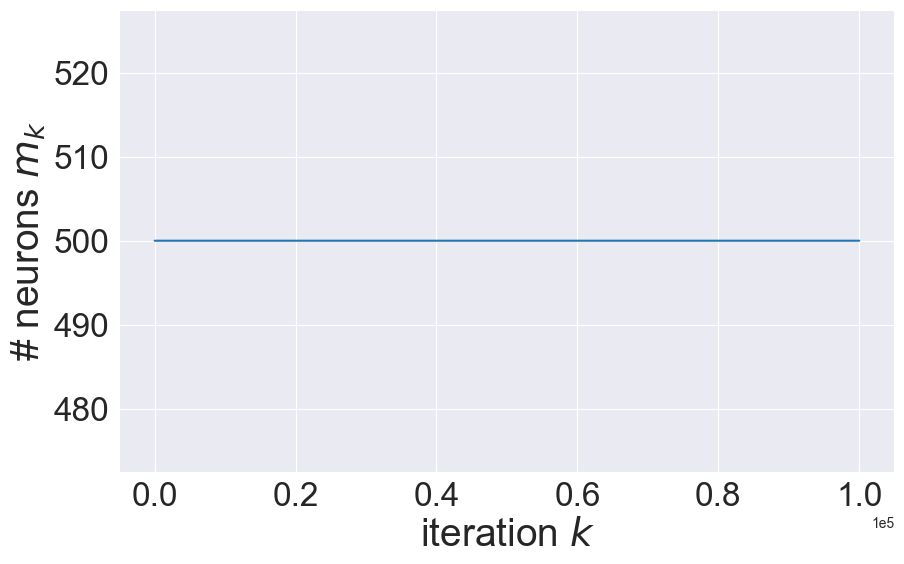

In [36]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

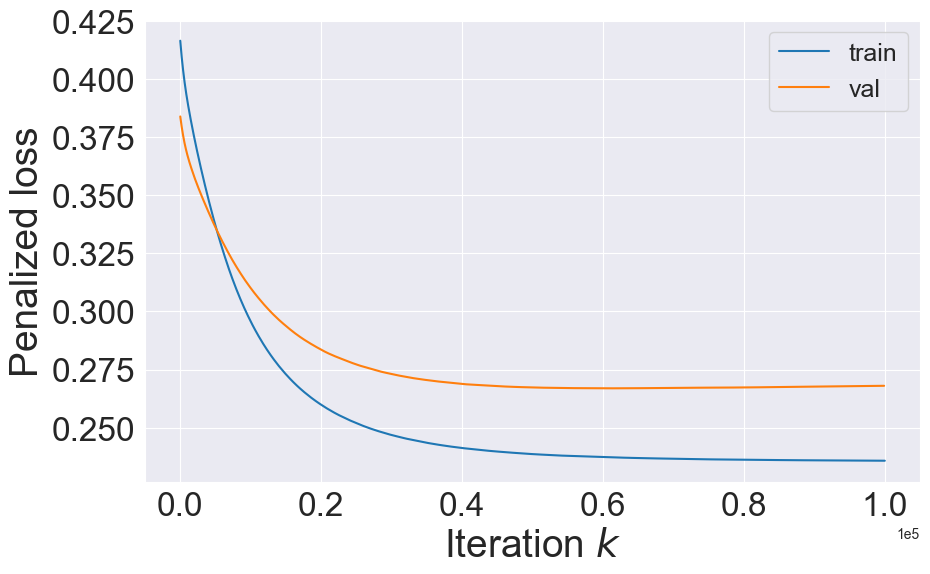

In [37]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses)), penalized_train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

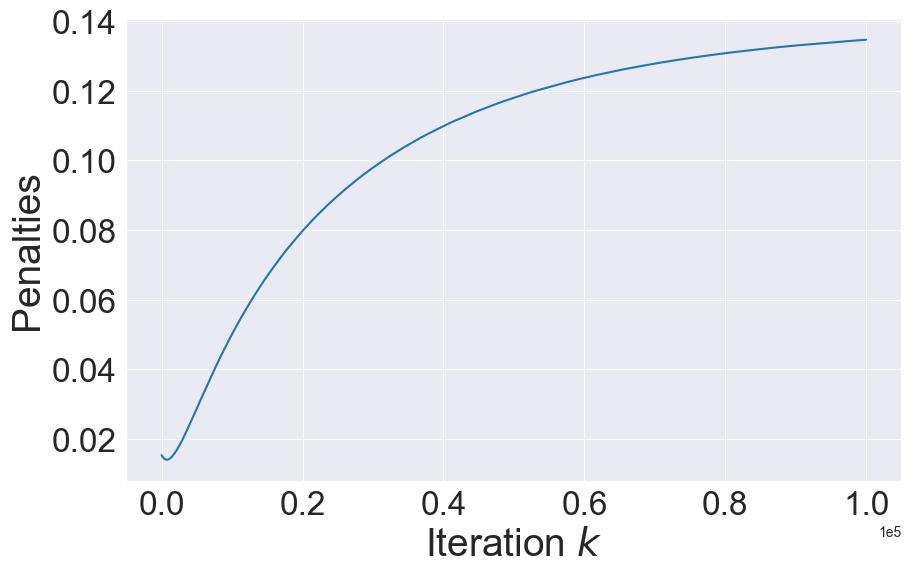

In [38]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses - train_losses

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

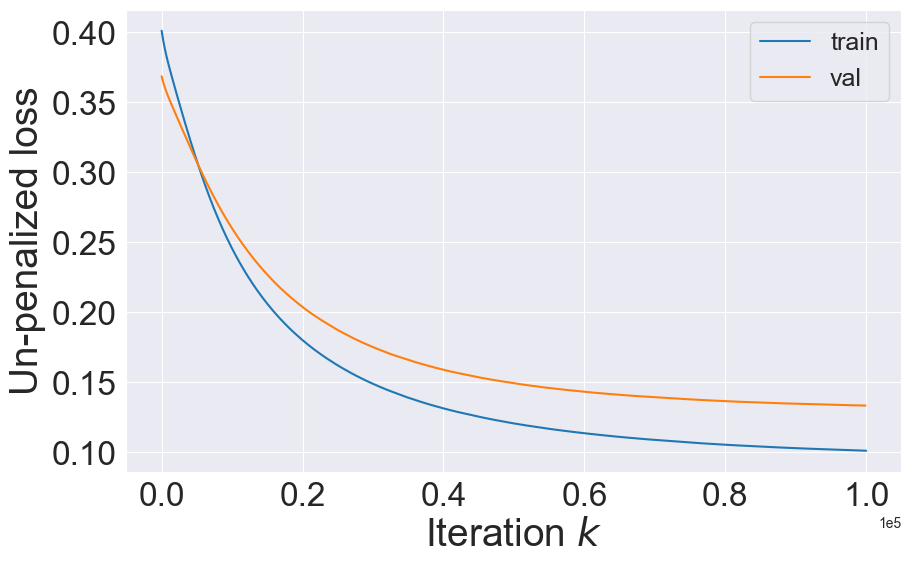

In [39]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

## 4. Projected 2-homogeneous conic descent 

Here we use the correspondance:
\begin{align*}
    \mu &= \sum_{j=1}^m a_j \delta_{b_j}, \quad a_j \in \mathbb{R}, \quad b_j \in \mathbb{S}^{d-1},\\
    \nu &= \frac{1}{m}\sum_{j=1}^m u_j \delta_{v_j}, \quad u_j \in \mathbb{R}, \quad v_j \in \mathbb{R}^{d},\\
    u_j &= \sqrt{m |a_j|} \epsilon_j, \\
    v_j &= \sqrt{m |a_j|} b_j,\\
    \epsilon_j :&= \text{sign}(a_j),
\end{align*}
so that $|u_j| = ||v_j||$ which allows for a proper correspondance under 2-hommogeneity. 

We take the usual update on $v_j$ and then translate it into an update for $u_j$ since it must hold $|u_j| = ||v_j||$ at all times and we simply adjust the sign accordingly. We then finally translate this update into updates for $a_j$ and $b_j$ via the correspondance $b_j = \frac{v_j}{||v_j||}$ and $|a_j| = ||v_j||^2$ with the sign adjusted accoridngly.

In [120]:
n_steps = N_STEPS
m = 500
ETA = 0.01
penalized = True

In [121]:
def projected_conic_particle_update(a, b, x, y, penalized=False):
    m = a.shape[1]
    if m > 0:
        signs = np.sign(a)
        a = a * (1 - 2 * ETA * signs * V_grad(a, b, x, y, b).reshape(1, -1))
        #- ETA * V_grad_sphere(a, b, x, y, b).reshape(1, -1) / m
        b = b - ETA * signs.T * nabla_V_grad(a, b, x, y)
        # b - ETA * nabla_V_grad(a, b, x, y)
        
        if penalized:
            a -= 2 * ETA * LAMBDA * a
            b -= ETA * LAMBDA * b
        
        b_norms = np.linalg.norm(b, ord=2, axis=1, keepdims=True)
        # a = a * b_norms.T
        b = b / b_norms
    return a, b  

In [122]:
def train(m, n_steps, x_train, y_train, x_val, y_val, do_val=True, penalized=False):
    #a = np.zeros(shape=(1, m))
    a = np.random.normal(size=(1, m)) / m
    b = np.random.normal(size=(m, INPUT_DIM))
    b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
    b = b / b_norms
    
    train_losses = []
    penalized_train_losses = []
    val_losses = []
    penalized_val_losses = []
    ms = [m]

    for k in tqdm(range(n_steps)):
        a, b = projected_conic_particle_update(a, b, x_train, y_train, penalized=penalized)
        ms.append(a.shape[1])
        
        train_loss, penalized_train_loss = compute_losses(a, b, x_train, y_train)
        train_losses.append(train_loss)
        penalized_train_losses.append(penalized_train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if k % VAL_ITER == 0:
                val_loss, penalized_val_loss = compute_losses(a, b, x_val, y_val)
                val_losses.append(val_loss)
                penalized_val_losses.append(penalized_val_loss)
                print('m at step {:,} : {:,}'.format(k, ms[-1]))
                print('Train loss at step {:,} : {:.5f}'.format(k, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(k, val_loss))
                
    return a, b, np.array(ms), np.array(train_losses), np.array(penalized_train_losses), np.array(val_losses), \
           np.array(penalized_val_losses) 

In [123]:
a, b, ms, train_losses, penalized_train_losses, val_losses, penalized_val_losses = \
    train(m, n_steps, x_train, y_train, x_val, y_val, penalized=penalized)

  0%|                                                        | 12/20000 [00:00<02:51, 116.74it/s]

m at step 0 : 500
Train loss at step 0 : 0.40142
Validation loss at step 0 : 0.36991


  1%|▎                                                      | 129/20000 [00:01<02:17, 144.36it/s]

m at step 100 : 500
Train loss at step 100 : 0.39800
Validation loss at step 100 : 0.36766


  1%|▌                                                      | 203/20000 [00:01<01:57, 168.36it/s]

m at step 200 : 500
Train loss at step 200 : 0.39486
Validation loss at step 200 : 0.36558


  2%|▉                                                      | 339/20000 [00:02<01:31, 214.44it/s]

m at step 300 : 500
Train loss at step 300 : 0.39194
Validation loss at step 300 : 0.36362


  2%|█▏                                                     | 432/20000 [00:02<01:27, 222.89it/s]

m at step 400 : 500
Train loss at step 400 : 0.38917
Validation loss at step 400 : 0.36173


  3%|█▌                                                     | 549/20000 [00:03<01:26, 225.40it/s]

m at step 500 : 500
Train loss at step 500 : 0.38645
Validation loss at step 500 : 0.35987


  3%|█▊                                                     | 643/20000 [00:03<01:24, 229.08it/s]

m at step 600 : 500
Train loss at step 600 : 0.38375
Validation loss at step 600 : 0.35801


  4%|██                                                     | 737/20000 [00:04<01:24, 227.78it/s]

m at step 700 : 500
Train loss at step 700 : 0.38102
Validation loss at step 700 : 0.35612


  4%|██▎                                                    | 831/20000 [00:04<01:23, 229.77it/s]

m at step 800 : 500
Train loss at step 800 : 0.37823
Validation loss at step 800 : 0.35419


  5%|██▌                                                    | 927/20000 [00:04<01:23, 228.78it/s]

m at step 900 : 500
Train loss at step 900 : 0.37533
Validation loss at step 900 : 0.35218


  5%|██▊                                                   | 1049/20000 [00:05<01:21, 233.74it/s]

m at step 1,000 : 500
Train loss at step 1,000 : 0.37229
Validation loss at step 1,000 : 0.35007


  6%|███                                                   | 1144/20000 [00:05<01:22, 227.43it/s]

m at step 1,100 : 500
Train loss at step 1,100 : 0.36907
Validation loss at step 1,100 : 0.34784


  6%|███▎                                                  | 1237/20000 [00:06<01:23, 225.66it/s]

m at step 1,200 : 500
Train loss at step 1,200 : 0.36565
Validation loss at step 1,200 : 0.34546


  7%|███▌                                                  | 1329/20000 [00:06<01:24, 222.09it/s]

m at step 1,300 : 500
Train loss at step 1,300 : 0.36201
Validation loss at step 1,300 : 0.34294


  7%|███▉                                                  | 1447/20000 [00:07<01:21, 228.62it/s]

m at step 1,400 : 500
Train loss at step 1,400 : 0.35811
Validation loss at step 1,400 : 0.34022


  8%|████▏                                                 | 1542/20000 [00:07<01:20, 230.06it/s]

m at step 1,500 : 500
Train loss at step 1,500 : 0.35394
Validation loss at step 1,500 : 0.33731


  8%|████▍                                                 | 1636/20000 [00:08<01:22, 223.89it/s]

m at step 1,600 : 500
Train loss at step 1,600 : 0.34947
Validation loss at step 1,600 : 0.33420


  9%|████▋                                                 | 1729/20000 [00:08<01:21, 224.14it/s]

m at step 1,700 : 500
Train loss at step 1,700 : 0.34471
Validation loss at step 1,700 : 0.33086


  9%|████▉                                                 | 1847/20000 [00:09<01:19, 228.41it/s]

m at step 1,800 : 500
Train loss at step 1,800 : 0.33963
Validation loss at step 1,800 : 0.32730


 10%|█████▏                                                | 1931/20000 [00:09<01:38, 182.95it/s]

m at step 1,900 : 500
Train loss at step 1,900 : 0.33423
Validation loss at step 1,900 : 0.32351


 10%|█████▍                                                | 2035/20000 [00:10<01:36, 185.64it/s]

m at step 2,000 : 500
Train loss at step 2,000 : 0.32850
Validation loss at step 2,000 : 0.31947


 11%|█████▊                                                | 2130/20000 [00:10<01:19, 224.19it/s]

m at step 2,100 : 500
Train loss at step 2,100 : 0.32246
Validation loss at step 2,100 : 0.31520


 11%|██████                                                | 2226/20000 [00:10<01:18, 226.29it/s]

m at step 2,200 : 500
Train loss at step 2,200 : 0.31612
Validation loss at step 2,200 : 0.31070


 12%|██████▎                                               | 2349/20000 [00:11<01:25, 207.12it/s]

m at step 2,300 : 500
Train loss at step 2,300 : 0.30950
Validation loss at step 2,300 : 0.30598


 12%|██████▌                                               | 2421/20000 [00:12<01:26, 202.53it/s]

m at step 2,400 : 500
Train loss at step 2,400 : 0.30262
Validation loss at step 2,400 : 0.30105


 13%|██████▊                                               | 2536/20000 [00:12<01:20, 216.29it/s]

m at step 2,500 : 500
Train loss at step 2,500 : 0.29551
Validation loss at step 2,500 : 0.29592


 13%|███████                                               | 2630/20000 [00:13<02:22, 121.76it/s]

m at step 2,600 : 500
Train loss at step 2,600 : 0.28822
Validation loss at step 2,600 : 0.29062


 14%|███████▎                                              | 2726/20000 [00:13<01:29, 193.84it/s]

m at step 2,700 : 500
Train loss at step 2,700 : 0.28078
Validation loss at step 2,700 : 0.28516


 14%|███████▋                                              | 2848/20000 [00:14<01:15, 226.65it/s]

m at step 2,800 : 500
Train loss at step 2,800 : 0.27325
Validation loss at step 2,800 : 0.27957


 15%|███████▉                                              | 2943/20000 [00:14<01:19, 215.12it/s]

m at step 2,900 : 500
Train loss at step 2,900 : 0.26567
Validation loss at step 2,900 : 0.27390


 15%|████████▏                                             | 3037/20000 [00:15<01:14, 226.71it/s]

m at step 3,000 : 500
Train loss at step 3,000 : 0.25810
Validation loss at step 3,000 : 0.26817


 16%|████████▍                                             | 3134/20000 [00:15<01:11, 236.05it/s]

m at step 3,100 : 500
Train loss at step 3,100 : 0.25060
Validation loss at step 3,100 : 0.26242


 16%|████████▋                                             | 3233/20000 [00:16<01:09, 240.10it/s]

m at step 3,200 : 500
Train loss at step 3,200 : 0.24321
Validation loss at step 3,200 : 0.25669


 17%|████████▉                                             | 3329/20000 [00:16<01:14, 222.96it/s]

m at step 3,300 : 500
Train loss at step 3,300 : 0.23598
Validation loss at step 3,300 : 0.25101


 17%|█████████▎                                            | 3426/20000 [00:16<01:09, 236.95it/s]

m at step 3,400 : 500
Train loss at step 3,400 : 0.22895
Validation loss at step 3,400 : 0.24541


 18%|█████████▌                                            | 3550/20000 [00:17<01:07, 241.96it/s]

m at step 3,500 : 500
Train loss at step 3,500 : 0.22216
Validation loss at step 3,500 : 0.23992


 18%|█████████▊                                            | 3648/20000 [00:17<01:08, 238.96it/s]

m at step 3,600 : 500
Train loss at step 3,600 : 0.21562
Validation loss at step 3,600 : 0.23457


 19%|██████████                                            | 3744/20000 [00:18<01:11, 227.84it/s]

m at step 3,700 : 500
Train loss at step 3,700 : 0.20935
Validation loss at step 3,700 : 0.22937


 19%|██████████▎                                           | 3840/20000 [00:18<01:09, 233.00it/s]

m at step 3,800 : 500
Train loss at step 3,800 : 0.20339
Validation loss at step 3,800 : 0.22435


 20%|██████████▋                                           | 3938/20000 [00:19<01:08, 232.99it/s]

m at step 3,900 : 500
Train loss at step 3,900 : 0.19773
Validation loss at step 3,900 : 0.21951


 20%|██████████▉                                           | 4036/20000 [00:19<01:07, 237.64it/s]

m at step 4,000 : 500
Train loss at step 4,000 : 0.19238
Validation loss at step 4,000 : 0.21486


 21%|███████████▏                                          | 4135/20000 [00:19<01:06, 240.17it/s]

m at step 4,100 : 500
Train loss at step 4,100 : 0.18733
Validation loss at step 4,100 : 0.21042


 21%|███████████▍                                          | 4235/20000 [00:20<01:05, 242.06it/s]

m at step 4,200 : 500
Train loss at step 4,200 : 0.18259
Validation loss at step 4,200 : 0.20619


 22%|███████████▋                                          | 4335/20000 [00:20<01:04, 241.07it/s]

m at step 4,300 : 500
Train loss at step 4,300 : 0.17814
Validation loss at step 4,300 : 0.20217


 22%|███████████▉                                          | 4408/20000 [00:21<01:42, 152.38it/s]

m at step 4,400 : 500
Train loss at step 4,400 : 0.17398
Validation loss at step 4,400 : 0.19835


 23%|████████████▏                                         | 4529/20000 [00:21<01:10, 219.32it/s]

m at step 4,500 : 500
Train loss at step 4,500 : 0.17009
Validation loss at step 4,500 : 0.19473


 23%|████████████▍                                         | 4625/20000 [00:22<01:07, 229.13it/s]

m at step 4,600 : 500
Train loss at step 4,600 : 0.16646
Validation loss at step 4,600 : 0.19130


 24%|████████████▊                                         | 4747/20000 [00:22<01:03, 238.91it/s]

m at step 4,700 : 500
Train loss at step 4,700 : 0.16306
Validation loss at step 4,700 : 0.18807


 24%|█████████████                                         | 4843/20000 [00:23<01:07, 224.98it/s]

m at step 4,800 : 500
Train loss at step 4,800 : 0.15990
Validation loss at step 4,800 : 0.18503


 25%|█████████████▎                                        | 4941/20000 [00:23<01:03, 237.46it/s]

m at step 4,900 : 500
Train loss at step 4,900 : 0.15695
Validation loss at step 4,900 : 0.18215


 25%|█████████████▌                                        | 5037/20000 [00:23<01:06, 224.55it/s]

m at step 5,000 : 500
Train loss at step 5,000 : 0.15419
Validation loss at step 5,000 : 0.17944


 26%|█████████████▊                                        | 5133/20000 [00:24<01:03, 234.14it/s]

m at step 5,100 : 500
Train loss at step 5,100 : 0.15162
Validation loss at step 5,100 : 0.17689


 26%|██████████████▏                                       | 5232/20000 [00:24<01:01, 239.48it/s]

m at step 5,200 : 500
Train loss at step 5,200 : 0.14922
Validation loss at step 5,200 : 0.17449


 27%|██████████████▍                                       | 5329/20000 [00:25<01:02, 235.16it/s]

m at step 5,300 : 500
Train loss at step 5,300 : 0.14698
Validation loss at step 5,300 : 0.17223


 27%|██████████████▋                                       | 5427/20000 [00:25<01:00, 238.98it/s]

m at step 5,400 : 500
Train loss at step 5,400 : 0.14488
Validation loss at step 5,400 : 0.17010


 28%|██████████████▉                                       | 5549/20000 [00:26<01:01, 236.78it/s]

m at step 5,500 : 500
Train loss at step 5,500 : 0.14292
Validation loss at step 5,500 : 0.16809


 28%|███████████████▏                                      | 5647/20000 [00:26<01:00, 237.69it/s]

m at step 5,600 : 500
Train loss at step 5,600 : 0.14108
Validation loss at step 5,600 : 0.16619


 29%|███████████████▌                                      | 5744/20000 [00:27<01:00, 235.82it/s]

m at step 5,700 : 500
Train loss at step 5,700 : 0.13935
Validation loss at step 5,700 : 0.16440


 29%|███████████████▊                                      | 5842/20000 [00:27<00:59, 236.34it/s]

m at step 5,800 : 500
Train loss at step 5,800 : 0.13773
Validation loss at step 5,800 : 0.16272


 30%|████████████████                                      | 5941/20000 [00:27<00:58, 239.52it/s]

m at step 5,900 : 500
Train loss at step 5,900 : 0.13620
Validation loss at step 5,900 : 0.16112


 30%|████████████████▎                                     | 6039/20000 [00:28<00:58, 239.81it/s]

m at step 6,000 : 500
Train loss at step 6,000 : 0.13477
Validation loss at step 6,000 : 0.15962


 31%|████████████████▌                                     | 6138/20000 [00:28<00:58, 236.82it/s]

m at step 6,100 : 500
Train loss at step 6,100 : 0.13343
Validation loss at step 6,100 : 0.15820


 31%|████████████████▊                                     | 6237/20000 [00:29<00:57, 238.62it/s]

m at step 6,200 : 500
Train loss at step 6,200 : 0.13216
Validation loss at step 6,200 : 0.15686


 32%|█████████████████                                     | 6336/20000 [00:29<00:56, 240.40it/s]

m at step 6,300 : 500
Train loss at step 6,300 : 0.13096
Validation loss at step 6,300 : 0.15559


 32%|█████████████████▎                                    | 6435/20000 [00:29<00:56, 239.53it/s]

m at step 6,400 : 500
Train loss at step 6,400 : 0.12983
Validation loss at step 6,400 : 0.15439


 33%|█████████████████▋                                    | 6532/20000 [00:30<00:56, 236.98it/s]

m at step 6,500 : 500
Train loss at step 6,500 : 0.12876
Validation loss at step 6,500 : 0.15326


 33%|█████████████████▉                                    | 6630/20000 [00:30<00:55, 239.52it/s]

m at step 6,600 : 500
Train loss at step 6,600 : 0.12774
Validation loss at step 6,600 : 0.15218


 34%|██████████████████▏                                   | 6727/20000 [00:31<00:56, 236.86it/s]

m at step 6,700 : 500
Train loss at step 6,700 : 0.12678
Validation loss at step 6,700 : 0.15116


 34%|██████████████████▍                                   | 6819/20000 [00:31<01:24, 156.40it/s]

m at step 6,800 : 500
Train loss at step 6,800 : 0.12586
Validation loss at step 6,800 : 0.15019


 35%|██████████████████▋                                   | 6940/20000 [00:32<00:59, 220.81it/s]

m at step 6,900 : 500
Train loss at step 6,900 : 0.12500
Validation loss at step 6,900 : 0.14927


 35%|██████████████████▉                                   | 7037/20000 [00:32<00:55, 232.72it/s]

m at step 7,000 : 500
Train loss at step 7,000 : 0.12417
Validation loss at step 7,000 : 0.14840


 36%|███████████████████▎                                  | 7135/20000 [00:33<00:54, 238.18it/s]

m at step 7,100 : 500
Train loss at step 7,100 : 0.12338
Validation loss at step 7,100 : 0.14757


 36%|███████████████████▌                                  | 7233/20000 [00:33<00:53, 239.01it/s]

m at step 7,200 : 500
Train loss at step 7,200 : 0.12263
Validation loss at step 7,200 : 0.14679


 37%|███████████████████▊                                  | 7331/20000 [00:33<00:53, 237.18it/s]

m at step 7,300 : 500
Train loss at step 7,300 : 0.12192
Validation loss at step 7,300 : 0.14604


 37%|████████████████████                                  | 7427/20000 [00:34<00:53, 234.68it/s]

m at step 7,400 : 500
Train loss at step 7,400 : 0.12123
Validation loss at step 7,400 : 0.14533


 38%|████████████████████▍                                 | 7550/20000 [00:34<00:51, 240.60it/s]

m at step 7,500 : 500
Train loss at step 7,500 : 0.12058
Validation loss at step 7,500 : 0.14466


 38%|████████████████████▌                                 | 7625/20000 [00:35<00:51, 238.72it/s]

m at step 7,600 : 500
Train loss at step 7,600 : 0.11995
Validation loss at step 7,600 : 0.14402


 39%|████████████████████▉                                 | 7748/20000 [00:35<00:51, 239.44it/s]

m at step 7,700 : 500
Train loss at step 7,700 : 0.11935
Validation loss at step 7,700 : 0.14341


 39%|█████████████████████▏                                | 7847/20000 [00:36<00:50, 240.42it/s]

m at step 7,800 : 500
Train loss at step 7,800 : 0.11877
Validation loss at step 7,800 : 0.14283


 40%|█████████████████████▍                                | 7946/20000 [00:36<00:50, 240.17it/s]

m at step 7,900 : 500
Train loss at step 7,900 : 0.11822
Validation loss at step 7,900 : 0.14227


 40%|█████████████████████▋                                | 8044/20000 [00:36<00:50, 237.96it/s]

m at step 8,000 : 500
Train loss at step 8,000 : 0.11768
Validation loss at step 8,000 : 0.14174


 41%|█████████████████████▉                                | 8142/20000 [00:37<00:49, 238.72it/s]

m at step 8,100 : 500
Train loss at step 8,100 : 0.11717
Validation loss at step 8,100 : 0.14124


 41%|██████████████████████▏                               | 8240/20000 [00:37<00:49, 239.22it/s]

m at step 8,200 : 500
Train loss at step 8,200 : 0.11667
Validation loss at step 8,200 : 0.14075


 42%|██████████████████████▌                               | 8338/20000 [00:38<00:49, 237.58it/s]

m at step 8,300 : 500
Train loss at step 8,300 : 0.11619
Validation loss at step 8,300 : 0.14029


 42%|██████████████████████▊                               | 8436/20000 [00:38<00:48, 236.03it/s]

m at step 8,400 : 500
Train loss at step 8,400 : 0.11573
Validation loss at step 8,400 : 0.13985


 43%|███████████████████████                               | 8534/20000 [00:39<00:47, 239.47it/s]

m at step 8,500 : 500
Train loss at step 8,500 : 0.11528
Validation loss at step 8,500 : 0.13943


 43%|███████████████████████▎                              | 8632/20000 [00:39<00:48, 235.89it/s]

m at step 8,600 : 500
Train loss at step 8,600 : 0.11485
Validation loss at step 8,600 : 0.13903


 44%|███████████████████████▌                              | 8731/20000 [00:39<00:47, 239.18it/s]

m at step 8,700 : 500
Train loss at step 8,700 : 0.11443
Validation loss at step 8,700 : 0.13864


 44%|███████████████████████▊                              | 8828/20000 [00:40<00:47, 234.53it/s]

m at step 8,800 : 500
Train loss at step 8,800 : 0.11402
Validation loss at step 8,800 : 0.13827


 45%|████████████████████████                              | 8926/20000 [00:40<00:46, 238.43it/s]

m at step 8,900 : 500
Train loss at step 8,900 : 0.11363
Validation loss at step 8,900 : 0.13792


 45%|████████████████████████▍                             | 9050/20000 [00:41<00:45, 240.19it/s]

m at step 9,000 : 500
Train loss at step 9,000 : 0.11324
Validation loss at step 9,000 : 0.13758


 46%|████████████████████████▋                             | 9125/20000 [00:41<00:45, 238.69it/s]

m at step 9,100 : 500
Train loss at step 9,100 : 0.11287
Validation loss at step 9,100 : 0.13725


 46%|████████████████████████▉                             | 9244/20000 [00:42<00:51, 209.41it/s]

m at step 9,200 : 500
Train loss at step 9,200 : 0.11251
Validation loss at step 9,200 : 0.13694


 47%|█████████████████████████▏                            | 9342/20000 [00:42<00:46, 230.23it/s]

m at step 9,300 : 500
Train loss at step 9,300 : 0.11216
Validation loss at step 9,300 : 0.13664


 47%|█████████████████████████▍                            | 9437/20000 [00:43<00:45, 230.46it/s]

m at step 9,400 : 500
Train loss at step 9,400 : 0.11181
Validation loss at step 9,400 : 0.13635


 48%|█████████████████████████▋                            | 9533/20000 [00:43<00:45, 228.64it/s]

m at step 9,500 : 500
Train loss at step 9,500 : 0.11148
Validation loss at step 9,500 : 0.13607


 48%|██████████████████████████                            | 9630/20000 [00:43<00:44, 235.50it/s]

m at step 9,600 : 500
Train loss at step 9,600 : 0.11115
Validation loss at step 9,600 : 0.13581


 49%|██████████████████████████▎                           | 9727/20000 [00:44<00:43, 235.09it/s]

m at step 9,700 : 500
Train loss at step 9,700 : 0.11083
Validation loss at step 9,700 : 0.13555


 49%|██████████████████████████▌                           | 9847/20000 [00:44<00:45, 222.80it/s]

m at step 9,800 : 500
Train loss at step 9,800 : 0.11052
Validation loss at step 9,800 : 0.13530


 50%|██████████████████████████▊                           | 9942/20000 [00:45<00:43, 230.29it/s]

m at step 9,900 : 500
Train loss at step 9,900 : 0.11022
Validation loss at step 9,900 : 0.13506


 50%|██████████████████████████▌                          | 10039/20000 [00:45<00:42, 234.44it/s]

m at step 10,000 : 500
Train loss at step 10,000 : 0.10992
Validation loss at step 10,000 : 0.13483


 51%|██████████████████████████▊                          | 10135/20000 [00:46<00:41, 234.91it/s]

m at step 10,100 : 500
Train loss at step 10,100 : 0.10963
Validation loss at step 10,100 : 0.13461


 51%|███████████████████████████                          | 10233/20000 [00:46<00:40, 238.79it/s]

m at step 10,200 : 500
Train loss at step 10,200 : 0.10934
Validation loss at step 10,200 : 0.13439


 52%|███████████████████████████▎                         | 10330/20000 [00:47<00:47, 203.50it/s]

m at step 10,300 : 500
Train loss at step 10,300 : 0.10906
Validation loss at step 10,300 : 0.13418


 52%|███████████████████████████▋                         | 10425/20000 [00:47<00:42, 223.07it/s]

m at step 10,400 : 500
Train loss at step 10,400 : 0.10879
Validation loss at step 10,400 : 0.13398


 53%|███████████████████████████▉                         | 10547/20000 [00:47<00:39, 239.01it/s]

m at step 10,500 : 500
Train loss at step 10,500 : 0.10852
Validation loss at step 10,500 : 0.13379


 53%|████████████████████████████▏                        | 10646/20000 [00:48<00:38, 240.08it/s]

m at step 10,600 : 500
Train loss at step 10,600 : 0.10825
Validation loss at step 10,600 : 0.13360


 54%|████████████████████████████▍                        | 10745/20000 [00:48<00:38, 239.86it/s]

m at step 10,700 : 500
Train loss at step 10,700 : 0.10800
Validation loss at step 10,700 : 0.13342


 54%|████████████████████████████▋                        | 10845/20000 [00:49<00:37, 240.99it/s]

m at step 10,800 : 500
Train loss at step 10,800 : 0.10774
Validation loss at step 10,800 : 0.13324


 55%|█████████████████████████████                        | 10945/20000 [00:49<00:37, 240.45it/s]

m at step 10,900 : 500
Train loss at step 10,900 : 0.10749
Validation loss at step 10,900 : 0.13307


 55%|█████████████████████████████▎                       | 11045/20000 [00:50<00:37, 240.41it/s]

m at step 11,000 : 500
Train loss at step 11,000 : 0.10725
Validation loss at step 11,000 : 0.13290


 56%|█████████████████████████████▌                       | 11144/20000 [00:50<00:37, 238.64it/s]

m at step 11,100 : 500
Train loss at step 11,100 : 0.10701
Validation loss at step 11,100 : 0.13274


 56%|█████████████████████████████▊                       | 11243/20000 [00:50<00:36, 239.93it/s]

m at step 11,200 : 500
Train loss at step 11,200 : 0.10677
Validation loss at step 11,200 : 0.13258


 57%|██████████████████████████████                       | 11340/20000 [00:51<00:36, 235.74it/s]

m at step 11,300 : 500
Train loss at step 11,300 : 0.10654
Validation loss at step 11,300 : 0.13243


 57%|██████████████████████████████▎                      | 11439/20000 [00:51<00:36, 236.92it/s]

m at step 11,400 : 500
Train loss at step 11,400 : 0.10631
Validation loss at step 11,400 : 0.13228


 58%|██████████████████████████████▌                      | 11533/20000 [00:52<00:47, 176.43it/s]

m at step 11,500 : 500
Train loss at step 11,500 : 0.10609
Validation loss at step 11,500 : 0.13214


 58%|██████████████████████████████▊                      | 11629/20000 [00:52<00:37, 220.54it/s]

m at step 11,600 : 500
Train loss at step 11,600 : 0.10587
Validation loss at step 11,600 : 0.13201


 59%|███████████████████████████████▏                     | 11749/20000 [00:53<00:34, 236.90it/s]

m at step 11,700 : 500
Train loss at step 11,700 : 0.10565
Validation loss at step 11,700 : 0.13188


 59%|███████████████████████████████▍                     | 11847/20000 [00:53<00:34, 238.87it/s]

m at step 11,800 : 500
Train loss at step 11,800 : 0.10543
Validation loss at step 11,800 : 0.13175


 60%|███████████████████████████████▋                     | 11945/20000 [00:54<00:33, 238.55it/s]

m at step 11,900 : 500
Train loss at step 11,900 : 0.10522
Validation loss at step 11,900 : 0.13163


 60%|███████████████████████████████▉                     | 12043/20000 [00:54<00:33, 237.92it/s]

m at step 12,000 : 500
Train loss at step 12,000 : 0.10502
Validation loss at step 12,000 : 0.13151


 61%|████████████████████████████████▏                    | 12141/20000 [00:54<00:32, 238.77it/s]

m at step 12,100 : 500
Train loss at step 12,100 : 0.10481
Validation loss at step 12,100 : 0.13140


 61%|████████████████████████████████▍                    | 12240/20000 [00:55<00:32, 238.96it/s]

m at step 12,200 : 500
Train loss at step 12,200 : 0.10461
Validation loss at step 12,200 : 0.13129


 62%|████████████████████████████████▋                    | 12336/20000 [00:55<00:32, 233.03it/s]

m at step 12,300 : 500
Train loss at step 12,300 : 0.10441
Validation loss at step 12,300 : 0.13118


 62%|████████████████████████████████▉                    | 12434/20000 [00:56<00:31, 237.26it/s]

m at step 12,400 : 500
Train loss at step 12,400 : 0.10422
Validation loss at step 12,400 : 0.13107


 63%|█████████████████████████████████▏                   | 12531/20000 [00:56<00:31, 238.43it/s]

m at step 12,500 : 500
Train loss at step 12,500 : 0.10402
Validation loss at step 12,500 : 0.13097


 63%|█████████████████████████████████▍                   | 12628/20000 [00:56<00:31, 237.08it/s]

m at step 12,600 : 500
Train loss at step 12,600 : 0.10384
Validation loss at step 12,600 : 0.13087


 64%|█████████████████████████████████▋                   | 12726/20000 [00:57<00:30, 238.65it/s]

m at step 12,700 : 500
Train loss at step 12,700 : 0.10365
Validation loss at step 12,700 : 0.13078


 64%|██████████████████████████████████                   | 12849/20000 [00:57<00:30, 237.84it/s]

m at step 12,800 : 500
Train loss at step 12,800 : 0.10347
Validation loss at step 12,800 : 0.13069


 65%|██████████████████████████████████▎                  | 12946/20000 [00:58<00:30, 230.71it/s]

m at step 12,900 : 500
Train loss at step 12,900 : 0.10328
Validation loss at step 12,900 : 0.13059


 65%|██████████████████████████████████▌                  | 13043/20000 [00:58<00:29, 234.53it/s]

m at step 13,000 : 500
Train loss at step 13,000 : 0.10311
Validation loss at step 13,000 : 0.13050


 66%|██████████████████████████████████▊                  | 13138/20000 [00:59<00:29, 230.43it/s]

m at step 13,100 : 500
Train loss at step 13,100 : 0.10293
Validation loss at step 13,100 : 0.13042


 66%|███████████████████████████████████                  | 13235/20000 [00:59<00:29, 230.79it/s]

m at step 13,200 : 500
Train loss at step 13,200 : 0.10276
Validation loss at step 13,200 : 0.13033


 67%|███████████████████████████████████▎                 | 13332/20000 [01:00<00:28, 233.57it/s]

m at step 13,300 : 500
Train loss at step 13,300 : 0.10258
Validation loss at step 13,300 : 0.13025


 67%|███████████████████████████████████▌                 | 13430/20000 [01:00<00:27, 238.94it/s]

m at step 13,400 : 500
Train loss at step 13,400 : 0.10242
Validation loss at step 13,400 : 0.13017


 68%|███████████████████████████████████▊                 | 13529/20000 [01:00<00:27, 238.49it/s]

m at step 13,500 : 500
Train loss at step 13,500 : 0.10225
Validation loss at step 13,500 : 0.13009


 68%|████████████████████████████████████                 | 13627/20000 [01:01<00:26, 237.99it/s]

m at step 13,600 : 500
Train loss at step 13,600 : 0.10209
Validation loss at step 13,600 : 0.13002


 69%|████████████████████████████████████▍                | 13750/20000 [01:01<00:25, 241.15it/s]

m at step 13,700 : 500
Train loss at step 13,700 : 0.10193
Validation loss at step 13,700 : 0.12995


 69%|████████████████████████████████████▌                | 13799/20000 [01:02<00:26, 233.52it/s]

m at step 13,800 : 500
Train loss at step 13,800 : 0.10177
Validation loss at step 13,800 : 0.12987


 70%|████████████████████████████████████▉                | 13942/20000 [01:02<00:27, 219.03it/s]

m at step 13,900 : 500
Train loss at step 13,900 : 0.10161
Validation loss at step 13,900 : 0.12981


 70%|█████████████████████████████████████▏               | 14039/20000 [01:03<00:25, 234.78it/s]

m at step 14,000 : 500
Train loss at step 14,000 : 0.10145
Validation loss at step 14,000 : 0.12974


 71%|█████████████████████████████████████▍               | 14136/20000 [01:03<00:25, 228.85it/s]

m at step 14,100 : 500
Train loss at step 14,100 : 0.10130
Validation loss at step 14,100 : 0.12967


 71%|█████████████████████████████████████▋               | 14234/20000 [01:04<00:24, 235.96it/s]

m at step 14,200 : 500
Train loss at step 14,200 : 0.10115
Validation loss at step 14,200 : 0.12961


 72%|█████████████████████████████████████▉               | 14331/20000 [01:04<00:24, 235.99it/s]

m at step 14,300 : 500
Train loss at step 14,300 : 0.10100
Validation loss at step 14,300 : 0.12955


 72%|██████████████████████████████████████▏              | 14429/20000 [01:04<00:23, 237.80it/s]

m at step 14,400 : 500
Train loss at step 14,400 : 0.10085
Validation loss at step 14,400 : 0.12949


 73%|██████████████████████████████████████▍              | 14526/20000 [01:05<00:23, 237.78it/s]

m at step 14,500 : 500
Train loss at step 14,500 : 0.10071
Validation loss at step 14,500 : 0.12943


 73%|██████████████████████████████████████▊              | 14648/20000 [01:05<00:22, 237.22it/s]

m at step 14,600 : 500
Train loss at step 14,600 : 0.10056
Validation loss at step 14,600 : 0.12937


 74%|███████████████████████████████████████              | 14746/20000 [01:06<00:22, 236.79it/s]

m at step 14,700 : 500
Train loss at step 14,700 : 0.10042
Validation loss at step 14,700 : 0.12931


 74%|███████████████████████████████████████▎             | 14844/20000 [01:06<00:21, 238.59it/s]

m at step 14,800 : 500
Train loss at step 14,800 : 0.10028
Validation loss at step 14,800 : 0.12926


 75%|███████████████████████████████████████▌             | 14941/20000 [01:07<00:21, 234.75it/s]

m at step 14,900 : 500
Train loss at step 14,900 : 0.10014
Validation loss at step 14,900 : 0.12920


 75%|███████████████████████████████████████▊             | 15039/20000 [01:07<00:20, 238.63it/s]

m at step 15,000 : 500
Train loss at step 15,000 : 0.10001
Validation loss at step 15,000 : 0.12915


 76%|████████████████████████████████████████             | 15137/20000 [01:07<00:20, 235.85it/s]

m at step 15,100 : 500
Train loss at step 15,100 : 0.09988
Validation loss at step 15,100 : 0.12909


 76%|████████████████████████████████████████▎            | 15233/20000 [01:08<00:20, 233.79it/s]

m at step 15,200 : 500
Train loss at step 15,200 : 0.09974
Validation loss at step 15,200 : 0.12904


 77%|████████████████████████████████████████▌            | 15330/20000 [01:08<00:19, 236.00it/s]

m at step 15,300 : 500
Train loss at step 15,300 : 0.09961
Validation loss at step 15,300 : 0.12899


 77%|████████████████████████████████████████▉            | 15427/20000 [01:09<00:19, 237.89it/s]

m at step 15,400 : 500
Train loss at step 15,400 : 0.09949
Validation loss at step 15,400 : 0.12894


 78%|█████████████████████████████████████████▏           | 15549/20000 [01:09<00:18, 237.92it/s]

m at step 15,500 : 500
Train loss at step 15,500 : 0.09936
Validation loss at step 15,500 : 0.12889


 78%|█████████████████████████████████████████▍           | 15647/20000 [01:10<00:18, 237.42it/s]

m at step 15,600 : 500
Train loss at step 15,600 : 0.09924
Validation loss at step 15,600 : 0.12884


 79%|█████████████████████████████████████████▋           | 15744/20000 [01:10<00:18, 234.57it/s]

m at step 15,700 : 500
Train loss at step 15,700 : 0.09911
Validation loss at step 15,700 : 0.12880


 79%|█████████████████████████████████████████▉           | 15842/20000 [01:10<00:17, 238.33it/s]

m at step 15,800 : 500
Train loss at step 15,800 : 0.09899
Validation loss at step 15,800 : 0.12875


 80%|██████████████████████████████████████████▏          | 15940/20000 [01:11<00:17, 235.88it/s]

m at step 15,900 : 500
Train loss at step 15,900 : 0.09887
Validation loss at step 15,900 : 0.12871


 80%|██████████████████████████████████████████▌          | 16038/20000 [01:11<00:17, 232.24it/s]

m at step 16,000 : 500
Train loss at step 16,000 : 0.09876
Validation loss at step 16,000 : 0.12866


 81%|██████████████████████████████████████████▋          | 16111/20000 [01:12<00:16, 233.74it/s]

m at step 16,100 : 500
Train loss at step 16,100 : 0.09864
Validation loss at step 16,100 : 0.12862


 81%|███████████████████████████████████████████          | 16229/20000 [01:12<00:18, 206.28it/s]

m at step 16,200 : 500
Train loss at step 16,200 : 0.09853
Validation loss at step 16,200 : 0.12857


 82%|███████████████████████████████████████████▎         | 16341/20000 [01:13<00:17, 204.22it/s]

m at step 16,300 : 500
Train loss at step 16,300 : 0.09841
Validation loss at step 16,300 : 0.12853


 82%|███████████████████████████████████████████▌         | 16437/20000 [01:13<00:15, 228.06it/s]

m at step 16,400 : 500
Train loss at step 16,400 : 0.09830
Validation loss at step 16,400 : 0.12849


 83%|███████████████████████████████████████████▊         | 16531/20000 [01:14<00:16, 204.80it/s]

m at step 16,500 : 500
Train loss at step 16,500 : 0.09819
Validation loss at step 16,500 : 0.12845


 83%|████████████████████████████████████████████         | 16622/20000 [01:14<00:16, 201.61it/s]

m at step 16,600 : 500
Train loss at step 16,600 : 0.09809
Validation loss at step 16,600 : 0.12841


 84%|████████████████████████████████████████████▎        | 16744/20000 [01:15<00:14, 232.54it/s]

m at step 16,700 : 500
Train loss at step 16,700 : 0.09798
Validation loss at step 16,700 : 0.12837


 84%|████████████████████████████████████████████▋        | 16841/20000 [01:15<00:14, 225.25it/s]

m at step 16,800 : 500
Train loss at step 16,800 : 0.09787
Validation loss at step 16,800 : 0.12833


 85%|████████████████████████████████████████████▉        | 16938/20000 [01:16<00:13, 235.07it/s]

m at step 16,900 : 500
Train loss at step 16,900 : 0.09777
Validation loss at step 16,900 : 0.12829


 85%|█████████████████████████████████████████████▏       | 17035/20000 [01:16<00:13, 218.46it/s]

m at step 17,000 : 500
Train loss at step 17,000 : 0.09767
Validation loss at step 17,000 : 0.12825


 86%|█████████████████████████████████████████████▍       | 17130/20000 [01:17<00:12, 221.44it/s]

m at step 17,100 : 500
Train loss at step 17,100 : 0.09757
Validation loss at step 17,100 : 0.12822


 86%|█████████████████████████████████████████████▋       | 17247/20000 [01:17<00:12, 225.57it/s]

m at step 17,200 : 500
Train loss at step 17,200 : 0.09747
Validation loss at step 17,200 : 0.12818


 87%|█████████████████████████████████████████████▉       | 17339/20000 [01:17<00:11, 223.84it/s]

m at step 17,300 : 500
Train loss at step 17,300 : 0.09737
Validation loss at step 17,300 : 0.12815


 87%|██████████████████████████████████████████████▏      | 17434/20000 [01:18<00:11, 227.91it/s]

m at step 17,400 : 500
Train loss at step 17,400 : 0.09727
Validation loss at step 17,400 : 0.12812


 88%|██████████████████████████████████████████████▍      | 17531/20000 [01:18<00:10, 235.67it/s]

m at step 17,500 : 500
Train loss at step 17,500 : 0.09718
Validation loss at step 17,500 : 0.12808


 88%|██████████████████████████████████████████████▋      | 17629/20000 [01:19<00:09, 237.17it/s]

m at step 17,600 : 500
Train loss at step 17,600 : 0.09708
Validation loss at step 17,600 : 0.12805


 89%|██████████████████████████████████████████████▉      | 17727/20000 [01:19<00:09, 239.41it/s]

m at step 17,700 : 500
Train loss at step 17,700 : 0.09699
Validation loss at step 17,700 : 0.12802


 89%|███████████████████████████████████████████████▎     | 17850/20000 [01:20<00:09, 238.82it/s]

m at step 17,800 : 500
Train loss at step 17,800 : 0.09690
Validation loss at step 17,800 : 0.12799


 90%|███████████████████████████████████████████████▌     | 17948/20000 [01:20<00:08, 238.34it/s]

m at step 17,900 : 500
Train loss at step 17,900 : 0.09681
Validation loss at step 17,900 : 0.12796


 90%|███████████████████████████████████████████████▊     | 18046/20000 [01:21<00:08, 238.11it/s]

m at step 18,000 : 500
Train loss at step 18,000 : 0.09672
Validation loss at step 18,000 : 0.12794


 91%|████████████████████████████████████████████████     | 18143/20000 [01:21<00:07, 236.02it/s]

m at step 18,100 : 500
Train loss at step 18,100 : 0.09663
Validation loss at step 18,100 : 0.12791


 91%|████████████████████████████████████████████████▎    | 18241/20000 [01:21<00:07, 231.81it/s]

m at step 18,200 : 500
Train loss at step 18,200 : 0.09655
Validation loss at step 18,200 : 0.12788


 92%|████████████████████████████████████████████████▌    | 18338/20000 [01:22<00:07, 234.45it/s]

m at step 18,300 : 500
Train loss at step 18,300 : 0.09646
Validation loss at step 18,300 : 0.12785


 92%|████████████████████████████████████████████████▊    | 18433/20000 [01:22<00:08, 194.11it/s]

m at step 18,400 : 500
Train loss at step 18,400 : 0.09638
Validation loss at step 18,400 : 0.12782


 93%|█████████████████████████████████████████████████    | 18528/20000 [01:23<00:06, 225.65it/s]

m at step 18,500 : 500
Train loss at step 18,500 : 0.09629
Validation loss at step 18,500 : 0.12780


 93%|█████████████████████████████████████████████████▎   | 18623/20000 [01:23<00:06, 216.68it/s]

m at step 18,600 : 500
Train loss at step 18,600 : 0.09621
Validation loss at step 18,600 : 0.12777


 94%|█████████████████████████████████████████████████▋   | 18744/20000 [01:24<00:05, 231.50it/s]

m at step 18,700 : 500
Train loss at step 18,700 : 0.09613
Validation loss at step 18,700 : 0.12774


 94%|█████████████████████████████████████████████████▉   | 18840/20000 [01:24<00:04, 233.60it/s]

m at step 18,800 : 500
Train loss at step 18,800 : 0.09605
Validation loss at step 18,800 : 0.12772


 95%|██████████████████████████████████████████████████▏  | 18937/20000 [01:25<00:04, 232.83it/s]

m at step 18,900 : 500
Train loss at step 18,900 : 0.09597
Validation loss at step 18,900 : 0.12769


 95%|██████████████████████████████████████████████████▍  | 19031/20000 [01:25<00:04, 229.46it/s]

m at step 19,000 : 500
Train loss at step 19,000 : 0.09590
Validation loss at step 19,000 : 0.12767


 96%|██████████████████████████████████████████████████▋  | 19125/20000 [01:25<00:03, 228.40it/s]

m at step 19,100 : 500
Train loss at step 19,100 : 0.09582
Validation loss at step 19,100 : 0.12764


 96%|███████████████████████████████████████████████████  | 19248/20000 [01:26<00:03, 236.32it/s]

m at step 19,200 : 500
Train loss at step 19,200 : 0.09574
Validation loss at step 19,200 : 0.12762


 97%|███████████████████████████████████████████████████▎ | 19343/20000 [01:26<00:02, 229.49it/s]

m at step 19,300 : 500
Train loss at step 19,300 : 0.09567
Validation loss at step 19,300 : 0.12759


 97%|███████████████████████████████████████████████████▌ | 19438/20000 [01:27<00:02, 233.44it/s]

m at step 19,400 : 500
Train loss at step 19,400 : 0.09560
Validation loss at step 19,400 : 0.12757


 98%|███████████████████████████████████████████████████▊ | 19534/20000 [01:27<00:02, 231.68it/s]

m at step 19,500 : 500
Train loss at step 19,500 : 0.09552
Validation loss at step 19,500 : 0.12754


 98%|████████████████████████████████████████████████████ | 19631/20000 [01:28<00:01, 233.41it/s]

m at step 19,600 : 500
Train loss at step 19,600 : 0.09545
Validation loss at step 19,600 : 0.12752


 99%|████████████████████████████████████████████████████▎| 19728/20000 [01:28<00:01, 235.00it/s]

m at step 19,700 : 500
Train loss at step 19,700 : 0.09538
Validation loss at step 19,700 : 0.12750


 99%|████████████████████████████████████████████████████▌| 19849/20000 [01:29<00:00, 233.27it/s]

m at step 19,800 : 500
Train loss at step 19,800 : 0.09531
Validation loss at step 19,800 : 0.12748


100%|████████████████████████████████████████████████████▊| 19948/20000 [01:29<00:00, 238.23it/s]

m at step 19,900 : 500
Train loss at step 19,900 : 0.09525
Validation loss at step 19,900 : 0.12746


100%|█████████████████████████████████████████████████████| 20000/20000 [01:29<00:00, 222.91it/s]


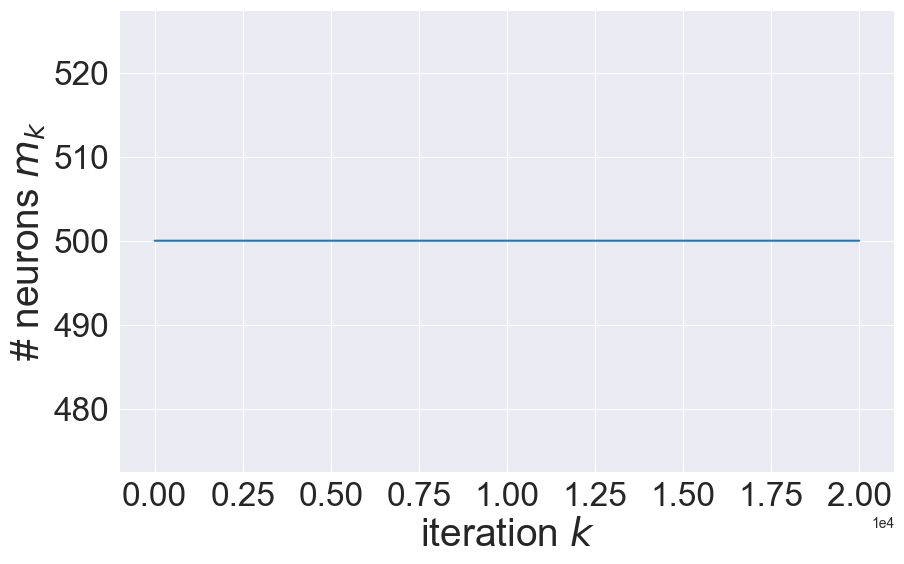

In [124]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(ms)), ms, label='$m_k$')

plt.xlabel('iteration $k$', fontsize=28)
plt.ylabel('# neurons $m_k$', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

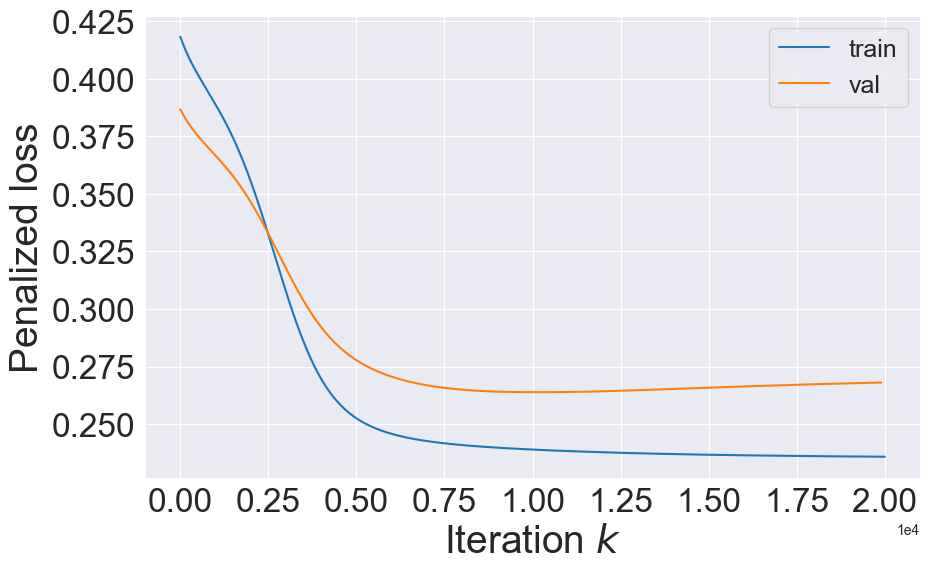

In [125]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(penalized_train_losses)), penalized_train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(penalized_train_losses)) for k in range(len(penalized_val_losses))], 
         penalized_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

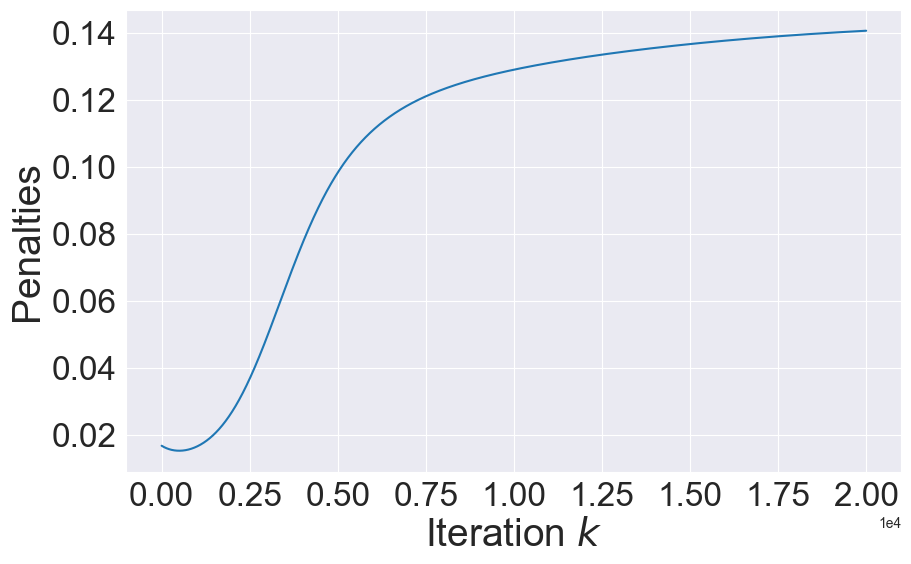

In [126]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

train_penalties = penalized_train_losses - train_losses

plt.plot(np.arange(len(train_penalties)), train_penalties, label='train')

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Penalties', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

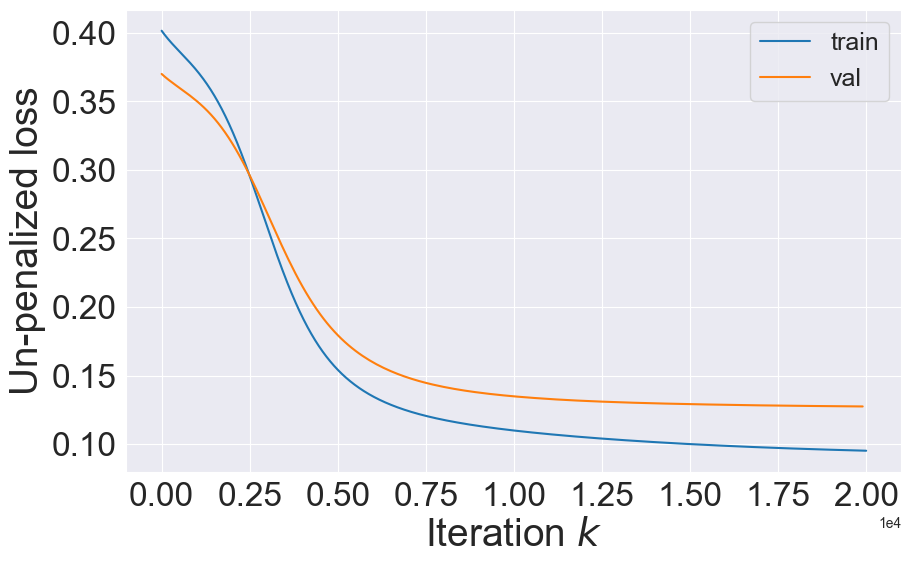

In [127]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $k$', fontsize=28)
plt.ylabel('Un-penalized loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

In [128]:
b_norms = np.linalg.norm(b, axis=1, ord=2, keepdims=True)
b_norms

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],